# Packages and Data loading

## packages

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
import time
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')
from time import time

from sklearn.metrics import make_scorer
from sklearn.externals import joblib

#json
import ujson as json

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 13

C:\Users\Alexey\Anaconda3\envs\ds_base\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ModuleNotFoundError: No module named 'skopt'

## data preparation

### reading (train, test)

In [7]:
#reading
PATH_TO_DATA = Path('../input/Dota_2/')
train_df = pd.read_csv(PATH_TO_DATA/'train_features.csv', index_col='match_id_hash')
test_df = pd.read_csv(PATH_TO_DATA/'test_features.csv', index_col='match_id_hash')

# get target
train_y = pd.read_csv(PATH_TO_DATA/'train_targets.csv', index_col='match_id_hash')
train_y['radiant_win'] = train_y['radiant_win'].map({False: 0, True: 1})

# set target to train
train_df['radiant_win'] = train_y['radiant_win']

# X, y
y = train_df['radiant_win']
X = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test = test_df.copy().reset_index(drop=True)

train_df.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
a400b8f29dece5f4d266f49f1ae2e98a               1        11          11   
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
46a0ddce8f7ed2a8d9bd5edcbb925682               1         4          14   
b1b35ff97723d9b7ade1c9c3cf48f770               1         3          42   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
a400b8f29dece5f4d266f49f1ae2e98a         0          0           0          0   
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
46a0ddce8f7ed2a8d9bd5edcbb925682         1          0           3          1   
b1b35ff97723d9b7ade1c9c3cf48f770         0          1           1          0   

                                     ...       d5_creeps_stacked  \
match_id_hash                        ...                           
a400b8f29dece5f4d266f49f1ae2e98a     ...                       0   
b9c57c450ce74a2af79c9ce96fac144d     ...                       0   
6db558535151ea18ca70a6892197db41     ...                       0   
46a0ddce8f7ed2a8d9bd5edcbb925682     ...                       3   
b1b35ff97723d9b7ade1c9c3cf48f770     ...                       2   

                                  d5_camps_stacked  d5_rune_pickups  \
match_id_hash                                                         
a400b8f29dece5f4d266f49f1ae2e98a                 0                0   
b9c57c450ce74a2af79c9ce96fac144d                 0                0   
6db558535151ea18ca70a6892197db41                 0                0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 1                3   
b1b35ff97723d9b7ade1c9c3cf48f770                 1                2   

                                  d5_firstblood_claimed  \
match_id_hash                                             
a400b8f29dece5f4d266f49f1ae2e98a                      0   
b9c57c450ce74a2af79c9ce96fac144d                      0   
6db558535151ea18ca70a6892197db41                      0   
46a0ddce8f7ed2a8d9bd5edcbb925682                      0   
b1b35ff97723d9b7ade1c9c3cf48f770                      0   

                                  d5_teamfight_participation  \
match_id_hash                                                  
a400b8f29dece5f4d266f49f1ae2e98a                        0.00   
b9c57c450ce74a2af79c9ce96fac144d                        0.00   
6db558535151ea18ca70a6892197db41                        0.00   
46a0ddce8f7ed2a8d9bd5edcbb925682                        0.00   
b1b35ff97723d9b7ade1c9c3cf48f770                        0.25   

                                  d5_towers_killed  d5_roshans_killed  \
match_id_hash                                                           
a400b8f29dece5f4d266f49f1ae2e98a                 0                  0   
b9c57c450ce74a2af79c9ce96fac144d                 0                  0   
6db558535151ea18ca70a6892197db41                 0                  0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 0                  0   
b1b35ff97723d9b7ade1c9c3cf48f770                 0                  0   

                                  d5_obs_placed  d5_sen_placed  radiant_win  
match_id_hash                      

### Сразу ок фичи
Альтернативный путь - сразу подгрузить датасеты, полученные на 5м шаге

In [3]:
PATH_TO_DATA = Path('../input/Dota_2/')

train_df = pd.read_csv(PATH_TO_DATA/'train_model_5.csv', index_col='match_id_hash')
test_df = pd.read_csv(PATH_TO_DATA/'test_model_5.csv', index_col='match_id_hash')



y = train_df['radiant_win']
X5 = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X5_test = test_df.copy().reset_index(drop=True)
train_df.head()

ValueError: Index match_id_hash invalid

Получается у нас будет теперь пачка датаФреймов

- train_df - оригинальный df Yorko, с целевой переменной
- test_df - также оригинальный тестовый df, без целевой переменной, конечно
- full_df - комба из train_df(без target) и test_df
- target - оригинальный итоговый df, с 4 колонками


- y - чисто колонка целевой переменной, для предсказаний
- X - обучающий набор с выпиленым target
- X_test - практически оригинальный тестовый df

#  Train Function, Feature Importance Func and First Model

## Training function

In [51]:
def get_col_ind(df):
    cat_features = []
    cat_column_names = list(df.select_dtypes(include=['category']))
    for col in cat_column_names:
        cat_features.append(df.columns.get_loc(col))
    return cat_features

In [52]:
def train_model(X, X_test, y, params, folds, rand_state, model_type='cat', averaging='usual', model=None):
    
    # индексы категориальных фич
    cat_features = get_col_ind(X)
    
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in tqdm(enumerate(folds.split(X, y))):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'cat':
            model = CatBoostClassifier(**params, random_state=rand_state)
            model.fit(X_train, 
                      y_train, 
                      eval_set=(X_valid, y_valid), 
                      cat_features=cat_features, 
                      use_best_model=True, 
                      verbose=500)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
            
    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    return oof, prediction, scores, model

## Params

In [9]:
# fast
params_cat = {
    'iterations' : 1000,
    'learning_rate' : 0.05,
    'loss_function':'Logloss',
    'eval_metric':'AUC', 
    'task_type': 'GPU',
    'early_stopping_rounds': 200,
#     'logging_level': 'Info', 
         }

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

# balance
# params_cat = {
#     'iterations' : 20000,
#     'learning_rate' : 0.05,
#     'loss_function':'Logloss',
#     'eval_metric':'AUC', 
#     'task_type': 'GPU',
#     'early_stopping_rounds': 200,
#     'logging_level': 'Info', 
#          }

# best score
# params_cat = {
#     'iterations' : 20000,
#     'learning_rate' : 0.05,
#     'loss_function':'Logloss',
#     'eval_metric':'AUC', 
#     'task_type': 'GPU',
#          }

## Create and train first model

In [7]:
cat_cols_ind = []

In [44]:
oof_cat, prediction_cat, scores_cat, cat_model = train_model(X,
                                                  X_test,
                                                  y,
                                                  params=params_cat,
                                                  cat_features=cat_cols_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  plot_feature_importance=True)

Fold 0 started at Tue Nov 12 22:09:23 2019
0:	learn: 0.6987239	test: 0.6827227	best: 0.6827227 (0)	total: 187ms	remaining: 3m 6s
500:	learn: 0.8621934	test: 0.8016110	best: 0.8016531 (495)	total: 1m 21s	remaining: 1m 21s
999:	learn: 0.8993212	test: 0.8060931	best: 0.8062073 (968)	total: 2m 37s	remaining: 0us
bestTest = 0.8062072992
bestIteration = 968
Shrink model to first 969 iterations.
Fold 1 started at Tue Nov 12 22:12:06 2019
0:	learn: 0.7029142	test: 0.6834864	best: 0.6834864 (0)	total: 184ms	remaining: 3m 3s
500:	learn: 0.8575337	test: 0.7888767	best: 0.7888790 (498)	total: 1m 18s	remaining: 1m 18s
999:	learn: 0.8872769	test: 0.7929685	best: 0.7930542 (984)	total: 2m 31s	remaining: 0us
bestTest = 0.7930542231
bestIteration = 984
Shrink model to first 985 iterations.
Fold 2 started at Tue Nov 12 22:14:41 2019
0:	learn: 0.6997987	test: 0.6876777	best: 0.6876777 (0)	total: 180ms	remaining: 2m 59s
500:	learn: 0.8592522	test: 0.8008893	best: 0.8010347 (489)	total: 1m 20s	remaining: 1

## Feature Importance Function

### GOOD: First way

In [54]:
def feature_importance(model, df_train, y):
    cat_features = get_col_ind(df_train)
    feature_score = pd.DataFrame(list(zip(df_train.dtypes.index, model.get_feature_importance(Pool(df_train, label=y, cat_features=cat_features)))),
                columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')[:50]
    
    plt.rcParams["figure.figsize"] = (16,9)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='r')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()

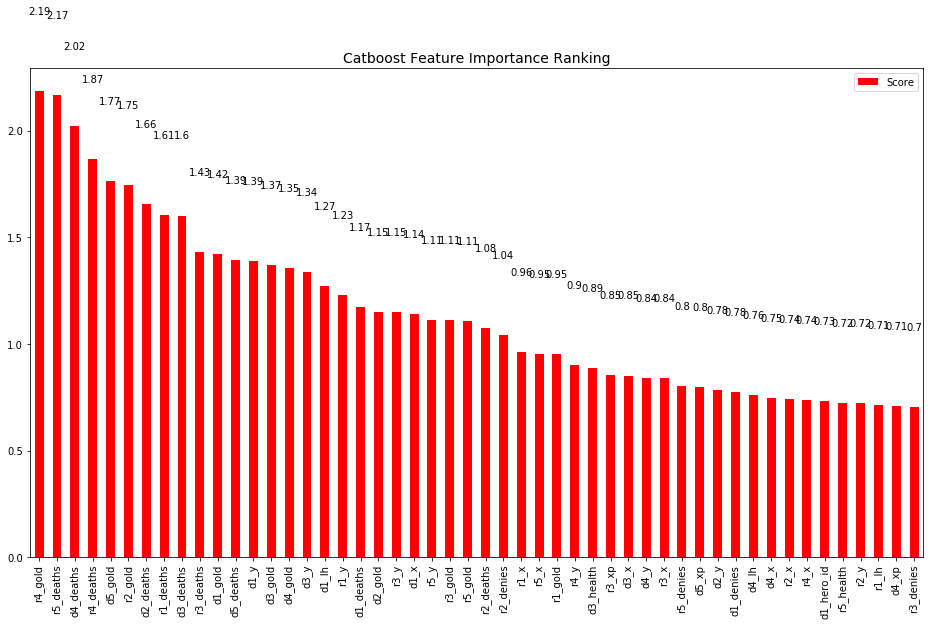

In [57]:
feature_importance(cat_model, train_df, train_y, cat_cols_ind)

### GOOD: Second way

In [55]:
def feature_importance_sns(model, df_train, y, figSize = (16,12)):
    cat_features = get_col_ind(df_train)
    feature_score = pd.DataFrame(list(zip(df_train.dtypes.index, model.get_feature_importance(Pool(df_train, label=y, cat_features=cat_features)))),
                    columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')[:50]
    plt.figure(figsize=figSize);
    sns.barplot(x="Score", y="Feature", data=feature_score);
    plt.title('CatBoost Features');

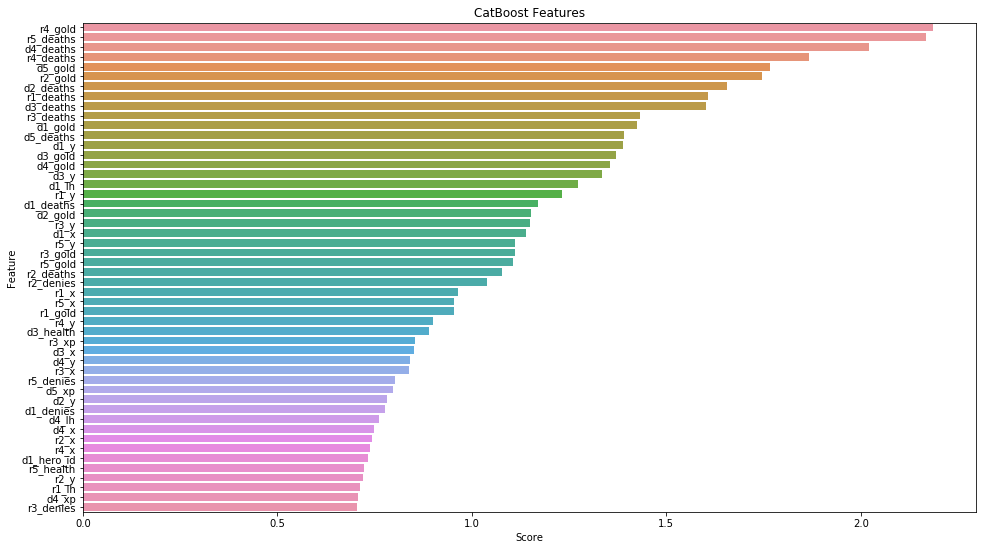

In [58]:
feature_importance_sns(cat_model, X, y, cat_cols_ind, figSize = (16,9))

### BAD

In [56]:
# подумать как нормально отсев по порогу запилить
def feature_importance_bad(model, df_train, y, figSize = (16,12), threshhold = 0.0, n = 50):
    cat_features = get_col_ind(df_train)
    feature_score = pd.DataFrame(list(zip(df_train.dtypes.index, model.get_feature_importance(Pool(df_train, label=y, cat_features=cat_features)))),
                    columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score', ascending=True, inplace=False, kind='quicksort', na_position='last')[:n]
    plt.figure(figsize=figSize);
    sns.barplot(x="Score", y="Feature", data=feature_score);
    plt.title('CatBoost Features');
    feature_score.head()
    return list(feature_score['Feature'])

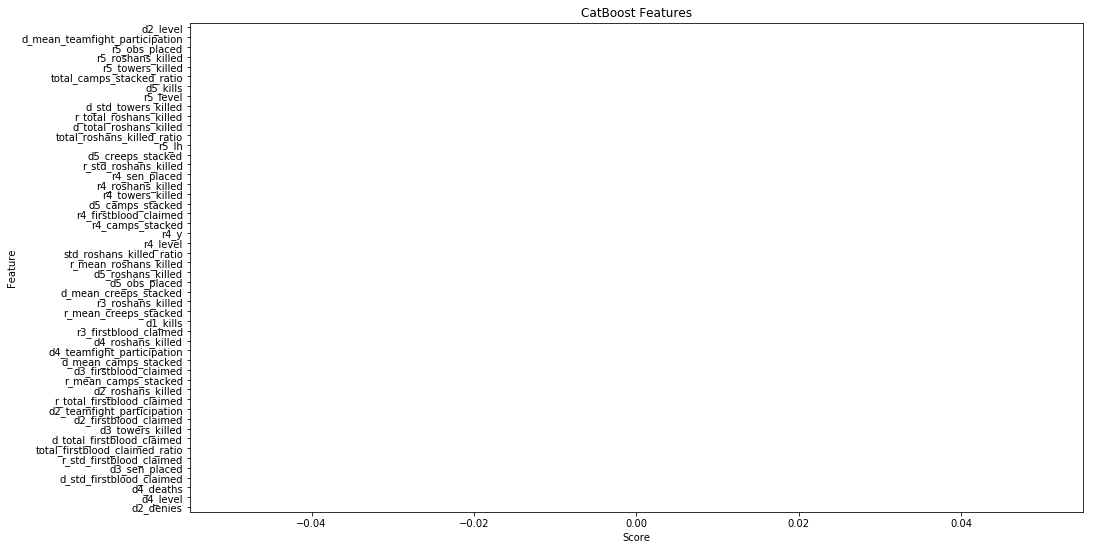

In [76]:
bad = feature_importance_bad(cat_model_2, X, y, cat_cols_ind, figSize = (16,9), n=50)

In [77]:
print(bad)

['d2_level', 'd_mean_teamfight_participation', 'r5_obs_placed', 'r5_roshans_killed', 'r5_towers_killed', 'total_camps_stacked_ratio', 'd5_kills', 'r5_level', 'd_std_towers_killed', 'r_total_roshans_killed', 'd_total_roshans_killed', 'total_roshans_killed_ratio', 'r5_lh', 'd5_creeps_stacked', 'r_std_roshans_killed', 'r4_sen_placed', 'r4_roshans_killed', 'r4_towers_killed', 'd5_camps_stacked', 'r4_firstblood_claimed', 'r4_camps_stacked', 'r4_y', 'r4_level', 'std_roshans_killed_ratio', 'r_mean_roshans_killed', 'd5_roshans_killed', 'd5_obs_placed', 'd_mean_creeps_stacked', 'r3_roshans_killed', 'r_mean_creeps_stacked', 'd1_kills', 'r3_firstblood_claimed', 'd4_roshans_killed', 'd4_teamfight_participation', 'd_mean_camps_stacked', 'd3_firstblood_claimed', 'r_mean_camps_stacked', 'd2_roshans_killed', 'r_total_firstblood_claimed', 'd2_teamfight_participation', 'd2_firstblood_claimed', 'd3_towers_killed', 'd_total_firstblood_claimed', 'total_firstblood_claimed_ratio', 'r_std_firstblood_claimed',

# EDA and Feature Enginering

## Feature Enginering

### Feature engineering on basic data. Model 2


from https://www.kaggle.com/alekseytheblack/dota-eda-fe-and-models/edit,


My idea behind this FE is the following:
Let's take gold, for example. Gold earned by each player can't give us a lot of information. But what is we take total gold by the team? Maybe teams with more gold earned usually win. What if we take mean and std of players' gold in a team? Maybe teams where players tend to have similar parameters are more likely to win. Let's try creating these features.

#### Feature creating

In [13]:
for c in tqdm(['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']):
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train_df['r_total_' + c] = train_df[r_columns].sum(1)
    train_df['d_total_' + c] = train_df[d_columns].sum(1)
    train_df['total_' + c + '_ratio'] = train_df['r_total_' + c] / train_df['d_total_' + c]
    
    test_df['r_total_' + c] = test_df[r_columns].sum(1)
    test_df['d_total_' + c] = test_df[d_columns].sum(1)
    test_df['total_' + c + '_ratio'] = test_df['r_total_' + c] / test_df['d_total_' + c]
    
    train_df['r_std_' + c] = train_df[r_columns].std(1)
    train_df['d_std_' + c] = train_df[d_columns].std(1)
    train_df['std_' + c + '_ratio'] = train_df['r_std_' + c] / train_df['d_std_' + c]
    
    test_df['r_std_' + c] = test_df[r_columns].std(1)
    test_df['d_std_' + c] = test_df[d_columns].std(1)
    test_df['std_' + c + '_ratio'] = test_df['r_std_' + c] / test_df['d_std_' + c]
    
    train_df['r_mean_' + c] = train_df[r_columns].mean(1)
    train_df['d_mean_' + c] = train_df[d_columns].mean(1)
    train_df['mean_' + c + '_ratio'] = train_df['r_mean_' + c] / train_df['d_mean_' + c]
    
    test_df['r_mean_' + c] = test_df[r_columns].mean(1)
    test_df['d_mean_' + c] = test_df[d_columns].mean(1)
    test_df['mean_' + c + '_ratio'] = test_df['r_mean_' + c] / test_df['d_mean_' + c]

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:13<00:00,  1.34it/s]


In [14]:
X = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test = test_df.copy().reset_index(drop=True)

#### Save 

In [17]:
train_df.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
a400b8f29dece5f4d266f49f1ae2e98a               1        11          11   
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
46a0ddce8f7ed2a8d9bd5edcbb925682               1         4          14   
b1b35ff97723d9b7ade1c9c3cf48f770               1         3          42   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
a400b8f29dece5f4d266f49f1ae2e98a         0          0           0          0   
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
46a0ddce8f7ed2a8d9bd5edcbb925682         1          0           3          1   
b1b35ff97723d9b7ade1c9c3cf48f770         0          1           1          0   

                                          ...            \
match_id_hash                             ...             
a400b8f29dece5f4d266f49f1ae2e98a          ...             
b9c57c450ce74a2af79c9ce96fac144d          ...             
6db558535151ea18ca70a6892197db41          ...             
46a0ddce8f7ed2a8d9bd5edcbb925682          ...             
b1b35ff97723d9b7ade1c9c3cf48f770          ...             

                                  mean_obs_placed_ratio  r_total_sen_placed  \
match_id_hash                                                                 
a400b8f29dece5f4d266f49f1ae2e98a               0.000000                   0   
b9c57c450ce74a2af79c9ce96fac144d               0.800000                   3   
6db558535151ea18ca70a6892197db41                    NaN                   0   
46a0ddce8f7ed2a8d9bd5edcbb925682               1.333333                   0   
b1b35ff97723d9b7ade1c9c3cf48f770                    NaN                   0   

                                  d_total_sen_placed  total_sen_placed_ratio  \
match_id_hash                                                                  
a400b8f29dece5f4d266f49f1ae2e98a                   0                     NaN   
b9c57c450ce74a2af79c9ce96fac144d                   2                     1.5   
6db558535151ea18ca70a6892197db41                   0                     NaN   
46a0ddce8f7ed2a8d9bd5edcbb925682                   0                     NaN   
b1b35ff97723d9b7ade1c9c3cf48f770                   0                     NaN   

                                  r_std_sen_placed  d_std_sen_placed  \
match_id_hash                                                          
a400b8f29dece5f4d266f49f1ae2e98a          0.000000          0.000000   
b9c57c450ce74a2af79c9ce96fac144d          0.894427          0.894427   
6db558535151ea18ca70a6892197db41          0.000000          0.000000   
46a0ddce8f7ed2a8d9bd5edcbb925682          0.000000          0.000000   
b1b35ff97723d9b7ade1c9c3cf48f770          0.000000          0.000000   

                                  std_sen_placed_ratio  r_mean_sen_placed  \
match_id_hash                                                               
a400b8f29dece5f4d266f49f1ae2e98a                   NaN                0.0   
b9c57c450ce74a2af79c9ce96fac144d                   1.0                0.6   
6db558535151ea18ca70a6892197db41                   NaN                0.0   
46a0ddce8f7ed2a8d9bd5edcbb925682            

In [18]:
def save_train_and_test_csv(model_name):
    export_csv = train_df.to_csv (os.path.join(PATH_TO_DATA, f'train_model_{model_name}.csv'),
                                  index = True,
                                  header=True)
    export_csv = test_df.to_csv (os.path.join(PATH_TO_DATA, f'test_model_{model_name}.csv'),
                                  index = True,
                                  header=True)

In [19]:
save_train_and_test_csv(2)

#### Model 2

In [49]:
oof_cat_2, prediction_cat_2, scores_cat_2, cat_model_2 = train_model(X,
                                                  X_test,
                                                  y,
                                                  params=params_cat,
                                                  cat_features=cat_cols_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state = RANDOM_STATE)

Fold 0 started at Wed Nov 13 07:58:29 2019
0:	learn: 0.8038437	test: 0.7996361	best: 0.7996361 (0)	total: 229ms	remaining: 3m 49s
bestTest = 0.824164778
bestIteration = 221
Shrink model to first 222 iterations.
Fold 1 started at Wed Nov 13 08:00:05 2019
0:	learn: 0.8079559	test: 0.7932032	best: 0.7932032 (0)	total: 227ms	remaining: 3m 46s
500:	learn: 0.8723126	test: 0.8146046	best: 0.8150036 (403)	total: 1m 48s	remaining: 1m 48s
bestTest = 0.8152509332
bestIteration = 673
Shrink model to first 674 iterations.
Fold 2 started at Wed Nov 13 08:03:15 2019
0:	learn: 0.8027997	test: 0.8072614	best: 0.8072614 (0)	total: 230ms	remaining: 3m 49s
500:	learn: 0.8661022	test: 0.8278545	best: 0.8280169 (472)	total: 1m 44s	remaining: 1m 44s
bestTest = 0.8280169368
bestIteration = 472
Shrink model to first 473 iterations.
Fold 3 started at Wed Nov 13 08:05:37 2019
0:	learn: 0.8011754	test: 0.8054701	best: 0.8054701 (0)	total: 226ms	remaining: 3m 46s
500:	learn: 0.8696356	test: 0.8298326	best: 0.82988

#### Feature importance model 2

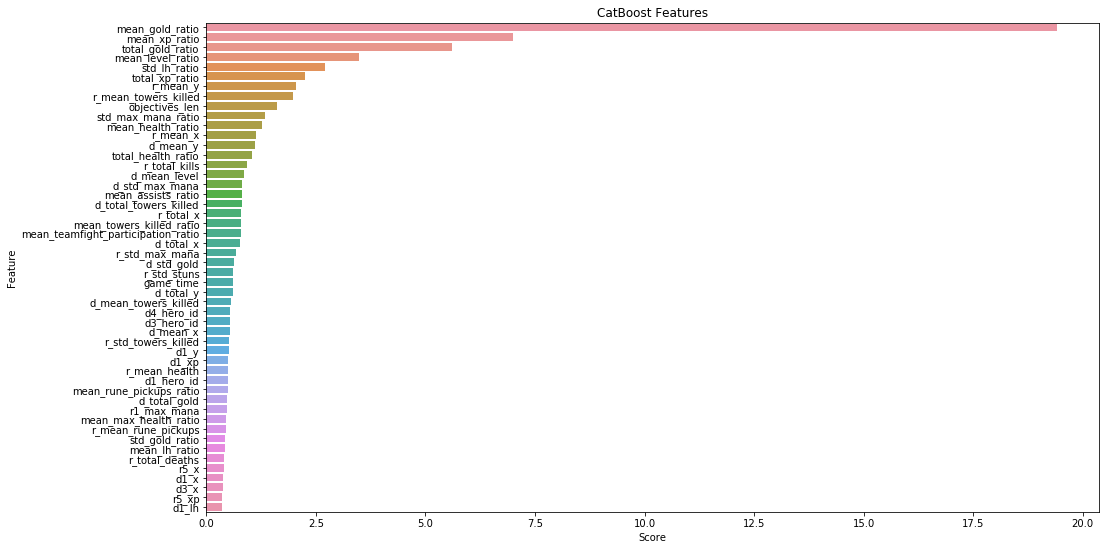

In [50]:
feature_importance_sns(cat_model_2, X, y, cat_cols_ind, figSize = (16,9))

#### Sybmission model 2

In [51]:
sub = pd.read_csv('../input/Dota_2/sample_submission.csv')
sub['radiant_win_prob'] = prediction_cat_2
sub.to_csv('submission_catBoost_model2.csv', index=False)
sub.head()

match_id_hash  radiant_win_prob
0  30cc2d778dca82f2edb568ce9b585caa          0.562010
1  70e5ba30f367cea48793b9003fab9d38          0.974557
2  4d9ef74d3a2025d79e9423105fd73d41          0.967287
3  2bb79e0c1eaac1608e5a09c8e0c6a555          0.797400
4  bec17f099b01d67edc82dfb5ce735a43          0.400699

#### Model 2 v 2. Drop useless features

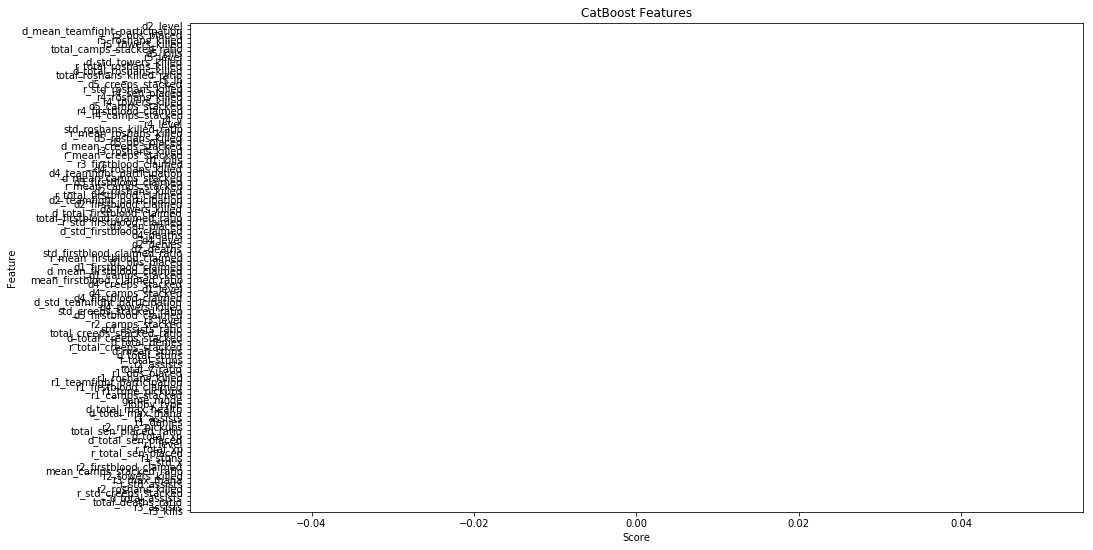

In [81]:
bad_1 = feature_importance_bad(cat_model_2, X, y, cat_cols_ind, figSize = (16,9), n=110)

In [82]:
train_df  = train_df.drop(bad_1, axis = 1)
test_df = test_df.drop(bad_1, axis = 1)
X = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test = test_df.copy().reset_index(drop=True)

In [83]:
%%time
oof_cat_2, prediction_cat_2, scores_cat_2, cat_model_2 = train_model(X,
                                                  X_test,
                                                  y,
                                                  params=params_cat,
                                                  cat_features=cat_cols_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state = RANDOM_STATE)

Fold 0 started at Wed Nov 13 08:33:31 2019
0:	learn: 0.8039632	test: 0.8000876	best: 0.8000876 (0)	total: 207ms	remaining: 3m 26s
500:	learn: 0.8700676	test: 0.8236288	best: 0.8238385 (458)	total: 1m 37s	remaining: 1m 36s
bestTest = 0.8238384724
bestIteration = 458
Shrink model to first 459 iterations.
Fold 1 started at Wed Nov 13 08:35:41 2019
0:	learn: 0.8063190	test: 0.7915308	best: 0.7915308 (0)	total: 204ms	remaining: 3m 23s
500:	learn: 0.8749483	test: 0.8148150	best: 0.8149669 (443)	total: 1m 38s	remaining: 1m 38s
bestTest = 0.815390408
bestIteration = 751
Shrink model to first 752 iterations.
Fold 2 started at Wed Nov 13 08:38:49 2019
0:	learn: 0.8029119	test: 0.8058361	best: 0.8058361 (0)	total: 207ms	remaining: 3m 26s
500:	learn: 0.8685411	test: 0.8274091	best: 0.8276647 (449)	total: 1m 38s	remaining: 1m 37s
999:	learn: 0.8902797	test: 0.8274668	best: 0.8278124 (807)	total: 3m 8s	remaining: 0us
bestTest = 0.8278124332
bestIteration = 807
Shrink model to first 808 iterations.
F

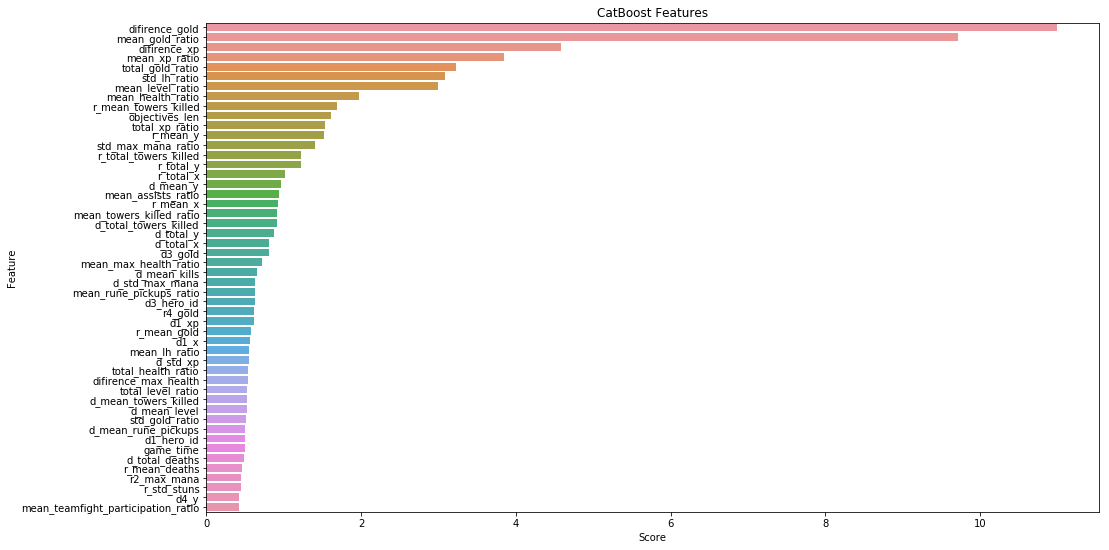

In [84]:
feature_importance_sns(cat_model_2, X, y, cat_cols_ind, figSize = (16,9))

### gold percent, kills percent and other, Model 3

#### gold percent, kills percent and other

Идея в том, что важен не разрыв по голде, а отношение

Считаем (голда света - голда тьмы) / (голда света + голда тьмы)

Если например 3\4 голды у одной тимы, второй, скорее всего, пизда.

In [26]:
for c in tqdm(['kills','gold', 'towers_killed', 'max_health', 'max_mana', 'level', 'roshans_killed']):
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train_df['difirence_' + c] = (train_df['r_total_' + c] - train_df['d_total_' + c]) / (train_df['r_total_' + c] + train_df['d_total_' + c])
    test_df['difirence_' + c] = (test_df['r_total_' + c] - test_df['d_total_' + c]) / (test_df['r_total_' + c] + test_df['d_total_' + c])

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 226.04it/s]


In [27]:
X3 = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test3 = test_df.copy().reset_index(drop=True)
X3.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies            ...             \
0         0          0           0          0            ...              
1         7          2           0          7            ...              
2         0          0           0          0            ...              
3         1          0           3          1            ...              
4         0          1           1          0            ...              

   r_mean_sen_placed  d_mean_sen_placed  mean_sen_placed_ratio  \
0                0.0                0.0                    NaN   
1                0.6                0.4                    1.5   
2                0.0                0.0                    NaN   
3                0.0                0.0                    NaN   
4                0.0                0.0                    NaN   

   difirence_kills  difirence_gold  difirence_towers_killed  \
0        -1.000000       -0.319298                      NaN   
1         0.684211        0.160557                      1.0   
2              NaN        0.294118                      NaN   
3         0.714286        0.083046                      NaN   
4        -0.333333       -0.063630                      NaN   

   difirence_max_health  difirence_max_mana  difirence_level  \
0              0.000000           -0.132659        -0.181818   
1              0.070248            0.041403         0.104478   
2             -0.003155            0.025788         0.000000   
3             -0.008403            0.081269         0.066667   
4              0.088785            0.093908        -0.019608   

   difirence_roshans_killed  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 459 columns]

#### Save

In [28]:
save_train_and_test_csv(3)

#### Model 3

In [114]:
oof_cat_3, prediction_cat_3, scores_cat_3, cat_model_3 = train_model(X3,
                                                  X_test3,
                                                  y,
                                                  params=params_cat,
                                                  cat_features=cat_cols_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state=RANDOM_STATE)

Fold 0 started at Wed Nov 13 09:32:57 2019
0:	learn: 0.8038437	test: 0.7996361	best: 0.7996361 (0)	total: 230ms	remaining: 3m 49s
500:	learn: 0.8734941	test: 0.8233171	best: 0.8235645 (398)	total: 1m 48s	remaining: 1m 48s
bestTest = 0.8235644698
bestIteration = 398
Shrink model to first 399 iterations.
Fold 1 started at Wed Nov 13 09:35:10 2019
0:	learn: 0.8079559	test: 0.7932032	best: 0.7932032 (0)	total: 229ms	remaining: 3m 48s
500:	learn: 0.8715804	test: 0.8144110	best: 0.8144110 (500)	total: 1m 46s	remaining: 1m 46s
bestTest = 0.8144162297
bestIteration = 529
Shrink model to first 530 iterations.
Fold 2 started at Wed Nov 13 09:37:49 2019
0:	learn: 0.8027997	test: 0.8072614	best: 0.8072614 (0)	total: 233ms	remaining: 3m 52s
500:	learn: 0.8653548	test: 0.8275172	best: 0.8276118 (475)	total: 1m 45s	remaining: 1m 45s
999:	learn: 0.8910971	test: 0.8283653	best: 0.8286263 (960)	total: 3m 27s	remaining: 0us
bestTest = 0.8286263347
bestIteration = 960
Shrink model to first 961 iterations.

#### Feature importance model 3

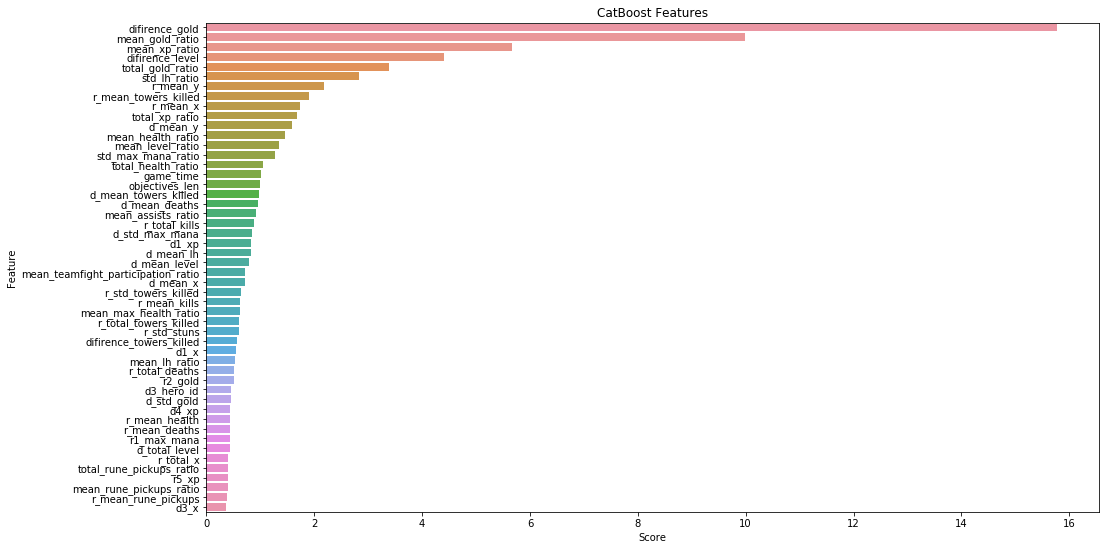

In [115]:
feature_importance_sns(cat_model_3, X3, y, cat_cols_ind, figSize = (16,9))

In [117]:
sub = pd.read_csv('../input/Dota_2/sample_submission.csv')
sub['radiant_win_prob'] = prediction_cat_3
sub.to_csv('submission_catBoost_model_3.csv', index=False)
sub.head()

match_id_hash  radiant_win_prob
0  30cc2d778dca82f2edb568ce9b585caa          0.539328
1  70e5ba30f367cea48793b9003fab9d38          0.977078
2  4d9ef74d3a2025d79e9423105fd73d41          0.967499
3  2bb79e0c1eaac1608e5a09c8e0c6a555          0.782583
4  bec17f099b01d67edc82dfb5ce735a43          0.395920

#### Model 3.1 with feature tuning (fix NaN)

Уберем NaN из значений, которые извользуется при расчете

In [111]:
train_df.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
a400b8f29dece5f4d266f49f1ae2e98a               1        11          11   
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
46a0ddce8f7ed2a8d9bd5edcbb925682               1         4          14   
b1b35ff97723d9b7ade1c9c3cf48f770               1         3          42   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
a400b8f29dece5f4d266f49f1ae2e98a         0          0           0          0   
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
46a0ddce8f7ed2a8d9bd5edcbb925682         1          0           3          1   
b1b35ff97723d9b7ade1c9c3cf48f770         0          1           1          0   

                                            ...             r_mean_sen_placed  \
match_id_hash                               ...                                 
a400b8f29dece5f4d266f49f1ae2e98a            ...                           0.0   
b9c57c450ce74a2af79c9ce96fac144d            ...                           0.6   
6db558535151ea18ca70a6892197db41            ...                           0.0   
46a0ddce8f7ed2a8d9bd5edcbb925682            ...                           0.0   
b1b35ff97723d9b7ade1c9c3cf48f770            ...                           0.0   

                                  d_mean_sen_placed  mean_sen_placed_ratio  \
match_id_hash                                                                
a400b8f29dece5f4d266f49f1ae2e98a                0.0                    NaN   
b9c57c450ce74a2af79c9ce96fac144d                0.4                    1.5   
6db558535151ea18ca70a6892197db41                0.0                    NaN   
46a0ddce8f7ed2a8d9bd5edcbb925682                0.0                    NaN   
b1b35ff97723d9b7ade1c9c3cf48f770                0.0                    NaN   

                                  difirence_kills  difirence_gold  \
match_id_hash                                                       
a400b8f29dece5f4d266f49f1ae2e98a        -1.000000       -0.319298   
b9c57c450ce74a2af79c9ce96fac144d         0.684211        0.160557   
6db558535151ea18ca70a6892197db41              NaN        0.294118   
46a0ddce8f7ed2a8d9bd5edcbb925682         0.714286        0.083046   
b1b35ff97723d9b7ade1c9c3cf48f770        -0.333333       -0.063630   

                                  difirence_towers_killed  \
match_id_hash                                               
a400b8f29dece5f4d266f49f1ae2e98a                      NaN   
b9c57c450ce74a2af79c9ce96fac144d                      1.0   
6db558535151ea18ca70a6892197db41                      NaN   
46a0ddce8f7ed2a8d9bd5edcbb925682                      NaN   
b1b35ff97723d9b7ade1c9c3cf48f770                      NaN   

                                  difirence_max_health  difirence_max_mana  \
match_id_hash                                                                
a400b8f29dece5f4d266f49f1ae2e98a              0.000000           -0.132659   
b9c57c450ce74a2af79c9ce96fac144d              0.070248            0.041403   
6db558535151ea18ca70a6892197db41             -0.003155            0.025788   
46a0ddce8f7ed2a8d9bd5edcbb925682             -

In [109]:
for c in tqdm(['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']):
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train_df['r_total_' + c] = train_df['r_total_' + c].fillna(0)
    train_df['d_total_' + c] = train_df['d_total_' + c].fillna(0)
    
#     test_df['r_total_' + c] = test_df[r_columns].sum(1)
#     test_df['d_total_' + c] = test_df[d_columns].sum(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 15.36it/s]


Пересчитаем значения для 3й модели без НаН

In [110]:
for c in tqdm(['kills','gold', 'towers_killed', 'max_health', 'max_mana', 'level', 'roshans_killed']):
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train_df['difirence_' + c] = (train_df['r_total_' + c] - train_df['d_total_' + c]) / (train_df['r_total_' + c] + train_df['d_total_' + c])
    test_df['difirence_' + c] = (test_df['r_total_' + c] - test_df['d_total_' + c]) / (test_df['r_total_' + c] + test_df['d_total_' + c])

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]


Запустим обучение и остальное заного

In [ ]:
X3_1 = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test3_1 = test_df.copy().reset_index(drop=True)

### Heroes_ID to categorical - model 4

https://www.kaggle.com/utapyngo/dota-2-how-to-make-use-of-hero-ids

to categorical

In [29]:
hero_columns = [c for c in train_df.columns if '_hero_' in c]
train_df[hero_columns]= train_df[hero_columns].astype('category')
test_df[hero_columns]= test_df[hero_columns].astype('category')

#### data for model 4

In [30]:
X4 = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test4 = test_df.copy().reset_index(drop=True)
X4.head()

game_time  game_mode  lobby_type  objectives_len  chat_len r1_hero_id  \
0        155         22           7               1        11         11   
1        658          4           0               3        10         15   
2         21         23           0               0         0        101   
3        576         22           7               1         4         14   
4        453         22           7               1         3         42   

   r1_kills  r1_deaths  r1_assists  r1_denies            ...             \
0         0          0           0          0            ...              
1         7          2           0          7            ...              
2         0          0           0          0            ...              
3         1          0           3          1            ...              
4         0          1           1          0            ...              

   r_mean_sen_placed  d_mean_sen_placed  mean_sen_placed_ratio  \
0                0.0                0.0                    NaN   
1                0.6                0.4                    1.5   
2                0.0                0.0                    NaN   
3                0.0                0.0                    NaN   
4                0.0                0.0                    NaN   

   difirence_kills  difirence_gold  difirence_towers_killed  \
0        -1.000000       -0.319298                      NaN   
1         0.684211        0.160557                      1.0   
2              NaN        0.294118                      NaN   
3         0.714286        0.083046                      NaN   
4        -0.333333       -0.063630                      NaN   

   difirence_max_health  difirence_max_mana  difirence_level  \
0              0.000000           -0.132659        -0.181818   
1              0.070248            0.041403         0.104478   
2             -0.003155            0.025788         0.000000   
3             -0.008403            0.081269         0.066667   
4              0.088785            0.093908        -0.019608   

   difirence_roshans_killed  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 459 columns]

#### Save

In [31]:
save_train_and_test_csv(4)

#### model 4

In [19]:
oof_cat_4, prediction_cat_4, scores_cat_4, cat_model_4 = train_model(X4,
                                                  X_test4,
                                                  y,
                                                  params=params_cat,
                                                  cat_features=col_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state=RANDOM_STATE)

Fold 0 started at Wed Nov 13 11:41:26 2019
0:	learn: 0.8051877	test: 0.8024078	best: 0.8024078 (0)	total: 396ms	remaining: 6m 35s
500:	learn: 0.8686193	test: 0.8235604	best: 0.8236393 (497)	total: 3m 2s	remaining: 3m 1s
bestTest = 0.82364434
bestIteration = 509
Shrink model to first 510 iterations.
Fold 1 started at Wed Nov 13 11:45:51 2019
0:	learn: 0.8078225	test: 0.7944507	best: 0.7944507 (0)	total: 395ms	remaining: 6m 34s
500:	learn: 0.8708820	test: 0.8135591	best: 0.8136705 (346)	total: 3m 7s	remaining: 3m 6s
bestTest = 0.8136704564
bestIteration = 346
Shrink model to first 347 iterations.
Fold 2 started at Wed Nov 13 11:49:24 2019
0:	learn: 0.8033893	test: 0.8072647	best: 0.8072647 (0)	total: 390ms	remaining: 6m 29s
500:	learn: 0.8674794	test: 0.8266718	best: 0.8266718 (500)	total: 3m 11s	remaining: 3m 10s
bestTest = 0.8268956542
bestIteration = 623
Shrink model to first 624 iterations.
Fold 3 started at Wed Nov 13 11:54:43 2019
0:	learn: 0.8021267	test: 0.8068317	best: 0.8068317

#### Feature importance model 4

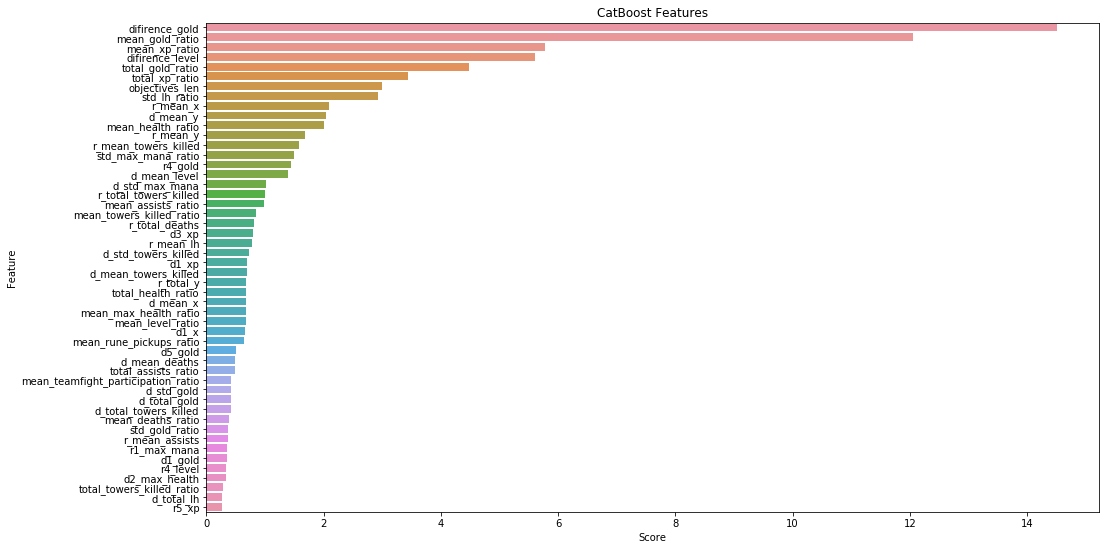

In [20]:
feature_importance_sns(cat_model_4, X4, y, col_ind, figSize = (16,9))

#### Попробуем one-hot encoding

### Tower kills - model 5

https://www.kaggle.com/vchulski/dota-2-catboost-and-shap-explainer

#### ad features

In [5]:
#a helper-generator function, we will use it in next cell
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            yield json.loads(line)

In [33]:
def add_new_features(df_features, matches_file):
    
    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Counting ruined towers for both teams
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Write new features
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills

In [12]:

for i in range(5):
    heroes_df = heroes_df.append({'A': i, 'B': i*2}, ignore_index=True)

A  B
0  0  0
1  1  2
2  2  4
3  3  6
4  4  8

In [ ]:
heroes_df = pd.DataFrame(columns=['hero_id','hero_name'])
for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    for players in match['players']:
#         hero = players['hero_name']
#         id = players['hero_id']
        heroes_df = heroes_df.append({'hero_id': players['hero_id'], 'hero_name': players['hero_name']}, ignore_index=True)



  0%|                                                                                        | 0/39675 [00:00<?, ?it/s]

  0%|                                                                                | 6/39675 [00:00<11:32, 57.27it/s]

  0%|                                                                               | 13/39675 [00:00<11:02, 59.84it/s]

  0%|                                                                               | 20/39675 [00:00<10:45, 61.47it/s]

  0%|                                                                               | 27/39675 [00:00<10:34, 62.48it/s]

  0%|                                                                               | 34/39675 [00:00<10:23, 63.55it/s]

  0%|                                                                               | 41/39675 [00:00<10:21, 63.80it/s]

  0%|                                                                               | 48/39675 [00:00<10:05, 65.41it/s]

  0%|                         

  1%|▉                                                                             | 447/39675 [00:07<11:49, 55.29it/s]

  1%|▉                                                                             | 453/39675 [00:07<13:00, 50.27it/s]

  1%|▉                                                                             | 459/39675 [00:07<13:14, 49.37it/s]

  1%|▉                                                                             | 465/39675 [00:07<12:43, 51.34it/s]

  1%|▉                                                                             | 471/39675 [00:08<12:23, 52.71it/s]

  1%|▉                                                                             | 477/39675 [00:08<13:27, 48.52it/s]

  1%|▉                                                                             | 483/39675 [00:08<13:06, 49.85it/s]

  1%|▉                                                                             | 490/39675 [00:08<12:20, 52.91it/s]

  1%|▉                          

  2%|█▋                                                                            | 854/39675 [00:14<11:49, 54.68it/s]

  2%|█▋                                                                            | 860/39675 [00:14<11:42, 55.29it/s]

  2%|█▋                                                                            | 866/39675 [00:15<11:48, 54.78it/s]

  2%|█▋                                                                            | 872/39675 [00:15<11:48, 54.75it/s]

  2%|█▋                                                                            | 878/39675 [00:15<11:48, 54.79it/s]

  2%|█▋                                                                            | 884/39675 [00:15<11:46, 54.91it/s]

  2%|█▋                                                                            | 890/39675 [00:15<11:29, 56.23it/s]

  2%|█▊                                                                            | 896/39675 [00:15<11:45, 55.00it/s]

  2%|█▊                         

  3%|██▍                                                                          | 1256/39675 [00:22<12:58, 49.35it/s]

  3%|██▍                                                                          | 1261/39675 [00:22<14:10, 45.16it/s]

  3%|██▍                                                                          | 1266/39675 [00:22<14:35, 43.86it/s]

  3%|██▍                                                                          | 1271/39675 [00:22<15:02, 42.55it/s]

  3%|██▍                                                                          | 1276/39675 [00:22<15:53, 40.28it/s]

  3%|██▍                                                                          | 1281/39675 [00:23<16:15, 39.38it/s]

  3%|██▍                                                                          | 1286/39675 [00:23<15:30, 41.25it/s]

  3%|██▌                                                                          | 1292/39675 [00:23<14:33, 43.95it/s]

  3%|██▌                        

  4%|███                                                                          | 1595/39675 [00:29<13:58, 45.44it/s]

  4%|███                                                                          | 1600/39675 [00:30<13:48, 45.97it/s]

  4%|███                                                                          | 1605/39675 [00:30<13:59, 45.36it/s]

  4%|███                                                                          | 1610/39675 [00:30<14:04, 45.05it/s]

  4%|███▏                                                                         | 1615/39675 [00:30<13:59, 45.33it/s]

  4%|███▏                                                                         | 1620/39675 [00:30<14:02, 45.16it/s]

  4%|███▏                                                                         | 1625/39675 [00:30<14:41, 43.18it/s]

  4%|███▏                                                                         | 1630/39675 [00:30<14:29, 43.76it/s]

  4%|███▏                       

  5%|███▋                                                                         | 1930/39675 [00:37<14:52, 42.28it/s]

  5%|███▊                                                                         | 1935/39675 [00:37<14:28, 43.44it/s]

  5%|███▊                                                                         | 1940/39675 [00:37<14:50, 42.39it/s]

  5%|███▊                                                                         | 1945/39675 [00:38<14:56, 42.10it/s]

  5%|███▊                                                                         | 1950/39675 [00:38<14:51, 42.32it/s]

  5%|███▊                                                                         | 1955/39675 [00:38<14:43, 42.69it/s]

  5%|███▊                                                                         | 1960/39675 [00:38<14:49, 42.41it/s]

  5%|███▊                                                                         | 1965/39675 [00:38<14:50, 42.33it/s]

  5%|███▊                       

  6%|████▎                                                                        | 2235/39675 [00:45<19:27, 32.07it/s]

  6%|████▎                                                                        | 2239/39675 [00:45<18:26, 33.83it/s]

  6%|████▎                                                                        | 2243/39675 [00:45<17:42, 35.22it/s]

  6%|████▎                                                                        | 2247/39675 [00:46<17:28, 35.70it/s]

  6%|████▎                                                                        | 2251/39675 [00:46<17:32, 35.54it/s]

  6%|████▍                                                                        | 2255/39675 [00:46<17:08, 36.40it/s]

  6%|████▍                                                                        | 2260/39675 [00:46<16:37, 37.52it/s]

  6%|████▍                                                                        | 2264/39675 [00:46<16:45, 37.19it/s]

  6%|████▍                      

  6%|████▊                                                                        | 2504/39675 [00:53<18:06, 34.21it/s]

  6%|████▊                                                                        | 2508/39675 [00:53<18:05, 34.23it/s]

  6%|████▉                                                                        | 2512/39675 [00:53<18:02, 34.34it/s]

  6%|████▉                                                                        | 2516/39675 [00:53<18:25, 33.63it/s]

  6%|████▉                                                                        | 2520/39675 [00:53<17:59, 34.43it/s]

  6%|████▉                                                                        | 2524/39675 [00:54<29:07, 21.26it/s]

  6%|████▉                                                                        | 2527/39675 [00:54<35:45, 17.31it/s]

  6%|████▉                                                                        | 2530/39675 [00:54<37:52, 16.35it/s]

  6%|████▉                      

  7%|█████▎                                                                       | 2769/39675 [01:01<18:46, 32.75it/s]

  7%|█████▍                                                                       | 2773/39675 [01:02<19:07, 32.15it/s]

  7%|█████▍                                                                       | 2777/39675 [01:02<19:22, 31.75it/s]

  7%|█████▍                                                                       | 2781/39675 [01:02<19:07, 32.15it/s]

  7%|█████▍                                                                       | 2785/39675 [01:02<18:52, 32.57it/s]

  7%|█████▍                                                                       | 2789/39675 [01:02<19:08, 32.11it/s]

  7%|█████▍                                                                       | 2793/39675 [01:02<19:09, 32.08it/s]

  7%|█████▍                                                                       | 2797/39675 [01:02<18:58, 32.39it/s]

  7%|█████▍                     

  8%|█████▉                                                                       | 3037/39675 [01:10<19:30, 31.30it/s]

  8%|█████▉                                                                       | 3041/39675 [01:10<19:13, 31.75it/s]

  8%|█████▉                                                                       | 3045/39675 [01:10<19:37, 31.11it/s]

  8%|█████▉                                                                       | 3049/39675 [01:10<20:48, 29.33it/s]

  8%|█████▉                                                                       | 3053/39675 [01:10<20:17, 30.09it/s]

  8%|█████▉                                                                       | 3057/39675 [01:10<19:58, 30.55it/s]

  8%|█████▉                                                                       | 3061/39675 [01:11<19:57, 30.57it/s]

  8%|█████▉                                                                       | 3065/39675 [01:11<20:13, 30.17it/s]

  8%|█████▉                     

  8%|██████▎                                                                      | 3270/39675 [01:18<21:29, 28.22it/s]

  8%|██████▎                                                                      | 3273/39675 [01:18<21:09, 28.67it/s]

  8%|██████▎                                                                      | 3276/39675 [01:18<21:24, 28.34it/s]

  8%|██████▎                                                                      | 3279/39675 [01:18<21:05, 28.76it/s]

  8%|██████▎                                                                      | 3282/39675 [01:18<20:56, 28.97it/s]

  8%|██████▍                                                                      | 3285/39675 [01:18<20:56, 28.96it/s]

  8%|██████▍                                                                      | 3288/39675 [01:18<20:48, 29.15it/s]

  8%|██████▍                                                                      | 3291/39675 [01:19<21:05, 28.75it/s]

  8%|██████▍                    

  9%|██████▋                                                                      | 3472/39675 [01:25<22:54, 26.34it/s]

  9%|██████▋                                                                      | 3475/39675 [01:25<22:38, 26.64it/s]

  9%|██████▋                                                                      | 3478/39675 [01:25<24:02, 25.10it/s]

  9%|██████▊                                                                      | 3481/39675 [01:25<23:26, 25.73it/s]

  9%|██████▊                                                                      | 3484/39675 [01:26<23:55, 25.21it/s]

  9%|██████▊                                                                      | 3487/39675 [01:26<25:35, 23.57it/s]

  9%|██████▊                                                                      | 3490/39675 [01:26<24:24, 24.71it/s]

  9%|██████▊                                                                      | 3493/39675 [01:26<23:52, 25.25it/s]

  9%|██████▊                    

  9%|███████▏                                                                     | 3690/39675 [01:34<35:12, 17.03it/s]

  9%|███████▏                                                                     | 3692/39675 [01:34<42:51, 13.99it/s]

  9%|███████▏                                                                     | 3694/39675 [01:34<41:56, 14.30it/s]

  9%|███████▏                                                                     | 3696/39675 [01:35<45:56, 13.05it/s]

  9%|███████▏                                                                     | 3698/39675 [01:35<50:43, 11.82it/s]

  9%|███████▏                                                                     | 3700/39675 [01:35<46:43, 12.83it/s]

  9%|███████▏                                                                     | 3703/39675 [01:35<39:24, 15.22it/s]

  9%|███████▏                                                                     | 3706/39675 [01:35<33:58, 17.64it/s]

  9%|███████▏                   

 10%|███████▌                                                                     | 3900/39675 [01:43<21:43, 27.45it/s]

 10%|███████▌                                                                     | 3903/39675 [01:44<23:10, 25.73it/s]

 10%|███████▌                                                                     | 3906/39675 [01:44<23:57, 24.89it/s]

 10%|███████▌                                                                     | 3909/39675 [01:44<23:53, 24.94it/s]

 10%|███████▌                                                                     | 3912/39675 [01:44<23:44, 25.11it/s]

 10%|███████▌                                                                     | 3915/39675 [01:44<23:23, 25.48it/s]

 10%|███████▌                                                                     | 3918/39675 [01:44<23:01, 25.88it/s]

 10%|███████▌                                                                     | 3921/39675 [01:44<22:43, 26.23it/s]

 10%|███████▌                   

 10%|███████▉                                                                     | 4092/39675 [01:52<31:05, 19.07it/s]

 10%|███████▉                                                                     | 4094/39675 [01:52<33:07, 17.91it/s]

 10%|███████▉                                                                     | 4096/39675 [01:52<35:29, 16.71it/s]

 10%|███████▉                                                                     | 4098/39675 [01:52<38:03, 15.58it/s]

 10%|███████▉                                                                     | 4100/39675 [01:53<36:18, 16.33it/s]

 10%|███████▉                                                                     | 4102/39675 [01:53<34:48, 17.03it/s]

 10%|███████▉                                                                     | 4105/39675 [01:53<32:06, 18.46it/s]

 10%|███████▉                                                                     | 4107/39675 [01:53<32:30, 18.24it/s]

 10%|███████▉                   

 11%|████████▎                                                                    | 4254/39675 [02:01<30:38, 19.27it/s]

 11%|████████▎                                                                    | 4256/39675 [02:01<31:04, 19.00it/s]

 11%|████████▎                                                                    | 4258/39675 [02:01<31:16, 18.87it/s]

 11%|████████▎                                                                    | 4260/39675 [02:01<30:48, 19.16it/s]

 11%|████████▎                                                                    | 4262/39675 [02:01<30:55, 19.08it/s]

 11%|████████▎                                                                    | 4264/39675 [02:01<31:16, 18.87it/s]

 11%|████████▎                                                                    | 4266/39675 [02:01<31:30, 18.73it/s]

 11%|████████▎                                                                    | 4268/39675 [02:01<31:35, 18.68it/s]

 11%|████████▎                  

 11%|████████▌                                                                    | 4395/39675 [02:08<31:42, 18.54it/s]

 11%|████████▌                                                                    | 4398/39675 [02:09<30:48, 19.08it/s]

 11%|████████▌                                                                    | 4400/39675 [02:09<30:53, 19.03it/s]

 11%|████████▌                                                                    | 4402/39675 [02:09<30:35, 19.21it/s]

 11%|████████▌                                                                    | 4404/39675 [02:09<30:39, 19.18it/s]

 11%|████████▌                                                                    | 4406/39675 [02:09<30:30, 19.27it/s]

 11%|████████▌                                                                    | 4408/39675 [02:09<31:28, 18.68it/s]

 11%|████████▌                                                                    | 4410/39675 [02:09<31:36, 18.59it/s]

 11%|████████▌                  

 11%|████████▊                                                                    | 4532/39675 [02:17<40:19, 14.52it/s]

 11%|████████▊                                                                    | 4534/39675 [02:17<38:55, 15.05it/s]

 11%|████████▊                                                                    | 4536/39675 [02:17<37:40, 15.55it/s]

 11%|████████▊                                                                    | 4538/39675 [02:17<36:26, 16.07it/s]

 11%|████████▊                                                                    | 4540/39675 [02:17<35:24, 16.54it/s]

 11%|████████▊                                                                    | 4542/39675 [02:17<35:08, 16.66it/s]

 11%|████████▊                                                                    | 4544/39675 [02:17<35:17, 16.59it/s]

 11%|████████▊                                                                    | 4546/39675 [02:18<35:44, 16.38it/s]

 11%|████████▊                  

 12%|█████████                                                                    | 4668/39675 [02:24<32:44, 17.82it/s]

 12%|█████████                                                                    | 4670/39675 [02:25<33:59, 17.16it/s]

 12%|█████████                                                                    | 4672/39675 [02:25<34:12, 17.05it/s]

 12%|█████████                                                                    | 4674/39675 [02:25<34:14, 17.03it/s]

 12%|█████████                                                                    | 4676/39675 [02:25<33:02, 17.65it/s]

 12%|█████████                                                                    | 4678/39675 [02:25<33:15, 17.54it/s]

 12%|█████████                                                                    | 4680/39675 [02:25<33:19, 17.50it/s]

 12%|█████████                                                                    | 4682/39675 [02:25<33:16, 17.53it/s]

 12%|█████████                  

 12%|█████████▎                                                                   | 4802/39675 [02:33<39:14, 14.81it/s]

 12%|█████████▎                                                                   | 4804/39675 [02:33<37:44, 15.40it/s]

 12%|█████████▎                                                                   | 4806/39675 [02:33<41:48, 13.90it/s]

 12%|█████████▎                                                                   | 4808/39675 [02:34<46:49, 12.41it/s]

 12%|█████████▎                                                                   | 4810/39675 [02:34<48:25, 12.00it/s]

 12%|█████████▎                                                                   | 4812/39675 [02:34<47:11, 12.31it/s]

 12%|█████████▎                                                                   | 4814/39675 [02:34<45:43, 12.71it/s]

 12%|█████████▎                                                                   | 4816/39675 [02:34<42:52, 13.55it/s]

 12%|█████████▎                 

 12%|█████████▌                                                                   | 4936/39675 [02:42<39:01, 14.84it/s]

 12%|█████████▌                                                                   | 4938/39675 [02:42<38:55, 14.87it/s]

 12%|█████████▌                                                                   | 4940/39675 [02:42<37:32, 15.42it/s]

 12%|█████████▌                                                                   | 4942/39675 [02:42<36:45, 15.75it/s]

 12%|█████████▌                                                                   | 4944/39675 [02:42<37:09, 15.58it/s]

 12%|█████████▌                                                                   | 4946/39675 [02:42<39:05, 14.81it/s]

 12%|█████████▌                                                                   | 4948/39675 [02:42<37:50, 15.30it/s]

 12%|█████████▌                                                                   | 4950/39675 [02:43<38:05, 15.20it/s]

 12%|█████████▌                 

 13%|█████████▊                                                                   | 5070/39675 [02:51<40:49, 14.13it/s]

 13%|█████████▊                                                                   | 5072/39675 [02:51<39:26, 14.62it/s]

 13%|█████████▊                                                                   | 5074/39675 [02:51<40:53, 14.10it/s]

 13%|█████████▊                                                                   | 5076/39675 [02:51<40:06, 14.38it/s]

 13%|█████████▊                                                                   | 5078/39675 [02:51<38:25, 15.01it/s]

 13%|█████████▊                                                                   | 5080/39675 [02:51<37:04, 15.55it/s]

 13%|█████████▊                                                                   | 5082/39675 [02:51<36:33, 15.77it/s]

 13%|█████████▊                                                                   | 5084/39675 [02:52<39:02, 14.77it/s]

 13%|█████████▊                 

 13%|██████████                                                                   | 5204/39675 [02:59<38:19, 14.99it/s]

 13%|██████████                                                                   | 5206/39675 [03:00<37:49, 15.19it/s]

 13%|██████████                                                                   | 5208/39675 [03:00<37:54, 15.15it/s]

 13%|██████████                                                                   | 5210/39675 [03:00<38:02, 15.10it/s]

 13%|██████████                                                                   | 5212/39675 [03:00<37:42, 15.23it/s]

 13%|██████████                                                                   | 5214/39675 [03:00<37:39, 15.25it/s]

 13%|██████████                                                                   | 5216/39675 [03:00<37:36, 15.27it/s]

 13%|██████████▏                                                                  | 5218/39675 [03:00<37:24, 15.35it/s]

 13%|██████████▏                

 13%|██████████▎                                                                  | 5338/39675 [03:08<37:44, 15.16it/s]

 13%|██████████▎                                                                  | 5340/39675 [03:09<38:34, 14.84it/s]

 13%|██████████▎                                                                  | 5342/39675 [03:09<38:12, 14.97it/s]

 13%|██████████▎                                                                  | 5344/39675 [03:09<38:18, 14.94it/s]

 13%|██████████▍                                                                  | 5346/39675 [03:09<37:40, 15.18it/s]

 13%|██████████▍                                                                  | 5348/39675 [03:09<37:54, 15.09it/s]

 13%|██████████▍                                                                  | 5350/39675 [03:09<37:44, 15.16it/s]

 13%|██████████▍                                                                  | 5352/39675 [03:09<37:27, 15.27it/s]

 13%|██████████▍                

 14%|██████████▌                                                                  | 5472/39675 [03:18<39:05, 14.59it/s]

 14%|██████████▌                                                                  | 5474/39675 [03:18<39:12, 14.54it/s]

 14%|██████████▋                                                                  | 5476/39675 [03:18<39:02, 14.60it/s]

 14%|██████████▋                                                                  | 5478/39675 [03:18<38:40, 14.74it/s]

 14%|██████████▋                                                                  | 5480/39675 [03:18<38:54, 14.65it/s]

 14%|██████████▋                                                                  | 5482/39675 [03:18<38:55, 14.64it/s]

 14%|██████████▋                                                                  | 5484/39675 [03:18<38:29, 14.80it/s]

 14%|██████████▋                                                                  | 5486/39675 [03:18<38:16, 14.89it/s]

 14%|██████████▋                

 14%|██████████▉                                                                  | 5606/39675 [03:27<39:35, 14.34it/s]

 14%|██████████▉                                                                  | 5608/39675 [03:27<39:21, 14.43it/s]

 14%|██████████▉                                                                  | 5610/39675 [03:27<39:51, 14.24it/s]

 14%|██████████▉                                                                  | 5612/39675 [03:27<39:47, 14.27it/s]

 14%|██████████▉                                                                  | 5614/39675 [03:27<39:34, 14.35it/s]

 14%|██████████▉                                                                  | 5616/39675 [03:28<39:29, 14.37it/s]

 14%|██████████▉                                                                  | 5618/39675 [03:28<39:42, 14.30it/s]

 14%|██████████▉                                                                  | 5620/39675 [03:28<39:35, 14.33it/s]

 14%|██████████▉                

 14%|███████████▏                                                                 | 5740/39675 [03:36<40:09, 14.08it/s]

 14%|███████████▏                                                                 | 5742/39675 [03:37<40:17, 14.03it/s]

 14%|███████████▏                                                                 | 5744/39675 [03:37<40:58, 13.80it/s]

 14%|███████████▏                                                                 | 5746/39675 [03:37<42:23, 13.34it/s]

 14%|███████████▏                                                                 | 5748/39675 [03:37<41:45, 13.54it/s]

 14%|███████████▏                                                                 | 5750/39675 [03:37<41:50, 13.51it/s]

 14%|███████████▏                                                                 | 5752/39675 [03:37<41:17, 13.69it/s]

 15%|███████████▏                                                                 | 5754/39675 [03:37<40:50, 13.84it/s]

 15%|███████████▏               

 15%|███████████▍                                                                 | 5874/39675 [03:46<42:06, 13.38it/s]

 15%|███████████▍                                                                 | 5876/39675 [03:46<41:51, 13.46it/s]

 15%|███████████▍                                                                 | 5878/39675 [03:46<41:46, 13.48it/s]

 15%|███████████▍                                                                 | 5880/39675 [03:47<42:23, 13.29it/s]

 15%|███████████▍                                                                 | 5882/39675 [03:47<42:18, 13.31it/s]

 15%|███████████▍                                                                 | 5884/39675 [03:47<42:10, 13.36it/s]

 15%|███████████▍                                                                 | 5886/39675 [03:47<41:48, 13.47it/s]

 15%|███████████▍                                                                 | 5888/39675 [03:47<41:29, 13.57it/s]

 15%|███████████▍               

 15%|███████████▋                                                                 | 6008/39675 [03:56<41:33, 13.50it/s]

 15%|███████████▋                                                                 | 6010/39675 [03:56<44:52, 12.50it/s]

 15%|███████████▋                                                                 | 6012/39675 [03:57<47:46, 11.74it/s]

 15%|███████████▋                                                                 | 6014/39675 [03:57<46:06, 12.17it/s]

 15%|███████████▋                                                                 | 6016/39675 [03:57<44:24, 12.63it/s]

 15%|███████████▋                                                                 | 6018/39675 [03:57<44:04, 12.72it/s]

 15%|███████████▋                                                                 | 6020/39675 [03:57<42:58, 13.05it/s]

 15%|███████████▋                                                                 | 6022/39675 [03:57<42:26, 13.21it/s]

 15%|███████████▋               

 15%|███████████▉                                                                 | 6142/39675 [04:07<47:45, 11.70it/s]

 15%|███████████▉                                                                 | 6144/39675 [04:07<47:23, 11.79it/s]

 15%|███████████▉                                                                 | 6146/39675 [04:08<47:47, 11.69it/s]

 15%|███████████▉                                                                 | 6148/39675 [04:08<47:30, 11.76it/s]

 16%|███████████▉                                                                 | 6150/39675 [04:08<47:12, 11.84it/s]

 16%|███████████▉                                                                 | 6152/39675 [04:08<47:40, 11.72it/s]

 16%|███████████▉                                                                 | 6154/39675 [04:08<47:19, 11.81it/s]

 16%|███████████▉                                                                 | 6156/39675 [04:08<46:54, 11.91it/s]

 16%|███████████▉               

 16%|████████████▏                                                                | 6276/39675 [04:19<48:49, 11.40it/s]

 16%|████████████▏                                                                | 6278/39675 [04:19<48:10, 11.55it/s]

 16%|████████████▏                                                                | 6280/39675 [04:19<48:42, 11.43it/s]

 16%|████████████▏                                                                | 6282/39675 [04:19<48:04, 11.58it/s]

 16%|████████████▏                                                                | 6284/39675 [04:19<47:33, 11.70it/s]

 16%|████████████▏                                                                | 6286/39675 [04:20<48:06, 11.57it/s]

 16%|████████████▏                                                                | 6288/39675 [04:20<48:04, 11.58it/s]

 16%|████████████▏                                                                | 6290/39675 [04:20<47:43, 11.66it/s]

 16%|████████████▏              

 16%|████████████▍                                                                | 6410/39675 [04:31<50:02, 11.08it/s]

 16%|████████████▍                                                                | 6412/39675 [04:31<49:47, 11.13it/s]

 16%|████████████▍                                                                | 6414/39675 [04:31<49:56, 11.10it/s]

 16%|████████████▍                                                                | 6416/39675 [04:31<49:28, 11.20it/s]

 16%|████████████▍                                                                | 6418/39675 [04:31<49:38, 11.17it/s]

 16%|████████████▍                                                                | 6420/39675 [04:31<49:15, 11.25it/s]

 16%|████████████▍                                                                | 6422/39675 [04:32<48:59, 11.31it/s]

 16%|████████████▍                                                                | 6424/39675 [04:32<49:17, 11.24it/s]

 16%|████████████▍              

 16%|████████████▋                                                                | 6544/39675 [04:43<50:00, 11.04it/s]

 16%|████████████▋                                                                | 6546/39675 [04:43<49:57, 11.05it/s]

 17%|████████████▋                                                                | 6548/39675 [04:43<49:30, 11.15it/s]

 17%|████████████▋                                                                | 6550/39675 [04:43<49:50, 11.07it/s]

 17%|████████████▋                                                                | 6552/39675 [04:43<49:50, 11.08it/s]

 17%|████████████▋                                                                | 6554/39675 [04:43<49:20, 11.19it/s]

 17%|████████████▋                                                                | 6556/39675 [04:44<49:38, 11.12it/s]

 17%|████████████▋                                                                | 6558/39675 [04:44<49:21, 11.18it/s]

 17%|████████████▋              

 17%|████████████▌                                                              | 6673/39675 [04:55<1:07:00,  8.21it/s]

 17%|████████████▌                                                              | 6675/39675 [04:55<1:01:47,  8.90it/s]

 17%|████████████▉                                                                | 6677/39675 [04:55<57:58,  9.49it/s]

 17%|████████████▉                                                                | 6679/39675 [04:56<55:43,  9.87it/s]

 17%|████████████▉                                                                | 6681/39675 [04:56<53:53, 10.20it/s]

 17%|████████████▉                                                                | 6683/39675 [04:56<52:36, 10.45it/s]

 17%|████████████▉                                                                | 6685/39675 [04:56<52:12, 10.53it/s]

 17%|████████████▉                                                                | 6687/39675 [04:56<51:06, 10.76it/s]

 17%|████████████▉              

 17%|█████████████▏                                                               | 6785/39675 [05:06<56:10,  9.76it/s]

 17%|█████████████▏                                                               | 6786/39675 [05:06<56:52,  9.64it/s]

 17%|█████████████▏                                                               | 6787/39675 [05:06<56:22,  9.72it/s]

 17%|█████████████▏                                                               | 6789/39675 [05:06<54:27, 10.06it/s]

 17%|█████████████▏                                                               | 6791/39675 [05:07<53:17, 10.28it/s]

 17%|█████████████▏                                                               | 6793/39675 [05:07<52:47, 10.38it/s]

 17%|█████████████▏                                                               | 6795/39675 [05:07<52:12, 10.50it/s]

 17%|█████████████▏                                                               | 6797/39675 [05:07<52:11, 10.50it/s]

 17%|█████████████▏             

 17%|█████████████▍                                                               | 6917/39675 [05:18<53:26, 10.21it/s]

 17%|█████████████▍                                                               | 6919/39675 [05:19<53:30, 10.20it/s]

 17%|█████████████▍                                                               | 6921/39675 [05:19<52:38, 10.37it/s]

 17%|█████████████▍                                                               | 6923/39675 [05:19<52:36, 10.38it/s]

 17%|█████████████▍                                                               | 6925/39675 [05:19<52:10, 10.46it/s]

 17%|█████████████▍                                                               | 6927/39675 [05:19<51:56, 10.51it/s]

 17%|█████████████▍                                                               | 6929/39675 [05:20<51:57, 10.50it/s]

 17%|█████████████▍                                                               | 6931/39675 [05:20<51:18, 10.64it/s]

 17%|█████████████▍             

 18%|█████████████▋                                                               | 7045/39675 [05:31<58:04,  9.36it/s]

 18%|█████████████▋                                                               | 7046/39675 [05:31<57:34,  9.45it/s]

 18%|█████████████▋                                                               | 7047/39675 [05:31<58:11,  9.35it/s]

 18%|█████████████▋                                                               | 7048/39675 [05:31<59:17,  9.17it/s]

 18%|█████████████▋                                                               | 7049/39675 [05:31<58:34,  9.28it/s]

 18%|█████████████▋                                                               | 7050/39675 [05:31<58:05,  9.36it/s]

 18%|█████████████▋                                                               | 7051/39675 [05:31<57:54,  9.39it/s]

 18%|█████████████▋                                                               | 7052/39675 [05:32<58:35,  9.28it/s]

 18%|█████████████▋             

 18%|█████████████▊                                                               | 7112/39675 [05:38<57:52,  9.38it/s]

 18%|█████████████▊                                                               | 7113/39675 [05:38<58:02,  9.35it/s]

 18%|█████████████▊                                                               | 7114/39675 [05:38<59:27,  9.13it/s]

 18%|█████████████▊                                                               | 7115/39675 [05:38<58:30,  9.28it/s]

 18%|█████████████▊                                                               | 7116/39675 [05:38<57:50,  9.38it/s]

 18%|█████████████▊                                                               | 7117/39675 [05:38<57:42,  9.40it/s]

 18%|█████████████▊                                                               | 7118/39675 [05:39<57:45,  9.40it/s]

 18%|█████████████▊                                                               | 7119/39675 [05:39<57:28,  9.44it/s]

 18%|█████████████▊             

 18%|█████████████▉                                                               | 7179/39675 [05:45<58:40,  9.23it/s]

 18%|█████████████▉                                                               | 7180/39675 [05:45<58:15,  9.30it/s]

 18%|█████████████▉                                                               | 7181/39675 [05:45<57:37,  9.40it/s]

 18%|█████████████▉                                                               | 7182/39675 [05:45<57:01,  9.50it/s]

 18%|█████████████▉                                                               | 7183/39675 [05:45<57:05,  9.49it/s]

 18%|█████████████▉                                                               | 7184/39675 [05:46<58:16,  9.29it/s]

 18%|█████████████▉                                                               | 7185/39675 [05:46<58:26,  9.27it/s]

 18%|█████████████▉                                                               | 7186/39675 [05:46<58:05,  9.32it/s]

 18%|█████████████▉             

 18%|██████████████                                                               | 7247/39675 [05:52<59:23,  9.10it/s]

 18%|█████████████▋                                                             | 7248/39675 [05:53<1:00:00,  9.01it/s]

 18%|██████████████                                                               | 7249/39675 [05:53<59:37,  9.06it/s]

 18%|██████████████                                                               | 7250/39675 [05:53<58:43,  9.20it/s]

 18%|██████████████                                                               | 7251/39675 [05:53<57:55,  9.33it/s]

 18%|██████████████                                                               | 7252/39675 [05:53<57:31,  9.40it/s]

 18%|██████████████                                                               | 7253/39675 [05:53<58:12,  9.28it/s]

 18%|██████████████                                                               | 7254/39675 [05:53<57:52,  9.34it/s]

 18%|██████████████             

 18%|██████████████▏                                                              | 7314/39675 [06:00<59:04,  9.13it/s]

 18%|██████████████▏                                                              | 7315/39675 [06:00<59:15,  9.10it/s]

 18%|██████████████▏                                                              | 7316/39675 [06:00<59:33,  9.06it/s]

 18%|██████████████▏                                                              | 7317/39675 [06:00<59:55,  9.00it/s]

 18%|██████████████▏                                                              | 7318/39675 [06:00<59:31,  9.06it/s]

 18%|██████████████▏                                                              | 7319/39675 [06:00<58:46,  9.18it/s]

 18%|██████████████▏                                                              | 7320/39675 [06:00<58:33,  9.21it/s]

 18%|██████████████▏                                                              | 7321/39675 [06:01<58:54,  9.15it/s]

 18%|██████████████▏            

 19%|██████████████▎                                                              | 7381/39675 [06:07<59:35,  9.03it/s]

 19%|██████████████▎                                                              | 7382/39675 [06:07<59:37,  9.03it/s]

 19%|██████████████▎                                                              | 7383/39675 [06:07<59:00,  9.12it/s]

 19%|██████████████▎                                                              | 7384/39675 [06:08<58:42,  9.17it/s]

 19%|██████████████▎                                                              | 7385/39675 [06:08<59:21,  9.07it/s]

 19%|██████████████▎                                                              | 7386/39675 [06:08<58:27,  9.21it/s]

 19%|██████████████▎                                                              | 7387/39675 [06:08<57:51,  9.30it/s]

 19%|██████████████▎                                                              | 7388/39675 [06:08<57:24,  9.37it/s]

 19%|██████████████▎            

 19%|██████████████                                                             | 7448/39675 [06:15<1:02:13,  8.63it/s]

 19%|██████████████                                                             | 7449/39675 [06:15<1:01:23,  8.75it/s]

 19%|██████████████                                                             | 7450/39675 [06:15<1:00:48,  8.83it/s]

 19%|██████████████▍                                                              | 7451/39675 [06:15<59:45,  8.99it/s]

 19%|██████████████                                                             | 7452/39675 [06:15<1:00:47,  8.83it/s]

 19%|██████████████                                                             | 7453/39675 [06:15<1:00:13,  8.92it/s]

 19%|██████████████▍                                                              | 7454/39675 [06:15<59:30,  9.02it/s]

 19%|██████████████▍                                                              | 7455/39675 [06:15<59:39,  9.00it/s]

 19%|██████████████▍            

 19%|██████████████▌                                                              | 7515/39675 [06:22<59:28,  9.01it/s]

 19%|██████████████▌                                                              | 7516/39675 [06:22<59:26,  9.02it/s]

 19%|██████████████▌                                                              | 7517/39675 [06:22<59:23,  9.02it/s]

 19%|██████████████▌                                                              | 7518/39675 [06:22<59:13,  9.05it/s]

 19%|██████████████▏                                                            | 7519/39675 [06:23<1:00:02,  8.92it/s]

 19%|██████████████▌                                                              | 7520/39675 [06:23<58:52,  9.10it/s]

 19%|██████████████▌                                                              | 7521/39675 [06:23<58:41,  9.13it/s]

 19%|██████████████▌                                                              | 7522/39675 [06:23<58:52,  9.10it/s]

 19%|██████████████▌            

 19%|██████████████▎                                                            | 7582/39675 [06:30<1:01:05,  8.75it/s]

 19%|██████████████▎                                                            | 7583/39675 [06:30<1:00:41,  8.81it/s]

 19%|██████████████▎                                                            | 7584/39675 [06:30<1:00:14,  8.88it/s]

 19%|██████████████▎                                                            | 7585/39675 [06:30<1:01:03,  8.76it/s]

 19%|██████████████▎                                                            | 7586/39675 [06:30<1:03:22,  8.44it/s]

 19%|██████████████▎                                                            | 7587/39675 [06:30<1:02:36,  8.54it/s]

 19%|██████████████▎                                                            | 7588/39675 [06:30<1:01:15,  8.73it/s]

 19%|██████████████▎                                                            | 7589/39675 [06:31<1:00:57,  8.77it/s]

 19%|██████████████▎            

 19%|██████████████▊                                                              | 7649/39675 [06:37<59:55,  8.91it/s]

 19%|██████████████▊                                                              | 7650/39675 [06:37<59:40,  8.94it/s]

 19%|██████████████▊                                                              | 7651/39675 [06:38<59:39,  8.95it/s]

 19%|██████████████▍                                                            | 7652/39675 [06:38<1:00:37,  8.80it/s]

 19%|██████████████▍                                                            | 7653/39675 [06:38<1:00:19,  8.85it/s]

 19%|██████████████▊                                                              | 7654/39675 [06:38<59:56,  8.90it/s]

 19%|██████████████▊                                                              | 7655/39675 [06:38<59:31,  8.97it/s]

 19%|██████████████▍                                                            | 7656/39675 [06:38<1:00:43,  8.79it/s]

 19%|██████████████▍            

 19%|██████████████▌                                                            | 7716/39675 [06:45<1:01:07,  8.71it/s]

 19%|██████████████▌                                                            | 7717/39675 [06:45<1:01:35,  8.65it/s]

 19%|██████████████▌                                                            | 7718/39675 [06:45<1:00:57,  8.74it/s]

 19%|██████████████▌                                                            | 7719/39675 [06:45<1:00:50,  8.75it/s]

 19%|██████████████▌                                                            | 7720/39675 [06:45<1:00:46,  8.76it/s]

 19%|██████████████▌                                                            | 7721/39675 [06:46<1:00:42,  8.77it/s]

 19%|██████████████▌                                                            | 7722/39675 [06:46<1:01:36,  8.64it/s]

 19%|██████████████▌                                                            | 7723/39675 [06:46<1:01:46,  8.62it/s]

 19%|██████████████▌            

 20%|██████████████▋                                                            | 7783/39675 [06:53<1:02:25,  8.51it/s]

 20%|██████████████▋                                                            | 7784/39675 [06:53<1:02:18,  8.53it/s]

 20%|██████████████▋                                                            | 7785/39675 [06:53<1:01:36,  8.63it/s]

 20%|██████████████▋                                                            | 7786/39675 [06:53<1:00:56,  8.72it/s]

 20%|██████████████▋                                                            | 7787/39675 [06:53<1:01:34,  8.63it/s]

 20%|██████████████▋                                                            | 7788/39675 [06:53<1:03:27,  8.37it/s]

 20%|██████████████▋                                                            | 7789/39675 [06:53<1:02:22,  8.52it/s]

 20%|██████████████▋                                                            | 7790/39675 [06:54<1:01:38,  8.62it/s]

 20%|██████████████▋            

 20%|██████████████▊                                                            | 7850/39675 [07:00<1:02:04,  8.54it/s]

 20%|██████████████▊                                                            | 7851/39675 [07:01<1:03:07,  8.40it/s]

 20%|██████████████▊                                                            | 7852/39675 [07:01<1:02:35,  8.47it/s]

 20%|██████████████▊                                                            | 7853/39675 [07:01<1:03:00,  8.42it/s]

 20%|██████████████▊                                                            | 7854/39675 [07:01<1:01:53,  8.57it/s]

 20%|██████████████▊                                                            | 7855/39675 [07:01<1:02:21,  8.50it/s]

 20%|██████████████▊                                                            | 7856/39675 [07:01<1:01:44,  8.59it/s]

 20%|██████████████▊                                                            | 7857/39675 [07:01<1:01:27,  8.63it/s]

 20%|██████████████▊            

 20%|██████████████▉                                                            | 7917/39675 [07:08<1:02:11,  8.51it/s]

 20%|██████████████▉                                                            | 7918/39675 [07:08<1:01:54,  8.55it/s]

 20%|██████████████▉                                                            | 7919/39675 [07:09<1:01:20,  8.63it/s]

 20%|██████████████▉                                                            | 7920/39675 [07:09<1:01:27,  8.61it/s]

 20%|██████████████▉                                                            | 7921/39675 [07:09<1:01:30,  8.61it/s]

 20%|██████████████▉                                                            | 7922/39675 [07:09<1:01:25,  8.62it/s]

 20%|██████████████▉                                                            | 7923/39675 [07:09<1:01:40,  8.58it/s]

 20%|██████████████▉                                                            | 7924/39675 [07:09<1:02:01,  8.53it/s]

 20%|██████████████▉            

 20%|███████████████                                                            | 7984/39675 [07:16<1:02:53,  8.40it/s]

 20%|███████████████                                                            | 7985/39675 [07:16<1:02:49,  8.41it/s]

 20%|███████████████                                                            | 7986/39675 [07:16<1:02:33,  8.44it/s]

 20%|███████████████                                                            | 7987/39675 [07:17<1:02:16,  8.48it/s]

 20%|███████████████                                                            | 7988/39675 [07:17<1:02:23,  8.46it/s]

 20%|███████████████                                                            | 7989/39675 [07:17<1:02:09,  8.50it/s]

 20%|███████████████                                                            | 7990/39675 [07:17<1:02:52,  8.40it/s]

 20%|███████████████                                                            | 7991/39675 [07:17<1:02:01,  8.51it/s]

 20%|███████████████            

 20%|███████████████▏                                                           | 8051/39675 [07:24<1:03:30,  8.30it/s]

 20%|███████████████▏                                                           | 8052/39675 [07:24<1:02:54,  8.38it/s]

 20%|███████████████▏                                                           | 8053/39675 [07:24<1:02:28,  8.44it/s]

 20%|███████████████▏                                                           | 8054/39675 [07:24<1:02:01,  8.50it/s]

 20%|███████████████▏                                                           | 8055/39675 [07:25<1:02:51,  8.38it/s]

 20%|███████████████▏                                                           | 8056/39675 [07:25<1:02:08,  8.48it/s]

 20%|███████████████▏                                                           | 8057/39675 [07:25<1:01:30,  8.57it/s]

 20%|███████████████▏                                                           | 8058/39675 [07:25<1:01:20,  8.59it/s]

 20%|███████████████▏           

 20%|███████████████▎                                                           | 8118/39675 [07:32<1:04:54,  8.10it/s]

 20%|███████████████▎                                                           | 8119/39675 [07:32<1:04:14,  8.19it/s]

 20%|███████████████▎                                                           | 8120/39675 [07:32<1:03:13,  8.32it/s]

 20%|███████████████▎                                                           | 8121/39675 [07:32<1:02:58,  8.35it/s]

 20%|███████████████▎                                                           | 8122/39675 [07:33<1:03:06,  8.33it/s]

 20%|███████████████▎                                                           | 8123/39675 [07:33<1:02:53,  8.36it/s]

 20%|███████████████▎                                                           | 8124/39675 [07:33<1:02:16,  8.44it/s]

 20%|███████████████▎                                                           | 8125/39675 [07:33<1:02:00,  8.48it/s]

 20%|███████████████▎           

 21%|███████████████▍                                                           | 8185/39675 [07:40<1:06:09,  7.93it/s]

 21%|███████████████▍                                                           | 8186/39675 [07:40<1:05:18,  8.04it/s]

 21%|███████████████▍                                                           | 8187/39675 [07:40<1:05:00,  8.07it/s]

 21%|███████████████▍                                                           | 8188/39675 [07:41<1:04:30,  8.13it/s]

 21%|███████████████▍                                                           | 8189/39675 [07:41<1:04:09,  8.18it/s]

 21%|███████████████▍                                                           | 8190/39675 [07:41<1:03:25,  8.27it/s]

 21%|███████████████▍                                                           | 8191/39675 [07:41<1:03:51,  8.22it/s]

 21%|███████████████▍                                                           | 8192/39675 [07:41<1:03:41,  8.24it/s]

 21%|███████████████▍           

 21%|███████████████▌                                                           | 8252/39675 [07:48<1:08:33,  7.64it/s]

 21%|███████████████▌                                                           | 8253/39675 [07:49<1:09:36,  7.52it/s]

 21%|███████████████▌                                                           | 8254/39675 [07:49<1:10:30,  7.43it/s]

 21%|███████████████▌                                                           | 8255/39675 [07:49<1:10:58,  7.38it/s]

 21%|███████████████▌                                                           | 8256/39675 [07:49<1:10:21,  7.44it/s]

 21%|███████████████▌                                                           | 8257/39675 [07:49<1:08:59,  7.59it/s]

 21%|███████████████▌                                                           | 8258/39675 [07:49<1:07:43,  7.73it/s]

 21%|███████████████▌                                                           | 8259/39675 [07:49<1:08:05,  7.69it/s]

 21%|███████████████▌           

 21%|███████████████▋                                                           | 8319/39675 [07:57<1:04:29,  8.10it/s]

 21%|███████████████▋                                                           | 8320/39675 [07:57<1:04:31,  8.10it/s]

 21%|███████████████▋                                                           | 8321/39675 [07:57<1:04:25,  8.11it/s]

 21%|███████████████▋                                                           | 8322/39675 [07:57<1:04:10,  8.14it/s]

 21%|███████████████▋                                                           | 8323/39675 [07:58<1:04:03,  8.16it/s]

 21%|███████████████▋                                                           | 8324/39675 [07:58<1:04:22,  8.12it/s]

 21%|███████████████▋                                                           | 8325/39675 [07:58<1:03:49,  8.19it/s]

 21%|███████████████▋                                                           | 8326/39675 [07:58<1:03:46,  8.19it/s]

 21%|███████████████▋           

 21%|███████████████▊                                                           | 8386/39675 [08:06<1:11:04,  7.34it/s]

 21%|███████████████▊                                                           | 8387/39675 [08:06<1:09:43,  7.48it/s]

 21%|███████████████▊                                                           | 8388/39675 [08:06<1:07:40,  7.70it/s]

 21%|███████████████▊                                                           | 8389/39675 [08:06<1:08:09,  7.65it/s]

 21%|███████████████▊                                                           | 8390/39675 [08:06<1:10:10,  7.43it/s]

 21%|███████████████▊                                                           | 8391/39675 [08:06<1:07:58,  7.67it/s]

 21%|███████████████▊                                                           | 8392/39675 [08:06<1:06:17,  7.86it/s]

 21%|███████████████▊                                                           | 8393/39675 [08:06<1:05:26,  7.97it/s]

 21%|███████████████▊           

 21%|███████████████▉                                                           | 8453/39675 [08:14<1:05:23,  7.96it/s]

 21%|███████████████▉                                                           | 8454/39675 [08:14<1:06:37,  7.81it/s]

 21%|███████████████▉                                                           | 8455/39675 [08:14<1:06:16,  7.85it/s]

 21%|███████████████▉                                                           | 8456/39675 [08:14<1:05:39,  7.92it/s]

 21%|███████████████▉                                                           | 8457/39675 [08:14<1:04:57,  8.01it/s]

 21%|███████████████▉                                                           | 8458/39675 [08:15<1:05:04,  7.99it/s]

 21%|███████████████▉                                                           | 8459/39675 [08:15<1:05:10,  7.98it/s]

 21%|███████████████▉                                                           | 8460/39675 [08:15<1:04:27,  8.07it/s]

 21%|███████████████▉           

 21%|████████████████                                                           | 8520/39675 [08:22<1:04:18,  8.08it/s]

 21%|████████████████                                                           | 8521/39675 [08:22<1:03:57,  8.12it/s]

 21%|████████████████                                                           | 8522/39675 [08:23<1:04:30,  8.05it/s]

 21%|████████████████                                                           | 8523/39675 [08:23<1:05:11,  7.96it/s]

 21%|████████████████                                                           | 8524/39675 [08:23<1:04:44,  8.02it/s]

 21%|████████████████                                                           | 8525/39675 [08:23<1:04:43,  8.02it/s]

 21%|████████████████                                                           | 8526/39675 [08:23<1:05:30,  7.93it/s]

 21%|████████████████                                                           | 8527/39675 [08:23<1:05:14,  7.96it/s]

 21%|████████████████           

 22%|████████████████▏                                                          | 8587/39675 [08:31<1:06:18,  7.81it/s]

 22%|████████████████▏                                                          | 8588/39675 [08:31<1:06:43,  7.76it/s]

 22%|████████████████▏                                                          | 8589/39675 [08:31<1:07:00,  7.73it/s]

 22%|████████████████▏                                                          | 8590/39675 [08:31<1:06:07,  7.83it/s]

 22%|████████████████▏                                                          | 8591/39675 [08:31<1:05:58,  7.85it/s]

 22%|████████████████▏                                                          | 8592/39675 [08:31<1:05:12,  7.95it/s]

 22%|████████████████▏                                                          | 8593/39675 [08:32<1:05:28,  7.91it/s]

 22%|████████████████▏                                                          | 8594/39675 [08:32<1:05:40,  7.89it/s]

 22%|████████████████▏          

 22%|████████████████▎                                                          | 8654/39675 [08:39<1:05:59,  7.83it/s]

 22%|████████████████▎                                                          | 8655/39675 [08:39<1:05:40,  7.87it/s]

 22%|████████████████▎                                                          | 8656/39675 [08:40<1:06:42,  7.75it/s]

 22%|████████████████▎                                                          | 8657/39675 [08:40<1:05:42,  7.87it/s]

 22%|████████████████▎                                                          | 8658/39675 [08:40<1:05:10,  7.93it/s]

 22%|████████████████▎                                                          | 8659/39675 [08:40<1:04:30,  8.01it/s]

 22%|████████████████▎                                                          | 8660/39675 [08:40<1:05:15,  7.92it/s]

 22%|████████████████▎                                                          | 8661/39675 [08:40<1:06:20,  7.79it/s]

 22%|████████████████▎          

 22%|████████████████▍                                                          | 8721/39675 [08:48<1:06:10,  7.80it/s]

 22%|████████████████▍                                                          | 8722/39675 [08:48<1:06:33,  7.75it/s]

 22%|████████████████▍                                                          | 8723/39675 [08:48<1:06:02,  7.81it/s]

 22%|████████████████▍                                                          | 8724/39675 [08:48<1:06:00,  7.82it/s]

 22%|████████████████▍                                                          | 8725/39675 [08:48<1:05:29,  7.88it/s]

 22%|████████████████▍                                                          | 8726/39675 [08:49<1:06:31,  7.75it/s]

 22%|████████████████▍                                                          | 8727/39675 [08:49<1:06:31,  7.75it/s]

 22%|████████████████▍                                                          | 8728/39675 [08:49<1:05:42,  7.85it/s]

 22%|████████████████▌          

 22%|████████████████▌                                                          | 8788/39675 [08:57<1:13:42,  6.98it/s]

 22%|████████████████▌                                                          | 8789/39675 [08:57<1:11:27,  7.20it/s]

 22%|████████████████▌                                                          | 8790/39675 [08:58<1:10:42,  7.28it/s]

 22%|████████████████▌                                                          | 8791/39675 [08:58<1:09:30,  7.40it/s]

 22%|████████████████▌                                                          | 8792/39675 [08:58<1:08:23,  7.53it/s]

 22%|████████████████▌                                                          | 8793/39675 [08:58<1:07:07,  7.67it/s]

 22%|████████████████▌                                                          | 8794/39675 [08:58<1:07:33,  7.62it/s]

 22%|████████████████▋                                                          | 8795/39675 [08:58<1:07:55,  7.58it/s]

 22%|████████████████▋          

 22%|████████████████▋                                                          | 8855/39675 [09:06<1:06:43,  7.70it/s]

 22%|████████████████▋                                                          | 8856/39675 [09:06<1:06:59,  7.67it/s]

 22%|████████████████▋                                                          | 8857/39675 [09:07<1:06:42,  7.70it/s]

 22%|████████████████▋                                                          | 8858/39675 [09:07<1:06:59,  7.67it/s]

 22%|████████████████▋                                                          | 8859/39675 [09:07<1:06:33,  7.72it/s]

 22%|████████████████▋                                                          | 8860/39675 [09:07<1:07:38,  7.59it/s]

 22%|████████████████▊                                                          | 8861/39675 [09:07<1:07:56,  7.56it/s]

 22%|████████████████▊                                                          | 8862/39675 [09:07<1:07:13,  7.64it/s]

 22%|████████████████▊          

 22%|████████████████▊                                                          | 8922/39675 [09:15<1:08:26,  7.49it/s]

 22%|████████████████▊                                                          | 8923/39675 [09:15<1:08:27,  7.49it/s]

 22%|████████████████▊                                                          | 8924/39675 [09:15<1:07:41,  7.57it/s]

 22%|████████████████▊                                                          | 8925/39675 [09:15<1:07:37,  7.58it/s]

 22%|████████████████▊                                                          | 8926/39675 [09:16<1:08:20,  7.50it/s]

 23%|████████████████▉                                                          | 8927/39675 [09:16<1:08:41,  7.46it/s]

 23%|████████████████▉                                                          | 8928/39675 [09:16<1:07:51,  7.55it/s]

 23%|████████████████▉                                                          | 8929/39675 [09:16<1:07:44,  7.56it/s]

 23%|████████████████▉          

 23%|████████████████▉                                                          | 8989/39675 [09:24<1:07:45,  7.55it/s]

 23%|████████████████▉                                                          | 8990/39675 [09:24<1:09:27,  7.36it/s]

 23%|████████████████▉                                                          | 8991/39675 [09:24<1:08:21,  7.48it/s]

 23%|████████████████▉                                                          | 8992/39675 [09:24<1:08:12,  7.50it/s]

 23%|█████████████████                                                          | 8993/39675 [09:24<1:07:19,  7.60it/s]

 23%|█████████████████                                                          | 8994/39675 [09:25<1:07:55,  7.53it/s]

 23%|█████████████████                                                          | 8995/39675 [09:25<1:07:53,  7.53it/s]

 23%|█████████████████                                                          | 8996/39675 [09:25<1:07:52,  7.53it/s]

 23%|█████████████████          

 23%|█████████████████                                                          | 9056/39675 [09:33<1:07:45,  7.53it/s]

 23%|█████████████████                                                          | 9057/39675 [09:33<1:07:34,  7.55it/s]

 23%|█████████████████                                                          | 9058/39675 [09:33<1:08:22,  7.46it/s]

 23%|█████████████████                                                          | 9059/39675 [09:33<1:08:00,  7.50it/s]

 23%|█████████████████▏                                                         | 9060/39675 [09:33<1:07:27,  7.56it/s]

 23%|█████████████████▏                                                         | 9061/39675 [09:33<1:07:03,  7.61it/s]

 23%|█████████████████▏                                                         | 9062/39675 [09:34<1:08:09,  7.49it/s]

 23%|█████████████████▏                                                         | 9063/39675 [09:34<1:07:42,  7.54it/s]

 23%|█████████████████▏         

 23%|█████████████████▏                                                         | 9123/39675 [09:42<1:08:54,  7.39it/s]

 23%|█████████████████▏                                                         | 9124/39675 [09:42<1:08:38,  7.42it/s]

 23%|█████████████████▏                                                         | 9125/39675 [09:42<1:08:36,  7.42it/s]

 23%|█████████████████▎                                                         | 9126/39675 [09:42<1:08:54,  7.39it/s]

 23%|█████████████████▎                                                         | 9127/39675 [09:42<1:08:38,  7.42it/s]

 23%|█████████████████▎                                                         | 9128/39675 [09:42<1:08:09,  7.47it/s]

 23%|█████████████████▎                                                         | 9129/39675 [09:43<1:08:34,  7.42it/s]

 23%|█████████████████▎                                                         | 9130/39675 [09:43<1:08:24,  7.44it/s]

 23%|█████████████████▎         

 23%|█████████████████▎                                                         | 9190/39675 [09:51<1:09:15,  7.34it/s]

 23%|█████████████████▎                                                         | 9191/39675 [09:51<1:13:51,  6.88it/s]

 23%|█████████████████▍                                                         | 9192/39675 [09:51<1:15:52,  6.70it/s]

 23%|█████████████████▍                                                         | 9193/39675 [09:51<1:11:11,  7.14it/s]

 23%|█████████████████▍                                                         | 9194/39675 [09:51<1:09:17,  7.33it/s]

 23%|█████████████████▍                                                         | 9195/39675 [09:51<1:10:32,  7.20it/s]

 23%|█████████████████▍                                                         | 9196/39675 [09:52<1:10:39,  7.19it/s]

 23%|█████████████████▍                                                         | 9197/39675 [09:52<1:10:17,  7.23it/s]

 23%|█████████████████▍         

 23%|█████████████████▍                                                         | 9257/39675 [10:00<1:08:28,  7.40it/s]

 23%|█████████████████▌                                                         | 9258/39675 [10:00<1:09:27,  7.30it/s]

 23%|█████████████████▌                                                         | 9259/39675 [10:00<1:09:03,  7.34it/s]

 23%|█████████████████▌                                                         | 9260/39675 [10:00<1:08:30,  7.40it/s]

 23%|█████████████████▌                                                         | 9261/39675 [10:00<1:08:34,  7.39it/s]

 23%|█████████████████▌                                                         | 9262/39675 [10:01<1:09:50,  7.26it/s]

 23%|█████████████████▌                                                         | 9263/39675 [10:01<1:09:25,  7.30it/s]

 23%|█████████████████▌                                                         | 9264/39675 [10:01<1:08:37,  7.39it/s]

 23%|█████████████████▌         

 24%|█████████████████▋                                                         | 9324/39675 [10:09<1:10:01,  7.22it/s]

 24%|█████████████████▋                                                         | 9325/39675 [10:09<1:09:08,  7.32it/s]

 24%|█████████████████▋                                                         | 9326/39675 [10:09<1:08:40,  7.36it/s]

 24%|█████████████████▋                                                         | 9327/39675 [10:09<1:08:39,  7.37it/s]

 24%|█████████████████▋                                                         | 9328/39675 [10:10<1:09:14,  7.30it/s]

 24%|█████████████████▋                                                         | 9329/39675 [10:10<1:08:35,  7.37it/s]

 24%|█████████████████▋                                                         | 9330/39675 [10:10<1:08:08,  7.42it/s]

 24%|█████████████████▋                                                         | 9331/39675 [10:10<1:08:07,  7.42it/s]

 24%|█████████████████▋         

 24%|█████████████████▊                                                         | 9391/39675 [10:18<1:09:47,  7.23it/s]

 24%|█████████████████▊                                                         | 9392/39675 [10:18<1:09:41,  7.24it/s]

 24%|█████████████████▊                                                         | 9393/39675 [10:19<1:09:01,  7.31it/s]

 24%|█████████████████▊                                                         | 9394/39675 [10:19<1:09:27,  7.27it/s]

 24%|█████████████████▊                                                         | 9395/39675 [10:19<1:09:18,  7.28it/s]

 24%|█████████████████▊                                                         | 9396/39675 [10:19<1:09:11,  7.29it/s]

 24%|█████████████████▊                                                         | 9397/39675 [10:19<1:10:10,  7.19it/s]

 24%|█████████████████▊                                                         | 9398/39675 [10:19<1:09:21,  7.28it/s]

 24%|█████████████████▊         

 24%|█████████████████▉                                                         | 9458/39675 [10:27<1:09:37,  7.23it/s]

 24%|█████████████████▉                                                         | 9459/39675 [10:28<1:10:44,  7.12it/s]

 24%|█████████████████▉                                                         | 9460/39675 [10:28<1:09:51,  7.21it/s]

 24%|█████████████████▉                                                         | 9461/39675 [10:28<1:09:50,  7.21it/s]

 24%|█████████████████▉                                                         | 9462/39675 [10:28<1:09:40,  7.23it/s]

 24%|█████████████████▉                                                         | 9463/39675 [10:28<1:09:51,  7.21it/s]

 24%|█████████████████▉                                                         | 9464/39675 [10:28<1:09:05,  7.29it/s]

 24%|█████████████████▉                                                         | 9465/39675 [10:28<1:08:24,  7.36it/s]

 24%|█████████████████▉         

 24%|██████████████████                                                         | 9525/39675 [10:37<1:09:41,  7.21it/s]

 24%|██████████████████                                                         | 9526/39675 [10:37<1:09:49,  7.20it/s]

 24%|██████████████████                                                         | 9527/39675 [10:37<1:11:13,  7.06it/s]

 24%|██████████████████                                                         | 9528/39675 [10:37<1:10:45,  7.10it/s]

 24%|██████████████████                                                         | 9529/39675 [10:37<1:10:01,  7.17it/s]

 24%|██████████████████                                                         | 9530/39675 [10:38<1:10:03,  7.17it/s]

 24%|██████████████████                                                         | 9531/39675 [10:38<1:10:38,  7.11it/s]

 24%|██████████████████                                                         | 9532/39675 [10:38<1:10:01,  7.17it/s]

 24%|██████████████████         

 24%|██████████████████▏                                                        | 9592/39675 [10:46<1:10:35,  7.10it/s]

 24%|██████████████████▏                                                        | 9593/39675 [10:46<1:10:24,  7.12it/s]

 24%|██████████████████▏                                                        | 9594/39675 [10:46<1:10:16,  7.13it/s]

 24%|██████████████████▏                                                        | 9595/39675 [10:47<1:11:05,  7.05it/s]

 24%|██████████████████▏                                                        | 9596/39675 [10:47<1:10:45,  7.08it/s]

 24%|██████████████████▏                                                        | 9597/39675 [10:47<1:10:49,  7.08it/s]

 24%|██████████████████▏                                                        | 9598/39675 [10:47<1:11:02,  7.06it/s]

 24%|██████████████████▏                                                        | 9599/39675 [10:47<1:11:37,  7.00it/s]

 24%|██████████████████▏        

 24%|██████████████████▎                                                        | 9659/39675 [10:56<1:11:55,  6.95it/s]

 24%|██████████████████▎                                                        | 9660/39675 [10:56<1:11:18,  7.02it/s]

 24%|██████████████████▎                                                        | 9661/39675 [10:56<1:10:44,  7.07it/s]

 24%|██████████████████▎                                                        | 9662/39675 [10:56<1:11:54,  6.96it/s]

 24%|██████████████████▎                                                        | 9663/39675 [10:56<1:11:26,  7.00it/s]

 24%|██████████████████▎                                                        | 9664/39675 [10:56<1:11:12,  7.02it/s]

 24%|██████████████████▎                                                        | 9665/39675 [10:56<1:10:21,  7.11it/s]

 24%|██████████████████▎                                                        | 9666/39675 [10:57<1:10:46,  7.07it/s]

 24%|██████████████████▎        

 25%|██████████████████▍                                                        | 9726/39675 [11:05<1:12:14,  6.91it/s]

 25%|██████████████████▍                                                        | 9727/39675 [11:05<1:11:46,  6.95it/s]

 25%|██████████████████▍                                                        | 9728/39675 [11:06<1:12:11,  6.91it/s]

 25%|██████████████████▍                                                        | 9729/39675 [11:06<1:11:26,  6.99it/s]

 25%|██████████████████▍                                                        | 9730/39675 [11:06<1:10:38,  7.07it/s]

 25%|██████████████████▍                                                        | 9731/39675 [11:06<1:10:47,  7.05it/s]

 25%|██████████████████▍                                                        | 9732/39675 [11:06<1:11:31,  6.98it/s]

 25%|██████████████████▍                                                        | 9733/39675 [11:06<1:10:58,  7.03it/s]

 25%|██████████████████▍        

 25%|██████████████████▌                                                        | 9793/39675 [11:15<1:11:17,  6.99it/s]

 25%|██████████████████▌                                                        | 9794/39675 [11:15<1:12:32,  6.87it/s]

 25%|██████████████████▌                                                        | 9795/39675 [11:15<1:12:05,  6.91it/s]

 25%|██████████████████▌                                                        | 9796/39675 [11:15<1:11:46,  6.94it/s]

 25%|██████████████████▌                                                        | 9797/39675 [11:15<1:11:30,  6.96it/s]

 25%|██████████████████▌                                                        | 9798/39675 [11:16<1:12:15,  6.89it/s]

 25%|██████████████████▌                                                        | 9799/39675 [11:16<1:12:19,  6.88it/s]

 25%|██████████████████▌                                                        | 9800/39675 [11:16<1:11:40,  6.95it/s]

 25%|██████████████████▌        

 25%|██████████████████▋                                                        | 9860/39675 [11:25<1:11:04,  6.99it/s]

 25%|██████████████████▋                                                        | 9861/39675 [11:25<1:11:19,  6.97it/s]

 25%|██████████████████▋                                                        | 9862/39675 [11:25<1:11:19,  6.97it/s]

 25%|██████████████████▋                                                        | 9863/39675 [11:25<1:11:14,  6.97it/s]

 25%|██████████████████▋                                                        | 9864/39675 [11:25<1:11:34,  6.94it/s]

 25%|██████████████████▋                                                        | 9865/39675 [11:25<1:11:26,  6.96it/s]

 25%|██████████████████▋                                                        | 9866/39675 [11:25<1:11:15,  6.97it/s]

 25%|██████████████████▋                                                        | 9867/39675 [11:26<1:12:10,  6.88it/s]

 25%|██████████████████▋        

 25%|██████████████████▊                                                        | 9927/39675 [11:34<1:11:29,  6.94it/s]

 25%|██████████████████▊                                                        | 9928/39675 [11:34<1:11:50,  6.90it/s]

 25%|██████████████████▊                                                        | 9929/39675 [11:35<1:13:13,  6.77it/s]

 25%|██████████████████▊                                                        | 9930/39675 [11:35<1:12:27,  6.84it/s]

 25%|██████████████████▊                                                        | 9931/39675 [11:35<1:12:13,  6.86it/s]

 25%|██████████████████▊                                                        | 9932/39675 [11:35<1:11:46,  6.91it/s]

 25%|██████████████████▊                                                        | 9933/39675 [11:35<1:12:02,  6.88it/s]

 25%|██████████████████▊                                                        | 9934/39675 [11:35<1:11:38,  6.92it/s]

 25%|██████████████████▊        

 25%|██████████████████▉                                                        | 9994/39675 [11:44<1:13:03,  6.77it/s]

 25%|██████████████████▉                                                        | 9995/39675 [11:44<1:12:54,  6.79it/s]

 25%|██████████████████▉                                                        | 9996/39675 [11:44<1:12:29,  6.82it/s]

 25%|██████████████████▉                                                        | 9997/39675 [11:45<1:12:12,  6.85it/s]

 25%|██████████████████▉                                                        | 9998/39675 [11:45<1:12:29,  6.82it/s]

 25%|██████████████████▉                                                        | 9999/39675 [11:45<1:12:29,  6.82it/s]

 25%|██████████████████▋                                                       | 10000/39675 [11:45<1:12:16,  6.84it/s]

 25%|██████████████████▋                                                       | 10001/39675 [11:45<1:12:55,  6.78it/s]

 25%|██████████████████▋        

 25%|██████████████████▊                                                       | 10061/39675 [11:54<1:13:42,  6.70it/s]

 25%|██████████████████▊                                                       | 10062/39675 [11:54<1:12:50,  6.77it/s]

 25%|██████████████████▊                                                       | 10063/39675 [11:54<1:12:15,  6.83it/s]

 25%|██████████████████▊                                                       | 10064/39675 [11:54<1:11:58,  6.86it/s]

 25%|██████████████████▊                                                       | 10065/39675 [11:55<1:15:20,  6.55it/s]

 25%|██████████████████▊                                                       | 10066/39675 [11:55<1:14:08,  6.66it/s]

 25%|██████████████████▊                                                       | 10067/39675 [11:55<1:13:12,  6.74it/s]

 25%|██████████████████▊                                                       | 10068/39675 [11:55<1:13:49,  6.68it/s]

 25%|██████████████████▊        

 26%|██████████████████▉                                                       | 10128/39675 [12:04<1:13:16,  6.72it/s]

 26%|██████████████████▉                                                       | 10129/39675 [12:04<1:13:12,  6.73it/s]

 26%|██████████████████▉                                                       | 10130/39675 [12:04<1:12:27,  6.80it/s]

 26%|██████████████████▉                                                       | 10131/39675 [12:04<1:12:05,  6.83it/s]

 26%|██████████████████▉                                                       | 10132/39675 [12:05<1:11:31,  6.88it/s]

 26%|██████████████████▉                                                       | 10133/39675 [12:05<1:12:27,  6.80it/s]

 26%|██████████████████▉                                                       | 10134/39675 [12:05<1:12:13,  6.82it/s]

 26%|██████████████████▉                                                       | 10135/39675 [12:05<1:12:21,  6.80it/s]

 26%|██████████████████▉        

 26%|███████████████████                                                       | 10195/39675 [12:14<1:12:40,  6.76it/s]

 26%|███████████████████                                                       | 10196/39675 [12:14<1:12:11,  6.81it/s]

 26%|███████████████████                                                       | 10197/39675 [12:14<1:13:36,  6.67it/s]

 26%|███████████████████                                                       | 10198/39675 [12:14<1:13:42,  6.66it/s]

 26%|███████████████████                                                       | 10199/39675 [12:14<1:13:12,  6.71it/s]

 26%|███████████████████                                                       | 10200/39675 [12:15<1:13:52,  6.65it/s]

 26%|███████████████████                                                       | 10201/39675 [12:15<1:13:36,  6.67it/s]

 26%|███████████████████                                                       | 10202/39675 [12:15<1:12:50,  6.74it/s]

 26%|███████████████████        

 26%|███████████████████▏                                                      | 10262/39675 [12:24<1:13:23,  6.68it/s]

 26%|███████████████████▏                                                      | 10263/39675 [12:24<1:13:04,  6.71it/s]

 26%|███████████████████▏                                                      | 10264/39675 [12:24<1:14:10,  6.61it/s]

 26%|███████████████████▏                                                      | 10265/39675 [12:24<1:13:03,  6.71it/s]

 26%|███████████████████▏                                                      | 10266/39675 [12:24<1:12:24,  6.77it/s]

 26%|███████████████████▏                                                      | 10267/39675 [12:25<1:13:33,  6.66it/s]

 26%|███████████████████▏                                                      | 10268/39675 [12:25<1:13:11,  6.70it/s]

 26%|███████████████████▏                                                      | 10269/39675 [12:25<1:12:47,  6.73it/s]

 26%|███████████████████▏       

 26%|███████████████████▎                                                      | 10329/39675 [12:34<1:13:55,  6.62it/s]

 26%|███████████████████▎                                                      | 10330/39675 [12:34<1:13:50,  6.62it/s]

 26%|███████████████████▎                                                      | 10331/39675 [12:34<1:18:01,  6.27it/s]

 26%|███████████████████▎                                                      | 10332/39675 [12:34<1:16:07,  6.42it/s]

 26%|███████████████████▎                                                      | 10333/39675 [12:35<1:15:05,  6.51it/s]

 26%|███████████████████▎                                                      | 10334/39675 [12:35<1:14:30,  6.56it/s]

 26%|███████████████████▎                                                      | 10335/39675 [12:35<1:13:54,  6.62it/s]

 26%|███████████████████▎                                                      | 10336/39675 [12:35<1:13:14,  6.68it/s]

 26%|███████████████████▎       

 26%|███████████████████▍                                                      | 10396/39675 [12:44<1:13:55,  6.60it/s]

 26%|███████████████████▍                                                      | 10397/39675 [12:44<1:13:26,  6.64it/s]

 26%|███████████████████▍                                                      | 10398/39675 [12:44<1:13:09,  6.67it/s]

 26%|███████████████████▍                                                      | 10399/39675 [12:45<1:13:41,  6.62it/s]

 26%|███████████████████▍                                                      | 10400/39675 [12:45<1:13:28,  6.64it/s]

 26%|███████████████████▍                                                      | 10401/39675 [12:45<1:13:20,  6.65it/s]

 26%|███████████████████▍                                                      | 10402/39675 [12:45<1:13:18,  6.66it/s]

 26%|███████████████████▍                                                      | 10403/39675 [12:45<1:13:47,  6.61it/s]

 26%|███████████████████▍       

 26%|███████████████████▌                                                      | 10463/39675 [12:55<1:38:33,  4.94it/s]

 26%|███████████████████▌                                                      | 10464/39675 [12:55<1:31:34,  5.32it/s]

 26%|███████████████████▌                                                      | 10465/39675 [12:55<1:25:39,  5.68it/s]

 26%|███████████████████▌                                                      | 10466/39675 [12:55<1:21:48,  5.95it/s]

 26%|███████████████████▌                                                      | 10467/39675 [12:56<1:19:59,  6.09it/s]

 26%|███████████████████▌                                                      | 10468/39675 [12:56<1:18:05,  6.23it/s]

 26%|███████████████████▌                                                      | 10469/39675 [12:56<1:16:12,  6.39it/s]

 26%|███████████████████▌                                                      | 10470/39675 [12:56<1:16:12,  6.39it/s]

 26%|███████████████████▌       

 27%|███████████████████▋                                                      | 10530/39675 [13:05<1:14:57,  6.48it/s]

 27%|███████████████████▋                                                      | 10531/39675 [13:06<1:16:35,  6.34it/s]

 27%|███████████████████▋                                                      | 10532/39675 [13:06<1:15:33,  6.43it/s]

 27%|███████████████████▋                                                      | 10533/39675 [13:06<1:14:58,  6.48it/s]

 27%|███████████████████▋                                                      | 10534/39675 [13:06<1:15:09,  6.46it/s]

 27%|███████████████████▋                                                      | 10535/39675 [13:06<1:15:42,  6.41it/s]

 27%|███████████████████▋                                                      | 10536/39675 [13:06<1:16:40,  6.33it/s]

 27%|███████████████████▋                                                      | 10537/39675 [13:07<1:16:29,  6.35it/s]

 27%|███████████████████▋       

 27%|███████████████████▊                                                      | 10597/39675 [13:16<1:17:02,  6.29it/s]

 27%|███████████████████▊                                                      | 10598/39675 [13:16<1:16:59,  6.29it/s]

 27%|███████████████████▊                                                      | 10599/39675 [13:16<1:15:46,  6.39it/s]

 27%|███████████████████▊                                                      | 10600/39675 [13:16<1:17:23,  6.26it/s]

 27%|███████████████████▊                                                      | 10601/39675 [13:17<1:17:31,  6.25it/s]

 27%|███████████████████▊                                                      | 10602/39675 [13:17<1:16:09,  6.36it/s]

 27%|███████████████████▊                                                      | 10603/39675 [13:17<1:15:46,  6.39it/s]

 27%|███████████████████▊                                                      | 10604/39675 [13:17<1:16:31,  6.33it/s]

 27%|███████████████████▊       

 27%|███████████████████▉                                                      | 10664/39675 [13:26<1:14:55,  6.45it/s]

 27%|███████████████████▉                                                      | 10665/39675 [13:26<1:14:34,  6.48it/s]

 27%|███████████████████▉                                                      | 10666/39675 [13:27<1:14:46,  6.47it/s]

 27%|███████████████████▉                                                      | 10667/39675 [13:27<1:14:11,  6.52it/s]

 27%|███████████████████▉                                                      | 10668/39675 [13:27<1:14:03,  6.53it/s]

 27%|███████████████████▉                                                      | 10669/39675 [13:27<1:15:14,  6.42it/s]

 27%|███████████████████▉                                                      | 10670/39675 [13:27<1:14:39,  6.48it/s]

 27%|███████████████████▉                                                      | 10671/39675 [13:27<1:14:40,  6.47it/s]

 27%|███████████████████▉       

 27%|████████████████████                                                      | 10731/39675 [13:37<1:14:47,  6.45it/s]

 27%|████████████████████                                                      | 10732/39675 [13:37<1:14:26,  6.48it/s]

 27%|████████████████████                                                      | 10733/39675 [13:37<1:17:39,  6.21it/s]

 27%|████████████████████                                                      | 10734/39675 [13:37<1:17:26,  6.23it/s]

 27%|████████████████████                                                      | 10735/39675 [13:37<1:16:25,  6.31it/s]

 27%|████████████████████                                                      | 10736/39675 [13:37<1:15:17,  6.41it/s]

 27%|████████████████████                                                      | 10737/39675 [13:38<1:15:01,  6.43it/s]

 27%|████████████████████                                                      | 10738/39675 [13:38<1:14:26,  6.48it/s]

 27%|████████████████████       

 27%|████████████████████▏                                                     | 10798/39675 [13:47<1:16:15,  6.31it/s]

 27%|████████████████████▏                                                     | 10799/39675 [13:47<1:15:50,  6.35it/s]

 27%|████████████████████▏                                                     | 10800/39675 [13:47<1:15:07,  6.41it/s]

 27%|████████████████████▏                                                     | 10801/39675 [13:48<1:15:37,  6.36it/s]

 27%|████████████████████▏                                                     | 10802/39675 [13:48<1:14:48,  6.43it/s]

 27%|████████████████████▏                                                     | 10803/39675 [13:48<1:14:15,  6.48it/s]

 27%|████████████████████▏                                                     | 10804/39675 [13:48<1:14:08,  6.49it/s]

 27%|████████████████████▏                                                     | 10805/39675 [13:48<1:14:12,  6.48it/s]

 27%|████████████████████▏      

 27%|████████████████████▎                                                     | 10865/39675 [13:58<1:16:07,  6.31it/s]

 27%|████████████████████▎                                                     | 10866/39675 [13:58<1:15:37,  6.35it/s]

 27%|████████████████████▎                                                     | 10867/39675 [13:58<1:15:21,  6.37it/s]

 27%|████████████████████▎                                                     | 10868/39675 [13:58<1:16:09,  6.30it/s]

 27%|████████████████████▎                                                     | 10869/39675 [13:58<1:15:43,  6.34it/s]

 27%|████████████████████▎                                                     | 10870/39675 [13:58<1:14:41,  6.43it/s]

 27%|████████████████████▎                                                     | 10871/39675 [13:59<1:15:15,  6.38it/s]

 27%|████████████████████▎                                                     | 10872/39675 [13:59<1:14:39,  6.43it/s]

 27%|████████████████████▎      

 28%|████████████████████▍                                                     | 10932/39675 [14:08<1:16:41,  6.25it/s]

 28%|████████████████████▍                                                     | 10933/39675 [14:08<1:15:54,  6.31it/s]

 28%|████████████████████▍                                                     | 10934/39675 [14:09<1:16:29,  6.26it/s]

 28%|████████████████████▍                                                     | 10935/39675 [14:09<1:15:19,  6.36it/s]

 28%|████████████████████▍                                                     | 10936/39675 [14:09<1:15:22,  6.36it/s]

 28%|████████████████████▍                                                     | 10937/39675 [14:09<1:15:49,  6.32it/s]

 28%|████████████████████▍                                                     | 10938/39675 [14:09<1:15:17,  6.36it/s]

 28%|████████████████████▍                                                     | 10939/39675 [14:09<1:15:11,  6.37it/s]

 28%|████████████████████▍      

 28%|████████████████████▌                                                     | 10999/39675 [14:19<1:16:48,  6.22it/s]

 28%|████████████████████▌                                                     | 11000/39675 [14:19<1:18:30,  6.09it/s]

 28%|████████████████████▌                                                     | 11001/39675 [14:19<1:17:15,  6.19it/s]

 28%|████████████████████▌                                                     | 11002/39675 [14:19<1:16:39,  6.23it/s]

 28%|████████████████████▌                                                     | 11003/39675 [14:20<1:15:58,  6.29it/s]

 28%|████████████████████▌                                                     | 11004/39675 [14:20<1:18:11,  6.11it/s]

 28%|████████████████████▌                                                     | 11005/39675 [14:20<1:17:09,  6.19it/s]

 28%|████████████████████▌                                                     | 11006/39675 [14:20<1:16:01,  6.29it/s]

 28%|████████████████████▌      

 28%|████████████████████▋                                                     | 11066/39675 [14:30<1:16:39,  6.22it/s]

 28%|████████████████████▋                                                     | 11067/39675 [14:31<1:16:03,  6.27it/s]

 28%|████████████████████▋                                                     | 11068/39675 [14:31<1:15:55,  6.28it/s]

 28%|████████████████████▋                                                     | 11069/39675 [14:31<1:15:32,  6.31it/s]

 28%|████████████████████▋                                                     | 11070/39675 [14:31<1:16:33,  6.23it/s]

 28%|████████████████████▋                                                     | 11071/39675 [14:31<1:16:50,  6.20it/s]

 28%|████████████████████▋                                                     | 11072/39675 [14:31<1:16:19,  6.25it/s]

 28%|████████████████████▋                                                     | 11073/39675 [14:32<1:16:39,  6.22it/s]

 28%|████████████████████▋      

 28%|████████████████████▊                                                     | 11133/39675 [14:41<1:17:48,  6.11it/s]

 28%|████████████████████▊                                                     | 11134/39675 [14:41<1:17:22,  6.15it/s]

 28%|████████████████████▊                                                     | 11135/39675 [14:42<1:16:38,  6.21it/s]

 28%|████████████████████▊                                                     | 11136/39675 [14:42<1:16:50,  6.19it/s]

 28%|████████████████████▊                                                     | 11137/39675 [14:42<1:15:59,  6.26it/s]

 28%|████████████████████▊                                                     | 11138/39675 [14:42<1:15:23,  6.31it/s]

 28%|████████████████████▊                                                     | 11139/39675 [14:42<1:15:49,  6.27it/s]

 28%|████████████████████▊                                                     | 11140/39675 [14:42<1:15:50,  6.27it/s]

 28%|████████████████████▊      

 28%|████████████████████▉                                                     | 11200/39675 [14:52<1:17:39,  6.11it/s]

 28%|████████████████████▉                                                     | 11201/39675 [14:52<1:18:01,  6.08it/s]

 28%|████████████████████▉                                                     | 11202/39675 [14:52<1:17:28,  6.12it/s]

 28%|████████████████████▉                                                     | 11203/39675 [14:53<1:16:41,  6.19it/s]

 28%|████████████████████▉                                                     | 11204/39675 [14:53<1:16:49,  6.18it/s]

 28%|████████████████████▉                                                     | 11205/39675 [14:53<1:16:12,  6.23it/s]

 28%|████████████████████▉                                                     | 11206/39675 [14:53<1:15:54,  6.25it/s]

 28%|████████████████████▉                                                     | 11207/39675 [14:53<1:16:21,  6.21it/s]

 28%|████████████████████▉      

 28%|█████████████████████                                                     | 11267/39675 [15:03<1:17:09,  6.14it/s]

 28%|█████████████████████                                                     | 11268/39675 [15:03<1:16:37,  6.18it/s]

 28%|█████████████████████                                                     | 11269/39675 [15:03<1:16:17,  6.21it/s]

 28%|█████████████████████                                                     | 11270/39675 [15:04<1:16:00,  6.23it/s]

 28%|█████████████████████                                                     | 11271/39675 [15:04<1:16:26,  6.19it/s]

 28%|█████████████████████                                                     | 11272/39675 [15:04<1:16:09,  6.22it/s]

 28%|█████████████████████                                                     | 11273/39675 [15:04<1:15:49,  6.24it/s]

 28%|█████████████████████                                                     | 11274/39675 [15:04<1:16:35,  6.18it/s]

 28%|█████████████████████      

 29%|█████████████████████▏                                                    | 11334/39675 [15:14<1:17:06,  6.13it/s]

 29%|█████████████████████▏                                                    | 11335/39675 [15:14<1:17:18,  6.11it/s]

 29%|█████████████████████▏                                                    | 11336/39675 [15:14<1:17:00,  6.13it/s]

 29%|█████████████████████▏                                                    | 11337/39675 [15:14<1:16:47,  6.15it/s]

 29%|█████████████████████▏                                                    | 11338/39675 [15:15<1:17:21,  6.11it/s]

 29%|█████████████████████▏                                                    | 11339/39675 [15:15<1:16:19,  6.19it/s]

 29%|█████████████████████▏                                                    | 11340/39675 [15:15<1:15:44,  6.23it/s]

 29%|█████████████████████▏                                                    | 11341/39675 [15:15<1:16:04,  6.21it/s]

 29%|█████████████████████▏     

 29%|█████████████████████▎                                                    | 11401/39675 [15:25<1:16:33,  6.15it/s]

 29%|█████████████████████▎                                                    | 11402/39675 [15:25<1:16:52,  6.13it/s]

 29%|█████████████████████▎                                                    | 11403/39675 [15:25<1:16:47,  6.14it/s]

 29%|█████████████████████▎                                                    | 11404/39675 [15:25<1:16:10,  6.19it/s]

 29%|█████████████████████▎                                                    | 11405/39675 [15:26<1:16:26,  6.16it/s]

 29%|█████████████████████▎                                                    | 11406/39675 [15:26<1:15:46,  6.22it/s]

 29%|█████████████████████▎                                                    | 11407/39675 [15:26<1:15:44,  6.22it/s]

 29%|█████████████████████▎                                                    | 11408/39675 [15:26<1:16:32,  6.15it/s]

 29%|█████████████████████▎     

 29%|█████████████████████▍                                                    | 11468/39675 [15:36<1:16:54,  6.11it/s]

 29%|█████████████████████▍                                                    | 11469/39675 [15:36<1:16:46,  6.12it/s]

 29%|█████████████████████▍                                                    | 11470/39675 [15:36<1:16:39,  6.13it/s]

 29%|█████████████████████▍                                                    | 11471/39675 [15:37<1:16:43,  6.13it/s]

 29%|█████████████████████▍                                                    | 11472/39675 [15:37<1:17:38,  6.05it/s]

 29%|█████████████████████▍                                                    | 11473/39675 [15:37<1:16:59,  6.11it/s]

 29%|█████████████████████▍                                                    | 11474/39675 [15:37<1:17:32,  6.06it/s]

 29%|█████████████████████▍                                                    | 11475/39675 [15:37<1:18:10,  6.01it/s]

 29%|█████████████████████▍     

 29%|█████████████████████▌                                                    | 11535/39675 [15:47<1:18:26,  5.98it/s]

 29%|█████████████████████▌                                                    | 11536/39675 [15:47<1:18:12,  6.00it/s]

 29%|█████████████████████▌                                                    | 11537/39675 [15:47<1:17:31,  6.05it/s]

 29%|█████████████████████▌                                                    | 11538/39675 [15:48<1:18:15,  5.99it/s]

 29%|█████████████████████▌                                                    | 11539/39675 [15:48<1:18:12,  6.00it/s]

 29%|█████████████████████▌                                                    | 11540/39675 [15:48<1:17:20,  6.06it/s]

 29%|█████████████████████▌                                                    | 11541/39675 [15:48<1:17:45,  6.03it/s]

 29%|█████████████████████▌                                                    | 11542/39675 [15:48<1:17:34,  6.04it/s]

 29%|█████████████████████▌     

 29%|█████████████████████▋                                                    | 11602/39675 [15:58<1:17:41,  6.02it/s]

 29%|█████████████████████▋                                                    | 11603/39675 [15:58<1:17:03,  6.07it/s]

 29%|█████████████████████▋                                                    | 11604/39675 [15:59<1:18:00,  6.00it/s]

 29%|█████████████████████▋                                                    | 11605/39675 [15:59<1:17:16,  6.05it/s]

 29%|█████████████████████▋                                                    | 11606/39675 [15:59<1:16:51,  6.09it/s]

 29%|█████████████████████▋                                                    | 11607/39675 [15:59<1:17:09,  6.06it/s]

 29%|█████████████████████▋                                                    | 11608/39675 [15:59<1:16:58,  6.08it/s]

 29%|█████████████████████▋                                                    | 11609/39675 [15:59<1:16:58,  6.08it/s]

 29%|█████████████████████▋     

 29%|█████████████████████▊                                                    | 11669/39675 [16:10<1:18:03,  5.98it/s]

 29%|█████████████████████▊                                                    | 11670/39675 [16:10<1:17:53,  5.99it/s]

 29%|█████████████████████▊                                                    | 11671/39675 [16:10<1:17:25,  6.03it/s]

 29%|█████████████████████▊                                                    | 11672/39675 [16:10<1:18:20,  5.96it/s]

 29%|█████████████████████▊                                                    | 11673/39675 [16:10<1:20:29,  5.80it/s]

 29%|█████████████████████▊                                                    | 11674/39675 [16:10<1:19:22,  5.88it/s]

 29%|█████████████████████▊                                                    | 11675/39675 [16:11<1:19:17,  5.88it/s]

 29%|█████████████████████▊                                                    | 11676/39675 [16:11<1:18:24,  5.95it/s]

 29%|█████████████████████▊     

 30%|█████████████████████▉                                                    | 11736/39675 [16:21<1:18:18,  5.95it/s]

 30%|█████████████████████▉                                                    | 11737/39675 [16:21<1:18:46,  5.91it/s]

 30%|█████████████████████▉                                                    | 11738/39675 [16:21<1:19:08,  5.88it/s]

 30%|█████████████████████▉                                                    | 11739/39675 [16:21<1:18:16,  5.95it/s]

 30%|█████████████████████▉                                                    | 11740/39675 [16:22<1:18:11,  5.95it/s]

 30%|█████████████████████▉                                                    | 11741/39675 [16:22<1:18:49,  5.91it/s]

 30%|█████████████████████▉                                                    | 11742/39675 [16:22<1:18:34,  5.92it/s]

 30%|█████████████████████▉                                                    | 11743/39675 [16:22<1:18:54,  5.90it/s]

 30%|█████████████████████▉     

 30%|██████████████████████                                                    | 11803/39675 [16:32<1:18:07,  5.95it/s]

 30%|██████████████████████                                                    | 11804/39675 [16:32<1:18:11,  5.94it/s]

 30%|██████████████████████                                                    | 11805/39675 [16:33<1:17:56,  5.96it/s]

 30%|██████████████████████                                                    | 11806/39675 [16:33<1:18:52,  5.89it/s]

 30%|██████████████████████                                                    | 11807/39675 [16:33<1:18:25,  5.92it/s]

 30%|██████████████████████                                                    | 11808/39675 [16:33<1:18:30,  5.92it/s]

 30%|██████████████████████                                                    | 11809/39675 [16:33<1:18:51,  5.89it/s]

 30%|██████████████████████                                                    | 11810/39675 [16:33<1:18:15,  5.93it/s]

 30%|██████████████████████     

 30%|██████████████████████▏                                                   | 11870/39675 [16:44<1:18:33,  5.90it/s]

 30%|██████████████████████▏                                                   | 11871/39675 [16:44<1:18:50,  5.88it/s]

 30%|██████████████████████▏                                                   | 11872/39675 [16:44<1:19:01,  5.86it/s]

 30%|██████████████████████▏                                                   | 11873/39675 [16:44<1:18:19,  5.92it/s]

 30%|██████████████████████▏                                                   | 11874/39675 [16:44<1:18:07,  5.93it/s]

 30%|██████████████████████▏                                                   | 11875/39675 [16:45<1:19:13,  5.85it/s]

 30%|██████████████████████▏                                                   | 11876/39675 [16:45<1:18:44,  5.88it/s]

 30%|██████████████████████▏                                                   | 11877/39675 [16:45<1:18:16,  5.92it/s]

 30%|██████████████████████▏    

 30%|██████████████████████▎                                                   | 11937/39675 [16:56<1:22:57,  5.57it/s]

 30%|██████████████████████▎                                                   | 11938/39675 [16:56<1:21:26,  5.68it/s]

 30%|██████████████████████▎                                                   | 11939/39675 [16:56<1:21:29,  5.67it/s]

 30%|██████████████████████▎                                                   | 11940/39675 [16:56<1:20:08,  5.77it/s]

 30%|██████████████████████▎                                                   | 11941/39675 [16:56<1:19:28,  5.82it/s]

 30%|██████████████████████▎                                                   | 11942/39675 [16:57<1:19:49,  5.79it/s]

 30%|██████████████████████▎                                                   | 11943/39675 [16:57<1:18:58,  5.85it/s]

 30%|██████████████████████▎                                                   | 11944/39675 [16:57<1:18:55,  5.86it/s]

 30%|██████████████████████▎    

 30%|██████████████████████▍                                                   | 12004/39675 [17:08<1:20:07,  5.76it/s]

 30%|██████████████████████▍                                                   | 12005/39675 [17:08<1:19:32,  5.80it/s]

 30%|██████████████████████▍                                                   | 12006/39675 [17:08<1:19:24,  5.81it/s]

 30%|██████████████████████▍                                                   | 12007/39675 [17:08<1:20:00,  5.76it/s]

 30%|██████████████████████▍                                                   | 12008/39675 [17:08<1:19:35,  5.79it/s]

 30%|██████████████████████▍                                                   | 12009/39675 [17:08<1:18:45,  5.85it/s]

 30%|██████████████████████▍                                                   | 12010/39675 [17:09<1:19:20,  5.81it/s]

 30%|██████████████████████▍                                                   | 12011/39675 [17:09<1:19:23,  5.81it/s]

 30%|██████████████████████▍    

 30%|██████████████████████▌                                                   | 12071/39675 [17:19<1:18:57,  5.83it/s]

 30%|██████████████████████▌                                                   | 12072/39675 [17:20<1:19:37,  5.78it/s]

 30%|██████████████████████▌                                                   | 12073/39675 [17:20<1:19:41,  5.77it/s]

 30%|██████████████████████▌                                                   | 12074/39675 [17:20<1:19:07,  5.81it/s]

 30%|██████████████████████▌                                                   | 12075/39675 [17:20<1:20:01,  5.75it/s]

 30%|██████████████████████▌                                                   | 12076/39675 [17:20<1:19:07,  5.81it/s]

 30%|██████████████████████▌                                                   | 12077/39675 [17:20<1:18:39,  5.85it/s]

 30%|██████████████████████▌                                                   | 12078/39675 [17:21<1:19:08,  5.81it/s]

 30%|██████████████████████▌    

 31%|██████████████████████▋                                                   | 12138/39675 [17:31<1:22:31,  5.56it/s]

 31%|██████████████████████▋                                                   | 12139/39675 [17:31<1:22:54,  5.54it/s]

 31%|██████████████████████▋                                                   | 12140/39675 [17:31<1:22:03,  5.59it/s]

 31%|██████████████████████▋                                                   | 12141/39675 [17:32<1:23:14,  5.51it/s]

 31%|██████████████████████▋                                                   | 12142/39675 [17:32<1:22:59,  5.53it/s]

 31%|██████████████████████▋                                                   | 12143/39675 [17:32<1:22:23,  5.57it/s]

 31%|██████████████████████▋                                                   | 12144/39675 [17:32<1:22:39,  5.55it/s]

 31%|██████████████████████▋                                                   | 12145/39675 [17:32<1:22:17,  5.58it/s]

 31%|██████████████████████▋    

 31%|██████████████████████▊                                                   | 12205/39675 [17:43<1:22:58,  5.52it/s]

 31%|██████████████████████▊                                                   | 12206/39675 [17:43<1:22:52,  5.52it/s]

 31%|██████████████████████▊                                                   | 12207/39675 [17:44<1:23:45,  5.47it/s]

 31%|██████████████████████▊                                                   | 12208/39675 [17:44<1:23:08,  5.51it/s]

 31%|██████████████████████▊                                                   | 12209/39675 [17:44<1:22:35,  5.54it/s]

 31%|██████████████████████▊                                                   | 12210/39675 [17:44<1:23:08,  5.51it/s]

 31%|██████████████████████▊                                                   | 12211/39675 [17:44<1:22:42,  5.53it/s]

 31%|██████████████████████▊                                                   | 12212/39675 [17:44<1:22:32,  5.55it/s]

 31%|██████████████████████▊    

 31%|██████████████████████▉                                                   | 12272/39675 [17:56<1:22:33,  5.53it/s]

 31%|██████████████████████▉                                                   | 12273/39675 [17:56<1:22:31,  5.53it/s]

 31%|██████████████████████▉                                                   | 12274/39675 [17:56<1:22:05,  5.56it/s]

 31%|██████████████████████▉                                                   | 12275/39675 [17:56<1:22:52,  5.51it/s]

 31%|██████████████████████▉                                                   | 12276/39675 [17:56<1:22:28,  5.54it/s]

 31%|██████████████████████▉                                                   | 12277/39675 [17:56<1:21:55,  5.57it/s]

 31%|██████████████████████▉                                                   | 12278/39675 [17:57<1:22:46,  5.52it/s]

 31%|██████████████████████▉                                                   | 12279/39675 [17:57<1:22:07,  5.56it/s]

 31%|██████████████████████▉    

 31%|███████████████████████                                                   | 12339/39675 [18:08<1:24:28,  5.39it/s]

 31%|███████████████████████                                                   | 12340/39675 [18:08<1:24:13,  5.41it/s]

 31%|███████████████████████                                                   | 12341/39675 [18:08<1:24:42,  5.38it/s]

 31%|███████████████████████                                                   | 12342/39675 [18:08<1:23:59,  5.42it/s]

 31%|███████████████████████                                                   | 12343/39675 [18:09<1:23:35,  5.45it/s]

 31%|███████████████████████                                                   | 12344/39675 [18:09<1:23:27,  5.46it/s]

 31%|███████████████████████                                                   | 12345/39675 [18:09<1:23:29,  5.46it/s]

 31%|███████████████████████                                                   | 12346/39675 [18:09<1:26:22,  5.27it/s]

 31%|███████████████████████    

 31%|███████████████████████▏                                                  | 12406/39675 [18:20<1:24:36,  5.37it/s]

 31%|███████████████████████▏                                                  | 12407/39675 [18:20<1:23:43,  5.43it/s]

 31%|███████████████████████▏                                                  | 12408/39675 [18:21<1:23:29,  5.44it/s]

 31%|███████████████████████▏                                                  | 12409/39675 [18:21<1:24:24,  5.38it/s]

 31%|███████████████████████▏                                                  | 12410/39675 [18:21<1:23:57,  5.41it/s]

 31%|███████████████████████▏                                                  | 12411/39675 [18:21<1:23:55,  5.41it/s]

 31%|███████████████████████▏                                                  | 12412/39675 [18:21<1:24:02,  5.41it/s]

 31%|███████████████████████▏                                                  | 12413/39675 [18:21<1:23:33,  5.44it/s]

 31%|███████████████████████▏   

 31%|███████████████████████▎                                                  | 12473/39675 [18:32<1:22:39,  5.48it/s]

 31%|███████████████████████▎                                                  | 12474/39675 [18:33<1:23:13,  5.45it/s]

 31%|███████████████████████▎                                                  | 12475/39675 [18:33<1:23:04,  5.46it/s]

 31%|███████████████████████▎                                                  | 12476/39675 [18:33<1:22:33,  5.49it/s]

 31%|███████████████████████▎                                                  | 12477/39675 [18:33<1:23:30,  5.43it/s]

 31%|███████████████████████▎                                                  | 12478/39675 [18:33<1:23:16,  5.44it/s]

 31%|███████████████████████▎                                                  | 12479/39675 [18:34<1:23:46,  5.41it/s]

 31%|███████████████████████▎                                                  | 12480/39675 [18:34<1:23:36,  5.42it/s]

 31%|███████████████████████▎   

 32%|███████████████████████▍                                                  | 12540/39675 [18:45<1:23:40,  5.40it/s]

 32%|███████████████████████▍                                                  | 12541/39675 [18:45<1:23:51,  5.39it/s]

 32%|███████████████████████▍                                                  | 12542/39675 [18:45<1:23:11,  5.44it/s]

 32%|███████████████████████▍                                                  | 12543/39675 [18:45<1:23:41,  5.40it/s]

 32%|███████████████████████▍                                                  | 12544/39675 [18:46<1:24:25,  5.36it/s]

 32%|███████████████████████▍                                                  | 12545/39675 [18:46<1:23:23,  5.42it/s]

 32%|███████████████████████▍                                                  | 12546/39675 [18:46<1:23:15,  5.43it/s]

 32%|███████████████████████▍                                                  | 12547/39675 [18:46<1:23:26,  5.42it/s]

 32%|███████████████████████▍   

 32%|███████████████████████▌                                                  | 12607/39675 [18:57<1:22:41,  5.46it/s]

 32%|███████████████████████▌                                                  | 12608/39675 [18:57<1:21:37,  5.53it/s]

 32%|███████████████████████▌                                                  | 12609/39675 [18:58<1:21:33,  5.53it/s]

 32%|███████████████████████▌                                                  | 12610/39675 [18:58<1:21:00,  5.57it/s]

 32%|███████████████████████▌                                                  | 12611/39675 [18:58<1:20:23,  5.61it/s]

 32%|███████████████████████▌                                                  | 12612/39675 [18:58<1:20:34,  5.60it/s]

 32%|███████████████████████▌                                                  | 12613/39675 [18:58<1:19:44,  5.66it/s]

 32%|███████████████████████▌                                                  | 12614/39675 [18:59<1:19:41,  5.66it/s]

 32%|███████████████████████▌   

 32%|███████████████████████▋                                                  | 12674/39675 [19:09<1:20:42,  5.58it/s]

 32%|███████████████████████▋                                                  | 12675/39675 [19:10<1:20:19,  5.60it/s]

 32%|███████████████████████▋                                                  | 12676/39675 [19:10<1:19:55,  5.63it/s]

 32%|███████████████████████▋                                                  | 12677/39675 [19:10<1:19:13,  5.68it/s]

 32%|███████████████████████▋                                                  | 12678/39675 [19:10<1:17:40,  5.79it/s]

 32%|███████████████████████▋                                                  | 12679/39675 [19:10<1:19:17,  5.67it/s]

 32%|███████████████████████▋                                                  | 12680/39675 [19:10<1:19:11,  5.68it/s]

 32%|███████████████████████▋                                                  | 12681/39675 [19:11<1:19:07,  5.69it/s]

 32%|███████████████████████▋   

 32%|███████████████████████▊                                                  | 12741/39675 [19:21<1:21:04,  5.54it/s]

 32%|███████████████████████▊                                                  | 12742/39675 [19:21<1:20:47,  5.56it/s]

 32%|███████████████████████▊                                                  | 12743/39675 [19:22<1:20:51,  5.55it/s]

 32%|███████████████████████▊                                                  | 12744/39675 [19:22<1:20:22,  5.58it/s]

 32%|███████████████████████▊                                                  | 12745/39675 [19:22<1:20:09,  5.60it/s]

 32%|███████████████████████▊                                                  | 12746/39675 [19:22<1:20:08,  5.60it/s]

 32%|███████████████████████▊                                                  | 12747/39675 [19:22<1:19:51,  5.62it/s]

 32%|███████████████████████▊                                                  | 12748/39675 [19:23<1:19:39,  5.63it/s]

 32%|███████████████████████▊   

 32%|███████████████████████▉                                                  | 12808/39675 [19:33<1:20:38,  5.55it/s]

 32%|███████████████████████▉                                                  | 12809/39675 [19:34<1:21:05,  5.52it/s]

 32%|███████████████████████▉                                                  | 12810/39675 [19:34<1:20:36,  5.55it/s]

 32%|███████████████████████▉                                                  | 12811/39675 [19:34<1:20:49,  5.54it/s]

 32%|███████████████████████▉                                                  | 12812/39675 [19:34<1:21:21,  5.50it/s]

 32%|███████████████████████▉                                                  | 12813/39675 [19:34<1:20:55,  5.53it/s]

 32%|███████████████████████▉                                                  | 12814/39675 [19:35<1:20:29,  5.56it/s]

 32%|███████████████████████▉                                                  | 12815/39675 [19:35<1:20:35,  5.56it/s]

 32%|███████████████████████▉   

 32%|████████████████████████                                                  | 12875/39675 [19:46<1:21:10,  5.50it/s]

 32%|████████████████████████                                                  | 12876/39675 [19:46<1:21:16,  5.50it/s]

 32%|████████████████████████                                                  | 12877/39675 [19:46<1:21:04,  5.51it/s]

 32%|████████████████████████                                                  | 12878/39675 [19:46<1:22:00,  5.45it/s]

 32%|████████████████████████                                                  | 12879/39675 [19:46<1:21:11,  5.50it/s]

 32%|████████████████████████                                                  | 12880/39675 [19:46<1:20:44,  5.53it/s]

 32%|████████████████████████                                                  | 12881/39675 [19:47<1:21:54,  5.45it/s]

 32%|████████████████████████                                                  | 12882/39675 [19:47<1:21:31,  5.48it/s]

 32%|████████████████████████   

 33%|████████████████████████▏                                                 | 12942/39675 [19:58<1:22:12,  5.42it/s]

 33%|████████████████████████▏                                                 | 12943/39675 [19:58<1:21:48,  5.45it/s]

 33%|████████████████████████▏                                                 | 12944/39675 [19:58<1:22:03,  5.43it/s]

 33%|████████████████████████▏                                                 | 12945/39675 [19:58<1:21:33,  5.46it/s]

 33%|████████████████████████▏                                                 | 12946/39675 [19:59<1:21:13,  5.48it/s]

 33%|████████████████████████▏                                                 | 12947/39675 [19:59<1:21:30,  5.47it/s]

 33%|████████████████████████▏                                                 | 12948/39675 [19:59<1:21:26,  5.47it/s]

 33%|████████████████████████▏                                                 | 12949/39675 [19:59<1:21:39,  5.45it/s]

 33%|████████████████████████▏  

 33%|████████████████████████▎                                                 | 13009/39675 [20:10<1:20:58,  5.49it/s]

 33%|████████████████████████▎                                                 | 13010/39675 [20:10<1:21:16,  5.47it/s]

 33%|████████████████████████▎                                                 | 13011/39675 [20:10<1:20:42,  5.51it/s]

 33%|████████████████████████▎                                                 | 13012/39675 [20:10<1:20:49,  5.50it/s]

 33%|████████████████████████▎                                                 | 13013/39675 [20:11<1:20:46,  5.50it/s]

 33%|████████████████████████▎                                                 | 13014/39675 [20:11<1:20:28,  5.52it/s]

 33%|████████████████████████▎                                                 | 13015/39675 [20:11<1:20:23,  5.53it/s]

 33%|████████████████████████▎                                                 | 13016/39675 [20:11<1:21:47,  5.43it/s]

 33%|████████████████████████▎  

 33%|████████████████████████▍                                                 | 13076/39675 [20:22<1:21:59,  5.41it/s]

 33%|████████████████████████▍                                                 | 13077/39675 [20:22<1:21:43,  5.42it/s]

 33%|████████████████████████▍                                                 | 13078/39675 [20:23<1:21:20,  5.45it/s]

 33%|████████████████████████▍                                                 | 13079/39675 [20:23<1:21:48,  5.42it/s]

 33%|████████████████████████▍                                                 | 13080/39675 [20:23<1:22:27,  5.38it/s]

 33%|████████████████████████▍                                                 | 13081/39675 [20:23<1:22:47,  5.35it/s]

 33%|████████████████████████▍                                                 | 13082/39675 [20:23<1:22:28,  5.37it/s]

 33%|████████████████████████▍                                                 | 13083/39675 [20:23<1:21:20,  5.45it/s]

 33%|████████████████████████▍  

 33%|████████████████████████▌                                                 | 13143/39675 [20:34<1:21:29,  5.43it/s]

 33%|████████████████████████▌                                                 | 13144/39675 [20:35<1:21:30,  5.43it/s]

 33%|████████████████████████▌                                                 | 13145/39675 [20:35<1:20:59,  5.46it/s]

 33%|████████████████████████▌                                                 | 13146/39675 [20:35<1:20:30,  5.49it/s]

 33%|████████████████████████▌                                                 | 13147/39675 [20:35<1:21:20,  5.44it/s]

 33%|████████████████████████▌                                                 | 13148/39675 [20:35<1:21:05,  5.45it/s]

 33%|████████████████████████▌                                                 | 13149/39675 [20:36<1:22:01,  5.39it/s]

 33%|████████████████████████▌                                                 | 13150/39675 [20:36<1:22:33,  5.36it/s]

 33%|████████████████████████▌  

 33%|████████████████████████▋                                                 | 13210/39675 [20:47<1:22:40,  5.33it/s]

 33%|████████████████████████▋                                                 | 13211/39675 [20:47<1:23:11,  5.30it/s]

 33%|████████████████████████▋                                                 | 13212/39675 [20:47<1:22:46,  5.33it/s]

 33%|████████████████████████▋                                                 | 13213/39675 [20:47<1:22:37,  5.34it/s]

 33%|████████████████████████▋                                                 | 13214/39675 [20:48<1:22:30,  5.35it/s]

 33%|████████████████████████▋                                                 | 13215/39675 [20:48<1:21:54,  5.38it/s]

 33%|████████████████████████▋                                                 | 13216/39675 [20:48<1:21:44,  5.39it/s]

 33%|████████████████████████▋                                                 | 13217/39675 [20:48<1:22:17,  5.36it/s]

 33%|████████████████████████▋  

 33%|████████████████████████▊                                                 | 13277/39675 [21:00<1:22:07,  5.36it/s]

 33%|████████████████████████▊                                                 | 13278/39675 [21:00<1:22:13,  5.35it/s]

 33%|████████████████████████▊                                                 | 13279/39675 [21:00<1:21:38,  5.39it/s]

 33%|████████████████████████▊                                                 | 13280/39675 [21:00<1:21:15,  5.41it/s]

 33%|████████████████████████▊                                                 | 13281/39675 [21:01<1:21:29,  5.40it/s]

 33%|████████████████████████▊                                                 | 13282/39675 [21:01<1:21:15,  5.41it/s]

 33%|████████████████████████▊                                                 | 13283/39675 [21:01<1:21:13,  5.42it/s]

 33%|████████████████████████▊                                                 | 13284/39675 [21:01<1:22:31,  5.33it/s]

 33%|████████████████████████▊  

 34%|████████████████████████▉                                                 | 13344/39675 [21:13<1:21:36,  5.38it/s]

 34%|████████████████████████▉                                                 | 13345/39675 [21:13<1:21:29,  5.39it/s]

 34%|████████████████████████▉                                                 | 13346/39675 [21:13<1:21:04,  5.41it/s]

 34%|████████████████████████▉                                                 | 13347/39675 [21:13<1:21:33,  5.38it/s]

 34%|████████████████████████▉                                                 | 13348/39675 [21:13<1:20:27,  5.45it/s]

 34%|████████████████████████▉                                                 | 13349/39675 [21:13<1:18:55,  5.56it/s]

 34%|████████████████████████▉                                                 | 13350/39675 [21:14<1:19:47,  5.50it/s]

 34%|████████████████████████▉                                                 | 13351/39675 [21:14<1:19:12,  5.54it/s]

 34%|████████████████████████▉  

 34%|█████████████████████████                                                 | 13411/39675 [21:25<1:20:01,  5.47it/s]

 34%|█████████████████████████                                                 | 13412/39675 [21:25<1:19:17,  5.52it/s]

 34%|█████████████████████████                                                 | 13413/39675 [21:25<1:19:36,  5.50it/s]

 34%|█████████████████████████                                                 | 13414/39675 [21:26<1:19:53,  5.48it/s]

 34%|█████████████████████████                                                 | 13415/39675 [21:26<1:20:48,  5.42it/s]

 34%|█████████████████████████                                                 | 13416/39675 [21:26<1:20:38,  5.43it/s]

 34%|█████████████████████████                                                 | 13417/39675 [21:26<1:24:28,  5.18it/s]

 34%|█████████████████████████                                                 | 13418/39675 [21:26<1:23:36,  5.23it/s]

 34%|█████████████████████████  

 34%|█████████████████████████▏                                                | 13478/39675 [21:38<1:20:55,  5.40it/s]

 34%|█████████████████████████▏                                                | 13479/39675 [21:38<1:21:51,  5.33it/s]

 34%|█████████████████████████▏                                                | 13480/39675 [21:38<1:21:51,  5.33it/s]

 34%|█████████████████████████▏                                                | 13481/39675 [21:38<1:22:14,  5.31it/s]

 34%|█████████████████████████▏                                                | 13482/39675 [21:38<1:22:07,  5.32it/s]

 34%|█████████████████████████▏                                                | 13483/39675 [21:38<1:21:38,  5.35it/s]

 34%|█████████████████████████▏                                                | 13484/39675 [21:39<1:21:07,  5.38it/s]

 34%|█████████████████████████▏                                                | 13485/39675 [21:39<1:21:36,  5.35it/s]

 34%|█████████████████████████▏ 

 34%|█████████████████████████▎                                                | 13545/39675 [21:51<1:36:36,  4.51it/s]

 34%|█████████████████████████▎                                                | 13546/39675 [21:51<1:31:12,  4.77it/s]

 34%|█████████████████████████▎                                                | 13547/39675 [21:52<1:28:40,  4.91it/s]

 34%|█████████████████████████▎                                                | 13548/39675 [21:52<1:30:44,  4.80it/s]

 34%|█████████████████████████▎                                                | 13549/39675 [21:52<1:28:23,  4.93it/s]

 34%|█████████████████████████▎                                                | 13550/39675 [21:52<1:28:26,  4.92it/s]

 34%|█████████████████████████▎                                                | 13551/39675 [21:52<1:28:13,  4.93it/s]

 34%|█████████████████████████▎                                                | 13552/39675 [21:53<1:27:37,  4.97it/s]

 34%|█████████████████████████▎ 

 34%|█████████████████████████▍                                                | 13612/39675 [22:04<1:25:34,  5.08it/s]

 34%|█████████████████████████▍                                                | 13613/39675 [22:05<1:26:16,  5.03it/s]

 34%|█████████████████████████▍                                                | 13614/39675 [22:05<1:26:07,  5.04it/s]

 34%|█████████████████████████▍                                                | 13615/39675 [22:05<1:26:24,  5.03it/s]

 34%|█████████████████████████▍                                                | 13616/39675 [22:05<1:26:09,  5.04it/s]

 34%|█████████████████████████▍                                                | 13617/39675 [22:05<1:26:17,  5.03it/s]

 34%|█████████████████████████▍                                                | 13618/39675 [22:06<1:26:01,  5.05it/s]

 34%|█████████████████████████▍                                                | 13619/39675 [22:06<1:25:01,  5.11it/s]

 34%|█████████████████████████▍ 

 34%|█████████████████████████▌                                                | 13679/39675 [22:18<1:36:10,  4.50it/s]

 34%|█████████████████████████▌                                                | 13680/39675 [22:18<1:33:38,  4.63it/s]

 34%|█████████████████████████▌                                                | 13681/39675 [22:19<1:36:52,  4.47it/s]

 34%|█████████████████████████▌                                                | 13682/39675 [22:19<1:32:41,  4.67it/s]

 34%|█████████████████████████▌                                                | 13683/39675 [22:19<1:36:38,  4.48it/s]

 34%|█████████████████████████▌                                                | 13684/39675 [22:19<1:35:46,  4.52it/s]

 34%|█████████████████████████▌                                                | 13685/39675 [22:20<1:37:15,  4.45it/s]

 34%|█████████████████████████▌                                                | 13686/39675 [22:20<1:34:38,  4.58it/s]

 34%|█████████████████████████▌ 

 35%|█████████████████████████▋                                                | 13746/39675 [22:32<1:28:07,  4.90it/s]

 35%|█████████████████████████▋                                                | 13747/39675 [22:32<1:27:43,  4.93it/s]

 35%|█████████████████████████▋                                                | 13748/39675 [22:33<1:27:38,  4.93it/s]

 35%|█████████████████████████▋                                                | 13749/39675 [22:33<1:27:10,  4.96it/s]

 35%|█████████████████████████▋                                                | 13750/39675 [22:33<1:27:07,  4.96it/s]

 35%|█████████████████████████▋                                                | 13751/39675 [22:33<1:27:13,  4.95it/s]

 35%|█████████████████████████▋                                                | 13752/39675 [22:33<1:27:23,  4.94it/s]

 35%|█████████████████████████▋                                                | 13753/39675 [22:34<1:27:55,  4.91it/s]

 35%|█████████████████████████▋ 

 35%|█████████████████████████▊                                                | 13813/39675 [22:46<1:29:35,  4.81it/s]

 35%|█████████████████████████▊                                                | 13814/39675 [22:47<1:30:18,  4.77it/s]

 35%|█████████████████████████▊                                                | 13815/39675 [22:47<1:30:22,  4.77it/s]

 35%|█████████████████████████▊                                                | 13816/39675 [22:47<1:32:00,  4.68it/s]

 35%|█████████████████████████▊                                                | 13817/39675 [22:47<1:31:52,  4.69it/s]

 35%|█████████████████████████▊                                                | 13818/39675 [22:47<1:31:11,  4.73it/s]

 35%|█████████████████████████▊                                                | 13819/39675 [22:48<1:32:50,  4.64it/s]

 35%|█████████████████████████▊                                                | 13820/39675 [22:48<1:31:25,  4.71it/s]

 35%|█████████████████████████▊ 

 35%|█████████████████████████▉                                                | 13880/39675 [23:00<1:28:03,  4.88it/s]

 35%|█████████████████████████▉                                                | 13881/39675 [23:00<1:27:29,  4.91it/s]

 35%|█████████████████████████▉                                                | 13882/39675 [23:01<1:28:24,  4.86it/s]

 35%|█████████████████████████▉                                                | 13883/39675 [23:01<1:27:28,  4.91it/s]

 35%|█████████████████████████▉                                                | 13884/39675 [23:01<1:27:43,  4.90it/s]

 35%|█████████████████████████▉                                                | 13885/39675 [23:01<1:28:32,  4.85it/s]

 35%|█████████████████████████▉                                                | 13886/39675 [23:01<1:28:12,  4.87it/s]

 35%|█████████████████████████▉                                                | 13887/39675 [23:02<1:29:00,  4.83it/s]

 35%|█████████████████████████▉ 

 35%|██████████████████████████                                                | 13947/39675 [23:14<1:28:19,  4.85it/s]

 35%|██████████████████████████                                                | 13948/39675 [23:14<1:28:25,  4.85it/s]

 35%|██████████████████████████                                                | 13949/39675 [23:14<1:27:56,  4.88it/s]

 35%|██████████████████████████                                                | 13950/39675 [23:15<1:28:23,  4.85it/s]

 35%|██████████████████████████                                                | 13951/39675 [23:15<1:27:46,  4.88it/s]

 35%|██████████████████████████                                                | 13952/39675 [23:15<1:27:49,  4.88it/s]

 35%|██████████████████████████                                                | 13953/39675 [23:15<1:27:54,  4.88it/s]

 35%|██████████████████████████                                                | 13954/39675 [23:15<1:28:25,  4.85it/s]

 35%|██████████████████████████ 

 35%|██████████████████████████▏                                               | 14014/39675 [23:28<1:31:22,  4.68it/s]

 35%|██████████████████████████▏                                               | 14015/39675 [23:29<1:31:28,  4.68it/s]

 35%|██████████████████████████▏                                               | 14016/39675 [23:29<1:31:01,  4.70it/s]

 35%|██████████████████████████▏                                               | 14017/39675 [23:29<1:32:03,  4.65it/s]

 35%|██████████████████████████▏                                               | 14018/39675 [23:29<1:31:25,  4.68it/s]

 35%|██████████████████████████▏                                               | 14019/39675 [23:29<1:30:21,  4.73it/s]

 35%|██████████████████████████▏                                               | 14020/39675 [23:30<1:30:14,  4.74it/s]

 35%|██████████████████████████▏                                               | 14021/39675 [23:30<1:29:23,  4.78it/s]

 35%|██████████████████████████▏

 35%|██████████████████████████▎                                               | 14081/39675 [23:42<1:28:36,  4.81it/s]

 35%|██████████████████████████▎                                               | 14082/39675 [23:43<1:29:18,  4.78it/s]

 35%|██████████████████████████▎                                               | 14083/39675 [23:43<1:27:46,  4.86it/s]

 35%|██████████████████████████▎                                               | 14084/39675 [23:43<1:27:44,  4.86it/s]

 36%|██████████████████████████▎                                               | 14085/39675 [23:43<1:28:19,  4.83it/s]

 36%|██████████████████████████▎                                               | 14086/39675 [23:43<1:27:51,  4.85it/s]

 36%|██████████████████████████▎                                               | 14087/39675 [23:44<1:28:48,  4.80it/s]

 36%|██████████████████████████▎                                               | 14088/39675 [23:44<1:28:27,  4.82it/s]

 36%|██████████████████████████▎

 36%|██████████████████████████▍                                               | 14148/39675 [23:56<1:31:14,  4.66it/s]

 36%|██████████████████████████▍                                               | 14149/39675 [23:57<1:34:55,  4.48it/s]

 36%|██████████████████████████▍                                               | 14150/39675 [23:57<1:35:14,  4.47it/s]

 36%|██████████████████████████▍                                               | 14151/39675 [23:57<1:36:50,  4.39it/s]

 36%|██████████████████████████▍                                               | 14152/39675 [23:57<1:34:48,  4.49it/s]

 36%|██████████████████████████▍                                               | 14153/39675 [23:58<1:33:13,  4.56it/s]

 36%|██████████████████████████▍                                               | 14154/39675 [23:58<1:32:16,  4.61it/s]

 36%|██████████████████████████▍                                               | 14155/39675 [23:58<1:30:31,  4.70it/s]

 36%|██████████████████████████▍

 36%|██████████████████████████▌                                               | 14215/39675 [24:11<1:29:52,  4.72it/s]

 36%|██████████████████████████▌                                               | 14216/39675 [24:11<1:28:48,  4.78it/s]

 36%|██████████████████████████▌                                               | 14217/39675 [24:11<1:28:31,  4.79it/s]

 36%|██████████████████████████▌                                               | 14218/39675 [24:11<1:28:29,  4.79it/s]

 36%|██████████████████████████▌                                               | 14219/39675 [24:11<1:29:03,  4.76it/s]

 36%|██████████████████████████▌                                               | 14220/39675 [24:12<1:28:21,  4.80it/s]

 36%|██████████████████████████▌                                               | 14221/39675 [24:12<1:28:14,  4.81it/s]

 36%|██████████████████████████▌                                               | 14222/39675 [24:12<1:27:24,  4.85it/s]

 36%|██████████████████████████▌

 36%|██████████████████████████▋                                               | 14282/39675 [24:24<1:28:22,  4.79it/s]

 36%|██████████████████████████▋                                               | 14283/39675 [24:25<1:28:55,  4.76it/s]

 36%|██████████████████████████▋                                               | 14284/39675 [24:25<1:28:38,  4.77it/s]

 36%|██████████████████████████▋                                               | 14285/39675 [24:25<1:28:49,  4.76it/s]

 36%|██████████████████████████▋                                               | 14286/39675 [24:25<1:28:23,  4.79it/s]

 36%|██████████████████████████▋                                               | 14287/39675 [24:26<1:28:12,  4.80it/s]

 36%|██████████████████████████▋                                               | 14288/39675 [24:26<1:28:11,  4.80it/s]

 36%|██████████████████████████▋                                               | 14289/39675 [24:26<1:27:52,  4.81it/s]

 36%|██████████████████████████▋

 36%|██████████████████████████▊                                               | 14349/39675 [24:39<1:29:04,  4.74it/s]

 36%|██████████████████████████▊                                               | 14350/39675 [24:39<1:29:49,  4.70it/s]

 36%|██████████████████████████▊                                               | 14351/39675 [24:39<1:28:53,  4.75it/s]

 36%|██████████████████████████▊                                               | 14352/39675 [24:39<1:29:38,  4.71it/s]

 36%|██████████████████████████▊                                               | 14353/39675 [24:39<1:29:39,  4.71it/s]

 36%|██████████████████████████▊                                               | 14354/39675 [24:40<1:29:24,  4.72it/s]

 36%|██████████████████████████▊                                               | 14355/39675 [24:40<1:28:35,  4.76it/s]

 36%|██████████████████████████▊                                               | 14356/39675 [24:40<1:28:46,  4.75it/s]

 36%|██████████████████████████▊

 36%|██████████████████████████▉                                               | 14416/39675 [24:53<1:30:14,  4.67it/s]

 36%|██████████████████████████▉                                               | 14417/39675 [24:53<1:30:22,  4.66it/s]

 36%|██████████████████████████▉                                               | 14418/39675 [24:53<1:31:25,  4.60it/s]

 36%|██████████████████████████▉                                               | 14419/39675 [24:54<1:44:33,  4.03it/s]

 36%|██████████████████████████▉                                               | 14420/39675 [24:54<2:12:15,  3.18it/s]

 36%|██████████████████████████▉                                               | 14421/39675 [24:54<2:17:01,  3.07it/s]

 36%|██████████████████████████▉                                               | 14422/39675 [24:55<2:04:07,  3.39it/s]

 36%|██████████████████████████▉                                               | 14423/39675 [24:55<1:53:31,  3.71it/s]

 36%|██████████████████████████▉

 37%|███████████████████████████                                               | 14483/39675 [25:08<1:30:27,  4.64it/s]

 37%|███████████████████████████                                               | 14484/39675 [25:08<1:30:12,  4.65it/s]

 37%|███████████████████████████                                               | 14485/39675 [25:08<1:31:15,  4.60it/s]

 37%|███████████████████████████                                               | 14486/39675 [25:08<1:29:38,  4.68it/s]

 37%|███████████████████████████                                               | 14487/39675 [25:08<1:29:21,  4.70it/s]

 37%|███████████████████████████                                               | 14488/39675 [25:09<1:29:04,  4.71it/s]

 37%|███████████████████████████                                               | 14489/39675 [25:09<1:28:48,  4.73it/s]

 37%|███████████████████████████                                               | 14490/39675 [25:09<1:29:16,  4.70it/s]

 37%|███████████████████████████

 37%|███████████████████████████▏                                              | 14550/39675 [25:22<1:29:32,  4.68it/s]

 37%|███████████████████████████▏                                              | 14551/39675 [25:22<1:29:59,  4.65it/s]

 37%|███████████████████████████▏                                              | 14552/39675 [25:22<1:29:47,  4.66it/s]

 37%|███████████████████████████▏                                              | 14553/39675 [25:23<1:29:24,  4.68it/s]

 37%|███████████████████████████▏                                              | 14554/39675 [25:23<1:29:53,  4.66it/s]

 37%|███████████████████████████▏                                              | 14555/39675 [25:23<1:29:58,  4.65it/s]

 37%|███████████████████████████▏                                              | 14556/39675 [25:23<1:30:02,  4.65it/s]

 37%|███████████████████████████▏                                              | 14557/39675 [25:23<1:29:34,  4.67it/s]

 37%|███████████████████████████

 37%|███████████████████████████▎                                              | 14617/39675 [25:36<1:29:33,  4.66it/s]

 37%|███████████████████████████▎                                              | 14618/39675 [25:37<1:29:18,  4.68it/s]

 37%|███████████████████████████▎                                              | 14619/39675 [25:37<1:29:30,  4.67it/s]

 37%|███████████████████████████▎                                              | 14620/39675 [25:37<1:28:25,  4.72it/s]

 37%|███████████████████████████▎                                              | 14621/39675 [25:37<1:28:58,  4.69it/s]

 37%|███████████████████████████▎                                              | 14622/39675 [25:37<1:30:00,  4.64it/s]

 37%|███████████████████████████▎                                              | 14623/39675 [25:38<1:30:37,  4.61it/s]

 37%|███████████████████████████▎                                              | 14624/39675 [25:38<1:29:54,  4.64it/s]

 37%|███████████████████████████

 37%|███████████████████████████▍                                              | 14684/39675 [25:51<1:30:51,  4.58it/s]

 37%|███████████████████████████▍                                              | 14685/39675 [25:51<1:36:48,  4.30it/s]

 37%|███████████████████████████▍                                              | 14686/39675 [25:51<1:35:40,  4.35it/s]

 37%|███████████████████████████▍                                              | 14687/39675 [25:51<1:31:23,  4.56it/s]

 37%|███████████████████████████▍                                              | 14688/39675 [25:52<1:31:23,  4.56it/s]

 37%|███████████████████████████▍                                              | 14689/39675 [25:52<1:31:52,  4.53it/s]

 37%|███████████████████████████▍                                              | 14690/39675 [25:52<1:31:29,  4.55it/s]

 37%|███████████████████████████▍                                              | 14691/39675 [25:52<1:31:02,  4.57it/s]

 37%|███████████████████████████

 37%|███████████████████████████▌                                              | 14751/39675 [26:05<1:29:28,  4.64it/s]

 37%|███████████████████████████▌                                              | 14752/39675 [26:05<1:29:50,  4.62it/s]

 37%|███████████████████████████▌                                              | 14753/39675 [26:06<1:29:06,  4.66it/s]

 37%|███████████████████████████▌                                              | 14754/39675 [26:06<1:28:51,  4.67it/s]

 37%|███████████████████████████▌                                              | 14755/39675 [26:06<1:29:09,  4.66it/s]

 37%|███████████████████████████▌                                              | 14756/39675 [26:06<1:28:45,  4.68it/s]

 37%|███████████████████████████▌                                              | 14757/39675 [26:07<1:29:05,  4.66it/s]

 37%|███████████████████████████▌                                              | 14758/39675 [26:07<1:29:19,  4.65it/s]

 37%|███████████████████████████

 37%|███████████████████████████▋                                              | 14818/39675 [26:20<1:29:57,  4.60it/s]

 37%|███████████████████████████▋                                              | 14819/39675 [26:20<1:29:14,  4.64it/s]

 37%|███████████████████████████▋                                              | 14820/39675 [26:20<1:29:44,  4.62it/s]

 37%|███████████████████████████▋                                              | 14821/39675 [26:20<1:29:21,  4.64it/s]

 37%|███████████████████████████▋                                              | 14822/39675 [26:21<1:30:05,  4.60it/s]

 37%|███████████████████████████▋                                              | 14823/39675 [26:21<1:29:34,  4.62it/s]

 37%|███████████████████████████▋                                              | 14824/39675 [26:21<1:29:39,  4.62it/s]

 37%|███████████████████████████▋                                              | 14825/39675 [26:21<1:29:31,  4.63it/s]

 37%|███████████████████████████

 38%|███████████████████████████▊                                              | 14885/39675 [26:34<1:31:26,  4.52it/s]

 38%|███████████████████████████▊                                              | 14886/39675 [26:35<1:31:12,  4.53it/s]

 38%|███████████████████████████▊                                              | 14887/39675 [26:35<1:30:47,  4.55it/s]

 38%|███████████████████████████▊                                              | 14888/39675 [26:35<1:30:51,  4.55it/s]

 38%|███████████████████████████▊                                              | 14889/39675 [26:35<1:30:18,  4.57it/s]

 38%|███████████████████████████▊                                              | 14890/39675 [26:36<1:29:58,  4.59it/s]

 38%|███████████████████████████▊                                              | 14891/39675 [26:36<1:29:33,  4.61it/s]

 38%|███████████████████████████▊                                              | 14892/39675 [26:36<1:29:23,  4.62it/s]

 38%|███████████████████████████

 38%|███████████████████████████▉                                              | 14952/39675 [26:49<1:31:07,  4.52it/s]

 38%|███████████████████████████▉                                              | 14953/39675 [26:49<1:31:23,  4.51it/s]

 38%|███████████████████████████▉                                              | 14954/39675 [26:50<1:31:13,  4.52it/s]

 38%|███████████████████████████▉                                              | 14955/39675 [26:50<1:30:28,  4.55it/s]

 38%|███████████████████████████▉                                              | 14956/39675 [26:50<1:30:41,  4.54it/s]

 38%|███████████████████████████▉                                              | 14957/39675 [26:50<1:31:57,  4.48it/s]

 38%|███████████████████████████▉                                              | 14958/39675 [26:51<1:32:20,  4.46it/s]

 38%|███████████████████████████▉                                              | 14959/39675 [26:51<1:31:15,  4.51it/s]

 38%|███████████████████████████

 38%|████████████████████████████                                              | 15019/39675 [27:04<1:32:09,  4.46it/s]

 38%|████████████████████████████                                              | 15020/39675 [27:04<1:31:27,  4.49it/s]

 38%|████████████████████████████                                              | 15021/39675 [27:05<1:30:49,  4.52it/s]

 38%|████████████████████████████                                              | 15022/39675 [27:05<1:30:16,  4.55it/s]

 38%|████████████████████████████                                              | 15023/39675 [27:05<1:29:59,  4.57it/s]

 38%|████████████████████████████                                              | 15024/39675 [27:05<1:30:47,  4.53it/s]

 38%|████████████████████████████                                              | 15025/39675 [27:05<1:30:06,  4.56it/s]

 38%|████████████████████████████                                              | 15026/39675 [27:06<1:30:36,  4.53it/s]

 38%|███████████████████████████

 38%|████████████████████████████▏                                             | 15086/39675 [27:19<1:29:23,  4.58it/s]

 38%|████████████████████████████▏                                             | 15087/39675 [27:19<1:30:09,  4.55it/s]

 38%|████████████████████████████▏                                             | 15088/39675 [27:19<1:29:57,  4.56it/s]

 38%|████████████████████████████▏                                             | 15089/39675 [27:20<1:30:40,  4.52it/s]

 38%|████████████████████████████▏                                             | 15090/39675 [27:20<1:30:11,  4.54it/s]

 38%|████████████████████████████▏                                             | 15091/39675 [27:20<1:30:35,  4.52it/s]

 38%|████████████████████████████▏                                             | 15092/39675 [27:20<1:30:00,  4.55it/s]

 38%|████████████████████████████▏                                             | 15093/39675 [27:21<1:30:42,  4.52it/s]

 38%|███████████████████████████

 38%|████████████████████████████▎                                             | 15153/39675 [27:34<1:30:50,  4.50it/s]

 38%|████████████████████████████▎                                             | 15154/39675 [27:34<1:31:42,  4.46it/s]

 38%|████████████████████████████▎                                             | 15155/39675 [27:34<1:31:51,  4.45it/s]

 38%|████████████████████████████▎                                             | 15156/39675 [27:35<1:31:40,  4.46it/s]

 38%|████████████████████████████▎                                             | 15157/39675 [27:35<1:30:49,  4.50it/s]

 38%|████████████████████████████▎                                             | 15158/39675 [27:35<1:30:50,  4.50it/s]

 38%|████████████████████████████▎                                             | 15159/39675 [27:35<1:30:36,  4.51it/s]

 38%|████████████████████████████▎                                             | 15160/39675 [27:35<1:30:29,  4.51it/s]

 38%|███████████████████████████

 38%|████████████████████████████▍                                             | 15220/39675 [27:49<1:30:29,  4.50it/s]

 38%|████████████████████████████▍                                             | 15221/39675 [27:49<1:31:01,  4.48it/s]

 38%|████████████████████████████▍                                             | 15222/39675 [27:49<1:32:00,  4.43it/s]

 38%|████████████████████████████▍                                             | 15223/39675 [27:50<1:31:28,  4.46it/s]

 38%|████████████████████████████▍                                             | 15224/39675 [27:50<1:30:58,  4.48it/s]

 38%|████████████████████████████▍                                             | 15225/39675 [27:50<1:30:15,  4.51it/s]

 38%|████████████████████████████▍                                             | 15226/39675 [27:50<1:30:14,  4.52it/s]

 38%|████████████████████████████▍                                             | 15227/39675 [27:50<1:31:34,  4.45it/s]

 38%|███████████████████████████

 39%|████████████████████████████▌                                             | 15287/39675 [28:04<1:31:21,  4.45it/s]

 39%|████████████████████████████▌                                             | 15288/39675 [28:04<1:31:25,  4.45it/s]

 39%|████████████████████████████▌                                             | 15289/39675 [28:04<1:31:58,  4.42it/s]

 39%|████████████████████████████▌                                             | 15290/39675 [28:05<1:31:58,  4.42it/s]

 39%|████████████████████████████▌                                             | 15291/39675 [28:05<1:31:44,  4.43it/s]

 39%|████████████████████████████▌                                             | 15292/39675 [28:05<1:31:19,  4.45it/s]

 39%|████████████████████████████▌                                             | 15293/39675 [28:05<1:31:02,  4.46it/s]

 39%|████████████████████████████▌                                             | 15294/39675 [28:06<1:30:50,  4.47it/s]

 39%|███████████████████████████

 39%|████████████████████████████▋                                             | 15354/39675 [28:19<1:29:37,  4.52it/s]

 39%|████████████████████████████▋                                             | 15355/39675 [28:19<1:29:54,  4.51it/s]

 39%|████████████████████████████▋                                             | 15356/39675 [28:19<1:30:12,  4.49it/s]

 39%|████████████████████████████▋                                             | 15357/39675 [28:20<1:31:38,  4.42it/s]

 39%|████████████████████████████▋                                             | 15358/39675 [28:20<1:30:49,  4.46it/s]

 39%|████████████████████████████▋                                             | 15359/39675 [28:20<1:30:51,  4.46it/s]

 39%|████████████████████████████▋                                             | 15360/39675 [28:20<1:30:16,  4.49it/s]

 39%|████████████████████████████▋                                             | 15361/39675 [28:21<1:30:20,  4.49it/s]

 39%|███████████████████████████

 39%|████████████████████████████▊                                             | 15421/39675 [28:34<1:31:24,  4.42it/s]

 39%|████████████████████████████▊                                             | 15422/39675 [28:34<1:31:11,  4.43it/s]

 39%|████████████████████████████▊                                             | 15423/39675 [28:35<1:31:38,  4.41it/s]

 39%|████████████████████████████▊                                             | 15424/39675 [28:35<1:31:14,  4.43it/s]

 39%|████████████████████████████▊                                             | 15425/39675 [28:35<1:30:42,  4.46it/s]

 39%|████████████████████████████▊                                             | 15426/39675 [28:35<1:31:08,  4.43it/s]

 39%|████████████████████████████▊                                             | 15427/39675 [28:35<1:30:47,  4.45it/s]

 39%|████████████████████████████▊                                             | 15428/39675 [28:36<1:31:21,  4.42it/s]

 39%|███████████████████████████

 39%|████████████████████████████▉                                             | 15488/39675 [28:49<1:36:44,  4.17it/s]

 39%|████████████████████████████▉                                             | 15489/39675 [28:50<1:35:05,  4.24it/s]

 39%|████████████████████████████▉                                             | 15490/39675 [28:50<1:33:56,  4.29it/s]

 39%|████████████████████████████▉                                             | 15491/39675 [28:50<1:32:27,  4.36it/s]

 39%|████████████████████████████▉                                             | 15492/39675 [28:50<1:32:42,  4.35it/s]

 39%|████████████████████████████▉                                             | 15493/39675 [28:50<1:33:41,  4.30it/s]

 39%|████████████████████████████▉                                             | 15494/39675 [28:51<1:32:49,  4.34it/s]

 39%|████████████████████████████▉                                             | 15495/39675 [28:51<1:31:50,  4.39it/s]

 39%|███████████████████████████

 39%|█████████████████████████████                                             | 15555/39675 [29:05<1:34:55,  4.24it/s]

 39%|█████████████████████████████                                             | 15556/39675 [29:06<1:33:59,  4.28it/s]

 39%|█████████████████████████████                                             | 15557/39675 [29:06<1:32:29,  4.35it/s]

 39%|█████████████████████████████                                             | 15558/39675 [29:06<1:32:16,  4.36it/s]

 39%|█████████████████████████████                                             | 15559/39675 [29:06<1:31:53,  4.37it/s]

 39%|█████████████████████████████                                             | 15560/39675 [29:07<1:32:34,  4.34it/s]

 39%|█████████████████████████████                                             | 15561/39675 [29:07<1:31:30,  4.39it/s]

 39%|█████████████████████████████                                             | 15562/39675 [29:07<1:31:20,  4.40it/s]

 39%|███████████████████████████

 39%|█████████████████████████████▏                                            | 15622/39675 [29:21<1:31:32,  4.38it/s]

 39%|█████████████████████████████▏                                            | 15623/39675 [29:21<1:31:25,  4.38it/s]

 39%|█████████████████████████████▏                                            | 15624/39675 [29:21<1:31:41,  4.37it/s]

 39%|█████████████████████████████▏                                            | 15625/39675 [29:21<1:31:11,  4.40it/s]

 39%|█████████████████████████████▏                                            | 15626/39675 [29:22<1:32:14,  4.35it/s]

 39%|█████████████████████████████▏                                            | 15627/39675 [29:22<1:32:22,  4.34it/s]

 39%|█████████████████████████████▏                                            | 15628/39675 [29:22<1:31:59,  4.36it/s]

 39%|█████████████████████████████▏                                            | 15629/39675 [29:22<1:31:58,  4.36it/s]

 39%|███████████████████████████

 40%|█████████████████████████████▎                                            | 15689/39675 [29:36<1:31:30,  4.37it/s]

 40%|█████████████████████████████▎                                            | 15690/39675 [29:36<1:31:48,  4.35it/s]

 40%|█████████████████████████████▎                                            | 15691/39675 [29:36<1:33:05,  4.29it/s]

 40%|█████████████████████████████▎                                            | 15692/39675 [29:37<1:32:40,  4.31it/s]

 40%|█████████████████████████████▎                                            | 15693/39675 [29:37<1:32:08,  4.34it/s]

 40%|█████████████████████████████▎                                            | 15694/39675 [29:37<1:32:06,  4.34it/s]

 40%|█████████████████████████████▎                                            | 15695/39675 [29:37<1:31:51,  4.35it/s]

 40%|█████████████████████████████▎                                            | 15696/39675 [29:38<1:32:24,  4.33it/s]

 40%|███████████████████████████

 40%|█████████████████████████████▍                                            | 15756/39675 [29:52<1:37:16,  4.10it/s]

 40%|█████████████████████████████▍                                            | 15757/39675 [29:52<1:36:28,  4.13it/s]

 40%|█████████████████████████████▍                                            | 15758/39675 [29:52<1:37:24,  4.09it/s]

 40%|█████████████████████████████▍                                            | 15759/39675 [29:52<1:36:27,  4.13it/s]

 40%|█████████████████████████████▍                                            | 15760/39675 [29:53<1:34:57,  4.20it/s]

 40%|█████████████████████████████▍                                            | 15761/39675 [29:53<1:34:14,  4.23it/s]

 40%|█████████████████████████████▍                                            | 15762/39675 [29:53<1:33:16,  4.27it/s]

 40%|█████████████████████████████▍                                            | 15763/39675 [29:53<1:32:57,  4.29it/s]

 40%|███████████████████████████

 40%|█████████████████████████████▌                                            | 15823/39675 [30:07<1:32:27,  4.30it/s]

 40%|█████████████████████████████▌                                            | 15824/39675 [30:07<1:32:11,  4.31it/s]

 40%|█████████████████████████████▌                                            | 15825/39675 [30:08<1:32:21,  4.30it/s]

 40%|█████████████████████████████▌                                            | 15826/39675 [30:08<1:31:46,  4.33it/s]

 40%|█████████████████████████████▌                                            | 15827/39675 [30:08<1:31:42,  4.33it/s]

 40%|█████████████████████████████▌                                            | 15828/39675 [30:08<1:30:49,  4.38it/s]

 40%|█████████████████████████████▌                                            | 15829/39675 [30:09<1:31:31,  4.34it/s]

 40%|█████████████████████████████▌                                            | 15830/39675 [30:09<1:32:21,  4.30it/s]

 40%|███████████████████████████

 40%|█████████████████████████████▋                                            | 15890/39675 [30:23<1:32:06,  4.30it/s]

 40%|█████████████████████████████▋                                            | 15891/39675 [30:23<1:31:42,  4.32it/s]

 40%|█████████████████████████████▋                                            | 15892/39675 [30:23<1:32:07,  4.30it/s]

 40%|█████████████████████████████▋                                            | 15893/39675 [30:23<1:31:45,  4.32it/s]

 40%|█████████████████████████████▋                                            | 15894/39675 [30:24<1:31:55,  4.31it/s]

 40%|█████████████████████████████▋                                            | 15895/39675 [30:24<1:31:36,  4.33it/s]

 40%|█████████████████████████████▋                                            | 15896/39675 [30:24<1:32:29,  4.29it/s]

 40%|█████████████████████████████▋                                            | 15897/39675 [30:24<1:31:46,  4.32it/s]

 40%|███████████████████████████

 40%|█████████████████████████████▊                                            | 15957/39675 [30:38<1:32:02,  4.29it/s]

 40%|█████████████████████████████▊                                            | 15958/39675 [30:39<1:32:07,  4.29it/s]

 40%|█████████████████████████████▊                                            | 15959/39675 [30:39<1:32:19,  4.28it/s]

 40%|█████████████████████████████▊                                            | 15960/39675 [30:39<1:31:58,  4.30it/s]

 40%|█████████████████████████████▊                                            | 15961/39675 [30:39<1:32:10,  4.29it/s]

 40%|█████████████████████████████▊                                            | 15962/39675 [30:40<1:31:56,  4.30it/s]

 40%|█████████████████████████████▊                                            | 15963/39675 [30:40<1:31:40,  4.31it/s]

 40%|█████████████████████████████▊                                            | 15964/39675 [30:40<1:31:33,  4.32it/s]

 40%|███████████████████████████

 40%|█████████████████████████████▉                                            | 16024/39675 [30:54<1:32:27,  4.26it/s]

 40%|█████████████████████████████▉                                            | 16025/39675 [30:54<1:32:25,  4.26it/s]

 40%|█████████████████████████████▉                                            | 16026/39675 [30:55<1:32:10,  4.28it/s]

 40%|█████████████████████████████▉                                            | 16027/39675 [30:55<1:32:14,  4.27it/s]

 40%|█████████████████████████████▉                                            | 16028/39675 [30:55<1:31:48,  4.29it/s]

 40%|█████████████████████████████▉                                            | 16029/39675 [30:55<1:32:05,  4.28it/s]

 40%|█████████████████████████████▉                                            | 16030/39675 [30:55<1:31:20,  4.31it/s]

 40%|█████████████████████████████▉                                            | 16031/39675 [30:56<1:31:38,  4.30it/s]

 40%|███████████████████████████

 41%|██████████████████████████████                                            | 16091/39675 [31:10<1:31:26,  4.30it/s]

 41%|██████████████████████████████                                            | 16092/39675 [31:10<1:31:23,  4.30it/s]

 41%|██████████████████████████████                                            | 16093/39675 [31:10<1:31:43,  4.28it/s]

 41%|██████████████████████████████                                            | 16094/39675 [31:10<1:33:43,  4.19it/s]

 41%|██████████████████████████████                                            | 16095/39675 [31:11<1:33:43,  4.19it/s]

 41%|██████████████████████████████                                            | 16096/39675 [31:11<1:32:39,  4.24it/s]

 41%|██████████████████████████████                                            | 16097/39675 [31:11<1:32:42,  4.24it/s]

 41%|██████████████████████████████                                            | 16098/39675 [31:11<1:32:14,  4.26it/s]

 41%|███████████████████████████

 41%|██████████████████████████████▏                                           | 16158/39675 [31:26<1:31:51,  4.27it/s]

 41%|██████████████████████████████▏                                           | 16159/39675 [31:26<1:31:23,  4.29it/s]

 41%|██████████████████████████████▏                                           | 16160/39675 [31:26<1:32:17,  4.25it/s]

 41%|██████████████████████████████▏                                           | 16161/39675 [31:26<1:32:00,  4.26it/s]

 41%|██████████████████████████████▏                                           | 16162/39675 [31:27<1:32:17,  4.25it/s]

 41%|██████████████████████████████▏                                           | 16163/39675 [31:27<1:31:48,  4.27it/s]

 41%|██████████████████████████████▏                                           | 16164/39675 [31:27<1:32:17,  4.25it/s]

 41%|██████████████████████████████▏                                           | 16165/39675 [31:27<1:31:33,  4.28it/s]

 41%|███████████████████████████

 41%|██████████████████████████████▎                                           | 16225/39675 [31:42<1:34:18,  4.14it/s]

 41%|██████████████████████████████▎                                           | 16226/39675 [31:42<1:33:36,  4.17it/s]

 41%|██████████████████████████████▎                                           | 16227/39675 [31:42<1:33:56,  4.16it/s]

 41%|██████████████████████████████▎                                           | 16228/39675 [31:42<1:34:51,  4.12it/s]

 41%|██████████████████████████████▎                                           | 16229/39675 [31:43<1:34:13,  4.15it/s]

 41%|██████████████████████████████▎                                           | 16230/39675 [31:43<1:34:01,  4.16it/s]

 41%|██████████████████████████████▎                                           | 16231/39675 [31:43<1:34:27,  4.14it/s]

 41%|██████████████████████████████▎                                           | 16232/39675 [31:43<1:33:56,  4.16it/s]

 41%|███████████████████████████

 41%|██████████████████████████████▍                                           | 16292/39675 [31:58<1:33:56,  4.15it/s]

 41%|██████████████████████████████▍                                           | 16293/39675 [31:58<1:34:21,  4.13it/s]

 41%|██████████████████████████████▍                                           | 16294/39675 [31:58<1:33:27,  4.17it/s]

 41%|██████████████████████████████▍                                           | 16295/39675 [31:59<1:33:09,  4.18it/s]

 41%|██████████████████████████████▍                                           | 16296/39675 [31:59<1:32:50,  4.20it/s]

 41%|██████████████████████████████▍                                           | 16297/39675 [31:59<1:32:15,  4.22it/s]

 41%|██████████████████████████████▍                                           | 16298/39675 [31:59<1:34:25,  4.13it/s]

 41%|██████████████████████████████▍                                           | 16299/39675 [32:00<1:36:03,  4.06it/s]

 41%|███████████████████████████

 41%|██████████████████████████████▌                                           | 16359/39675 [32:14<1:32:41,  4.19it/s]

 41%|██████████████████████████████▌                                           | 16360/39675 [32:14<1:33:04,  4.17it/s]

 41%|██████████████████████████████▌                                           | 16361/39675 [32:14<1:32:49,  4.19it/s]

 41%|██████████████████████████████▌                                           | 16362/39675 [32:15<1:32:27,  4.20it/s]

 41%|██████████████████████████████▌                                           | 16363/39675 [32:15<1:31:59,  4.22it/s]

 41%|██████████████████████████████▌                                           | 16364/39675 [32:15<1:32:38,  4.19it/s]

 41%|██████████████████████████████▌                                           | 16365/39675 [32:15<1:33:54,  4.14it/s]

 41%|██████████████████████████████▌                                           | 16366/39675 [32:16<1:37:20,  3.99it/s]

 41%|███████████████████████████

 41%|██████████████████████████████▋                                           | 16426/39675 [32:30<1:33:19,  4.15it/s]

 41%|██████████████████████████████▋                                           | 16427/39675 [32:30<1:33:30,  4.14it/s]

 41%|██████████████████████████████▋                                           | 16428/39675 [32:30<1:34:18,  4.11it/s]

 41%|██████████████████████████████▋                                           | 16429/39675 [32:31<1:34:04,  4.12it/s]

 41%|██████████████████████████████▋                                           | 16430/39675 [32:31<1:33:40,  4.14it/s]

 41%|██████████████████████████████▋                                           | 16431/39675 [32:31<1:33:50,  4.13it/s]

 41%|██████████████████████████████▋                                           | 16432/39675 [32:31<1:33:37,  4.14it/s]

 41%|██████████████████████████████▋                                           | 16433/39675 [32:32<1:35:19,  4.06it/s]

 41%|███████████████████████████

 42%|██████████████████████████████▊                                           | 16493/39675 [32:46<1:32:48,  4.16it/s]

 42%|██████████████████████████████▊                                           | 16494/39675 [32:46<1:32:11,  4.19it/s]

 42%|██████████████████████████████▊                                           | 16495/39675 [32:47<1:32:32,  4.17it/s]

 42%|██████████████████████████████▊                                           | 16496/39675 [32:47<1:32:40,  4.17it/s]

 42%|██████████████████████████████▊                                           | 16497/39675 [32:47<1:32:57,  4.16it/s]

 42%|██████████████████████████████▊                                           | 16498/39675 [32:47<1:33:15,  4.14it/s]

 42%|██████████████████████████████▊                                           | 16499/39675 [32:48<1:33:56,  4.11it/s]

 42%|██████████████████████████████▊                                           | 16500/39675 [32:48<1:33:29,  4.13it/s]

 42%|███████████████████████████

 42%|██████████████████████████████▉                                           | 16560/39675 [33:03<1:32:41,  4.16it/s]

 42%|██████████████████████████████▉                                           | 16561/39675 [33:03<1:35:53,  4.02it/s]

 42%|██████████████████████████████▉                                           | 16562/39675 [33:03<1:35:00,  4.05it/s]

 42%|██████████████████████████████▉                                           | 16563/39675 [33:04<1:34:37,  4.07it/s]

 42%|██████████████████████████████▉                                           | 16564/39675 [33:04<1:34:07,  4.09it/s]

 42%|██████████████████████████████▉                                           | 16565/39675 [33:04<1:33:46,  4.11it/s]

 42%|██████████████████████████████▉                                           | 16566/39675 [33:04<1:33:03,  4.14it/s]

 42%|██████████████████████████████▉                                           | 16567/39675 [33:05<1:33:01,  4.14it/s]

 42%|███████████████████████████

 42%|███████████████████████████████                                           | 16627/39675 [33:19<1:33:52,  4.09it/s]

 42%|███████████████████████████████                                           | 16628/39675 [33:19<1:33:10,  4.12it/s]

 42%|███████████████████████████████                                           | 16629/39675 [33:20<1:34:03,  4.08it/s]

 42%|███████████████████████████████                                           | 16630/39675 [33:20<1:34:47,  4.05it/s]

 42%|███████████████████████████████                                           | 16631/39675 [33:20<1:35:32,  4.02it/s]

 42%|███████████████████████████████                                           | 16632/39675 [33:20<1:33:46,  4.10it/s]

 42%|███████████████████████████████                                           | 16633/39675 [33:21<1:33:12,  4.12it/s]

 42%|███████████████████████████████                                           | 16634/39675 [33:21<1:32:49,  4.14it/s]

 42%|███████████████████████████

 42%|███████████████████████████████▏                                          | 16694/39675 [33:35<1:34:36,  4.05it/s]

 42%|███████████████████████████████▏                                          | 16695/39675 [33:36<1:34:24,  4.06it/s]

 42%|███████████████████████████████▏                                          | 16696/39675 [33:36<1:33:45,  4.09it/s]

 42%|███████████████████████████████▏                                          | 16697/39675 [33:36<1:34:36,  4.05it/s]

 42%|███████████████████████████████▏                                          | 16698/39675 [33:36<1:33:58,  4.08it/s]

 42%|███████████████████████████████▏                                          | 16699/39675 [33:37<1:33:43,  4.09it/s]

 42%|███████████████████████████████▏                                          | 16700/39675 [33:37<1:33:07,  4.11it/s]

 42%|███████████████████████████████▏                                          | 16701/39675 [33:37<1:33:01,  4.12it/s]

 42%|███████████████████████████

 42%|███████████████████████████████▎                                          | 16761/39675 [33:52<1:35:41,  3.99it/s]

 42%|███████████████████████████████▎                                          | 16762/39675 [33:52<1:34:58,  4.02it/s]

 42%|███████████████████████████████▎                                          | 16763/39675 [33:53<1:34:41,  4.03it/s]

 42%|███████████████████████████████▎                                          | 16764/39675 [33:53<1:35:43,  3.99it/s]

 42%|███████████████████████████████▎                                          | 16765/39675 [33:53<1:35:20,  4.00it/s]

 42%|███████████████████████████████▎                                          | 16766/39675 [33:53<1:35:07,  4.01it/s]

 42%|███████████████████████████████▎                                          | 16767/39675 [33:54<1:35:29,  4.00it/s]

 42%|███████████████████████████████▎                                          | 16768/39675 [33:54<1:37:00,  3.94it/s]

 42%|███████████████████████████

 42%|███████████████████████████████▍                                          | 16828/39675 [34:09<1:34:31,  4.03it/s]

 42%|███████████████████████████████▍                                          | 16829/39675 [34:09<1:34:32,  4.03it/s]

 42%|███████████████████████████████▍                                          | 16830/39675 [34:09<1:34:30,  4.03it/s]

 42%|███████████████████████████████▍                                          | 16831/39675 [34:10<1:34:44,  4.02it/s]

 42%|███████████████████████████████▍                                          | 16832/39675 [34:10<1:33:32,  4.07it/s]

 42%|███████████████████████████████▍                                          | 16833/39675 [34:10<1:34:10,  4.04it/s]

 42%|███████████████████████████████▍                                          | 16834/39675 [34:10<1:34:44,  4.02it/s]

 42%|███████████████████████████████▍                                          | 16835/39675 [34:11<1:34:54,  4.01it/s]

 42%|███████████████████████████

 43%|███████████████████████████████▌                                          | 16895/39675 [34:25<1:33:49,  4.05it/s]

 43%|███████████████████████████████▌                                          | 16896/39675 [34:26<1:34:04,  4.04it/s]

 43%|███████████████████████████████▌                                          | 16897/39675 [34:26<1:33:20,  4.07it/s]

 43%|███████████████████████████████▌                                          | 16898/39675 [34:26<1:33:53,  4.04it/s]

 43%|███████████████████████████████▌                                          | 16899/39675 [34:26<1:33:09,  4.07it/s]

 43%|███████████████████████████████▌                                          | 16900/39675 [34:27<1:33:08,  4.08it/s]

 43%|███████████████████████████████▌                                          | 16901/39675 [34:27<1:32:54,  4.09it/s]

 43%|███████████████████████████████▌                                          | 16902/39675 [34:27<1:33:11,  4.07it/s]

 43%|███████████████████████████

 43%|███████████████████████████████▋                                          | 16962/39675 [34:43<1:35:04,  3.98it/s]

 43%|███████████████████████████████▋                                          | 16963/39675 [34:43<1:34:17,  4.01it/s]

 43%|███████████████████████████████▋                                          | 16964/39675 [34:43<1:34:39,  4.00it/s]

 43%|███████████████████████████████▋                                          | 16965/39675 [34:43<1:34:00,  4.03it/s]

 43%|███████████████████████████████▋                                          | 16966/39675 [34:44<1:34:54,  3.99it/s]

 43%|███████████████████████████████▋                                          | 16967/39675 [34:44<1:36:26,  3.92it/s]

 43%|███████████████████████████████▋                                          | 16968/39675 [34:44<1:35:41,  3.95it/s]

 43%|███████████████████████████████▋                                          | 16969/39675 [34:44<1:36:11,  3.93it/s]

 43%|███████████████████████████

 43%|███████████████████████████████▊                                          | 17029/39675 [34:59<1:35:00,  3.97it/s]

 43%|███████████████████████████████▊                                          | 17030/39675 [35:00<1:35:16,  3.96it/s]

 43%|███████████████████████████████▊                                          | 17031/39675 [35:00<1:34:27,  4.00it/s]

 43%|███████████████████████████████▊                                          | 17032/39675 [35:00<1:34:14,  4.00it/s]

 43%|███████████████████████████████▊                                          | 17033/39675 [35:00<1:33:46,  4.02it/s]

 43%|███████████████████████████████▊                                          | 17034/39675 [35:01<1:33:33,  4.03it/s]

 43%|███████████████████████████████▊                                          | 17035/39675 [35:01<1:33:22,  4.04it/s]

 43%|███████████████████████████████▊                                          | 17036/39675 [35:01<1:33:41,  4.03it/s]

 43%|███████████████████████████

 43%|███████████████████████████████▉                                          | 17096/39675 [35:16<1:34:11,  4.00it/s]

 43%|███████████████████████████████▉                                          | 17097/39675 [35:16<1:33:55,  4.01it/s]

 43%|███████████████████████████████▉                                          | 17098/39675 [35:17<1:34:06,  4.00it/s]

 43%|███████████████████████████████▉                                          | 17099/39675 [35:17<1:33:22,  4.03it/s]

 43%|███████████████████████████████▉                                          | 17100/39675 [35:17<1:33:23,  4.03it/s]

 43%|███████████████████████████████▉                                          | 17101/39675 [35:17<1:32:28,  4.07it/s]

 43%|███████████████████████████████▉                                          | 17102/39675 [35:18<1:34:54,  3.96it/s]

 43%|███████████████████████████████▉                                          | 17103/39675 [35:18<1:33:46,  4.01it/s]

 43%|███████████████████████████

 43%|████████████████████████████████                                          | 17163/39675 [35:33<1:34:08,  3.99it/s]

 43%|████████████████████████████████                                          | 17164/39675 [35:33<1:34:51,  3.96it/s]

 43%|████████████████████████████████                                          | 17165/39675 [35:33<1:34:20,  3.98it/s]

 43%|████████████████████████████████                                          | 17166/39675 [35:34<1:34:06,  3.99it/s]

 43%|████████████████████████████████                                          | 17167/39675 [35:34<1:33:46,  4.00it/s]

 43%|████████████████████████████████                                          | 17168/39675 [35:34<1:34:02,  3.99it/s]

 43%|████████████████████████████████                                          | 17169/39675 [35:34<1:33:20,  4.02it/s]

 43%|████████████████████████████████                                          | 17170/39675 [35:35<1:33:44,  4.00it/s]

 43%|███████████████████████████

 43%|████████████████████████████████▏                                         | 17230/39675 [35:50<1:34:12,  3.97it/s]

 43%|████████████████████████████████▏                                         | 17231/39675 [35:50<1:34:09,  3.97it/s]

 43%|████████████████████████████████▏                                         | 17232/39675 [35:50<1:33:59,  3.98it/s]

 43%|████████████████████████████████▏                                         | 17233/39675 [35:50<1:35:33,  3.91it/s]

 43%|████████████████████████████████▏                                         | 17234/39675 [35:51<1:36:26,  3.88it/s]

 43%|████████████████████████████████▏                                         | 17235/39675 [35:51<1:39:30,  3.76it/s]

 43%|████████████████████████████████▏                                         | 17236/39675 [35:51<1:40:38,  3.72it/s]

 43%|████████████████████████████████▏                                         | 17237/39675 [35:52<1:36:17,  3.88it/s]

 43%|███████████████████████████

 44%|████████████████████████████████▎                                         | 17297/39675 [36:07<1:37:39,  3.82it/s]

 44%|████████████████████████████████▎                                         | 17298/39675 [36:07<1:36:31,  3.86it/s]

 44%|████████████████████████████████▎                                         | 17299/39675 [36:07<1:36:21,  3.87it/s]

 44%|████████████████████████████████▎                                         | 17300/39675 [36:07<1:35:07,  3.92it/s]

 44%|████████████████████████████████▎                                         | 17301/39675 [36:08<1:35:21,  3.91it/s]

 44%|████████████████████████████████▎                                         | 17302/39675 [36:08<1:34:42,  3.94it/s]

 44%|████████████████████████████████▎                                         | 17303/39675 [36:08<1:35:04,  3.92it/s]

 44%|████████████████████████████████▎                                         | 17304/39675 [36:08<1:34:19,  3.95it/s]

 44%|███████████████████████████

 44%|████████████████████████████████▍                                         | 17364/39675 [36:24<1:35:08,  3.91it/s]

 44%|████████████████████████████████▍                                         | 17365/39675 [36:24<1:34:44,  3.92it/s]

 44%|████████████████████████████████▍                                         | 17366/39675 [36:24<1:35:07,  3.91it/s]

 44%|████████████████████████████████▍                                         | 17367/39675 [36:24<1:34:37,  3.93it/s]

 44%|████████████████████████████████▍                                         | 17368/39675 [36:25<1:34:42,  3.93it/s]

 44%|████████████████████████████████▍                                         | 17369/39675 [36:25<1:34:12,  3.95it/s]

 44%|████████████████████████████████▍                                         | 17370/39675 [36:25<1:34:11,  3.95it/s]

 44%|████████████████████████████████▍                                         | 17371/39675 [36:25<1:33:37,  3.97it/s]

 44%|███████████████████████████

 44%|████████████████████████████████▌                                         | 17431/39675 [36:41<1:35:08,  3.90it/s]

 44%|████████████████████████████████▌                                         | 17432/39675 [36:41<1:35:20,  3.89it/s]

 44%|████████████████████████████████▌                                         | 17433/39675 [36:41<1:35:11,  3.89it/s]

 44%|████████████████████████████████▌                                         | 17434/39675 [36:42<1:35:08,  3.90it/s]

 44%|████████████████████████████████▌                                         | 17435/39675 [36:42<1:35:45,  3.87it/s]

 44%|████████████████████████████████▌                                         | 17436/39675 [36:42<1:35:38,  3.88it/s]

 44%|████████████████████████████████▌                                         | 17437/39675 [36:42<1:35:10,  3.89it/s]

 44%|████████████████████████████████▌                                         | 17438/39675 [36:43<1:35:40,  3.87it/s]

 44%|███████████████████████████

 44%|████████████████████████████████▋                                         | 17498/39675 [36:59<1:34:28,  3.91it/s]

 44%|████████████████████████████████▋                                         | 17499/39675 [36:59<1:34:34,  3.91it/s]

 44%|████████████████████████████████▋                                         | 17500/39675 [36:59<1:34:37,  3.91it/s]

 44%|████████████████████████████████▋                                         | 17501/39675 [36:59<1:34:13,  3.92it/s]

 44%|████████████████████████████████▋                                         | 17502/39675 [37:00<1:34:41,  3.90it/s]

 44%|████████████████████████████████▋                                         | 17503/39675 [37:00<1:34:16,  3.92it/s]

 44%|████████████████████████████████▋                                         | 17504/39675 [37:00<1:34:34,  3.91it/s]

 44%|████████████████████████████████▋                                         | 17505/39675 [37:00<1:33:51,  3.94it/s]

 44%|███████████████████████████

 44%|████████████████████████████████▊                                         | 17565/39675 [37:16<1:34:12,  3.91it/s]

 44%|████████████████████████████████▊                                         | 17566/39675 [37:16<1:34:48,  3.89it/s]

 44%|████████████████████████████████▊                                         | 17567/39675 [37:16<1:34:34,  3.90it/s]

 44%|████████████████████████████████▊                                         | 17568/39675 [37:17<1:34:32,  3.90it/s]

 44%|████████████████████████████████▊                                         | 17569/39675 [37:17<1:34:03,  3.92it/s]

 44%|████████████████████████████████▊                                         | 17570/39675 [37:17<1:33:38,  3.93it/s]

 44%|████████████████████████████████▊                                         | 17571/39675 [37:17<1:33:45,  3.93it/s]

 44%|████████████████████████████████▊                                         | 17572/39675 [37:18<1:34:28,  3.90it/s]

 44%|███████████████████████████

 44%|████████████████████████████████▉                                         | 17632/39675 [37:33<1:34:16,  3.90it/s]

 44%|████████████████████████████████▉                                         | 17633/39675 [37:33<1:34:14,  3.90it/s]

 44%|████████████████████████████████▉                                         | 17634/39675 [37:34<1:33:59,  3.91it/s]

 44%|████████████████████████████████▉                                         | 17635/39675 [37:34<1:33:53,  3.91it/s]

 44%|████████████████████████████████▉                                         | 17636/39675 [37:34<1:34:11,  3.90it/s]

 44%|████████████████████████████████▉                                         | 17637/39675 [37:34<1:33:47,  3.92it/s]

 44%|████████████████████████████████▉                                         | 17638/39675 [37:35<1:34:33,  3.88it/s]

 44%|████████████████████████████████▉                                         | 17639/39675 [37:35<1:34:14,  3.90it/s]

 44%|███████████████████████████

 45%|█████████████████████████████████                                         | 17699/39675 [37:50<1:35:47,  3.82it/s]

 45%|█████████████████████████████████                                         | 17700/39675 [37:51<1:35:58,  3.82it/s]

 45%|█████████████████████████████████                                         | 17701/39675 [37:51<1:41:08,  3.62it/s]

 45%|█████████████████████████████████                                         | 17702/39675 [37:51<1:39:17,  3.69it/s]

 45%|█████████████████████████████████                                         | 17703/39675 [37:52<1:37:33,  3.75it/s]

 45%|█████████████████████████████████                                         | 17704/39675 [37:52<1:39:14,  3.69it/s]

 45%|█████████████████████████████████                                         | 17705/39675 [37:52<1:37:37,  3.75it/s]

 45%|█████████████████████████████████                                         | 17706/39675 [37:52<1:36:42,  3.79it/s]

 45%|███████████████████████████

 45%|█████████████████████████████████▏                                        | 17766/39675 [38:07<1:29:31,  4.08it/s]

 45%|█████████████████████████████████▏                                        | 17767/39675 [38:08<1:29:23,  4.08it/s]

 45%|█████████████████████████████████▏                                        | 17768/39675 [38:08<1:29:35,  4.08it/s]

 45%|█████████████████████████████████▏                                        | 17769/39675 [38:08<1:30:40,  4.03it/s]

 45%|█████████████████████████████████▏                                        | 17770/39675 [38:08<1:29:47,  4.07it/s]

 45%|█████████████████████████████████▏                                        | 17771/39675 [38:09<1:29:30,  4.08it/s]

 45%|█████████████████████████████████▏                                        | 17772/39675 [38:09<1:29:37,  4.07it/s]

 45%|█████████████████████████████████▏                                        | 17773/39675 [38:09<1:29:03,  4.10it/s]

 45%|███████████████████████████

 45%|█████████████████████████████████▎                                        | 17833/39675 [38:24<1:30:12,  4.04it/s]

 45%|█████████████████████████████████▎                                        | 17834/39675 [38:24<1:31:06,  4.00it/s]

 45%|█████████████████████████████████▎                                        | 17835/39675 [38:24<1:30:53,  4.00it/s]

 45%|█████████████████████████████████▎                                        | 17836/39675 [38:25<1:30:30,  4.02it/s]

 45%|█████████████████████████████████▎                                        | 17837/39675 [38:25<1:29:52,  4.05it/s]

 45%|█████████████████████████████████▎                                        | 17838/39675 [38:25<1:29:48,  4.05it/s]

 45%|█████████████████████████████████▎                                        | 17839/39675 [38:25<1:29:19,  4.07it/s]

 45%|█████████████████████████████████▎                                        | 17840/39675 [38:26<1:30:35,  4.02it/s]

 45%|███████████████████████████

 45%|█████████████████████████████████▍                                        | 17900/39675 [38:40<1:30:39,  4.00it/s]

 45%|█████████████████████████████████▍                                        | 17901/39675 [38:41<1:30:16,  4.02it/s]

 45%|█████████████████████████████████▍                                        | 17902/39675 [38:41<1:30:33,  4.01it/s]

 45%|█████████████████████████████████▍                                        | 17903/39675 [38:41<1:30:44,  4.00it/s]

 45%|█████████████████████████████████▍                                        | 17904/39675 [38:41<1:30:13,  4.02it/s]

 45%|█████████████████████████████████▍                                        | 17905/39675 [38:42<1:30:48,  4.00it/s]

 45%|█████████████████████████████████▍                                        | 17906/39675 [38:42<1:31:08,  3.98it/s]

 45%|█████████████████████████████████▍                                        | 17907/39675 [38:42<1:30:36,  4.00it/s]

 45%|███████████████████████████

 45%|█████████████████████████████████▌                                        | 17967/39675 [38:57<1:37:34,  3.71it/s]

 45%|█████████████████████████████████▌                                        | 17968/39675 [38:57<1:35:34,  3.79it/s]

 45%|█████████████████████████████████▌                                        | 17969/39675 [38:58<1:34:36,  3.82it/s]

 45%|█████████████████████████████████▌                                        | 17970/39675 [38:58<1:32:57,  3.89it/s]

 45%|█████████████████████████████████▌                                        | 17971/39675 [38:58<1:32:14,  3.92it/s]

 45%|█████████████████████████████████▌                                        | 17972/39675 [38:58<1:31:43,  3.94it/s]

 45%|█████████████████████████████████▌                                        | 17973/39675 [38:59<1:31:35,  3.95it/s]

 45%|█████████████████████████████████▌                                        | 17974/39675 [38:59<1:30:51,  3.98it/s]

 45%|███████████████████████████

 45%|█████████████████████████████████▋                                        | 18034/39675 [39:14<1:29:51,  4.01it/s]

 45%|█████████████████████████████████▋                                        | 18035/39675 [39:14<1:30:31,  3.98it/s]

 45%|█████████████████████████████████▋                                        | 18036/39675 [39:14<1:30:13,  4.00it/s]

 45%|█████████████████████████████████▋                                        | 18037/39675 [39:15<1:30:34,  3.98it/s]

 45%|█████████████████████████████████▋                                        | 18038/39675 [39:15<1:30:22,  3.99it/s]

 45%|█████████████████████████████████▋                                        | 18039/39675 [39:15<1:30:26,  3.99it/s]

 45%|█████████████████████████████████▋                                        | 18040/39675 [39:15<1:30:10,  4.00it/s]

 45%|█████████████████████████████████▋                                        | 18041/39675 [39:16<1:30:24,  3.99it/s]

 45%|███████████████████████████

 46%|█████████████████████████████████▊                                        | 18101/39675 [39:31<1:30:49,  3.96it/s]

 46%|█████████████████████████████████▊                                        | 18102/39675 [39:31<1:30:40,  3.97it/s]

 46%|█████████████████████████████████▊                                        | 18103/39675 [39:31<1:30:40,  3.96it/s]

 46%|█████████████████████████████████▊                                        | 18104/39675 [39:31<1:30:02,  3.99it/s]

 46%|█████████████████████████████████▊                                        | 18105/39675 [39:32<1:30:35,  3.97it/s]

 46%|█████████████████████████████████▊                                        | 18106/39675 [39:32<1:30:17,  3.98it/s]

 46%|█████████████████████████████████▊                                        | 18107/39675 [39:32<1:30:24,  3.98it/s]

 46%|█████████████████████████████████▊                                        | 18108/39675 [39:32<1:29:42,  4.01it/s]

 46%|███████████████████████████

 46%|█████████████████████████████████▉                                        | 18168/39675 [39:47<1:30:04,  3.98it/s]

 46%|█████████████████████████████████▉                                        | 18169/39675 [39:48<1:30:55,  3.94it/s]

 46%|█████████████████████████████████▉                                        | 18170/39675 [39:48<1:30:46,  3.95it/s]

 46%|█████████████████████████████████▉                                        | 18171/39675 [39:48<1:30:01,  3.98it/s]

 46%|█████████████████████████████████▉                                        | 18172/39675 [39:48<1:30:27,  3.96it/s]

 46%|█████████████████████████████████▉                                        | 18173/39675 [39:49<1:30:39,  3.95it/s]

 46%|█████████████████████████████████▉                                        | 18174/39675 [39:49<1:30:09,  3.97it/s]

 46%|█████████████████████████████████▉                                        | 18175/39675 [39:49<1:30:33,  3.96it/s]

 46%|███████████████████████████

 46%|██████████████████████████████████                                        | 18235/39675 [40:04<1:30:03,  3.97it/s]

 46%|██████████████████████████████████                                        | 18236/39675 [40:05<1:30:30,  3.95it/s]

 46%|██████████████████████████████████                                        | 18237/39675 [40:05<1:30:30,  3.95it/s]

 46%|██████████████████████████████████                                        | 18238/39675 [40:05<1:30:24,  3.95it/s]

 46%|██████████████████████████████████                                        | 18239/39675 [40:05<1:30:13,  3.96it/s]

 46%|██████████████████████████████████                                        | 18240/39675 [40:06<1:30:03,  3.97it/s]

 46%|██████████████████████████████████                                        | 18241/39675 [40:06<1:29:45,  3.98it/s]

 46%|██████████████████████████████████                                        | 18242/39675 [40:06<1:29:59,  3.97it/s]

 46%|███████████████████████████

 46%|██████████████████████████████████▏                                       | 18302/39675 [40:21<1:30:22,  3.94it/s]

 46%|██████████████████████████████████▏                                       | 18303/39675 [40:22<1:30:20,  3.94it/s]

 46%|██████████████████████████████████▏                                       | 18304/39675 [40:22<1:31:02,  3.91it/s]

 46%|██████████████████████████████████▏                                       | 18305/39675 [40:22<1:30:47,  3.92it/s]

 46%|██████████████████████████████████▏                                       | 18306/39675 [40:22<1:30:18,  3.94it/s]

 46%|██████████████████████████████████▏                                       | 18307/39675 [40:23<1:30:10,  3.95it/s]

 46%|██████████████████████████████████▏                                       | 18308/39675 [40:23<1:29:19,  3.99it/s]

 46%|██████████████████████████████████▏                                       | 18309/39675 [40:23<1:30:26,  3.94it/s]

 46%|███████████████████████████

 46%|██████████████████████████████████▎                                       | 18369/39675 [40:38<1:30:01,  3.94it/s]

 46%|██████████████████████████████████▎                                       | 18370/39675 [40:39<1:28:49,  4.00it/s]

 46%|██████████████████████████████████▎                                       | 18371/39675 [40:39<1:27:34,  4.05it/s]

 46%|██████████████████████████████████▎                                       | 18372/39675 [40:39<1:29:24,  3.97it/s]

 46%|██████████████████████████████████▎                                       | 18373/39675 [40:39<1:29:14,  3.98it/s]

 46%|██████████████████████████████████▎                                       | 18374/39675 [40:40<1:29:37,  3.96it/s]

 46%|██████████████████████████████████▎                                       | 18375/39675 [40:40<1:29:21,  3.97it/s]

 46%|██████████████████████████████████▎                                       | 18376/39675 [40:40<1:30:09,  3.94it/s]

 46%|███████████████████████████

 46%|██████████████████████████████████▍                                       | 18436/39675 [40:56<1:37:21,  3.64it/s]

 46%|██████████████████████████████████▍                                       | 18437/39675 [40:56<1:35:21,  3.71it/s]

 46%|██████████████████████████████████▍                                       | 18438/39675 [40:57<1:34:29,  3.75it/s]

 46%|██████████████████████████████████▍                                       | 18439/39675 [40:57<1:33:18,  3.79it/s]

 46%|██████████████████████████████████▍                                       | 18440/39675 [40:57<1:31:02,  3.89it/s]

 46%|██████████████████████████████████▍                                       | 18441/39675 [40:57<1:30:24,  3.91it/s]

 46%|██████████████████████████████████▍                                       | 18442/39675 [40:58<1:30:48,  3.90it/s]

 46%|██████████████████████████████████▍                                       | 18443/39675 [40:58<1:30:52,  3.89it/s]

 46%|███████████████████████████

 47%|██████████████████████████████████▌                                       | 18503/39675 [41:13<1:32:42,  3.81it/s]

 47%|██████████████████████████████████▌                                       | 18504/39675 [41:13<1:31:23,  3.86it/s]

 47%|██████████████████████████████████▌                                       | 18505/39675 [41:14<1:30:25,  3.90it/s]

 47%|██████████████████████████████████▌                                       | 18506/39675 [41:14<1:28:32,  3.98it/s]

 47%|██████████████████████████████████▌                                       | 18507/39675 [41:14<1:28:53,  3.97it/s]

 47%|██████████████████████████████████▌                                       | 18508/39675 [41:14<1:29:03,  3.96it/s]

 47%|██████████████████████████████████▌                                       | 18509/39675 [41:15<1:29:09,  3.96it/s]

 47%|██████████████████████████████████▌                                       | 18510/39675 [41:15<1:29:00,  3.96it/s]

 47%|███████████████████████████

 47%|██████████████████████████████████▋                                       | 18570/39675 [41:30<1:31:12,  3.86it/s]

 47%|██████████████████████████████████▋                                       | 18571/39675 [41:31<1:30:46,  3.87it/s]

 47%|██████████████████████████████████▋                                       | 18572/39675 [41:31<1:30:41,  3.88it/s]

 47%|██████████████████████████████████▋                                       | 18573/39675 [41:31<1:30:58,  3.87it/s]

 47%|██████████████████████████████████▋                                       | 18574/39675 [41:31<1:30:36,  3.88it/s]

 47%|██████████████████████████████████▋                                       | 18575/39675 [41:32<1:30:41,  3.88it/s]

 47%|██████████████████████████████████▋                                       | 18576/39675 [41:32<1:31:08,  3.86it/s]

 47%|██████████████████████████████████▋                                       | 18577/39675 [41:32<1:31:34,  3.84it/s]

 47%|███████████████████████████

 47%|██████████████████████████████████▊                                       | 18637/39675 [41:48<1:30:37,  3.87it/s]

 47%|██████████████████████████████████▊                                       | 18638/39675 [41:48<1:31:26,  3.83it/s]

 47%|██████████████████████████████████▊                                       | 18639/39675 [41:48<1:30:58,  3.85it/s]

 47%|██████████████████████████████████▊                                       | 18640/39675 [41:48<1:31:03,  3.85it/s]

 47%|██████████████████████████████████▊                                       | 18641/39675 [41:49<1:30:22,  3.88it/s]

 47%|██████████████████████████████████▊                                       | 18642/39675 [41:49<1:30:12,  3.89it/s]

 47%|██████████████████████████████████▊                                       | 18643/39675 [41:49<1:30:31,  3.87it/s]

 47%|██████████████████████████████████▊                                       | 18644/39675 [41:49<1:30:50,  3.86it/s]

 47%|███████████████████████████

 47%|██████████████████████████████████▉                                       | 18704/39675 [42:05<1:29:59,  3.88it/s]

 47%|██████████████████████████████████▉                                       | 18705/39675 [42:05<1:29:30,  3.90it/s]

 47%|██████████████████████████████████▉                                       | 18706/39675 [42:05<1:29:44,  3.89it/s]

 47%|██████████████████████████████████▉                                       | 18707/39675 [42:06<1:29:44,  3.89it/s]

 47%|██████████████████████████████████▉                                       | 18708/39675 [42:06<1:29:47,  3.89it/s]

 47%|██████████████████████████████████▉                                       | 18709/39675 [42:06<1:30:06,  3.88it/s]

 47%|██████████████████████████████████▉                                       | 18710/39675 [42:06<1:29:44,  3.89it/s]

 47%|██████████████████████████████████▉                                       | 18711/39675 [42:07<1:30:24,  3.86it/s]

 47%|███████████████████████████

 47%|███████████████████████████████████                                       | 18771/39675 [42:22<1:31:35,  3.80it/s]

 47%|███████████████████████████████████                                       | 18772/39675 [42:23<1:31:12,  3.82it/s]

 47%|███████████████████████████████████                                       | 18773/39675 [42:23<1:31:02,  3.83it/s]

 47%|███████████████████████████████████                                       | 18774/39675 [42:23<1:31:02,  3.83it/s]

 47%|███████████████████████████████████                                       | 18775/39675 [42:23<1:30:33,  3.85it/s]

 47%|███████████████████████████████████                                       | 18776/39675 [42:24<1:30:47,  3.84it/s]

 47%|███████████████████████████████████                                       | 18777/39675 [42:24<1:30:48,  3.84it/s]

 47%|███████████████████████████████████                                       | 18778/39675 [42:24<1:30:33,  3.85it/s]

 47%|███████████████████████████

 47%|███████████████████████████████████▏                                      | 18838/39675 [42:40<1:30:16,  3.85it/s]

 47%|███████████████████████████████████▏                                      | 18839/39675 [42:40<1:30:12,  3.85it/s]

 47%|███████████████████████████████████▏                                      | 18840/39675 [42:40<1:30:34,  3.83it/s]

 47%|███████████████████████████████████▏                                      | 18841/39675 [42:41<1:30:21,  3.84it/s]

 47%|███████████████████████████████████▏                                      | 18842/39675 [42:41<1:29:56,  3.86it/s]

 47%|███████████████████████████████████▏                                      | 18843/39675 [42:41<1:30:04,  3.85it/s]

 47%|███████████████████████████████████▏                                      | 18844/39675 [42:41<1:29:57,  3.86it/s]

 47%|███████████████████████████████████▏                                      | 18845/39675 [42:42<1:29:58,  3.86it/s]

 48%|███████████████████████████

 48%|███████████████████████████████████▎                                      | 18905/39675 [42:57<1:30:38,  3.82it/s]

 48%|███████████████████████████████████▎                                      | 18906/39675 [42:58<1:30:35,  3.82it/s]

 48%|███████████████████████████████████▎                                      | 18907/39675 [42:58<1:30:57,  3.81it/s]

 48%|███████████████████████████████████▎                                      | 18908/39675 [42:58<1:30:54,  3.81it/s]

 48%|███████████████████████████████████▎                                      | 18909/39675 [42:58<1:31:04,  3.80it/s]

 48%|███████████████████████████████████▎                                      | 18910/39675 [42:59<1:30:58,  3.80it/s]

 48%|███████████████████████████████████▎                                      | 18911/39675 [42:59<1:30:51,  3.81it/s]

 48%|███████████████████████████████████▎                                      | 18912/39675 [42:59<1:30:37,  3.82it/s]

 48%|███████████████████████████

 48%|███████████████████████████████████▍                                      | 18972/39675 [43:15<1:29:38,  3.85it/s]

 48%|███████████████████████████████████▍                                      | 18973/39675 [43:15<1:29:45,  3.84it/s]

 48%|███████████████████████████████████▍                                      | 18974/39675 [43:15<1:30:35,  3.81it/s]

 48%|███████████████████████████████████▍                                      | 18975/39675 [43:16<1:31:04,  3.79it/s]

 48%|███████████████████████████████████▍                                      | 18976/39675 [43:16<1:30:33,  3.81it/s]

 48%|███████████████████████████████████▍                                      | 18977/39675 [43:16<1:31:02,  3.79it/s]

 48%|███████████████████████████████████▍                                      | 18978/39675 [43:16<1:30:27,  3.81it/s]

 48%|███████████████████████████████████▍                                      | 18979/39675 [43:17<1:30:22,  3.82it/s]

 48%|███████████████████████████

 48%|███████████████████████████████████▌                                      | 19039/39675 [43:32<1:29:31,  3.84it/s]

 48%|███████████████████████████████████▌                                      | 19040/39675 [43:33<1:30:09,  3.81it/s]

 48%|███████████████████████████████████▌                                      | 19041/39675 [43:33<1:30:07,  3.82it/s]

 48%|███████████████████████████████████▌                                      | 19042/39675 [43:33<1:30:51,  3.78it/s]

 48%|███████████████████████████████████▌                                      | 19043/39675 [43:33<1:30:21,  3.81it/s]

 48%|███████████████████████████████████▌                                      | 19044/39675 [43:34<1:30:12,  3.81it/s]

 48%|███████████████████████████████████▌                                      | 19045/39675 [43:34<1:30:18,  3.81it/s]

 48%|███████████████████████████████████▌                                      | 19046/39675 [43:34<1:30:44,  3.79it/s]

 48%|███████████████████████████

 48%|███████████████████████████████████▋                                      | 19106/39675 [43:50<1:30:05,  3.81it/s]

 48%|███████████████████████████████████▋                                      | 19107/39675 [43:50<1:30:09,  3.80it/s]

 48%|███████████████████████████████████▋                                      | 19108/39675 [43:51<1:30:23,  3.79it/s]

 48%|███████████████████████████████████▋                                      | 19109/39675 [43:51<1:30:15,  3.80it/s]

 48%|███████████████████████████████████▋                                      | 19110/39675 [43:51<1:37:32,  3.51it/s]

 48%|███████████████████████████████████▋                                      | 19111/39675 [43:51<1:32:46,  3.69it/s]

 48%|███████████████████████████████████▋                                      | 19112/39675 [43:52<1:30:22,  3.79it/s]

 48%|███████████████████████████████████▋                                      | 19113/39675 [43:52<1:29:30,  3.83it/s]

 48%|███████████████████████████

 48%|███████████████████████████████████▊                                      | 19173/39675 [44:08<1:30:48,  3.76it/s]

 48%|███████████████████████████████████▊                                      | 19174/39675 [44:08<1:32:17,  3.70it/s]

 48%|███████████████████████████████████▊                                      | 19175/39675 [44:08<1:31:53,  3.72it/s]

 48%|███████████████████████████████████▊                                      | 19176/39675 [44:09<1:31:43,  3.72it/s]

 48%|███████████████████████████████████▊                                      | 19177/39675 [44:09<1:30:34,  3.77it/s]

 48%|███████████████████████████████████▊                                      | 19178/39675 [44:09<1:30:41,  3.77it/s]

 48%|███████████████████████████████████▊                                      | 19179/39675 [44:09<1:30:03,  3.79it/s]

 48%|███████████████████████████████████▊                                      | 19180/39675 [44:10<1:30:19,  3.78it/s]

 48%|███████████████████████████

 48%|███████████████████████████████████▉                                      | 19240/39675 [44:26<1:30:55,  3.75it/s]

 48%|███████████████████████████████████▉                                      | 19241/39675 [44:26<1:30:57,  3.74it/s]

 48%|███████████████████████████████████▉                                      | 19242/39675 [44:26<1:30:21,  3.77it/s]

 49%|███████████████████████████████████▉                                      | 19243/39675 [44:27<1:31:16,  3.73it/s]

 49%|███████████████████████████████████▉                                      | 19244/39675 [44:27<1:31:48,  3.71it/s]

 49%|███████████████████████████████████▉                                      | 19245/39675 [44:27<1:31:45,  3.71it/s]

 49%|███████████████████████████████████▉                                      | 19246/39675 [44:28<1:32:08,  3.70it/s]

 49%|███████████████████████████████████▉                                      | 19247/39675 [44:28<1:32:12,  3.69it/s]

 49%|███████████████████████████

 49%|████████████████████████████████████                                      | 19307/39675 [44:44<1:30:27,  3.75it/s]

 49%|████████████████████████████████████                                      | 19308/39675 [44:44<1:29:47,  3.78it/s]

 49%|████████████████████████████████████                                      | 19309/39675 [44:44<1:28:39,  3.83it/s]

 49%|████████████████████████████████████                                      | 19310/39675 [44:45<1:29:39,  3.79it/s]

 49%|████████████████████████████████████                                      | 19311/39675 [44:45<1:29:46,  3.78it/s]

 49%|████████████████████████████████████                                      | 19312/39675 [44:45<1:30:06,  3.77it/s]

 49%|████████████████████████████████████                                      | 19313/39675 [44:45<1:29:47,  3.78it/s]

 49%|████████████████████████████████████                                      | 19314/39675 [44:46<1:29:46,  3.78it/s]

 49%|███████████████████████████

 49%|████████████████████████████████████▏                                     | 19374/39675 [45:02<1:30:34,  3.74it/s]

 49%|████████████████████████████████████▏                                     | 19375/39675 [45:02<1:30:13,  3.75it/s]

 49%|████████████████████████████████████▏                                     | 19376/39675 [45:03<1:30:04,  3.76it/s]

 49%|████████████████████████████████████▏                                     | 19377/39675 [45:03<1:30:47,  3.73it/s]

 49%|████████████████████████████████████▏                                     | 19378/39675 [45:03<1:32:35,  3.65it/s]

 49%|████████████████████████████████████▏                                     | 19379/39675 [45:04<1:31:32,  3.70it/s]

 49%|████████████████████████████████████▏                                     | 19380/39675 [45:04<1:34:31,  3.58it/s]

 49%|████████████████████████████████████▏                                     | 19381/39675 [45:04<1:33:54,  3.60it/s]

 49%|███████████████████████████

 49%|████████████████████████████████████▎                                     | 19441/39675 [45:20<1:30:34,  3.72it/s]

 49%|████████████████████████████████████▎                                     | 19442/39675 [45:21<1:30:02,  3.75it/s]

 49%|████████████████████████████████████▎                                     | 19443/39675 [45:21<1:30:34,  3.72it/s]

 49%|████████████████████████████████████▎                                     | 19444/39675 [45:21<1:31:12,  3.70it/s]

 49%|████████████████████████████████████▎                                     | 19445/39675 [45:21<1:30:28,  3.73it/s]

 49%|████████████████████████████████████▎                                     | 19446/39675 [45:22<1:29:51,  3.75it/s]

 49%|████████████████████████████████████▎                                     | 19447/39675 [45:22<1:29:29,  3.77it/s]

 49%|████████████████████████████████████▎                                     | 19448/39675 [45:22<1:30:43,  3.72it/s]

 49%|███████████████████████████

 49%|████████████████████████████████████▍                                     | 19508/39675 [45:38<1:30:30,  3.71it/s]

 49%|████████████████████████████████████▍                                     | 19509/39675 [45:39<1:30:27,  3.72it/s]

 49%|████████████████████████████████████▍                                     | 19510/39675 [45:39<1:30:28,  3.71it/s]

 49%|████████████████████████████████████▍                                     | 19511/39675 [45:39<1:30:38,  3.71it/s]

 49%|████████████████████████████████████▍                                     | 19512/39675 [45:39<1:30:09,  3.73it/s]

 49%|████████████████████████████████████▍                                     | 19513/39675 [45:40<1:30:09,  3.73it/s]

 49%|████████████████████████████████████▍                                     | 19514/39675 [45:40<1:30:21,  3.72it/s]

 49%|████████████████████████████████████▍                                     | 19515/39675 [45:40<1:30:29,  3.71it/s]

 49%|███████████████████████████

 49%|████████████████████████████████████▌                                     | 19575/39675 [45:56<1:30:03,  3.72it/s]

 49%|████████████████████████████████████▌                                     | 19576/39675 [45:57<1:30:33,  3.70it/s]

 49%|████████████████████████████████████▌                                     | 19577/39675 [45:57<1:30:14,  3.71it/s]

 49%|████████████████████████████████████▌                                     | 19578/39675 [45:57<1:29:55,  3.72it/s]

 49%|████████████████████████████████████▌                                     | 19579/39675 [45:57<1:30:00,  3.72it/s]

 49%|████████████████████████████████████▌                                     | 19580/39675 [45:58<1:30:15,  3.71it/s]

 49%|████████████████████████████████████▌                                     | 19581/39675 [45:58<1:30:14,  3.71it/s]

 49%|████████████████████████████████████▌                                     | 19582/39675 [45:58<1:30:24,  3.70it/s]

 49%|███████████████████████████

 50%|████████████████████████████████████▋                                     | 19642/39675 [46:15<1:30:53,  3.67it/s]

 50%|████████████████████████████████████▋                                     | 19643/39675 [46:15<1:30:29,  3.69it/s]

 50%|████████████████████████████████████▋                                     | 19644/39675 [46:15<1:30:54,  3.67it/s]

 50%|████████████████████████████████████▋                                     | 19645/39675 [46:15<1:30:30,  3.69it/s]

 50%|████████████████████████████████████▋                                     | 19646/39675 [46:16<1:30:24,  3.69it/s]

 50%|████████████████████████████████████▋                                     | 19647/39675 [46:16<1:30:18,  3.70it/s]

 50%|████████████████████████████████████▋                                     | 19648/39675 [46:16<1:30:28,  3.69it/s]

 50%|████████████████████████████████████▋                                     | 19649/39675 [46:16<1:30:19,  3.70it/s]

 50%|███████████████████████████

 50%|████████████████████████████████████▊                                     | 19709/39675 [46:33<1:30:03,  3.69it/s]

 50%|████████████████████████████████████▊                                     | 19710/39675 [46:33<1:29:43,  3.71it/s]

 50%|████████████████████████████████████▊                                     | 19711/39675 [46:33<1:29:35,  3.71it/s]

 50%|████████████████████████████████████▊                                     | 19712/39675 [46:34<1:30:05,  3.69it/s]

 50%|████████████████████████████████████▊                                     | 19713/39675 [46:34<1:30:03,  3.69it/s]

 50%|████████████████████████████████████▊                                     | 19714/39675 [46:34<1:30:48,  3.66it/s]

 50%|████████████████████████████████████▊                                     | 19715/39675 [46:34<1:30:04,  3.69it/s]

 50%|████████████████████████████████████▊                                     | 19716/39675 [46:35<1:30:25,  3.68it/s]

 50%|███████████████████████████

 50%|████████████████████████████████████▉                                     | 19776/39675 [46:51<1:30:38,  3.66it/s]

 50%|████████████████████████████████████▉                                     | 19777/39675 [46:51<1:30:26,  3.67it/s]

 50%|████████████████████████████████████▉                                     | 19778/39675 [46:51<1:30:09,  3.68it/s]

 50%|████████████████████████████████████▉                                     | 19779/39675 [46:52<1:30:12,  3.68it/s]

 50%|████████████████████████████████████▉                                     | 19780/39675 [46:52<1:29:49,  3.69it/s]

 50%|████████████████████████████████████▉                                     | 19781/39675 [46:52<1:29:45,  3.69it/s]

 50%|████████████████████████████████████▉                                     | 19782/39675 [46:53<1:29:19,  3.71it/s]

 50%|████████████████████████████████████▉                                     | 19783/39675 [46:53<1:29:53,  3.69it/s]

 50%|███████████████████████████

 50%|█████████████████████████████████████                                     | 19843/39675 [47:09<1:31:10,  3.63it/s]

 50%|█████████████████████████████████████                                     | 19844/39675 [47:09<1:30:42,  3.64it/s]

 50%|█████████████████████████████████████                                     | 19845/39675 [47:10<1:30:59,  3.63it/s]

 50%|█████████████████████████████████████                                     | 19846/39675 [47:10<1:30:28,  3.65it/s]

 50%|█████████████████████████████████████                                     | 19847/39675 [47:10<1:30:31,  3.65it/s]

 50%|█████████████████████████████████████                                     | 19848/39675 [47:11<1:30:09,  3.67it/s]

 50%|█████████████████████████████████████                                     | 19849/39675 [47:11<1:29:54,  3.68it/s]

 50%|█████████████████████████████████████                                     | 19850/39675 [47:11<1:30:36,  3.65it/s]

 50%|███████████████████████████

 50%|█████████████████████████████████████▏                                    | 19910/39675 [47:28<1:29:42,  3.67it/s]

 50%|█████████████████████████████████████▏                                    | 19911/39675 [47:28<1:28:54,  3.71it/s]

 50%|█████████████████████████████████████▏                                    | 19912/39675 [47:28<1:30:28,  3.64it/s]

 50%|█████████████████████████████████████▏                                    | 19913/39675 [47:28<1:30:07,  3.65it/s]

 50%|█████████████████████████████████████▏                                    | 19914/39675 [47:29<1:30:35,  3.64it/s]

 50%|█████████████████████████████████████▏                                    | 19915/39675 [47:29<1:30:48,  3.63it/s]

 50%|█████████████████████████████████████▏                                    | 19916/39675 [47:29<1:30:45,  3.63it/s]

 50%|█████████████████████████████████████▏                                    | 19917/39675 [47:29<1:30:06,  3.65it/s]

 50%|███████████████████████████

 50%|█████████████████████████████████████▎                                    | 19977/39675 [47:46<1:30:26,  3.63it/s]

 50%|█████████████████████████████████████▎                                    | 19978/39675 [47:46<1:31:05,  3.60it/s]

 50%|█████████████████████████████████████▎                                    | 19979/39675 [47:46<1:30:46,  3.62it/s]

 50%|█████████████████████████████████████▎                                    | 19980/39675 [47:47<1:30:32,  3.63it/s]

 50%|█████████████████████████████████████▎                                    | 19981/39675 [47:47<1:30:29,  3.63it/s]

 50%|█████████████████████████████████████▎                                    | 19982/39675 [47:47<1:30:50,  3.61it/s]

 50%|█████████████████████████████████████▎                                    | 19983/39675 [47:48<1:31:07,  3.60it/s]

 50%|█████████████████████████████████████▎                                    | 19984/39675 [47:48<1:33:00,  3.53it/s]

 50%|███████████████████████████

 51%|█████████████████████████████████████▍                                    | 20044/39675 [48:05<1:33:16,  3.51it/s]

 51%|█████████████████████████████████████▍                                    | 20045/39675 [48:05<1:35:26,  3.43it/s]

 51%|█████████████████████████████████████▍                                    | 20046/39675 [48:05<1:33:43,  3.49it/s]

 51%|█████████████████████████████████████▍                                    | 20047/39675 [48:06<1:32:48,  3.52it/s]

 51%|█████████████████████████████████████▍                                    | 20048/39675 [48:06<1:32:10,  3.55it/s]

 51%|█████████████████████████████████████▍                                    | 20049/39675 [48:06<1:31:31,  3.57it/s]

 51%|█████████████████████████████████████▍                                    | 20050/39675 [48:06<1:30:35,  3.61it/s]

 51%|█████████████████████████████████████▍                                    | 20051/39675 [48:07<1:30:19,  3.62it/s]

 51%|███████████████████████████

 51%|█████████████████████████████████████▌                                    | 20111/39675 [48:23<1:29:41,  3.64it/s]

 51%|█████████████████████████████████████▌                                    | 20112/39675 [48:23<1:29:31,  3.64it/s]

 51%|█████████████████████████████████████▌                                    | 20113/39675 [48:24<1:29:59,  3.62it/s]

 51%|█████████████████████████████████████▌                                    | 20114/39675 [48:24<1:29:20,  3.65it/s]

 51%|█████████████████████████████████████▌                                    | 20115/39675 [48:24<1:28:29,  3.68it/s]

 51%|█████████████████████████████████████▌                                    | 20116/39675 [48:25<1:28:51,  3.67it/s]

 51%|█████████████████████████████████████▌                                    | 20117/39675 [48:25<1:29:13,  3.65it/s]

 51%|█████████████████████████████████████▌                                    | 20118/39675 [48:25<1:29:16,  3.65it/s]

 51%|███████████████████████████

 51%|█████████████████████████████████████▋                                    | 20178/39675 [48:42<1:30:56,  3.57it/s]

 51%|█████████████████████████████████████▋                                    | 20179/39675 [48:42<1:30:49,  3.58it/s]

 51%|█████████████████████████████████████▋                                    | 20180/39675 [48:42<1:30:54,  3.57it/s]

 51%|█████████████████████████████████████▋                                    | 20181/39675 [48:43<1:30:48,  3.58it/s]

 51%|█████████████████████████████████████▋                                    | 20182/39675 [48:43<1:30:17,  3.60it/s]

 51%|█████████████████████████████████████▋                                    | 20183/39675 [48:43<1:30:19,  3.60it/s]

 51%|█████████████████████████████████████▋                                    | 20184/39675 [48:43<1:30:14,  3.60it/s]

 51%|█████████████████████████████████████▋                                    | 20185/39675 [48:44<1:30:25,  3.59it/s]

 51%|███████████████████████████

 51%|█████████████████████████████████████▊                                    | 20245/39675 [49:01<1:30:06,  3.59it/s]

 51%|█████████████████████████████████████▊                                    | 20246/39675 [49:01<1:30:34,  3.57it/s]

 51%|█████████████████████████████████████▊                                    | 20247/39675 [49:02<1:30:08,  3.59it/s]

 51%|█████████████████████████████████████▊                                    | 20248/39675 [49:02<1:33:13,  3.47it/s]

 51%|█████████████████████████████████████▊                                    | 20249/39675 [49:02<1:33:32,  3.46it/s]

 51%|█████████████████████████████████████▊                                    | 20250/39675 [49:02<1:33:22,  3.47it/s]

 51%|█████████████████████████████████████▊                                    | 20251/39675 [49:03<1:34:42,  3.42it/s]

 51%|█████████████████████████████████████▊                                    | 20252/39675 [49:03<1:33:05,  3.48it/s]

 51%|███████████████████████████

 51%|█████████████████████████████████████▉                                    | 20312/39675 [49:20<1:30:11,  3.58it/s]

 51%|█████████████████████████████████████▉                                    | 20313/39675 [49:20<1:30:39,  3.56it/s]

 51%|█████████████████████████████████████▉                                    | 20314/39675 [49:20<1:30:06,  3.58it/s]

 51%|█████████████████████████████████████▉                                    | 20315/39675 [49:21<1:30:11,  3.58it/s]

 51%|█████████████████████████████████████▉                                    | 20316/39675 [49:21<1:29:17,  3.61it/s]

 51%|█████████████████████████████████████▉                                    | 20317/39675 [49:21<1:28:57,  3.63it/s]

 51%|█████████████████████████████████████▉                                    | 20318/39675 [49:21<1:29:23,  3.61it/s]

 51%|█████████████████████████████████████▉                                    | 20319/39675 [49:22<1:29:47,  3.59it/s]

 51%|███████████████████████████

 51%|██████████████████████████████████████                                    | 20379/39675 [49:39<1:30:41,  3.55it/s]

 51%|██████████████████████████████████████                                    | 20380/39675 [49:39<1:30:25,  3.56it/s]

 51%|██████████████████████████████████████                                    | 20381/39675 [49:39<1:30:31,  3.55it/s]

 51%|██████████████████████████████████████                                    | 20382/39675 [49:39<1:30:13,  3.56it/s]

 51%|██████████████████████████████████████                                    | 20383/39675 [49:40<1:30:14,  3.56it/s]

 51%|██████████████████████████████████████                                    | 20384/39675 [49:40<1:29:49,  3.58it/s]

 51%|██████████████████████████████████████                                    | 20385/39675 [49:40<1:30:58,  3.53it/s]

 51%|██████████████████████████████████████                                    | 20386/39675 [49:41<1:30:28,  3.55it/s]

 51%|███████████████████████████

 52%|██████████████████████████████████████▏                                   | 20446/39675 [49:57<1:29:57,  3.56it/s]

 52%|██████████████████████████████████████▏                                   | 20447/39675 [49:58<1:30:00,  3.56it/s]

 52%|██████████████████████████████████████▏                                   | 20448/39675 [49:58<1:30:02,  3.56it/s]

 52%|██████████████████████████████████████▏                                   | 20449/39675 [49:58<1:30:09,  3.55it/s]

 52%|██████████████████████████████████████▏                                   | 20450/39675 [49:59<1:30:31,  3.54it/s]

 52%|██████████████████████████████████████▏                                   | 20451/39675 [49:59<1:30:52,  3.53it/s]

 52%|██████████████████████████████████████▏                                   | 20452/39675 [49:59<1:30:44,  3.53it/s]

 52%|██████████████████████████████████████▏                                   | 20453/39675 [49:59<1:33:42,  3.42it/s]

 52%|███████████████████████████

 52%|██████████████████████████████████████▎                                   | 20513/39675 [50:16<1:29:28,  3.57it/s]

 52%|██████████████████████████████████████▎                                   | 20514/39675 [50:17<1:29:57,  3.55it/s]

 52%|██████████████████████████████████████▎                                   | 20515/39675 [50:17<1:30:06,  3.54it/s]

 52%|██████████████████████████████████████▎                                   | 20516/39675 [50:17<1:30:00,  3.55it/s]

 52%|██████████████████████████████████████▎                                   | 20517/39675 [50:18<1:29:51,  3.55it/s]

 52%|██████████████████████████████████████▎                                   | 20518/39675 [50:18<1:31:43,  3.48it/s]

 52%|██████████████████████████████████████▎                                   | 20519/39675 [50:18<1:31:38,  3.48it/s]

 52%|██████████████████████████████████████▎                                   | 20520/39675 [50:18<1:30:48,  3.52it/s]

 52%|███████████████████████████

 52%|██████████████████████████████████████▍                                   | 20580/39675 [50:35<1:30:28,  3.52it/s]

 52%|██████████████████████████████████████▍                                   | 20581/39675 [50:36<1:30:23,  3.52it/s]

 52%|██████████████████████████████████████▍                                   | 20582/39675 [50:36<1:30:10,  3.53it/s]

 52%|██████████████████████████████████████▍                                   | 20583/39675 [50:36<1:30:32,  3.51it/s]

 52%|██████████████████████████████████████▍                                   | 20584/39675 [50:37<1:30:07,  3.53it/s]

 52%|██████████████████████████████████████▍                                   | 20585/39675 [50:37<1:30:16,  3.52it/s]

 52%|██████████████████████████████████████▍                                   | 20586/39675 [50:37<1:30:59,  3.50it/s]

 52%|██████████████████████████████████████▍                                   | 20587/39675 [50:37<1:30:26,  3.52it/s]

 52%|███████████████████████████

 52%|██████████████████████████████████████▌                                   | 20647/39675 [50:54<1:30:25,  3.51it/s]

 52%|██████████████████████████████████████▌                                   | 20648/39675 [50:55<1:30:34,  3.50it/s]

 52%|██████████████████████████████████████▌                                   | 20649/39675 [50:55<1:29:58,  3.52it/s]

 52%|██████████████████████████████████████▌                                   | 20650/39675 [50:55<1:30:06,  3.52it/s]

 52%|██████████████████████████████████████▌                                   | 20651/39675 [50:56<1:29:56,  3.53it/s]

 52%|██████████████████████████████████████▌                                   | 20652/39675 [50:56<1:29:35,  3.54it/s]

 52%|██████████████████████████████████████▌                                   | 20653/39675 [50:56<1:30:07,  3.52it/s]

 52%|██████████████████████████████████████▌                                   | 20654/39675 [50:56<1:29:44,  3.53it/s]

 52%|███████████████████████████

 52%|██████████████████████████████████████▋                                   | 20714/39675 [51:13<1:27:59,  3.59it/s]

 52%|██████████████████████████████████████▋                                   | 20715/39675 [51:14<1:29:15,  3.54it/s]

 52%|██████████████████████████████████████▋                                   | 20716/39675 [51:14<1:29:02,  3.55it/s]

 52%|██████████████████████████████████████▋                                   | 20717/39675 [51:14<1:29:31,  3.53it/s]

 52%|██████████████████████████████████████▋                                   | 20718/39675 [51:15<1:29:48,  3.52it/s]

 52%|██████████████████████████████████████▋                                   | 20719/39675 [51:15<1:29:36,  3.53it/s]

 52%|██████████████████████████████████████▋                                   | 20720/39675 [51:15<1:29:52,  3.52it/s]

 52%|██████████████████████████████████████▋                                   | 20721/39675 [51:15<1:29:33,  3.53it/s]

 52%|███████████████████████████

 52%|██████████████████████████████████████▊                                   | 20781/39675 [51:33<1:30:10,  3.49it/s]

 52%|██████████████████████████████████████▊                                   | 20782/39675 [51:33<1:29:46,  3.51it/s]

 52%|██████████████████████████████████████▊                                   | 20783/39675 [51:33<1:30:04,  3.50it/s]

 52%|██████████████████████████████████████▊                                   | 20784/39675 [51:33<1:29:42,  3.51it/s]

 52%|██████████████████████████████████████▊                                   | 20785/39675 [51:34<1:30:00,  3.50it/s]

 52%|██████████████████████████████████████▊                                   | 20786/39675 [51:34<1:29:35,  3.51it/s]

 52%|██████████████████████████████████████▊                                   | 20787/39675 [51:34<1:29:53,  3.50it/s]

 52%|██████████████████████████████████████▊                                   | 20788/39675 [51:35<1:30:32,  3.48it/s]

 52%|███████████████████████████

 53%|██████████████████████████████████████▉                                   | 20848/39675 [51:52<1:30:27,  3.47it/s]

 53%|██████████████████████████████████████▉                                   | 20849/39675 [51:52<1:31:18,  3.44it/s]

 53%|██████████████████████████████████████▉                                   | 20850/39675 [51:52<1:30:50,  3.45it/s]

 53%|██████████████████████████████████████▉                                   | 20851/39675 [51:53<1:30:31,  3.47it/s]

 53%|██████████████████████████████████████▉                                   | 20852/39675 [51:53<1:30:07,  3.48it/s]

 53%|██████████████████████████████████████▉                                   | 20853/39675 [51:53<1:30:23,  3.47it/s]

 53%|██████████████████████████████████████▉                                   | 20854/39675 [51:54<1:29:49,  3.49it/s]

 53%|██████████████████████████████████████▉                                   | 20855/39675 [51:54<1:30:44,  3.46it/s]

 53%|███████████████████████████

 53%|███████████████████████████████████████                                   | 20915/39675 [52:11<1:29:17,  3.50it/s]

 53%|███████████████████████████████████████                                   | 20916/39675 [52:11<1:29:38,  3.49it/s]

 53%|███████████████████████████████████████                                   | 20917/39675 [52:12<1:29:35,  3.49it/s]

 53%|███████████████████████████████████████                                   | 20918/39675 [52:12<1:29:00,  3.51it/s]

 53%|███████████████████████████████████████                                   | 20919/39675 [52:12<1:28:34,  3.53it/s]

 53%|███████████████████████████████████████                                   | 20920/39675 [52:12<1:28:50,  3.52it/s]

 53%|███████████████████████████████████████                                   | 20921/39675 [52:13<1:29:01,  3.51it/s]

 53%|███████████████████████████████████████                                   | 20922/39675 [52:13<1:29:03,  3.51it/s]

 53%|███████████████████████████

 53%|███████████████████████████████████████▏                                  | 20982/39675 [52:30<1:30:40,  3.44it/s]

 53%|███████████████████████████████████████▏                                  | 20983/39675 [52:31<1:30:24,  3.45it/s]

 53%|███████████████████████████████████████▏                                  | 20984/39675 [52:31<1:30:08,  3.46it/s]

 53%|███████████████████████████████████████▏                                  | 20985/39675 [52:31<1:30:05,  3.46it/s]

 53%|███████████████████████████████████████▏                                  | 20986/39675 [52:31<1:29:32,  3.48it/s]

 53%|███████████████████████████████████████▏                                  | 20987/39675 [52:32<1:29:47,  3.47it/s]

 53%|███████████████████████████████████████▏                                  | 20988/39675 [52:32<1:29:19,  3.49it/s]

 53%|███████████████████████████████████████▏                                  | 20989/39675 [52:32<1:29:41,  3.47it/s]

 53%|███████████████████████████

 53%|███████████████████████████████████████▎                                  | 21049/39675 [52:50<1:30:35,  3.43it/s]

 53%|███████████████████████████████████████▎                                  | 21050/39675 [52:50<1:30:09,  3.44it/s]

 53%|███████████████████████████████████████▎                                  | 21051/39675 [52:50<1:30:30,  3.43it/s]

 53%|███████████████████████████████████████▎                                  | 21052/39675 [52:50<1:30:17,  3.44it/s]

 53%|███████████████████████████████████████▎                                  | 21053/39675 [52:51<1:30:07,  3.44it/s]

 53%|███████████████████████████████████████▎                                  | 21054/39675 [52:51<1:30:26,  3.43it/s]

 53%|███████████████████████████████████████▎                                  | 21055/39675 [52:51<1:29:57,  3.45it/s]

 53%|███████████████████████████████████████▎                                  | 21056/39675 [52:52<1:31:11,  3.40it/s]

 53%|███████████████████████████

 53%|███████████████████████████████████████▍                                  | 21116/39675 [53:10<1:29:22,  3.46it/s]

 53%|███████████████████████████████████████▍                                  | 21117/39675 [53:10<1:29:18,  3.46it/s]

 53%|███████████████████████████████████████▍                                  | 21118/39675 [53:10<1:29:48,  3.44it/s]

 53%|███████████████████████████████████████▍                                  | 21119/39675 [53:11<1:29:41,  3.45it/s]

 53%|███████████████████████████████████████▍                                  | 21120/39675 [53:11<1:29:59,  3.44it/s]

 53%|███████████████████████████████████████▍                                  | 21121/39675 [53:11<1:30:11,  3.43it/s]

 53%|███████████████████████████████████████▍                                  | 21122/39675 [53:11<1:29:40,  3.45it/s]

 53%|███████████████████████████████████████▍                                  | 21123/39675 [53:12<1:29:41,  3.45it/s]

 53%|███████████████████████████

 53%|███████████████████████████████████████▌                                  | 21183/39675 [53:29<1:31:20,  3.37it/s]

 53%|███████████████████████████████████████▌                                  | 21184/39675 [53:29<1:30:34,  3.40it/s]

 53%|███████████████████████████████████████▌                                  | 21185/39675 [53:30<1:30:12,  3.42it/s]

 53%|███████████████████████████████████████▌                                  | 21186/39675 [53:30<1:29:52,  3.43it/s]

 53%|███████████████████████████████████████▌                                  | 21187/39675 [53:30<1:30:06,  3.42it/s]

 53%|███████████████████████████████████████▌                                  | 21188/39675 [53:31<1:30:10,  3.42it/s]

 53%|███████████████████████████████████████▌                                  | 21189/39675 [53:31<1:29:51,  3.43it/s]

 53%|███████████████████████████████████████▌                                  | 21190/39675 [53:31<1:29:53,  3.43it/s]

 53%|███████████████████████████

 54%|███████████████████████████████████████▋                                  | 21250/39675 [53:49<1:28:39,  3.46it/s]

 54%|███████████████████████████████████████▋                                  | 21251/39675 [53:49<1:28:15,  3.48it/s]

 54%|███████████████████████████████████████▋                                  | 21252/39675 [53:49<1:29:03,  3.45it/s]

 54%|███████████████████████████████████████▋                                  | 21253/39675 [53:50<1:27:30,  3.51it/s]

 54%|███████████████████████████████████████▋                                  | 21254/39675 [53:50<1:27:59,  3.49it/s]

 54%|███████████████████████████████████████▋                                  | 21255/39675 [53:50<1:28:40,  3.46it/s]

 54%|███████████████████████████████████████▋                                  | 21256/39675 [53:50<1:29:10,  3.44it/s]

 54%|███████████████████████████████████████▋                                  | 21257/39675 [53:51<1:29:19,  3.44it/s]

 54%|███████████████████████████

 54%|███████████████████████████████████████▊                                  | 21317/39675 [54:08<1:28:05,  3.47it/s]

 54%|███████████████████████████████████████▊                                  | 21318/39675 [54:09<1:28:30,  3.46it/s]

 54%|███████████████████████████████████████▊                                  | 21319/39675 [54:09<1:28:27,  3.46it/s]

 54%|███████████████████████████████████████▊                                  | 21320/39675 [54:09<1:27:43,  3.49it/s]

 54%|███████████████████████████████████████▊                                  | 21321/39675 [54:09<1:27:29,  3.50it/s]

 54%|███████████████████████████████████████▊                                  | 21322/39675 [54:10<1:27:57,  3.48it/s]

 54%|███████████████████████████████████████▊                                  | 21323/39675 [54:10<1:28:23,  3.46it/s]

 54%|███████████████████████████████████████▊                                  | 21324/39675 [54:10<1:28:40,  3.45it/s]

 54%|███████████████████████████

 54%|███████████████████████████████████████▉                                  | 21384/39675 [54:28<1:30:13,  3.38it/s]

 54%|███████████████████████████████████████▉                                  | 21385/39675 [54:28<1:30:19,  3.37it/s]

 54%|███████████████████████████████████████▉                                  | 21386/39675 [54:29<1:29:57,  3.39it/s]

 54%|███████████████████████████████████████▉                                  | 21387/39675 [54:29<1:29:28,  3.41it/s]

 54%|███████████████████████████████████████▉                                  | 21388/39675 [54:29<1:29:37,  3.40it/s]

 54%|███████████████████████████████████████▉                                  | 21389/39675 [54:29<1:29:32,  3.40it/s]

 54%|███████████████████████████████████████▉                                  | 21390/39675 [54:30<1:29:28,  3.41it/s]

 54%|███████████████████████████████████████▉                                  | 21391/39675 [54:30<1:29:16,  3.41it/s]

 54%|███████████████████████████

 54%|████████████████████████████████████████                                  | 21451/39675 [54:48<1:29:44,  3.38it/s]

 54%|████████████████████████████████████████                                  | 21452/39675 [54:48<1:31:41,  3.31it/s]

 54%|████████████████████████████████████████                                  | 21453/39675 [54:49<1:30:53,  3.34it/s]

 54%|████████████████████████████████████████                                  | 21454/39675 [54:49<1:31:55,  3.30it/s]

 54%|████████████████████████████████████████                                  | 21455/39675 [54:49<1:31:50,  3.31it/s]

 54%|████████████████████████████████████████                                  | 21456/39675 [54:49<1:31:21,  3.32it/s]

 54%|████████████████████████████████████████                                  | 21457/39675 [54:50<1:31:17,  3.33it/s]

 54%|████████████████████████████████████████                                  | 21458/39675 [54:50<1:30:30,  3.35it/s]

 54%|███████████████████████████

 54%|████████████████████████████████████████▏                                 | 21518/39675 [55:08<1:29:25,  3.38it/s]

 54%|████████████████████████████████████████▏                                 | 21519/39675 [55:08<1:29:49,  3.37it/s]

 54%|████████████████████████████████████████▏                                 | 21520/39675 [55:08<1:29:29,  3.38it/s]

 54%|████████████████████████████████████████▏                                 | 21521/39675 [55:09<1:29:31,  3.38it/s]

 54%|████████████████████████████████████████▏                                 | 21522/39675 [55:09<1:29:22,  3.39it/s]

 54%|████████████████████████████████████████▏                                 | 21523/39675 [55:09<1:30:20,  3.35it/s]

 54%|████████████████████████████████████████▏                                 | 21524/39675 [55:10<1:30:18,  3.35it/s]

 54%|████████████████████████████████████████▏                                 | 21525/39675 [55:10<1:30:00,  3.36it/s]

 54%|███████████████████████████

 54%|████████████████████████████████████████▎                                 | 21585/39675 [55:28<1:28:56,  3.39it/s]

 54%|████████████████████████████████████████▎                                 | 21586/39675 [55:28<1:28:53,  3.39it/s]

 54%|████████████████████████████████████████▎                                 | 21587/39675 [55:28<1:29:32,  3.37it/s]

 54%|████████████████████████████████████████▎                                 | 21588/39675 [55:28<1:29:11,  3.38it/s]

 54%|████████████████████████████████████████▎                                 | 21589/39675 [55:29<1:29:02,  3.39it/s]

 54%|████████████████████████████████████████▎                                 | 21590/39675 [55:29<1:29:09,  3.38it/s]

 54%|████████████████████████████████████████▎                                 | 21591/39675 [55:29<1:28:55,  3.39it/s]

 54%|████████████████████████████████████████▎                                 | 21592/39675 [55:30<1:29:01,  3.39it/s]

 54%|███████████████████████████

 55%|████████████████████████████████████████▍                                 | 21652/39675 [55:47<1:29:02,  3.37it/s]

 55%|████████████████████████████████████████▍                                 | 21653/39675 [55:48<1:29:22,  3.36it/s]

 55%|████████████████████████████████████████▍                                 | 21654/39675 [55:48<1:29:36,  3.35it/s]

 55%|████████████████████████████████████████▍                                 | 21655/39675 [55:48<1:29:30,  3.36it/s]

 55%|████████████████████████████████████████▍                                 | 21656/39675 [55:49<1:29:36,  3.35it/s]

 55%|████████████████████████████████████████▍                                 | 21657/39675 [55:49<1:29:24,  3.36it/s]

 55%|████████████████████████████████████████▍                                 | 21658/39675 [55:49<1:28:49,  3.38it/s]

 55%|████████████████████████████████████████▍                                 | 21659/39675 [55:50<1:28:45,  3.38it/s]

 55%|███████████████████████████

 55%|████████████████████████████████████████▌                                 | 21719/39675 [56:08<1:30:16,  3.31it/s]

 55%|████████████████████████████████████████▌                                 | 21720/39675 [56:08<1:29:58,  3.33it/s]

 55%|████████████████████████████████████████▌                                 | 21721/39675 [56:08<1:30:30,  3.31it/s]

 55%|████████████████████████████████████████▌                                 | 21722/39675 [56:08<1:29:51,  3.33it/s]

 55%|████████████████████████████████████████▌                                 | 21723/39675 [56:09<1:29:40,  3.34it/s]

 55%|████████████████████████████████████████▌                                 | 21724/39675 [56:09<1:29:31,  3.34it/s]

 55%|████████████████████████████████████████▌                                 | 21725/39675 [56:09<1:29:23,  3.35it/s]

 55%|████████████████████████████████████████▌                                 | 21726/39675 [56:10<1:29:36,  3.34it/s]

 55%|███████████████████████████

 55%|████████████████████████████████████████▋                                 | 21786/39675 [56:28<1:29:18,  3.34it/s]

 55%|████████████████████████████████████████▋                                 | 21787/39675 [56:28<1:27:45,  3.40it/s]

 55%|████████████████████████████████████████▋                                 | 21788/39675 [56:28<1:28:32,  3.37it/s]

 55%|████████████████████████████████████████▋                                 | 21789/39675 [56:29<1:29:02,  3.35it/s]

 55%|████████████████████████████████████████▋                                 | 21790/39675 [56:29<1:28:59,  3.35it/s]

 55%|████████████████████████████████████████▋                                 | 21791/39675 [56:29<1:28:52,  3.35it/s]

 55%|████████████████████████████████████████▋                                 | 21792/39675 [56:29<1:28:41,  3.36it/s]

 55%|████████████████████████████████████████▋                                 | 21793/39675 [56:30<1:28:34,  3.36it/s]

 55%|███████████████████████████

 55%|████████████████████████████████████████▊                                 | 21853/39675 [56:48<1:28:36,  3.35it/s]

 55%|████████████████████████████████████████▊                                 | 21854/39675 [56:48<1:28:51,  3.34it/s]

 55%|████████████████████████████████████████▊                                 | 21855/39675 [56:48<1:29:08,  3.33it/s]

 55%|████████████████████████████████████████▊                                 | 21856/39675 [56:48<1:29:01,  3.34it/s]

 55%|████████████████████████████████████████▊                                 | 21857/39675 [56:49<1:29:05,  3.33it/s]

 55%|████████████████████████████████████████▊                                 | 21858/39675 [56:49<1:29:01,  3.34it/s]

 55%|████████████████████████████████████████▊                                 | 21859/39675 [56:49<1:29:19,  3.32it/s]

 55%|████████████████████████████████████████▊                                 | 21860/39675 [56:50<1:29:03,  3.33it/s]

 55%|███████████████████████████

 55%|████████████████████████████████████████▉                                 | 21920/39675 [57:08<1:29:15,  3.32it/s]

 55%|████████████████████████████████████████▉                                 | 21921/39675 [57:09<1:28:51,  3.33it/s]

 55%|████████████████████████████████████████▉                                 | 21922/39675 [57:09<1:28:34,  3.34it/s]

 55%|████████████████████████████████████████▉                                 | 21923/39675 [57:09<1:28:52,  3.33it/s]

 55%|████████████████████████████████████████▉                                 | 21924/39675 [57:09<1:28:23,  3.35it/s]

 55%|████████████████████████████████████████▉                                 | 21925/39675 [57:10<1:28:04,  3.36it/s]

 55%|████████████████████████████████████████▉                                 | 21926/39675 [57:10<1:28:02,  3.36it/s]

 55%|████████████████████████████████████████▉                                 | 21927/39675 [57:10<1:28:06,  3.36it/s]

 55%|███████████████████████████

 55%|█████████████████████████████████████████                                 | 21987/39675 [57:29<1:29:17,  3.30it/s]

 55%|█████████████████████████████████████████                                 | 21988/39675 [57:29<1:28:57,  3.31it/s]

 55%|█████████████████████████████████████████                                 | 21989/39675 [57:29<1:29:04,  3.31it/s]

 55%|█████████████████████████████████████████                                 | 21990/39675 [57:29<1:28:36,  3.33it/s]

 55%|█████████████████████████████████████████                                 | 21991/39675 [57:30<1:28:44,  3.32it/s]

 55%|█████████████████████████████████████████                                 | 21992/39675 [57:30<1:28:32,  3.33it/s]

 55%|█████████████████████████████████████████                                 | 21993/39675 [57:30<1:28:46,  3.32it/s]

 55%|█████████████████████████████████████████                                 | 21994/39675 [57:31<1:28:31,  3.33it/s]

 55%|███████████████████████████

 56%|█████████████████████████████████████████▏                                | 22054/39675 [57:49<1:28:49,  3.31it/s]

 56%|█████████████████████████████████████████▏                                | 22055/39675 [57:49<1:28:44,  3.31it/s]

 56%|█████████████████████████████████████████▏                                | 22056/39675 [57:49<1:29:23,  3.28it/s]

 56%|█████████████████████████████████████████▏                                | 22057/39675 [57:50<1:28:13,  3.33it/s]

 56%|█████████████████████████████████████████▏                                | 22058/39675 [57:50<1:27:41,  3.35it/s]

 56%|█████████████████████████████████████████▏                                | 22059/39675 [57:50<1:28:08,  3.33it/s]

 56%|█████████████████████████████████████████▏                                | 22060/39675 [57:51<1:28:05,  3.33it/s]

 56%|█████████████████████████████████████████▏                                | 22061/39675 [57:51<1:28:14,  3.33it/s]

 56%|███████████████████████████

 56%|█████████████████████████████████████████▎                                | 22121/39675 [58:09<1:28:49,  3.29it/s]

 56%|█████████████████████████████████████████▎                                | 22122/39675 [58:09<1:28:27,  3.31it/s]

 56%|█████████████████████████████████████████▎                                | 22123/39675 [58:10<1:28:41,  3.30it/s]

 56%|█████████████████████████████████████████▎                                | 22124/39675 [58:10<1:28:25,  3.31it/s]

 56%|█████████████████████████████████████████▎                                | 22125/39675 [58:10<1:28:31,  3.30it/s]

 56%|█████████████████████████████████████████▎                                | 22126/39675 [58:11<1:28:18,  3.31it/s]

 56%|█████████████████████████████████████████▎                                | 22127/39675 [58:11<1:28:48,  3.29it/s]

 56%|█████████████████████████████████████████▎                                | 22128/39675 [58:11<1:29:07,  3.28it/s]

 56%|███████████████████████████

 56%|████████████████████████████████████████▎                               | 22188/39675 [1:11:20<1:31:18,  3.19it/s]

 56%|████████████████████████████████████████▎                               | 22189/39675 [1:11:20<1:28:08,  3.31it/s]

 56%|████████████████████████████████████████▎                               | 22190/39675 [1:11:21<1:27:04,  3.35it/s]

 56%|████████████████████████████████████████▎                               | 22191/39675 [1:11:21<1:26:03,  3.39it/s]

 56%|████████████████████████████████████████▎                               | 22192/39675 [1:11:21<1:24:09,  3.46it/s]

 56%|████████████████████████████████████████▎                               | 22193/39675 [1:11:22<1:23:39,  3.48it/s]

 56%|████████████████████████████████████████▎                               | 22194/39675 [1:11:22<1:23:35,  3.49it/s]

 56%|████████████████████████████████████████▎                               | 22195/39675 [1:11:22<1:23:10,  3.50it/s]

 56%|███████████████████████████

 56%|████████████████████████████████████████▍                               | 22255/39675 [1:11:39<1:21:19,  3.57it/s]

 56%|████████████████████████████████████████▍                               | 22256/39675 [1:11:39<1:20:48,  3.59it/s]

 56%|████████████████████████████████████████▍                               | 22257/39675 [1:11:40<1:20:16,  3.62it/s]

 56%|████████████████████████████████████████▍                               | 22258/39675 [1:11:40<1:20:14,  3.62it/s]

 56%|████████████████████████████████████████▍                               | 22259/39675 [1:11:40<1:20:09,  3.62it/s]

 56%|████████████████████████████████████████▍                               | 22260/39675 [1:11:40<1:20:10,  3.62it/s]

 56%|████████████████████████████████████████▍                               | 22261/39675 [1:11:41<1:21:20,  3.57it/s]

 56%|████████████████████████████████████████▍                               | 22262/39675 [1:11:41<1:20:28,  3.61it/s]

 56%|███████████████████████████

 56%|████████████████████████████████████████▌                               | 22322/39675 [1:11:58<1:20:16,  3.60it/s]

 56%|████████████████████████████████████████▌                               | 22323/39675 [1:11:58<1:19:43,  3.63it/s]

 56%|████████████████████████████████████████▌                               | 22324/39675 [1:11:58<1:19:41,  3.63it/s]

 56%|████████████████████████████████████████▌                               | 22325/39675 [1:11:59<1:19:54,  3.62it/s]

 56%|████████████████████████████████████████▌                               | 22326/39675 [1:11:59<1:21:46,  3.54it/s]

 56%|████████████████████████████████████████▌                               | 22327/39675 [1:11:59<1:21:22,  3.55it/s]

 56%|████████████████████████████████████████▌                               | 22328/39675 [1:11:59<1:20:39,  3.58it/s]

 56%|████████████████████████████████████████▌                               | 22329/39675 [1:12:00<1:20:20,  3.60it/s]

 56%|███████████████████████████

 56%|████████████████████████████████████████▋                               | 22389/39675 [1:12:17<1:20:40,  3.57it/s]

 56%|████████████████████████████████████████▋                               | 22390/39675 [1:12:17<1:20:16,  3.59it/s]

 56%|████████████████████████████████████████▋                               | 22391/39675 [1:12:17<1:20:14,  3.59it/s]

 56%|████████████████████████████████████████▋                               | 22392/39675 [1:12:18<1:19:54,  3.60it/s]

 56%|████████████████████████████████████████▋                               | 22393/39675 [1:12:18<1:19:38,  3.62it/s]

 56%|████████████████████████████████████████▋                               | 22394/39675 [1:12:18<1:19:46,  3.61it/s]

 56%|████████████████████████████████████████▋                               | 22395/39675 [1:12:18<1:20:24,  3.58it/s]

 56%|████████████████████████████████████████▋                               | 22396/39675 [1:12:19<1:21:00,  3.55it/s]

 56%|███████████████████████████

 57%|████████████████████████████████████████▊                               | 22456/39675 [1:12:35<1:19:28,  3.61it/s]

 57%|████████████████████████████████████████▊                               | 22457/39675 [1:12:36<1:19:58,  3.59it/s]

 57%|████████████████████████████████████████▊                               | 22458/39675 [1:12:36<1:19:51,  3.59it/s]

 57%|████████████████████████████████████████▊                               | 22459/39675 [1:12:36<1:20:32,  3.56it/s]

 57%|████████████████████████████████████████▊                               | 22460/39675 [1:12:37<1:20:17,  3.57it/s]

 57%|████████████████████████████████████████▊                               | 22461/39675 [1:12:37<1:21:08,  3.54it/s]

 57%|████████████████████████████████████████▊                               | 22462/39675 [1:12:37<1:20:44,  3.55it/s]

 57%|████████████████████████████████████████▊                               | 22463/39675 [1:12:37<1:21:34,  3.52it/s]

 57%|███████████████████████████

 57%|████████████████████████████████████████▊                               | 22523/39675 [1:12:56<1:29:51,  3.18it/s]

 57%|████████████████████████████████████████▉                               | 22524/39675 [1:12:57<1:29:51,  3.18it/s]

 57%|████████████████████████████████████████▉                               | 22525/39675 [1:12:57<1:29:24,  3.20it/s]

 57%|████████████████████████████████████████▉                               | 22526/39675 [1:12:57<1:30:12,  3.17it/s]

 57%|████████████████████████████████████████▉                               | 22527/39675 [1:12:58<1:29:52,  3.18it/s]

 57%|████████████████████████████████████████▉                               | 22528/39675 [1:12:58<1:29:35,  3.19it/s]

 57%|████████████████████████████████████████▉                               | 22529/39675 [1:12:58<1:29:23,  3.20it/s]

 57%|████████████████████████████████████████▉                               | 22530/39675 [1:12:58<1:29:05,  3.21it/s]

 57%|███████████████████████████

 57%|████████████████████████████████████████▉                               | 22590/39675 [1:13:16<1:23:47,  3.40it/s]

 57%|████████████████████████████████████████▉                               | 22591/39675 [1:13:17<1:23:16,  3.42it/s]

 57%|████████████████████████████████████████▉                               | 22592/39675 [1:13:17<1:24:02,  3.39it/s]

 57%|█████████████████████████████████████████                               | 22593/39675 [1:13:17<1:24:33,  3.37it/s]

 57%|█████████████████████████████████████████                               | 22594/39675 [1:13:18<1:24:57,  3.35it/s]

 57%|█████████████████████████████████████████                               | 22595/39675 [1:13:18<1:24:25,  3.37it/s]

 57%|█████████████████████████████████████████                               | 22596/39675 [1:13:18<1:23:43,  3.40it/s]

 57%|█████████████████████████████████████████                               | 22597/39675 [1:13:18<1:23:38,  3.40it/s]

 57%|███████████████████████████

 57%|█████████████████████████████████████████                               | 22657/39675 [1:13:36<1:25:18,  3.32it/s]

 57%|█████████████████████████████████████████                               | 22658/39675 [1:13:37<1:25:25,  3.32it/s]

 57%|█████████████████████████████████████████                               | 22659/39675 [1:13:37<1:25:50,  3.30it/s]

 57%|█████████████████████████████████████████                               | 22660/39675 [1:13:37<1:25:27,  3.32it/s]

 57%|█████████████████████████████████████████                               | 22661/39675 [1:13:38<1:25:47,  3.31it/s]

 57%|█████████████████████████████████████████▏                              | 22662/39675 [1:13:38<1:25:20,  3.32it/s]

 57%|█████████████████████████████████████████▏                              | 22663/39675 [1:13:38<1:25:39,  3.31it/s]

 57%|█████████████████████████████████████████▏                              | 22664/39675 [1:13:39<1:25:24,  3.32it/s]

 57%|███████████████████████████

 57%|█████████████████████████████████████████▏                              | 22724/39675 [1:13:57<1:27:24,  3.23it/s]

 57%|█████████████████████████████████████████▏                              | 22725/39675 [1:13:57<1:26:37,  3.26it/s]

 57%|█████████████████████████████████████████▏                              | 22726/39675 [1:13:57<1:26:15,  3.27it/s]

 57%|█████████████████████████████████████████▏                              | 22727/39675 [1:13:58<1:26:04,  3.28it/s]

 57%|█████████████████████████████████████████▏                              | 22728/39675 [1:13:58<1:25:32,  3.30it/s]

 57%|█████████████████████████████████████████▏                              | 22729/39675 [1:13:58<1:25:23,  3.31it/s]

 57%|█████████████████████████████████████████▏                              | 22730/39675 [1:13:58<1:24:47,  3.33it/s]

 57%|█████████████████████████████████████████▎                              | 22731/39675 [1:13:59<1:25:18,  3.31it/s]

 57%|███████████████████████████

 57%|█████████████████████████████████████████▎                              | 22791/39675 [1:14:17<1:24:01,  3.35it/s]

 57%|█████████████████████████████████████████▎                              | 22792/39675 [1:14:17<1:24:30,  3.33it/s]

 57%|█████████████████████████████████████████▎                              | 22793/39675 [1:14:18<1:24:14,  3.34it/s]

 57%|█████████████████████████████████████████▎                              | 22794/39675 [1:14:18<1:26:34,  3.25it/s]

 57%|█████████████████████████████████████████▎                              | 22795/39675 [1:14:18<1:26:56,  3.24it/s]

 57%|█████████████████████████████████████████▎                              | 22796/39675 [1:14:19<1:26:38,  3.25it/s]

 57%|█████████████████████████████████████████▎                              | 22797/39675 [1:14:19<1:26:49,  3.24it/s]

 57%|█████████████████████████████████████████▎                              | 22798/39675 [1:14:19<1:26:42,  3.24it/s]

 57%|███████████████████████████

 58%|█████████████████████████████████████████▍                              | 22858/39675 [1:14:37<1:24:29,  3.32it/s]

 58%|█████████████████████████████████████████▍                              | 22859/39675 [1:14:38<1:23:37,  3.35it/s]

 58%|█████████████████████████████████████████▍                              | 22860/39675 [1:14:38<1:23:06,  3.37it/s]

 58%|█████████████████████████████████████████▍                              | 22861/39675 [1:14:38<1:23:44,  3.35it/s]

 58%|█████████████████████████████████████████▍                              | 22862/39675 [1:14:38<1:24:01,  3.33it/s]

 58%|█████████████████████████████████████████▍                              | 22863/39675 [1:14:39<1:24:08,  3.33it/s]

 58%|█████████████████████████████████████████▍                              | 22864/39675 [1:14:39<1:24:21,  3.32it/s]

 58%|█████████████████████████████████████████▍                              | 22865/39675 [1:14:39<1:24:29,  3.32it/s]

 58%|███████████████████████████

 58%|█████████████████████████████████████████▌                              | 22925/39675 [1:14:58<1:24:10,  3.32it/s]

 58%|█████████████████████████████████████████▌                              | 22926/39675 [1:14:58<1:24:33,  3.30it/s]

 58%|█████████████████████████████████████████▌                              | 22927/39675 [1:14:58<1:24:25,  3.31it/s]

 58%|█████████████████████████████████████████▌                              | 22928/39675 [1:14:59<1:24:39,  3.30it/s]

 58%|█████████████████████████████████████████▌                              | 22929/39675 [1:14:59<1:27:18,  3.20it/s]

 58%|█████████████████████████████████████████▌                              | 22930/39675 [1:14:59<1:25:30,  3.26it/s]

 58%|█████████████████████████████████████████▌                              | 22931/39675 [1:15:00<1:24:59,  3.28it/s]

 58%|█████████████████████████████████████████▌                              | 22932/39675 [1:15:00<1:24:56,  3.29it/s]

 58%|███████████████████████████

 58%|█████████████████████████████████████████▋                              | 22992/39675 [1:15:22<1:42:04,  2.72it/s]

 58%|█████████████████████████████████████████▋                              | 22993/39675 [1:15:23<1:41:26,  2.74it/s]

 58%|█████████████████████████████████████████▋                              | 22994/39675 [1:15:23<1:42:00,  2.73it/s]

 58%|█████████████████████████████████████████▋                              | 22995/39675 [1:15:23<1:43:07,  2.70it/s]

 58%|█████████████████████████████████████████▋                              | 22996/39675 [1:15:24<1:44:07,  2.67it/s]

 58%|█████████████████████████████████████████▋                              | 22997/39675 [1:15:24<1:44:31,  2.66it/s]

 58%|█████████████████████████████████████████▋                              | 22998/39675 [1:15:24<1:43:43,  2.68it/s]

 58%|█████████████████████████████████████████▋                              | 22999/39675 [1:15:25<1:43:47,  2.68it/s]

 58%|███████████████████████████

 58%|█████████████████████████████████████████▊                              | 23059/39675 [1:15:45<1:27:54,  3.15it/s]

 58%|█████████████████████████████████████████▊                              | 23060/39675 [1:15:46<1:28:07,  3.14it/s]

 58%|█████████████████████████████████████████▊                              | 23061/39675 [1:15:46<1:27:50,  3.15it/s]

 58%|█████████████████████████████████████████▊                              | 23062/39675 [1:15:46<1:28:08,  3.14it/s]

 58%|█████████████████████████████████████████▊                              | 23063/39675 [1:15:47<1:27:49,  3.15it/s]

 58%|█████████████████████████████████████████▊                              | 23064/39675 [1:15:47<1:27:44,  3.16it/s]

 58%|█████████████████████████████████████████▊                              | 23065/39675 [1:15:47<1:27:51,  3.15it/s]

 58%|█████████████████████████████████████████▊                              | 23066/39675 [1:15:48<1:27:35,  3.16it/s]

 58%|███████████████████████████

 58%|█████████████████████████████████████████▉                              | 23126/39675 [1:16:07<1:29:17,  3.09it/s]

 58%|█████████████████████████████████████████▉                              | 23127/39675 [1:16:07<1:28:55,  3.10it/s]

 58%|█████████████████████████████████████████▉                              | 23128/39675 [1:16:08<1:28:14,  3.13it/s]

 58%|█████████████████████████████████████████▉                              | 23129/39675 [1:16:08<1:28:04,  3.13it/s]

 58%|█████████████████████████████████████████▉                              | 23130/39675 [1:16:08<1:28:33,  3.11it/s]

 58%|█████████████████████████████████████████▉                              | 23131/39675 [1:16:09<1:28:31,  3.11it/s]

 58%|█████████████████████████████████████████▉                              | 23132/39675 [1:16:09<1:29:27,  3.08it/s]

 58%|█████████████████████████████████████████▉                              | 23133/39675 [1:16:09<1:29:09,  3.09it/s]

 58%|███████████████████████████

 58%|██████████████████████████████████████████                              | 23193/39675 [1:16:28<1:27:57,  3.12it/s]

 58%|██████████████████████████████████████████                              | 23194/39675 [1:16:29<1:27:56,  3.12it/s]

 58%|██████████████████████████████████████████                              | 23195/39675 [1:16:29<1:28:20,  3.11it/s]

 58%|██████████████████████████████████████████                              | 23196/39675 [1:16:29<1:26:28,  3.18it/s]

 58%|██████████████████████████████████████████                              | 23197/39675 [1:16:30<1:25:40,  3.21it/s]

 58%|██████████████████████████████████████████                              | 23198/39675 [1:16:30<1:25:09,  3.22it/s]

 58%|██████████████████████████████████████████                              | 23199/39675 [1:16:30<1:25:04,  3.23it/s]

 58%|██████████████████████████████████████████                              | 23200/39675 [1:16:31<1:24:47,  3.24it/s]

 58%|███████████████████████████

 59%|██████████████████████████████████████████▏                             | 23260/39675 [1:16:49<1:24:56,  3.22it/s]

 59%|██████████████████████████████████████████▏                             | 23261/39675 [1:16:49<1:24:39,  3.23it/s]

 59%|██████████████████████████████████████████▏                             | 23262/39675 [1:16:50<1:24:18,  3.24it/s]

 59%|██████████████████████████████████████████▏                             | 23263/39675 [1:16:50<1:24:11,  3.25it/s]

 59%|██████████████████████████████████████████▏                             | 23264/39675 [1:16:50<1:24:23,  3.24it/s]

 59%|██████████████████████████████████████████▏                             | 23265/39675 [1:16:51<1:24:11,  3.25it/s]

 59%|██████████████████████████████████████████▏                             | 23266/39675 [1:16:51<1:24:12,  3.25it/s]

 59%|██████████████████████████████████████████▏                             | 23267/39675 [1:16:51<1:24:30,  3.24it/s]

 59%|███████████████████████████

 59%|██████████████████████████████████████████▎                             | 23327/39675 [1:17:10<1:29:47,  3.03it/s]

 59%|██████████████████████████████████████████▎                             | 23328/39675 [1:17:10<1:30:29,  3.01it/s]

 59%|██████████████████████████████████████████▎                             | 23329/39675 [1:17:10<1:29:54,  3.03it/s]

 59%|██████████████████████████████████████████▎                             | 23330/39675 [1:17:11<1:29:26,  3.05it/s]

 59%|██████████████████████████████████████████▎                             | 23331/39675 [1:17:11<1:28:11,  3.09it/s]

 59%|██████████████████████████████████████████▎                             | 23332/39675 [1:17:11<1:26:48,  3.14it/s]

 59%|██████████████████████████████████████████▎                             | 23333/39675 [1:17:12<1:28:11,  3.09it/s]

 59%|██████████████████████████████████████████▎                             | 23334/39675 [1:17:12<1:27:43,  3.10it/s]

 59%|███████████████████████████

 59%|██████████████████████████████████████████▍                             | 23394/39675 [1:17:31<1:28:02,  3.08it/s]

 59%|██████████████████████████████████████████▍                             | 23395/39675 [1:17:32<1:27:55,  3.09it/s]

 59%|██████████████████████████████████████████▍                             | 23396/39675 [1:17:32<1:27:51,  3.09it/s]

 59%|██████████████████████████████████████████▍                             | 23397/39675 [1:17:32<1:27:48,  3.09it/s]

 59%|██████████████████████████████████████████▍                             | 23398/39675 [1:17:33<1:27:41,  3.09it/s]

 59%|██████████████████████████████████████████▍                             | 23399/39675 [1:17:33<1:27:36,  3.10it/s]

 59%|██████████████████████████████████████████▍                             | 23400/39675 [1:17:33<1:28:07,  3.08it/s]

 59%|██████████████████████████████████████████▍                             | 23401/39675 [1:17:34<1:28:12,  3.08it/s]

 59%|███████████████████████████

 59%|██████████████████████████████████████████▌                             | 23461/39675 [1:17:53<1:31:01,  2.97it/s]

 59%|██████████████████████████████████████████▌                             | 23462/39675 [1:17:54<1:30:04,  3.00it/s]

 59%|██████████████████████████████████████████▌                             | 23463/39675 [1:17:54<1:29:12,  3.03it/s]

 59%|██████████████████████████████████████████▌                             | 23464/39675 [1:17:54<1:28:52,  3.04it/s]

 59%|██████████████████████████████████████████▌                             | 23465/39675 [1:17:55<1:29:49,  3.01it/s]

 59%|██████████████████████████████████████████▌                             | 23466/39675 [1:17:55<1:29:42,  3.01it/s]

 59%|██████████████████████████████████████████▌                             | 23467/39675 [1:17:55<1:30:04,  3.00it/s]

 59%|██████████████████████████████████████████▌                             | 23468/39675 [1:17:56<1:29:09,  3.03it/s]

 59%|███████████████████████████

 59%|██████████████████████████████████████████▋                             | 23528/39675 [1:18:15<1:23:48,  3.21it/s]

 59%|██████████████████████████████████████████▋                             | 23529/39675 [1:18:16<1:24:01,  3.20it/s]

 59%|██████████████████████████████████████████▋                             | 23530/39675 [1:18:16<1:23:46,  3.21it/s]

 59%|██████████████████████████████████████████▋                             | 23531/39675 [1:18:16<1:23:55,  3.21it/s]

 59%|██████████████████████████████████████████▋                             | 23532/39675 [1:18:17<1:24:06,  3.20it/s]

 59%|██████████████████████████████████████████▋                             | 23533/39675 [1:18:17<1:24:09,  3.20it/s]

 59%|██████████████████████████████████████████▋                             | 23534/39675 [1:18:17<1:25:09,  3.16it/s]

 59%|██████████████████████████████████████████▋                             | 23535/39675 [1:18:17<1:24:16,  3.19it/s]

 59%|███████████████████████████

 59%|██████████████████████████████████████████▊                             | 23595/39675 [1:18:36<1:24:15,  3.18it/s]

 59%|██████████████████████████████████████████▊                             | 23596/39675 [1:18:36<1:23:49,  3.20it/s]

 59%|██████████████████████████████████████████▊                             | 23597/39675 [1:18:37<1:23:41,  3.20it/s]

 59%|██████████████████████████████████████████▊                             | 23598/39675 [1:18:37<1:23:40,  3.20it/s]

 59%|██████████████████████████████████████████▊                             | 23599/39675 [1:18:37<1:23:25,  3.21it/s]

 59%|██████████████████████████████████████████▊                             | 23600/39675 [1:18:38<1:23:33,  3.21it/s]

 59%|██████████████████████████████████████████▊                             | 23601/39675 [1:18:38<1:22:32,  3.25it/s]

 59%|██████████████████████████████████████████▊                             | 23602/39675 [1:18:38<1:22:27,  3.25it/s]

 59%|███████████████████████████

 60%|██████████████████████████████████████████▉                             | 23662/39675 [1:18:58<1:28:48,  3.01it/s]

 60%|██████████████████████████████████████████▉                             | 23663/39675 [1:18:58<1:27:00,  3.07it/s]

 60%|██████████████████████████████████████████▉                             | 23664/39675 [1:18:58<1:26:27,  3.09it/s]

 60%|██████████████████████████████████████████▉                             | 23665/39675 [1:18:59<1:25:36,  3.12it/s]

 60%|██████████████████████████████████████████▉                             | 23666/39675 [1:18:59<1:25:04,  3.14it/s]

 60%|██████████████████████████████████████████▉                             | 23667/39675 [1:18:59<1:24:36,  3.15it/s]

 60%|██████████████████████████████████████████▉                             | 23668/39675 [1:19:00<1:24:36,  3.15it/s]

 60%|██████████████████████████████████████████▉                             | 23669/39675 [1:19:00<1:24:17,  3.16it/s]

 60%|███████████████████████████

 60%|███████████████████████████████████████████                             | 23729/39675 [1:19:19<1:23:42,  3.17it/s]

 60%|███████████████████████████████████████████                             | 23730/39675 [1:19:19<1:22:50,  3.21it/s]

 60%|███████████████████████████████████████████                             | 23731/39675 [1:19:20<1:22:47,  3.21it/s]

 60%|███████████████████████████████████████████                             | 23732/39675 [1:19:20<1:23:14,  3.19it/s]

 60%|███████████████████████████████████████████                             | 23733/39675 [1:19:20<1:23:59,  3.16it/s]

 60%|███████████████████████████████████████████                             | 23734/39675 [1:19:21<1:23:36,  3.18it/s]

 60%|███████████████████████████████████████████                             | 23735/39675 [1:19:21<1:23:41,  3.17it/s]

 60%|███████████████████████████████████████████                             | 23736/39675 [1:19:21<1:23:39,  3.18it/s]

 60%|███████████████████████████

 60%|███████████████████████████████████████████▏                            | 23796/39675 [1:19:40<1:22:01,  3.23it/s]

 60%|███████████████████████████████████████████▏                            | 23797/39675 [1:19:40<1:23:00,  3.19it/s]

 60%|███████████████████████████████████████████▏                            | 23798/39675 [1:19:41<1:23:26,  3.17it/s]

 60%|███████████████████████████████████████████▏                            | 23799/39675 [1:19:41<1:23:11,  3.18it/s]

 60%|███████████████████████████████████████████▏                            | 23800/39675 [1:19:41<1:23:24,  3.17it/s]

 60%|███████████████████████████████████████████▏                            | 23801/39675 [1:19:42<1:23:03,  3.19it/s]

 60%|███████████████████████████████████████████▏                            | 23802/39675 [1:19:42<1:22:30,  3.21it/s]

 60%|███████████████████████████████████████████▏                            | 23803/39675 [1:19:42<1:21:56,  3.23it/s]

 60%|███████████████████████████

 60%|███████████████████████████████████████████▎                            | 23863/39675 [1:20:01<1:25:52,  3.07it/s]

 60%|███████████████████████████████████████████▎                            | 23864/39675 [1:20:02<1:26:45,  3.04it/s]

 60%|███████████████████████████████████████████▎                            | 23865/39675 [1:20:02<1:25:48,  3.07it/s]

 60%|███████████████████████████████████████████▎                            | 23866/39675 [1:20:02<1:25:03,  3.10it/s]

 60%|███████████████████████████████████████████▎                            | 23867/39675 [1:20:03<1:24:54,  3.10it/s]

 60%|███████████████████████████████████████████▎                            | 23868/39675 [1:20:03<1:23:19,  3.16it/s]

 60%|███████████████████████████████████████████▎                            | 23869/39675 [1:20:03<1:23:37,  3.15it/s]

 60%|███████████████████████████████████████████▎                            | 23870/39675 [1:20:03<1:23:35,  3.15it/s]

 60%|███████████████████████████

 60%|███████████████████████████████████████████▍                            | 23930/39675 [1:20:22<1:23:01,  3.16it/s]

 60%|███████████████████████████████████████████▍                            | 23931/39675 [1:20:23<1:23:11,  3.15it/s]

 60%|███████████████████████████████████████████▍                            | 23932/39675 [1:20:23<1:22:25,  3.18it/s]

 60%|███████████████████████████████████████████▍                            | 23933/39675 [1:20:23<1:22:21,  3.19it/s]

 60%|███████████████████████████████████████████▍                            | 23934/39675 [1:20:24<1:22:28,  3.18it/s]

 60%|███████████████████████████████████████████▍                            | 23935/39675 [1:20:24<1:22:41,  3.17it/s]

 60%|███████████████████████████████████████████▍                            | 23936/39675 [1:20:24<1:22:57,  3.16it/s]

 60%|███████████████████████████████████████████▍                            | 23937/39675 [1:20:25<1:22:57,  3.16it/s]

 60%|███████████████████████████

 60%|███████████████████████████████████████████▌                            | 23997/39675 [1:20:44<1:27:10,  3.00it/s]

 60%|███████████████████████████████████████████▌                            | 23998/39675 [1:20:44<1:27:14,  2.99it/s]

 60%|███████████████████████████████████████████▌                            | 23999/39675 [1:20:44<1:27:05,  3.00it/s]

 60%|███████████████████████████████████████████▌                            | 24000/39675 [1:20:45<1:27:00,  3.00it/s]

 60%|███████████████████████████████████████████▌                            | 24001/39675 [1:20:45<1:27:19,  2.99it/s]

 60%|███████████████████████████████████████████▌                            | 24002/39675 [1:20:45<1:26:54,  3.01it/s]

 60%|███████████████████████████████████████████▌                            | 24003/39675 [1:20:46<1:27:05,  3.00it/s]

 61%|███████████████████████████████████████████▌                            | 24004/39675 [1:20:46<1:26:54,  3.01it/s]

 61%|███████████████████████████

 61%|███████████████████████████████████████████▋                            | 24064/39675 [1:21:06<1:32:12,  2.82it/s]

 61%|███████████████████████████████████████████▋                            | 24065/39675 [1:21:07<1:31:02,  2.86it/s]

 61%|███████████████████████████████████████████▋                            | 24066/39675 [1:21:07<1:30:31,  2.87it/s]

 61%|███████████████████████████████████████████▋                            | 24067/39675 [1:21:07<1:29:37,  2.90it/s]

 61%|███████████████████████████████████████████▋                            | 24068/39675 [1:21:08<1:28:53,  2.93it/s]

 61%|███████████████████████████████████████████▋                            | 24069/39675 [1:21:08<1:27:50,  2.96it/s]

 61%|███████████████████████████████████████████▋                            | 24070/39675 [1:21:08<1:27:37,  2.97it/s]

 61%|███████████████████████████████████████████▋                            | 24071/39675 [1:21:09<1:27:10,  2.98it/s]

 61%|███████████████████████████

 61%|███████████████████████████████████████████▊                            | 24131/39675 [1:21:29<1:26:22,  3.00it/s]

 61%|███████████████████████████████████████████▊                            | 24132/39675 [1:21:29<1:26:35,  2.99it/s]

 61%|███████████████████████████████████████████▊                            | 24133/39675 [1:21:29<1:26:15,  3.00it/s]

 61%|███████████████████████████████████████████▊                            | 24134/39675 [1:21:30<1:26:15,  3.00it/s]

 61%|███████████████████████████████████████████▊                            | 24135/39675 [1:21:30<1:26:35,  2.99it/s]

 61%|███████████████████████████████████████████▊                            | 24136/39675 [1:21:30<1:26:25,  3.00it/s]

 61%|███████████████████████████████████████████▊                            | 24137/39675 [1:21:31<1:26:32,  2.99it/s]

 61%|███████████████████████████████████████████▊                            | 24138/39675 [1:21:31<1:26:36,  2.99it/s]

 61%|███████████████████████████

 61%|███████████████████████████████████████████▉                            | 24198/39675 [1:21:51<1:23:01,  3.11it/s]

 61%|███████████████████████████████████████████▉                            | 24199/39675 [1:21:51<1:22:52,  3.11it/s]

 61%|███████████████████████████████████████████▉                            | 24200/39675 [1:21:51<1:23:03,  3.11it/s]

 61%|███████████████████████████████████████████▉                            | 24201/39675 [1:21:52<1:24:18,  3.06it/s]

 61%|███████████████████████████████████████████▉                            | 24202/39675 [1:21:52<1:26:56,  2.97it/s]

 61%|███████████████████████████████████████████▉                            | 24203/39675 [1:21:52<1:23:57,  3.07it/s]

 61%|███████████████████████████████████████████▉                            | 24204/39675 [1:21:53<1:24:22,  3.06it/s]

 61%|███████████████████████████████████████████▉                            | 24205/39675 [1:21:53<1:23:31,  3.09it/s]

 61%|███████████████████████████

 61%|████████████████████████████████████████████                            | 24265/39675 [1:22:12<1:21:38,  3.15it/s]

 61%|████████████████████████████████████████████                            | 24266/39675 [1:22:13<1:20:53,  3.17it/s]

 61%|████████████████████████████████████████████                            | 24267/39675 [1:22:13<1:21:21,  3.16it/s]

 61%|████████████████████████████████████████████                            | 24268/39675 [1:22:13<1:22:13,  3.12it/s]

 61%|████████████████████████████████████████████                            | 24269/39675 [1:22:14<1:22:19,  3.12it/s]

 61%|████████████████████████████████████████████                            | 24270/39675 [1:22:14<1:21:45,  3.14it/s]

 61%|████████████████████████████████████████████                            | 24271/39675 [1:22:14<1:21:21,  3.16it/s]

 61%|████████████████████████████████████████████                            | 24272/39675 [1:22:15<1:21:44,  3.14it/s]

 61%|███████████████████████████

 61%|████████████████████████████████████████████▏                           | 24332/39675 [1:22:34<1:22:38,  3.09it/s]

 61%|████████████████████████████████████████████▏                           | 24333/39675 [1:22:34<1:22:42,  3.09it/s]

 61%|████████████████████████████████████████████▏                           | 24334/39675 [1:22:34<1:22:41,  3.09it/s]

 61%|████████████████████████████████████████████▏                           | 24335/39675 [1:22:35<1:22:40,  3.09it/s]

 61%|████████████████████████████████████████████▏                           | 24336/39675 [1:22:35<1:22:42,  3.09it/s]

 61%|████████████████████████████████████████████▏                           | 24337/39675 [1:22:35<1:22:27,  3.10it/s]

 61%|████████████████████████████████████████████▏                           | 24338/39675 [1:22:36<1:22:52,  3.08it/s]

 61%|████████████████████████████████████████████▏                           | 24339/39675 [1:22:36<1:22:54,  3.08it/s]

 61%|███████████████████████████

 61%|████████████████████████████████████████████▎                           | 24399/39675 [1:22:56<1:33:20,  2.73it/s]

 61%|████████████████████████████████████████████▎                           | 24400/39675 [1:22:56<1:30:53,  2.80it/s]

 62%|████████████████████████████████████████████▎                           | 24401/39675 [1:22:57<1:29:12,  2.85it/s]

 62%|████████████████████████████████████████████▎                           | 24402/39675 [1:22:57<1:27:58,  2.89it/s]

 62%|████████████████████████████████████████████▎                           | 24403/39675 [1:22:57<1:26:47,  2.93it/s]

 62%|████████████████████████████████████████████▎                           | 24404/39675 [1:22:58<1:26:19,  2.95it/s]

 62%|████████████████████████████████████████████▎                           | 24405/39675 [1:22:58<1:25:42,  2.97it/s]

 62%|████████████████████████████████████████████▎                           | 24406/39675 [1:22:58<1:25:45,  2.97it/s]

 62%|███████████████████████████

 62%|████████████████████████████████████████████▍                           | 24466/39675 [1:23:19<1:25:54,  2.95it/s]

 62%|████████████████████████████████████████████▍                           | 24467/39675 [1:23:19<1:26:31,  2.93it/s]

 62%|████████████████████████████████████████████▍                           | 24468/39675 [1:23:19<1:26:21,  2.94it/s]

 62%|████████████████████████████████████████████▍                           | 24469/39675 [1:23:20<1:26:13,  2.94it/s]

 62%|████████████████████████████████████████████▍                           | 24470/39675 [1:23:20<1:26:21,  2.93it/s]

 62%|████████████████████████████████████████████▍                           | 24471/39675 [1:23:20<1:26:18,  2.94it/s]

 62%|████████████████████████████████████████████▍                           | 24472/39675 [1:23:21<1:25:54,  2.95it/s]

 62%|████████████████████████████████████████████▍                           | 24473/39675 [1:23:21<1:25:56,  2.95it/s]

 62%|███████████████████████████

 62%|████████████████████████████████████████████▌                           | 24533/39675 [1:23:41<1:25:10,  2.96it/s]

 62%|████████████████████████████████████████████▌                           | 24534/39675 [1:23:42<1:25:35,  2.95it/s]

 62%|████████████████████████████████████████████▌                           | 24535/39675 [1:23:42<1:25:34,  2.95it/s]

 62%|████████████████████████████████████████████▌                           | 24536/39675 [1:23:42<1:25:34,  2.95it/s]

 62%|████████████████████████████████████████████▌                           | 24537/39675 [1:23:43<1:25:24,  2.95it/s]

 62%|████████████████████████████████████████████▌                           | 24538/39675 [1:23:43<1:25:36,  2.95it/s]

 62%|████████████████████████████████████████████▌                           | 24539/39675 [1:23:43<1:25:37,  2.95it/s]

 62%|████████████████████████████████████████████▌                           | 24540/39675 [1:23:44<1:25:26,  2.95it/s]

 62%|███████████████████████████

 62%|████████████████████████████████████████████▋                           | 24600/39675 [1:24:04<1:22:19,  3.05it/s]

 62%|████████████████████████████████████████████▋                           | 24601/39675 [1:24:04<1:22:13,  3.06it/s]

 62%|████████████████████████████████████████████▋                           | 24602/39675 [1:24:04<1:22:03,  3.06it/s]

 62%|████████████████████████████████████████████▋                           | 24603/39675 [1:24:05<1:22:54,  3.03it/s]

 62%|████████████████████████████████████████████▋                           | 24604/39675 [1:24:05<1:22:57,  3.03it/s]

 62%|████████████████████████████████████████████▋                           | 24605/39675 [1:24:05<1:22:25,  3.05it/s]

 62%|████████████████████████████████████████████▋                           | 24606/39675 [1:24:06<1:21:26,  3.08it/s]

 62%|████████████████████████████████████████████▋                           | 24607/39675 [1:24:06<1:21:52,  3.07it/s]

 62%|███████████████████████████

 62%|████████████████████████████████████████████▊                           | 24667/39675 [1:24:26<1:21:30,  3.07it/s]

 62%|████████████████████████████████████████████▊                           | 24668/39675 [1:24:26<1:21:38,  3.06it/s]

 62%|████████████████████████████████████████████▊                           | 24669/39675 [1:24:26<1:22:08,  3.04it/s]

 62%|████████████████████████████████████████████▊                           | 24670/39675 [1:24:27<1:22:15,  3.04it/s]

 62%|████████████████████████████████████████████▊                           | 24671/39675 [1:24:27<1:21:49,  3.06it/s]

 62%|████████████████████████████████████████████▊                           | 24672/39675 [1:24:27<1:22:11,  3.04it/s]

 62%|████████████████████████████████████████████▊                           | 24673/39675 [1:24:28<1:22:00,  3.05it/s]

 62%|████████████████████████████████████████████▊                           | 24674/39675 [1:24:28<1:21:48,  3.06it/s]

 62%|███████████████████████████

 62%|████████████████████████████████████████████▉                           | 24734/39675 [1:24:48<1:21:20,  3.06it/s]

 62%|████████████████████████████████████████████▉                           | 24735/39675 [1:24:48<1:22:07,  3.03it/s]

 62%|████████████████████████████████████████████▉                           | 24736/39675 [1:24:48<1:21:59,  3.04it/s]

 62%|████████████████████████████████████████████▉                           | 24737/39675 [1:24:49<1:22:00,  3.04it/s]

 62%|████████████████████████████████████████████▉                           | 24738/39675 [1:24:49<1:21:48,  3.04it/s]

 62%|████████████████████████████████████████████▉                           | 24739/39675 [1:24:49<1:22:08,  3.03it/s]

 62%|████████████████████████████████████████████▉                           | 24740/39675 [1:24:50<1:21:50,  3.04it/s]

 62%|████████████████████████████████████████████▉                           | 24741/39675 [1:24:50<1:21:39,  3.05it/s]

 62%|███████████████████████████

 63%|█████████████████████████████████████████████                           | 24801/39675 [1:25:12<1:28:51,  2.79it/s]

 63%|█████████████████████████████████████████████                           | 24802/39675 [1:25:12<1:28:56,  2.79it/s]

 63%|█████████████████████████████████████████████                           | 24803/39675 [1:25:13<1:29:23,  2.77it/s]

 63%|█████████████████████████████████████████████                           | 24804/39675 [1:25:13<1:30:49,  2.73it/s]

 63%|█████████████████████████████████████████████                           | 24805/39675 [1:25:13<1:32:23,  2.68it/s]

 63%|█████████████████████████████████████████████                           | 24806/39675 [1:25:14<1:32:42,  2.67it/s]

 63%|█████████████████████████████████████████████                           | 24807/39675 [1:25:14<1:33:04,  2.66it/s]

 63%|█████████████████████████████████████████████                           | 24808/39675 [1:25:15<1:32:03,  2.69it/s]

 63%|███████████████████████████

 63%|█████████████████████████████████████████████▏                          | 24868/39675 [1:25:36<1:26:04,  2.87it/s]

 63%|█████████████████████████████████████████████▏                          | 24869/39675 [1:25:36<1:26:10,  2.86it/s]

 63%|█████████████████████████████████████████████▏                          | 24870/39675 [1:25:37<1:26:14,  2.86it/s]

 63%|█████████████████████████████████████████████▏                          | 24871/39675 [1:25:37<1:25:58,  2.87it/s]

 63%|█████████████████████████████████████████████▏                          | 24872/39675 [1:25:37<1:25:47,  2.88it/s]

 63%|█████████████████████████████████████████████▏                          | 24873/39675 [1:25:38<1:26:06,  2.87it/s]

 63%|█████████████████████████████████████████████▏                          | 24874/39675 [1:25:38<1:26:03,  2.87it/s]

 63%|█████████████████████████████████████████████▏                          | 24875/39675 [1:25:38<1:26:16,  2.86it/s]

 63%|███████████████████████████

 63%|█████████████████████████████████████████████▎                          | 24935/39675 [1:26:00<1:29:34,  2.74it/s]

 63%|█████████████████████████████████████████████▎                          | 24936/39675 [1:26:00<1:28:40,  2.77it/s]

 63%|█████████████████████████████████████████████▎                          | 24937/39675 [1:26:00<1:30:57,  2.70it/s]

 63%|█████████████████████████████████████████████▎                          | 24938/39675 [1:26:01<1:29:49,  2.73it/s]

 63%|█████████████████████████████████████████████▎                          | 24939/39675 [1:26:01<1:31:40,  2.68it/s]

 63%|█████████████████████████████████████████████▎                          | 24940/39675 [1:26:01<1:29:49,  2.73it/s]

 63%|█████████████████████████████████████████████▎                          | 24941/39675 [1:26:02<1:28:39,  2.77it/s]

 63%|█████████████████████████████████████████████▎                          | 24942/39675 [1:26:02<1:27:41,  2.80it/s]

 63%|███████████████████████████

 63%|█████████████████████████████████████████████▎                          | 25002/39675 [1:26:23<1:25:55,  2.85it/s]

 63%|█████████████████████████████████████████████▎                          | 25003/39675 [1:26:24<1:26:02,  2.84it/s]

 63%|█████████████████████████████████████████████▍                          | 25004/39675 [1:26:24<1:26:20,  2.83it/s]

 63%|█████████████████████████████████████████████▍                          | 25005/39675 [1:26:24<1:26:25,  2.83it/s]

 63%|█████████████████████████████████████████████▍                          | 25006/39675 [1:26:25<1:26:10,  2.84it/s]

 63%|█████████████████████████████████████████████▍                          | 25007/39675 [1:26:25<1:26:13,  2.84it/s]

 63%|█████████████████████████████████████████████▍                          | 25008/39675 [1:26:25<1:25:52,  2.85it/s]

 63%|█████████████████████████████████████████████▍                          | 25009/39675 [1:26:26<1:25:42,  2.85it/s]

 63%|███████████████████████████

 63%|█████████████████████████████████████████████▍                          | 25069/39675 [1:26:47<1:26:30,  2.81it/s]

 63%|█████████████████████████████████████████████▍                          | 25070/39675 [1:26:47<1:26:46,  2.81it/s]

 63%|█████████████████████████████████████████████▍                          | 25071/39675 [1:26:48<1:26:35,  2.81it/s]

 63%|█████████████████████████████████████████████▍                          | 25072/39675 [1:26:48<1:26:28,  2.81it/s]

 63%|█████████████████████████████████████████████▌                          | 25073/39675 [1:26:48<1:26:26,  2.82it/s]

 63%|█████████████████████████████████████████████▌                          | 25074/39675 [1:26:49<1:25:59,  2.83it/s]

 63%|█████████████████████████████████████████████▌                          | 25075/39675 [1:26:49<1:25:54,  2.83it/s]

 63%|█████████████████████████████████████████████▌                          | 25076/39675 [1:26:49<1:25:39,  2.84it/s]

 63%|███████████████████████████

 63%|█████████████████████████████████████████████▌                          | 25136/39675 [1:27:11<1:25:50,  2.82it/s]

 63%|█████████████████████████████████████████████▌                          | 25137/39675 [1:27:12<1:25:58,  2.82it/s]

 63%|█████████████████████████████████████████████▌                          | 25138/39675 [1:27:12<1:25:39,  2.83it/s]

 63%|█████████████████████████████████████████████▌                          | 25139/39675 [1:27:12<1:25:32,  2.83it/s]

 63%|█████████████████████████████████████████████▌                          | 25140/39675 [1:27:13<1:25:50,  2.82it/s]

 63%|█████████████████████████████████████████████▌                          | 25141/39675 [1:27:13<1:25:44,  2.83it/s]

 63%|█████████████████████████████████████████████▋                          | 25142/39675 [1:27:13<1:25:51,  2.82it/s]

 63%|█████████████████████████████████████████████▋                          | 25143/39675 [1:27:14<1:25:58,  2.82it/s]

 63%|███████████████████████████

 64%|█████████████████████████████████████████████▋                          | 25203/39675 [1:27:35<1:25:43,  2.81it/s]

 64%|█████████████████████████████████████████████▋                          | 25204/39675 [1:27:36<1:25:32,  2.82it/s]

 64%|█████████████████████████████████████████████▋                          | 25205/39675 [1:27:36<1:25:23,  2.82it/s]

 64%|█████████████████████████████████████████████▋                          | 25206/39675 [1:27:36<1:25:09,  2.83it/s]

 64%|█████████████████████████████████████████████▋                          | 25207/39675 [1:27:37<1:25:20,  2.83it/s]

 64%|█████████████████████████████████████████████▋                          | 25208/39675 [1:27:37<1:24:37,  2.85it/s]

 64%|█████████████████████████████████████████████▋                          | 25209/39675 [1:27:37<1:24:37,  2.85it/s]

 64%|█████████████████████████████████████████████▋                          | 25210/39675 [1:27:38<1:24:35,  2.85it/s]

 64%|███████████████████████████

 64%|█████████████████████████████████████████████▊                          | 25270/39675 [1:27:59<1:24:47,  2.83it/s]

 64%|█████████████████████████████████████████████▊                          | 25271/39675 [1:27:59<1:24:43,  2.83it/s]

 64%|█████████████████████████████████████████████▊                          | 25272/39675 [1:28:00<1:25:00,  2.82it/s]

 64%|█████████████████████████████████████████████▊                          | 25273/39675 [1:28:00<1:25:13,  2.82it/s]

 64%|█████████████████████████████████████████████▊                          | 25274/39675 [1:28:00<1:25:17,  2.81it/s]

 64%|█████████████████████████████████████████████▊                          | 25275/39675 [1:28:01<1:25:21,  2.81it/s]

 64%|█████████████████████████████████████████████▊                          | 25276/39675 [1:28:01<1:25:14,  2.82it/s]

 64%|█████████████████████████████████████████████▊                          | 25277/39675 [1:28:02<1:25:13,  2.82it/s]

 64%|███████████████████████████

 64%|█████████████████████████████████████████████▉                          | 25337/39675 [1:28:23<1:27:26,  2.73it/s]

 64%|█████████████████████████████████████████████▉                          | 25338/39675 [1:28:24<1:27:02,  2.75it/s]

 64%|█████████████████████████████████████████████▉                          | 25339/39675 [1:28:24<1:26:47,  2.75it/s]

 64%|█████████████████████████████████████████████▉                          | 25340/39675 [1:28:24<1:26:30,  2.76it/s]

 64%|█████████████████████████████████████████████▉                          | 25341/39675 [1:28:25<1:26:12,  2.77it/s]

 64%|█████████████████████████████████████████████▉                          | 25342/39675 [1:28:25<1:26:42,  2.76it/s]

 64%|█████████████████████████████████████████████▉                          | 25343/39675 [1:28:25<1:26:47,  2.75it/s]

 64%|█████████████████████████████████████████████▉                          | 25344/39675 [1:28:26<1:28:41,  2.69it/s]

 64%|███████████████████████████

 64%|██████████████████████████████████████████████                          | 25404/39675 [1:28:47<1:25:55,  2.77it/s]

 64%|██████████████████████████████████████████████                          | 25405/39675 [1:28:48<1:26:15,  2.76it/s]

 64%|██████████████████████████████████████████████                          | 25406/39675 [1:28:48<1:26:08,  2.76it/s]

 64%|██████████████████████████████████████████████                          | 25407/39675 [1:28:48<1:25:41,  2.77it/s]

 64%|██████████████████████████████████████████████                          | 25408/39675 [1:28:49<1:25:42,  2.77it/s]

 64%|██████████████████████████████████████████████                          | 25409/39675 [1:28:49<1:25:47,  2.77it/s]

 64%|██████████████████████████████████████████████                          | 25410/39675 [1:28:49<1:27:26,  2.72it/s]

 64%|██████████████████████████████████████████████                          | 25411/39675 [1:28:50<1:27:15,  2.72it/s]

 64%|███████████████████████████

 64%|██████████████████████████████████████████████▏                         | 25471/39675 [1:29:11<1:24:57,  2.79it/s]

 64%|██████████████████████████████████████████████▏                         | 25472/39675 [1:29:12<1:24:30,  2.80it/s]

 64%|██████████████████████████████████████████████▏                         | 25473/39675 [1:29:12<1:24:30,  2.80it/s]

 64%|██████████████████████████████████████████████▏                         | 25474/39675 [1:29:13<1:24:25,  2.80it/s]

 64%|██████████████████████████████████████████████▏                         | 25475/39675 [1:29:13<1:24:48,  2.79it/s]

 64%|██████████████████████████████████████████████▏                         | 25476/39675 [1:29:13<1:24:49,  2.79it/s]

 64%|██████████████████████████████████████████████▏                         | 25477/39675 [1:29:14<1:25:00,  2.78it/s]

 64%|██████████████████████████████████████████████▏                         | 25478/39675 [1:29:14<1:24:40,  2.79it/s]

 64%|███████████████████████████

 64%|██████████████████████████████████████████████▎                         | 25538/39675 [1:29:36<1:25:19,  2.76it/s]

 64%|██████████████████████████████████████████████▎                         | 25539/39675 [1:29:36<1:25:29,  2.76it/s]

 64%|██████████████████████████████████████████████▎                         | 25540/39675 [1:29:36<1:25:00,  2.77it/s]

 64%|██████████████████████████████████████████████▎                         | 25541/39675 [1:29:37<1:25:12,  2.76it/s]

 64%|██████████████████████████████████████████████▎                         | 25542/39675 [1:29:37<1:24:56,  2.77it/s]

 64%|██████████████████████████████████████████████▎                         | 25543/39675 [1:29:37<1:24:16,  2.79it/s]

 64%|██████████████████████████████████████████████▎                         | 25544/39675 [1:29:38<1:24:33,  2.79it/s]

 64%|██████████████████████████████████████████████▎                         | 25545/39675 [1:29:38<1:24:29,  2.79it/s]

 64%|███████████████████████████

 65%|██████████████████████████████████████████████▍                         | 25605/39675 [1:30:00<1:26:31,  2.71it/s]

 65%|██████████████████████████████████████████████▍                         | 25606/39675 [1:30:00<1:28:12,  2.66it/s]

 65%|██████████████████████████████████████████████▍                         | 25607/39675 [1:30:01<1:27:35,  2.68it/s]

 65%|██████████████████████████████████████████████▍                         | 25608/39675 [1:30:01<1:28:48,  2.64it/s]

 65%|██████████████████████████████████████████████▍                         | 25609/39675 [1:30:01<1:27:41,  2.67it/s]

 65%|██████████████████████████████████████████████▍                         | 25610/39675 [1:30:02<1:26:50,  2.70it/s]

 65%|██████████████████████████████████████████████▍                         | 25611/39675 [1:30:02<1:26:31,  2.71it/s]

 65%|██████████████████████████████████████████████▍                         | 25612/39675 [1:30:03<1:25:50,  2.73it/s]

 65%|███████████████████████████

 65%|██████████████████████████████████████████████▌                         | 25672/39675 [1:30:24<1:24:29,  2.76it/s]

 65%|██████████████████████████████████████████████▌                         | 25673/39675 [1:30:25<1:24:34,  2.76it/s]

 65%|██████████████████████████████████████████████▌                         | 25674/39675 [1:30:25<1:24:45,  2.75it/s]

 65%|██████████████████████████████████████████████▌                         | 25675/39675 [1:30:26<1:24:39,  2.76it/s]

 65%|██████████████████████████████████████████████▌                         | 25676/39675 [1:30:26<1:24:27,  2.76it/s]

 65%|██████████████████████████████████████████████▌                         | 25677/39675 [1:30:26<1:24:35,  2.76it/s]

 65%|██████████████████████████████████████████████▌                         | 25678/39675 [1:30:27<1:25:13,  2.74it/s]

 65%|██████████████████████████████████████████████▌                         | 25679/39675 [1:30:27<1:24:51,  2.75it/s]

 65%|███████████████████████████

 65%|██████████████████████████████████████████████▋                         | 25739/39675 [1:30:49<1:25:10,  2.73it/s]

 65%|██████████████████████████████████████████████▋                         | 25740/39675 [1:30:49<1:24:58,  2.73it/s]

 65%|██████████████████████████████████████████████▋                         | 25741/39675 [1:30:49<1:25:03,  2.73it/s]

 65%|██████████████████████████████████████████████▋                         | 25742/39675 [1:30:50<1:24:28,  2.75it/s]

 65%|██████████████████████████████████████████████▋                         | 25743/39675 [1:30:50<1:24:33,  2.75it/s]

 65%|██████████████████████████████████████████████▋                         | 25744/39675 [1:30:51<1:24:57,  2.73it/s]

 65%|██████████████████████████████████████████████▋                         | 25745/39675 [1:30:51<1:24:57,  2.73it/s]

 65%|██████████████████████████████████████████████▋                         | 25746/39675 [1:30:51<1:25:10,  2.73it/s]

 65%|███████████████████████████

 65%|██████████████████████████████████████████████▊                         | 25806/39675 [1:31:14<1:23:46,  2.76it/s]

 65%|██████████████████████████████████████████████▊                         | 25807/39675 [1:31:14<1:23:36,  2.76it/s]

 65%|██████████████████████████████████████████████▊                         | 25808/39675 [1:31:14<1:23:41,  2.76it/s]

 65%|██████████████████████████████████████████████▊                         | 25809/39675 [1:31:15<1:23:53,  2.75it/s]

 65%|██████████████████████████████████████████████▊                         | 25810/39675 [1:31:15<1:23:36,  2.76it/s]

 65%|██████████████████████████████████████████████▊                         | 25811/39675 [1:31:15<1:23:54,  2.75it/s]

 65%|██████████████████████████████████████████████▊                         | 25812/39675 [1:31:16<1:24:14,  2.74it/s]

 65%|██████████████████████████████████████████████▊                         | 25813/39675 [1:31:16<1:24:01,  2.75it/s]

 65%|███████████████████████████

 65%|██████████████████████████████████████████████▉                         | 25873/39675 [1:31:38<1:24:44,  2.71it/s]

 65%|██████████████████████████████████████████████▉                         | 25874/39675 [1:31:38<1:24:46,  2.71it/s]

 65%|██████████████████████████████████████████████▉                         | 25875/39675 [1:31:39<1:24:47,  2.71it/s]

 65%|██████████████████████████████████████████████▉                         | 25876/39675 [1:31:39<1:24:11,  2.73it/s]

 65%|██████████████████████████████████████████████▉                         | 25877/39675 [1:31:39<1:24:15,  2.73it/s]

 65%|██████████████████████████████████████████████▉                         | 25878/39675 [1:31:40<1:24:07,  2.73it/s]

 65%|██████████████████████████████████████████████▉                         | 25879/39675 [1:31:40<1:24:25,  2.72it/s]

 65%|██████████████████████████████████████████████▉                         | 25880/39675 [1:31:41<1:24:05,  2.73it/s]

 65%|███████████████████████████

 65%|███████████████████████████████████████████████                         | 25940/39675 [1:32:02<1:23:45,  2.73it/s]

 65%|███████████████████████████████████████████████                         | 25941/39675 [1:32:03<1:23:45,  2.73it/s]

 65%|███████████████████████████████████████████████                         | 25942/39675 [1:32:03<1:23:49,  2.73it/s]

 65%|███████████████████████████████████████████████                         | 25943/39675 [1:32:04<1:23:56,  2.73it/s]

 65%|███████████████████████████████████████████████                         | 25944/39675 [1:32:04<1:23:53,  2.73it/s]

 65%|███████████████████████████████████████████████                         | 25945/39675 [1:32:04<1:23:50,  2.73it/s]

 65%|███████████████████████████████████████████████                         | 25946/39675 [1:32:05<1:24:05,  2.72it/s]

 65%|███████████████████████████████████████████████                         | 25947/39675 [1:32:05<1:24:02,  2.72it/s]

 65%|███████████████████████████

 66%|███████████████████████████████████████████████▏                        | 26007/39675 [1:32:27<1:24:49,  2.69it/s]

 66%|███████████████████████████████████████████████▏                        | 26008/39675 [1:32:27<1:24:19,  2.70it/s]

 66%|███████████████████████████████████████████████▏                        | 26009/39675 [1:32:28<1:24:22,  2.70it/s]

 66%|███████████████████████████████████████████████▏                        | 26010/39675 [1:32:28<1:23:59,  2.71it/s]

 66%|███████████████████████████████████████████████▏                        | 26011/39675 [1:32:28<1:23:18,  2.73it/s]

 66%|███████████████████████████████████████████████▏                        | 26012/39675 [1:32:29<1:23:18,  2.73it/s]

 66%|███████████████████████████████████████████████▏                        | 26013/39675 [1:32:29<1:23:31,  2.73it/s]

 66%|███████████████████████████████████████████████▏                        | 26014/39675 [1:32:29<1:23:32,  2.73it/s]

 66%|███████████████████████████

 66%|███████████████████████████████████████████████▎                        | 26074/39675 [1:32:52<1:23:25,  2.72it/s]

 66%|███████████████████████████████████████████████▎                        | 26075/39675 [1:32:52<1:23:04,  2.73it/s]

 66%|███████████████████████████████████████████████▎                        | 26076/39675 [1:32:52<1:23:31,  2.71it/s]

 66%|███████████████████████████████████████████████▎                        | 26077/39675 [1:32:53<1:23:21,  2.72it/s]

 66%|███████████████████████████████████████████████▎                        | 26078/39675 [1:32:53<1:22:49,  2.74it/s]

 66%|███████████████████████████████████████████████▎                        | 26079/39675 [1:32:53<1:23:40,  2.71it/s]

 66%|███████████████████████████████████████████████▎                        | 26080/39675 [1:32:54<1:23:51,  2.70it/s]

 66%|███████████████████████████████████████████████▎                        | 26081/39675 [1:32:54<1:23:28,  2.71it/s]

 66%|███████████████████████████

 66%|███████████████████████████████████████████████▍                        | 26141/39675 [1:33:16<1:23:30,  2.70it/s]

 66%|███████████████████████████████████████████████▍                        | 26142/39675 [1:33:17<1:23:36,  2.70it/s]

 66%|███████████████████████████████████████████████▍                        | 26143/39675 [1:33:17<1:23:25,  2.70it/s]

 66%|███████████████████████████████████████████████▍                        | 26144/39675 [1:33:17<1:23:39,  2.70it/s]

 66%|███████████████████████████████████████████████▍                        | 26145/39675 [1:33:18<1:23:43,  2.69it/s]

 66%|███████████████████████████████████████████████▍                        | 26146/39675 [1:33:18<1:23:41,  2.69it/s]

 66%|███████████████████████████████████████████████▍                        | 26147/39675 [1:33:18<1:23:24,  2.70it/s]

 66%|███████████████████████████████████████████████▍                        | 26148/39675 [1:33:19<1:23:25,  2.70it/s]

 66%|███████████████████████████

 66%|███████████████████████████████████████████████▌                        | 26208/39675 [1:33:41<1:23:09,  2.70it/s]

 66%|███████████████████████████████████████████████▌                        | 26209/39675 [1:33:42<1:22:50,  2.71it/s]

 66%|███████████████████████████████████████████████▌                        | 26210/39675 [1:33:42<1:22:59,  2.70it/s]

 66%|███████████████████████████████████████████████▌                        | 26211/39675 [1:33:42<1:22:48,  2.71it/s]

 66%|███████████████████████████████████████████████▌                        | 26212/39675 [1:33:43<1:22:51,  2.71it/s]

 66%|███████████████████████████████████████████████▌                        | 26213/39675 [1:33:43<1:22:41,  2.71it/s]

 66%|███████████████████████████████████████████████▌                        | 26214/39675 [1:33:43<1:22:35,  2.72it/s]

 66%|███████████████████████████████████████████████▌                        | 26215/39675 [1:33:44<1:22:58,  2.70it/s]

 66%|███████████████████████████

 66%|███████████████████████████████████████████████▋                        | 26275/39675 [1:34:06<1:23:00,  2.69it/s]

 66%|███████████████████████████████████████████████▋                        | 26276/39675 [1:34:07<1:23:41,  2.67it/s]

 66%|███████████████████████████████████████████████▋                        | 26277/39675 [1:34:07<1:23:15,  2.68it/s]

 66%|███████████████████████████████████████████████▋                        | 26278/39675 [1:34:07<1:22:43,  2.70it/s]

 66%|███████████████████████████████████████████████▋                        | 26279/39675 [1:34:08<1:25:27,  2.61it/s]

 66%|███████████████████████████████████████████████▋                        | 26280/39675 [1:34:08<1:24:15,  2.65it/s]

 66%|███████████████████████████████████████████████▋                        | 26281/39675 [1:34:08<1:23:25,  2.68it/s]

 66%|███████████████████████████████████████████████▋                        | 26282/39675 [1:34:09<1:22:18,  2.71it/s]

 66%|███████████████████████████

 66%|███████████████████████████████████████████████▊                        | 26342/39675 [1:34:32<1:28:45,  2.50it/s]

 66%|███████████████████████████████████████████████▊                        | 26343/39675 [1:34:32<1:27:51,  2.53it/s]

 66%|███████████████████████████████████████████████▊                        | 26344/39675 [1:34:33<1:33:28,  2.38it/s]

 66%|███████████████████████████████████████████████▊                        | 26345/39675 [1:34:33<1:33:28,  2.38it/s]

 66%|███████████████████████████████████████████████▊                        | 26346/39675 [1:34:34<1:35:40,  2.32it/s]

 66%|███████████████████████████████████████████████▊                        | 26347/39675 [1:34:34<1:32:41,  2.40it/s]

 66%|███████████████████████████████████████████████▊                        | 26348/39675 [1:34:34<1:30:07,  2.46it/s]

 66%|███████████████████████████████████████████████▊                        | 26349/39675 [1:34:35<1:28:32,  2.51it/s]

 66%|███████████████████████████

 67%|███████████████████████████████████████████████▉                        | 26409/39675 [1:34:58<1:23:47,  2.64it/s]

 67%|███████████████████████████████████████████████▉                        | 26410/39675 [1:34:58<1:23:46,  2.64it/s]

 67%|███████████████████████████████████████████████▉                        | 26411/39675 [1:34:59<1:23:27,  2.65it/s]

 67%|███████████████████████████████████████████████▉                        | 26412/39675 [1:34:59<1:23:44,  2.64it/s]

 67%|███████████████████████████████████████████████▉                        | 26413/39675 [1:35:00<1:23:33,  2.65it/s]

 67%|███████████████████████████████████████████████▉                        | 26414/39675 [1:35:00<1:23:22,  2.65it/s]

 67%|███████████████████████████████████████████████▉                        | 26415/39675 [1:35:00<1:23:19,  2.65it/s]

 67%|███████████████████████████████████████████████▉                        | 26416/39675 [1:35:01<1:23:19,  2.65it/s]

 67%|███████████████████████████

 67%|████████████████████████████████████████████████                        | 26476/39675 [1:35:24<1:23:22,  2.64it/s]

 67%|████████████████████████████████████████████████                        | 26477/39675 [1:35:24<1:23:21,  2.64it/s]

 67%|████████████████████████████████████████████████                        | 26478/39675 [1:35:24<1:23:33,  2.63it/s]

 67%|████████████████████████████████████████████████                        | 26479/39675 [1:35:25<1:23:21,  2.64it/s]

 67%|████████████████████████████████████████████████                        | 26480/39675 [1:35:25<1:23:05,  2.65it/s]

 67%|████████████████████████████████████████████████                        | 26481/39675 [1:35:25<1:22:53,  2.65it/s]

 67%|████████████████████████████████████████████████                        | 26482/39675 [1:35:26<1:22:23,  2.67it/s]

 67%|████████████████████████████████████████████████                        | 26483/39675 [1:35:26<1:22:12,  2.67it/s]

 67%|███████████████████████████

 67%|████████████████████████████████████████████████▏                       | 26543/39675 [1:35:49<1:23:18,  2.63it/s]

 67%|████████████████████████████████████████████████▏                       | 26544/39675 [1:35:49<1:23:44,  2.61it/s]

 67%|████████████████████████████████████████████████▏                       | 26545/39675 [1:35:50<1:23:42,  2.61it/s]

 67%|████████████████████████████████████████████████▏                       | 26546/39675 [1:35:50<1:23:20,  2.63it/s]

 67%|████████████████████████████████████████████████▏                       | 26547/39675 [1:35:50<1:23:22,  2.62it/s]

 67%|████████████████████████████████████████████████▏                       | 26548/39675 [1:35:51<1:23:11,  2.63it/s]

 67%|████████████████████████████████████████████████▏                       | 26549/39675 [1:35:51<1:28:41,  2.47it/s]

 67%|████████████████████████████████████████████████▏                       | 26550/39675 [1:35:52<1:26:01,  2.54it/s]

 67%|███████████████████████████

 67%|████████████████████████████████████████████████▎                       | 26610/39675 [1:36:15<1:21:40,  2.67it/s]

 67%|████████████████████████████████████████████████▎                       | 26611/39675 [1:36:15<1:21:58,  2.66it/s]

 67%|████████████████████████████████████████████████▎                       | 26612/39675 [1:36:15<1:21:43,  2.66it/s]

 67%|████████████████████████████████████████████████▎                       | 26613/39675 [1:36:16<1:21:26,  2.67it/s]

 67%|████████████████████████████████████████████████▎                       | 26614/39675 [1:36:16<1:21:09,  2.68it/s]

 67%|████████████████████████████████████████████████▎                       | 26615/39675 [1:36:16<1:21:21,  2.68it/s]

 67%|████████████████████████████████████████████████▎                       | 26616/39675 [1:36:17<1:21:23,  2.67it/s]

 67%|████████████████████████████████████████████████▎                       | 26617/39675 [1:36:17<1:21:35,  2.67it/s]

 67%|███████████████████████████

 67%|████████████████████████████████████████████████▍                       | 26677/39675 [1:36:40<1:21:50,  2.65it/s]

 67%|████████████████████████████████████████████████▍                       | 26678/39675 [1:36:40<1:22:49,  2.62it/s]

 67%|████████████████████████████████████████████████▍                       | 26679/39675 [1:36:41<1:24:20,  2.57it/s]

 67%|████████████████████████████████████████████████▍                       | 26680/39675 [1:36:41<1:24:30,  2.56it/s]

 67%|████████████████████████████████████████████████▍                       | 26681/39675 [1:36:41<1:24:29,  2.56it/s]

 67%|████████████████████████████████████████████████▍                       | 26682/39675 [1:36:42<1:23:50,  2.58it/s]

 67%|████████████████████████████████████████████████▍                       | 26683/39675 [1:36:42<1:23:29,  2.59it/s]

 67%|████████████████████████████████████████████████▍                       | 26684/39675 [1:36:43<1:23:06,  2.61it/s]

 67%|███████████████████████████

 67%|████████████████████████████████████████████████▌                       | 26744/39675 [1:37:05<1:21:36,  2.64it/s]

 67%|████████████████████████████████████████████████▌                       | 26745/39675 [1:37:06<1:21:37,  2.64it/s]

 67%|████████████████████████████████████████████████▌                       | 26746/39675 [1:37:06<1:21:22,  2.65it/s]

 67%|████████████████████████████████████████████████▌                       | 26747/39675 [1:37:06<1:22:17,  2.62it/s]

 67%|████████████████████████████████████████████████▌                       | 26748/39675 [1:37:07<1:23:23,  2.58it/s]

 67%|████████████████████████████████████████████████▌                       | 26749/39675 [1:37:07<1:23:03,  2.59it/s]

 67%|████████████████████████████████████████████████▌                       | 26750/39675 [1:37:08<1:22:28,  2.61it/s]

 67%|████████████████████████████████████████████████▌                       | 26751/39675 [1:37:08<1:21:45,  2.63it/s]

 67%|███████████████████████████

 68%|████████████████████████████████████████████████▋                       | 26811/39675 [1:37:31<1:21:05,  2.64it/s]

 68%|████████████████████████████████████████████████▋                       | 26812/39675 [1:37:31<1:21:03,  2.64it/s]

 68%|████████████████████████████████████████████████▋                       | 26813/39675 [1:37:31<1:21:07,  2.64it/s]

 68%|████████████████████████████████████████████████▋                       | 26814/39675 [1:37:32<1:21:20,  2.63it/s]

 68%|████████████████████████████████████████████████▋                       | 26815/39675 [1:37:32<1:21:09,  2.64it/s]

 68%|████████████████████████████████████████████████▋                       | 26816/39675 [1:37:32<1:20:59,  2.65it/s]

 68%|████████████████████████████████████████████████▋                       | 26817/39675 [1:37:33<1:20:57,  2.65it/s]

 68%|████████████████████████████████████████████████▋                       | 26818/39675 [1:37:33<1:21:01,  2.64it/s]

 68%|███████████████████████████

 68%|████████████████████████████████████████████████▊                       | 26878/39675 [1:37:56<1:21:02,  2.63it/s]

 68%|████████████████████████████████████████████████▊                       | 26879/39675 [1:37:57<1:21:08,  2.63it/s]

 68%|████████████████████████████████████████████████▊                       | 26880/39675 [1:37:57<1:21:17,  2.62it/s]

 68%|████████████████████████████████████████████████▊                       | 26881/39675 [1:37:57<1:21:08,  2.63it/s]

 68%|████████████████████████████████████████████████▊                       | 26882/39675 [1:37:58<1:20:51,  2.64it/s]

 68%|████████████████████████████████████████████████▊                       | 26883/39675 [1:37:58<1:20:50,  2.64it/s]

 68%|████████████████████████████████████████████████▊                       | 26884/39675 [1:37:58<1:20:41,  2.64it/s]

 68%|████████████████████████████████████████████████▊                       | 26885/39675 [1:37:59<1:20:42,  2.64it/s]

 68%|███████████████████████████

 68%|████████████████████████████████████████████████▉                       | 26945/39675 [1:38:22<1:21:33,  2.60it/s]

 68%|████████████████████████████████████████████████▉                       | 26946/39675 [1:38:22<1:21:50,  2.59it/s]

 68%|████████████████████████████████████████████████▉                       | 26947/39675 [1:38:23<1:22:12,  2.58it/s]

 68%|████████████████████████████████████████████████▉                       | 26948/39675 [1:38:23<1:22:33,  2.57it/s]

 68%|████████████████████████████████████████████████▉                       | 26949/39675 [1:38:24<1:23:06,  2.55it/s]

 68%|████████████████████████████████████████████████▉                       | 26950/39675 [1:38:24<1:23:13,  2.55it/s]

 68%|████████████████████████████████████████████████▉                       | 26951/39675 [1:38:24<1:23:07,  2.55it/s]

 68%|████████████████████████████████████████████████▉                       | 26952/39675 [1:38:25<1:22:55,  2.56it/s]

 68%|███████████████████████████

 68%|█████████████████████████████████████████████████                       | 27012/39675 [1:38:48<1:21:40,  2.58it/s]

 68%|█████████████████████████████████████████████████                       | 27013/39675 [1:38:49<1:21:21,  2.59it/s]

 68%|█████████████████████████████████████████████████                       | 27014/39675 [1:38:49<1:20:52,  2.61it/s]

 68%|█████████████████████████████████████████████████                       | 27015/39675 [1:38:49<1:21:02,  2.60it/s]

 68%|█████████████████████████████████████████████████                       | 27016/39675 [1:38:50<1:22:27,  2.56it/s]

 68%|█████████████████████████████████████████████████                       | 27017/39675 [1:38:50<1:22:57,  2.54it/s]

 68%|█████████████████████████████████████████████████                       | 27018/39675 [1:38:51<1:23:27,  2.53it/s]

 68%|█████████████████████████████████████████████████                       | 27019/39675 [1:38:51<1:22:16,  2.56it/s]

 68%|███████████████████████████

 68%|█████████████████████████████████████████████████▏                      | 27079/39675 [1:39:15<1:20:39,  2.60it/s]

 68%|█████████████████████████████████████████████████▏                      | 27080/39675 [1:39:15<1:20:26,  2.61it/s]

 68%|█████████████████████████████████████████████████▏                      | 27081/39675 [1:39:15<1:20:27,  2.61it/s]

 68%|█████████████████████████████████████████████████▏                      | 27082/39675 [1:39:16<1:20:41,  2.60it/s]

 68%|█████████████████████████████████████████████████▏                      | 27083/39675 [1:39:16<1:20:33,  2.60it/s]

 68%|█████████████████████████████████████████████████▏                      | 27084/39675 [1:39:17<1:20:18,  2.61it/s]

 68%|█████████████████████████████████████████████████▏                      | 27085/39675 [1:39:17<1:19:38,  2.63it/s]

 68%|█████████████████████████████████████████████████▏                      | 27086/39675 [1:39:17<1:19:32,  2.64it/s]

 68%|███████████████████████████

 68%|█████████████████████████████████████████████████▎                      | 27146/39675 [1:39:40<1:20:09,  2.61it/s]

 68%|█████████████████████████████████████████████████▎                      | 27147/39675 [1:39:41<1:20:08,  2.61it/s]

 68%|█████████████████████████████████████████████████▎                      | 27148/39675 [1:39:41<1:20:08,  2.61it/s]

 68%|█████████████████████████████████████████████████▎                      | 27149/39675 [1:39:41<1:20:30,  2.59it/s]

 68%|█████████████████████████████████████████████████▎                      | 27150/39675 [1:39:42<1:20:24,  2.60it/s]

 68%|█████████████████████████████████████████████████▎                      | 27151/39675 [1:39:42<1:20:22,  2.60it/s]

 68%|█████████████████████████████████████████████████▎                      | 27152/39675 [1:39:43<1:20:18,  2.60it/s]

 68%|█████████████████████████████████████████████████▎                      | 27153/39675 [1:39:43<1:19:56,  2.61it/s]

 68%|███████████████████████████

 69%|█████████████████████████████████████████████████▍                      | 27213/39675 [1:40:07<1:21:23,  2.55it/s]

 69%|█████████████████████████████████████████████████▍                      | 27214/39675 [1:40:07<1:21:08,  2.56it/s]

 69%|█████████████████████████████████████████████████▍                      | 27215/39675 [1:40:07<1:20:57,  2.57it/s]

 69%|█████████████████████████████████████████████████▍                      | 27216/39675 [1:40:08<1:21:08,  2.56it/s]

 69%|█████████████████████████████████████████████████▍                      | 27217/39675 [1:40:08<1:21:09,  2.56it/s]

 69%|█████████████████████████████████████████████████▍                      | 27218/39675 [1:40:09<1:20:46,  2.57it/s]

 69%|█████████████████████████████████████████████████▍                      | 27219/39675 [1:40:09<1:20:23,  2.58it/s]

 69%|█████████████████████████████████████████████████▍                      | 27220/39675 [1:40:09<1:20:18,  2.58it/s]

 69%|███████████████████████████

 69%|█████████████████████████████████████████████████▌                      | 27280/39675 [1:40:33<1:19:43,  2.59it/s]

 69%|█████████████████████████████████████████████████▌                      | 27281/39675 [1:40:33<1:19:28,  2.60it/s]

 69%|█████████████████████████████████████████████████▌                      | 27282/39675 [1:40:33<1:19:24,  2.60it/s]

 69%|█████████████████████████████████████████████████▌                      | 27283/39675 [1:40:34<1:20:14,  2.57it/s]

 69%|█████████████████████████████████████████████████▌                      | 27284/39675 [1:40:34<1:19:49,  2.59it/s]

 69%|█████████████████████████████████████████████████▌                      | 27285/39675 [1:40:34<1:19:51,  2.59it/s]

 69%|█████████████████████████████████████████████████▌                      | 27286/39675 [1:40:35<1:19:55,  2.58it/s]

 69%|█████████████████████████████████████████████████▌                      | 27287/39675 [1:40:35<1:19:54,  2.58it/s]

 69%|███████████████████████████

 69%|█████████████████████████████████████████████████▋                      | 27347/39675 [1:41:01<1:52:57,  1.82it/s]

 69%|█████████████████████████████████████████████████▋                      | 27348/39675 [1:41:01<1:44:41,  1.96it/s]

 69%|█████████████████████████████████████████████████▋                      | 27349/39675 [1:41:02<1:39:27,  2.07it/s]

 69%|█████████████████████████████████████████████████▋                      | 27350/39675 [1:41:02<1:39:39,  2.06it/s]

 69%|█████████████████████████████████████████████████▋                      | 27351/39675 [1:41:03<1:35:38,  2.15it/s]

 69%|█████████████████████████████████████████████████▋                      | 27352/39675 [1:41:03<1:32:53,  2.21it/s]

 69%|█████████████████████████████████████████████████▋                      | 27353/39675 [1:41:04<1:38:27,  2.09it/s]

 69%|█████████████████████████████████████████████████▋                      | 27354/39675 [1:41:04<1:35:44,  2.14it/s]

 69%|███████████████████████████

 69%|█████████████████████████████████████████████████▋                      | 27414/39675 [1:41:33<1:24:09,  2.43it/s]

 69%|█████████████████████████████████████████████████▊                      | 27415/39675 [1:41:33<1:24:11,  2.43it/s]

 69%|█████████████████████████████████████████████████▊                      | 27416/39675 [1:41:34<1:24:33,  2.42it/s]

 69%|█████████████████████████████████████████████████▊                      | 27417/39675 [1:41:34<1:24:18,  2.42it/s]

 69%|█████████████████████████████████████████████████▊                      | 27418/39675 [1:41:35<1:24:00,  2.43it/s]

 69%|█████████████████████████████████████████████████▊                      | 27419/39675 [1:41:35<1:24:05,  2.43it/s]

 69%|█████████████████████████████████████████████████▊                      | 27420/39675 [1:41:36<1:24:35,  2.41it/s]

 69%|█████████████████████████████████████████████████▊                      | 27421/39675 [1:41:36<1:24:00,  2.43it/s]

 69%|███████████████████████████

 69%|█████████████████████████████████████████████████▊                      | 27481/39675 [1:42:01<1:25:56,  2.36it/s]

 69%|█████████████████████████████████████████████████▊                      | 27482/39675 [1:42:01<1:27:11,  2.33it/s]

 69%|█████████████████████████████████████████████████▊                      | 27483/39675 [1:42:02<1:26:24,  2.35it/s]

 69%|█████████████████████████████████████████████████▉                      | 27484/39675 [1:42:02<1:26:31,  2.35it/s]

 69%|█████████████████████████████████████████████████▉                      | 27485/39675 [1:42:03<1:26:19,  2.35it/s]

 69%|█████████████████████████████████████████████████▉                      | 27486/39675 [1:42:03<1:25:15,  2.38it/s]

 69%|█████████████████████████████████████████████████▉                      | 27487/39675 [1:42:03<1:24:41,  2.40it/s]

 69%|█████████████████████████████████████████████████▉                      | 27488/39675 [1:42:04<1:24:58,  2.39it/s]

 69%|███████████████████████████

 69%|█████████████████████████████████████████████████▉                      | 27548/39675 [1:42:29<1:25:07,  2.37it/s]

 69%|█████████████████████████████████████████████████▉                      | 27549/39675 [1:42:29<1:24:13,  2.40it/s]

 69%|█████████████████████████████████████████████████▉                      | 27550/39675 [1:42:30<1:23:36,  2.42it/s]

 69%|█████████████████████████████████████████████████▉                      | 27551/39675 [1:42:30<1:22:56,  2.44it/s]

 69%|█████████████████████████████████████████████████▉                      | 27552/39675 [1:42:30<1:22:51,  2.44it/s]

 69%|██████████████████████████████████████████████████                      | 27553/39675 [1:42:31<1:22:51,  2.44it/s]

 69%|██████████████████████████████████████████████████                      | 27554/39675 [1:42:31<1:22:35,  2.45it/s]

 69%|██████████████████████████████████████████████████                      | 27555/39675 [1:42:32<1:22:17,  2.45it/s]

 69%|███████████████████████████

 70%|██████████████████████████████████████████████████                      | 27615/39675 [1:43:01<1:29:00,  2.26it/s]

 70%|██████████████████████████████████████████████████                      | 27616/39675 [1:43:01<1:37:21,  2.06it/s]

 70%|██████████████████████████████████████████████████                      | 27617/39675 [1:43:02<1:42:27,  1.96it/s]

 70%|██████████████████████████████████████████████████                      | 27618/39675 [1:43:02<1:37:01,  2.07it/s]

 70%|██████████████████████████████████████████████████                      | 27619/39675 [1:43:03<1:33:41,  2.14it/s]

 70%|██████████████████████████████████████████████████                      | 27620/39675 [1:43:03<1:38:45,  2.03it/s]

 70%|██████████████████████████████████████████████████▏                     | 27621/39675 [1:43:04<1:43:26,  1.94it/s]

 70%|██████████████████████████████████████████████████▏                     | 27622/39675 [1:43:04<1:40:30,  2.00it/s]

 70%|███████████████████████████

 70%|██████████████████████████████████████████████████▏                     | 27682/39675 [1:43:33<1:30:51,  2.20it/s]

 70%|██████████████████████████████████████████████████▏                     | 27683/39675 [1:43:34<1:35:53,  2.08it/s]

 70%|██████████████████████████████████████████████████▏                     | 27684/39675 [1:43:34<1:38:18,  2.03it/s]

 70%|██████████████████████████████████████████████████▏                     | 27685/39675 [1:43:35<1:41:10,  1.98it/s]

 70%|██████████████████████████████████████████████████▏                     | 27686/39675 [1:43:35<1:40:06,  2.00it/s]

 70%|██████████████████████████████████████████████████▏                     | 27687/39675 [1:43:36<1:39:19,  2.01it/s]

 70%|██████████████████████████████████████████████████▏                     | 27688/39675 [1:43:36<1:40:32,  1.99it/s]

 70%|██████████████████████████████████████████████████▏                     | 27689/39675 [1:43:37<1:41:49,  1.96it/s]

 70%|███████████████████████████

 70%|██████████████████████████████████████████████████▎                     | 27749/39675 [1:44:04<1:36:37,  2.06it/s]

 70%|██████████████████████████████████████████████████▎                     | 27750/39675 [1:44:05<1:36:37,  2.06it/s]

 70%|██████████████████████████████████████████████████▎                     | 27751/39675 [1:44:05<1:36:59,  2.05it/s]

 70%|██████████████████████████████████████████████████▎                     | 27752/39675 [1:44:06<1:38:44,  2.01it/s]

 70%|██████████████████████████████████████████████████▎                     | 27753/39675 [1:44:06<1:38:10,  2.02it/s]

 70%|██████████████████████████████████████████████████▎                     | 27754/39675 [1:44:07<1:34:26,  2.10it/s]

 70%|██████████████████████████████████████████████████▎                     | 27755/39675 [1:44:07<1:31:11,  2.18it/s]

 70%|██████████████████████████████████████████████████▎                     | 27756/39675 [1:44:08<1:28:54,  2.23it/s]

 70%|███████████████████████████

 70%|██████████████████████████████████████████████████▍                     | 27816/39675 [1:44:36<1:38:54,  2.00it/s]

 70%|██████████████████████████████████████████████████▍                     | 27817/39675 [1:44:37<1:39:00,  2.00it/s]

 70%|██████████████████████████████████████████████████▍                     | 27818/39675 [1:44:37<1:37:22,  2.03it/s]

 70%|██████████████████████████████████████████████████▍                     | 27819/39675 [1:44:38<1:38:26,  2.01it/s]

 70%|██████████████████████████████████████████████████▍                     | 27820/39675 [1:44:38<1:36:41,  2.04it/s]

 70%|██████████████████████████████████████████████████▍                     | 27821/39675 [1:44:38<1:36:41,  2.04it/s]

 70%|██████████████████████████████████████████████████▍                     | 27822/39675 [1:44:39<1:35:44,  2.06it/s]

 70%|██████████████████████████████████████████████████▍                     | 27823/39675 [1:44:39<1:39:12,  1.99it/s]

 70%|███████████████████████████

 70%|██████████████████████████████████████████████████▌                     | 27883/39675 [1:45:08<1:27:59,  2.23it/s]

 70%|██████████████████████████████████████████████████▌                     | 27884/39675 [1:45:09<1:26:07,  2.28it/s]

 70%|██████████████████████████████████████████████████▌                     | 27885/39675 [1:45:09<1:25:31,  2.30it/s]

 70%|██████████████████████████████████████████████████▌                     | 27886/39675 [1:45:10<1:24:55,  2.31it/s]

 70%|██████████████████████████████████████████████████▌                     | 27887/39675 [1:45:10<1:24:10,  2.33it/s]

 70%|██████████████████████████████████████████████████▌                     | 27888/39675 [1:45:11<1:26:49,  2.26it/s]

 70%|██████████████████████████████████████████████████▌                     | 27889/39675 [1:45:11<1:25:11,  2.31it/s]

 70%|██████████████████████████████████████████████████▌                     | 27890/39675 [1:45:11<1:24:14,  2.33it/s]

 70%|███████████████████████████

 70%|██████████████████████████████████████████████████▋                     | 27950/39675 [1:45:39<1:24:35,  2.31it/s]

 70%|██████████████████████████████████████████████████▋                     | 27951/39675 [1:45:39<1:24:03,  2.32it/s]

 70%|██████████████████████████████████████████████████▋                     | 27952/39675 [1:45:40<1:23:18,  2.35it/s]

 70%|██████████████████████████████████████████████████▋                     | 27953/39675 [1:45:40<1:23:04,  2.35it/s]

 70%|██████████████████████████████████████████████████▋                     | 27954/39675 [1:45:40<1:23:17,  2.35it/s]

 70%|██████████████████████████████████████████████████▋                     | 27955/39675 [1:45:41<1:23:33,  2.34it/s]

 70%|██████████████████████████████████████████████████▋                     | 27956/39675 [1:45:41<1:23:06,  2.35it/s]

 70%|██████████████████████████████████████████████████▋                     | 27957/39675 [1:45:42<1:22:51,  2.36it/s]

 70%|███████████████████████████

 71%|██████████████████████████████████████████████████▊                     | 28017/39675 [1:46:08<1:24:46,  2.29it/s]

 71%|██████████████████████████████████████████████████▊                     | 28018/39675 [1:46:08<1:24:02,  2.31it/s]

 71%|██████████████████████████████████████████████████▊                     | 28019/39675 [1:46:09<1:24:02,  2.31it/s]

 71%|██████████████████████████████████████████████████▊                     | 28020/39675 [1:46:09<1:24:07,  2.31it/s]

 71%|██████████████████████████████████████████████████▊                     | 28021/39675 [1:46:09<1:24:09,  2.31it/s]

 71%|██████████████████████████████████████████████████▊                     | 28022/39675 [1:46:10<1:25:24,  2.27it/s]

 71%|██████████████████████████████████████████████████▊                     | 28023/39675 [1:46:10<1:24:58,  2.29it/s]

 71%|██████████████████████████████████████████████████▊                     | 28024/39675 [1:46:11<1:24:24,  2.30it/s]

 71%|███████████████████████████

 71%|██████████████████████████████████████████████████▉                     | 28084/39675 [1:46:36<1:22:49,  2.33it/s]

 71%|██████████████████████████████████████████████████▉                     | 28085/39675 [1:46:37<1:22:55,  2.33it/s]

 71%|██████████████████████████████████████████████████▉                     | 28086/39675 [1:46:37<1:22:43,  2.34it/s]

 71%|██████████████████████████████████████████████████▉                     | 28087/39675 [1:46:38<1:22:11,  2.35it/s]

 71%|██████████████████████████████████████████████████▉                     | 28088/39675 [1:46:38<1:22:06,  2.35it/s]

 71%|██████████████████████████████████████████████████▉                     | 28089/39675 [1:46:39<1:21:44,  2.36it/s]

 71%|██████████████████████████████████████████████████▉                     | 28090/39675 [1:46:39<1:22:05,  2.35it/s]

 71%|██████████████████████████████████████████████████▉                     | 28091/39675 [1:46:39<1:22:12,  2.35it/s]

 71%|███████████████████████████

 71%|███████████████████████████████████████████████████                     | 28151/39675 [1:47:06<1:26:31,  2.22it/s]

 71%|███████████████████████████████████████████████████                     | 28152/39675 [1:47:07<1:25:59,  2.23it/s]

 71%|███████████████████████████████████████████████████                     | 28153/39675 [1:47:07<1:24:43,  2.27it/s]

 71%|███████████████████████████████████████████████████                     | 28154/39675 [1:47:07<1:23:39,  2.30it/s]

 71%|███████████████████████████████████████████████████                     | 28155/39675 [1:47:08<1:23:11,  2.31it/s]

 71%|███████████████████████████████████████████████████                     | 28156/39675 [1:47:08<1:22:31,  2.33it/s]

 71%|███████████████████████████████████████████████████                     | 28157/39675 [1:47:09<1:22:24,  2.33it/s]

 71%|███████████████████████████████████████████████████                     | 28158/39675 [1:47:09<1:21:51,  2.34it/s]

 71%|███████████████████████████

 71%|███████████████████████████████████████████████████▏                    | 28218/39675 [1:47:35<1:21:11,  2.35it/s]

 71%|███████████████████████████████████████████████████▏                    | 28219/39675 [1:47:35<1:21:19,  2.35it/s]

 71%|███████████████████████████████████████████████████▏                    | 28220/39675 [1:47:36<1:21:03,  2.36it/s]

 71%|███████████████████████████████████████████████████▏                    | 28221/39675 [1:47:36<1:20:57,  2.36it/s]

 71%|███████████████████████████████████████████████████▏                    | 28222/39675 [1:47:36<1:21:33,  2.34it/s]

 71%|███████████████████████████████████████████████████▏                    | 28223/39675 [1:47:37<1:22:24,  2.32it/s]

 71%|███████████████████████████████████████████████████▏                    | 28224/39675 [1:47:37<1:22:06,  2.32it/s]

 71%|███████████████████████████████████████████████████▏                    | 28225/39675 [1:47:38<1:22:01,  2.33it/s]

 71%|███████████████████████████

 71%|███████████████████████████████████████████████████▎                    | 28285/39675 [1:48:03<1:21:38,  2.33it/s]

 71%|███████████████████████████████████████████████████▎                    | 28286/39675 [1:48:04<1:21:16,  2.34it/s]

 71%|███████████████████████████████████████████████████▎                    | 28287/39675 [1:48:04<1:21:07,  2.34it/s]

 71%|███████████████████████████████████████████████████▎                    | 28288/39675 [1:48:05<1:20:55,  2.35it/s]

 71%|███████████████████████████████████████████████████▎                    | 28289/39675 [1:48:05<1:21:05,  2.34it/s]

 71%|███████████████████████████████████████████████████▎                    | 28290/39675 [1:48:06<1:20:49,  2.35it/s]

 71%|███████████████████████████████████████████████████▎                    | 28291/39675 [1:48:06<1:20:41,  2.35it/s]

 71%|███████████████████████████████████████████████████▎                    | 28292/39675 [1:48:06<1:21:17,  2.33it/s]

 71%|███████████████████████████

 71%|███████████████████████████████████████████████████▍                    | 28352/39675 [1:48:33<1:18:51,  2.39it/s]

 71%|███████████████████████████████████████████████████▍                    | 28353/39675 [1:48:34<1:18:09,  2.41it/s]

 71%|███████████████████████████████████████████████████▍                    | 28354/39675 [1:48:34<1:17:24,  2.44it/s]

 71%|███████████████████████████████████████████████████▍                    | 28355/39675 [1:48:35<1:16:43,  2.46it/s]

 71%|███████████████████████████████████████████████████▍                    | 28356/39675 [1:48:35<1:16:05,  2.48it/s]

 71%|███████████████████████████████████████████████████▍                    | 28357/39675 [1:48:35<1:15:29,  2.50it/s]

 71%|███████████████████████████████████████████████████▍                    | 28358/39675 [1:48:36<1:14:58,  2.52it/s]

 71%|███████████████████████████████████████████████████▍                    | 28359/39675 [1:48:36<1:14:41,  2.52it/s]

 71%|███████████████████████████

 72%|███████████████████████████████████████████████████▌                    | 28419/39675 [1:49:00<1:16:40,  2.45it/s]

 72%|███████████████████████████████████████████████████▌                    | 28420/39675 [1:49:01<1:16:09,  2.46it/s]

 72%|███████████████████████████████████████████████████▌                    | 28421/39675 [1:49:01<1:16:13,  2.46it/s]

 72%|███████████████████████████████████████████████████▌                    | 28422/39675 [1:49:01<1:15:31,  2.48it/s]

 72%|███████████████████████████████████████████████████▌                    | 28423/39675 [1:49:02<1:14:58,  2.50it/s]

 72%|███████████████████████████████████████████████████▌                    | 28424/39675 [1:49:02<1:15:29,  2.48it/s]

 72%|███████████████████████████████████████████████████▌                    | 28425/39675 [1:49:03<1:15:23,  2.49it/s]

 72%|███████████████████████████████████████████████████▌                    | 28426/39675 [1:49:03<1:15:57,  2.47it/s]

 72%|███████████████████████████

 72%|███████████████████████████████████████████████████▋                    | 28486/39675 [1:49:27<1:14:15,  2.51it/s]

 72%|███████████████████████████████████████████████████▋                    | 28487/39675 [1:49:27<1:13:37,  2.53it/s]

 72%|███████████████████████████████████████████████████▋                    | 28488/39675 [1:49:28<1:13:44,  2.53it/s]

 72%|███████████████████████████████████████████████████▋                    | 28489/39675 [1:49:28<1:13:35,  2.53it/s]

 72%|███████████████████████████████████████████████████▋                    | 28490/39675 [1:49:29<1:15:12,  2.48it/s]

 72%|███████████████████████████████████████████████████▋                    | 28491/39675 [1:49:29<1:15:43,  2.46it/s]

 72%|███████████████████████████████████████████████████▋                    | 28492/39675 [1:49:29<1:15:05,  2.48it/s]

 72%|███████████████████████████████████████████████████▋                    | 28493/39675 [1:49:30<1:15:45,  2.46it/s]

 72%|███████████████████████████

 72%|███████████████████████████████████████████████████▊                    | 28553/39675 [1:49:54<1:14:14,  2.50it/s]

 72%|███████████████████████████████████████████████████▊                    | 28554/39675 [1:49:54<1:14:13,  2.50it/s]

 72%|███████████████████████████████████████████████████▊                    | 28555/39675 [1:49:55<1:13:54,  2.51it/s]

 72%|███████████████████████████████████████████████████▊                    | 28556/39675 [1:49:55<1:13:39,  2.52it/s]

 72%|███████████████████████████████████████████████████▊                    | 28557/39675 [1:49:55<1:13:30,  2.52it/s]

 72%|███████████████████████████████████████████████████▊                    | 28558/39675 [1:49:56<1:13:30,  2.52it/s]

 72%|███████████████████████████████████████████████████▊                    | 28559/39675 [1:49:56<1:13:17,  2.53it/s]

 72%|███████████████████████████████████████████████████▊                    | 28560/39675 [1:49:57<1:13:08,  2.53it/s]

 72%|███████████████████████████

 72%|███████████████████████████████████████████████████▉                    | 28620/39675 [1:50:21<1:14:16,  2.48it/s]

 72%|███████████████████████████████████████████████████▉                    | 28621/39675 [1:50:21<1:13:52,  2.49it/s]

 72%|███████████████████████████████████████████████████▉                    | 28622/39675 [1:50:21<1:13:31,  2.51it/s]

 72%|███████████████████████████████████████████████████▉                    | 28623/39675 [1:50:22<1:13:14,  2.52it/s]

 72%|███████████████████████████████████████████████████▉                    | 28624/39675 [1:50:22<1:13:01,  2.52it/s]

 72%|███████████████████████████████████████████████████▉                    | 28625/39675 [1:50:23<1:13:13,  2.52it/s]

 72%|███████████████████████████████████████████████████▉                    | 28626/39675 [1:50:23<1:13:04,  2.52it/s]

 72%|███████████████████████████████████████████████████▉                    | 28627/39675 [1:50:23<1:12:53,  2.53it/s]

 72%|███████████████████████████

 72%|████████████████████████████████████████████████████                    | 28687/39675 [1:50:58<2:00:57,  1.51it/s]

 72%|████████████████████████████████████████████████████                    | 28688/39675 [1:50:59<1:56:03,  1.58it/s]

 72%|████████████████████████████████████████████████████                    | 28689/39675 [1:50:59<1:53:07,  1.62it/s]

 72%|████████████████████████████████████████████████████                    | 28690/39675 [1:51:00<1:46:09,  1.72it/s]

 72%|████████████████████████████████████████████████████                    | 28691/39675 [1:51:00<1:45:38,  1.73it/s]

 72%|████████████████████████████████████████████████████                    | 28692/39675 [1:51:01<1:53:35,  1.61it/s]

 72%|████████████████████████████████████████████████████                    | 28693/39675 [1:51:02<1:56:47,  1.57it/s]

 72%|████████████████████████████████████████████████████                    | 28694/39675 [1:51:02<1:55:16,  1.59it/s]

 72%|███████████████████████████

 72%|████████████████████████████████████████████████████▏                   | 28754/39675 [1:51:32<1:33:37,  1.94it/s]

 72%|████████████████████████████████████████████████████▏                   | 28755/39675 [1:51:33<1:34:27,  1.93it/s]

 72%|████████████████████████████████████████████████████▏                   | 28756/39675 [1:51:33<1:33:23,  1.95it/s]

 72%|████████████████████████████████████████████████████▏                   | 28757/39675 [1:51:34<1:32:57,  1.96it/s]

 72%|████████████████████████████████████████████████████▏                   | 28758/39675 [1:51:34<1:34:11,  1.93it/s]

 72%|████████████████████████████████████████████████████▏                   | 28759/39675 [1:51:35<1:33:27,  1.95it/s]

 72%|████████████████████████████████████████████████████▏                   | 28760/39675 [1:51:35<1:32:39,  1.96it/s]

 72%|████████████████████████████████████████████████████▏                   | 28761/39675 [1:51:36<1:32:25,  1.97it/s]

 72%|███████████████████████████

 73%|████████████████████████████████████████████████████▎                   | 28821/39675 [1:52:07<1:33:34,  1.93it/s]

 73%|████████████████████████████████████████████████████▎                   | 28822/39675 [1:52:08<1:36:36,  1.87it/s]

 73%|████████████████████████████████████████████████████▎                   | 28823/39675 [1:52:08<1:34:57,  1.90it/s]

 73%|████████████████████████████████████████████████████▎                   | 28824/39675 [1:52:09<1:34:02,  1.92it/s]

 73%|████████████████████████████████████████████████████▎                   | 28825/39675 [1:52:09<1:33:07,  1.94it/s]

 73%|████████████████████████████████████████████████████▎                   | 28826/39675 [1:52:10<1:32:27,  1.96it/s]

 73%|████████████████████████████████████████████████████▎                   | 28827/39675 [1:52:10<1:31:31,  1.98it/s]

 73%|████████████████████████████████████████████████████▎                   | 28828/39675 [1:52:11<1:30:47,  1.99it/s]

 73%|███████████████████████████

 73%|████████████████████████████████████████████████████▍                   | 28888/39675 [1:52:42<1:32:23,  1.95it/s]

 73%|████████████████████████████████████████████████████▍                   | 28889/39675 [1:52:42<1:31:55,  1.96it/s]

 73%|████████████████████████████████████████████████████▍                   | 28890/39675 [1:52:43<1:31:33,  1.96it/s]

 73%|████████████████████████████████████████████████████▍                   | 28891/39675 [1:52:43<1:30:53,  1.98it/s]

 73%|████████████████████████████████████████████████████▍                   | 28892/39675 [1:52:44<1:30:51,  1.98it/s]

 73%|████████████████████████████████████████████████████▍                   | 28893/39675 [1:52:44<1:31:15,  1.97it/s]

 73%|████████████████████████████████████████████████████▍                   | 28894/39675 [1:52:45<1:30:46,  1.98it/s]

 73%|████████████████████████████████████████████████████▍                   | 28895/39675 [1:52:45<1:29:46,  2.00it/s]

 73%|███████████████████████████

 73%|████████████████████████████████████████████████████▌                   | 28955/39675 [1:53:16<1:28:27,  2.02it/s]

 73%|████████████████████████████████████████████████████▌                   | 28956/39675 [1:53:16<1:28:16,  2.02it/s]

 73%|████████████████████████████████████████████████████▌                   | 28957/39675 [1:53:17<1:27:46,  2.04it/s]

 73%|████████████████████████████████████████████████████▌                   | 28958/39675 [1:53:17<1:27:54,  2.03it/s]

 73%|████████████████████████████████████████████████████▌                   | 28959/39675 [1:53:18<1:27:43,  2.04it/s]

 73%|████████████████████████████████████████████████████▌                   | 28960/39675 [1:53:18<1:29:10,  2.00it/s]

 73%|████████████████████████████████████████████████████▌                   | 28961/39675 [1:53:19<1:30:37,  1.97it/s]

 73%|████████████████████████████████████████████████████▌                   | 28962/39675 [1:53:19<1:30:34,  1.97it/s]

 73%|███████████████████████████

 73%|████████████████████████████████████████████████████▋                   | 29022/39675 [1:53:49<1:30:18,  1.97it/s]

 73%|████████████████████████████████████████████████████▋                   | 29023/39675 [1:53:50<1:29:32,  1.98it/s]

 73%|████████████████████████████████████████████████████▋                   | 29024/39675 [1:53:50<1:29:25,  1.99it/s]

 73%|████████████████████████████████████████████████████▋                   | 29025/39675 [1:53:51<1:29:27,  1.98it/s]

 73%|████████████████████████████████████████████████████▋                   | 29026/39675 [1:53:51<1:29:31,  1.98it/s]

 73%|████████████████████████████████████████████████████▋                   | 29027/39675 [1:53:52<1:32:15,  1.92it/s]

 73%|████████████████████████████████████████████████████▋                   | 29028/39675 [1:53:52<1:34:57,  1.87it/s]

 73%|████████████████████████████████████████████████████▋                   | 29029/39675 [1:53:53<1:34:55,  1.87it/s]

 73%|███████████████████████████

 73%|████████████████████████████████████████████████████▊                   | 29089/39675 [1:54:24<1:32:13,  1.91it/s]

 73%|████████████████████████████████████████████████████▊                   | 29090/39675 [1:54:25<1:34:42,  1.86it/s]

 73%|████████████████████████████████████████████████████▊                   | 29091/39675 [1:54:26<1:33:25,  1.89it/s]

 73%|████████████████████████████████████████████████████▊                   | 29092/39675 [1:54:26<1:34:03,  1.88it/s]

 73%|████████████████████████████████████████████████████▊                   | 29093/39675 [1:54:27<1:33:41,  1.88it/s]

 73%|████████████████████████████████████████████████████▊                   | 29094/39675 [1:54:27<1:32:54,  1.90it/s]

 73%|████████████████████████████████████████████████████▊                   | 29095/39675 [1:54:28<1:34:42,  1.86it/s]

 73%|████████████████████████████████████████████████████▊                   | 29096/39675 [1:54:28<1:32:50,  1.90it/s]

 73%|███████████████████████████

 73%|████████████████████████████████████████████████████▉                   | 29156/39675 [1:55:03<1:45:22,  1.66it/s]

 73%|████████████████████████████████████████████████████▉                   | 29157/39675 [1:55:04<1:44:15,  1.68it/s]

 73%|████████████████████████████████████████████████████▉                   | 29158/39675 [1:55:05<1:43:55,  1.69it/s]

 73%|████████████████████████████████████████████████████▉                   | 29159/39675 [1:55:05<1:42:54,  1.70it/s]

 73%|████████████████████████████████████████████████████▉                   | 29160/39675 [1:55:06<1:43:59,  1.69it/s]

 73%|████████████████████████████████████████████████████▉                   | 29161/39675 [1:55:06<1:45:22,  1.66it/s]

 74%|████████████████████████████████████████████████████▉                   | 29162/39675 [1:55:07<1:43:23,  1.69it/s]

 74%|████████████████████████████████████████████████████▉                   | 29163/39675 [1:55:07<1:41:28,  1.73it/s]

 74%|███████████████████████████

 74%|█████████████████████████████████████████████████████                   | 29223/39675 [1:55:40<1:25:08,  2.05it/s]

 74%|█████████████████████████████████████████████████████                   | 29224/39675 [1:55:41<1:27:47,  1.98it/s]

 74%|█████████████████████████████████████████████████████                   | 29225/39675 [1:55:41<1:27:40,  1.99it/s]

 74%|█████████████████████████████████████████████████████                   | 29226/39675 [1:55:42<1:26:41,  2.01it/s]

 74%|█████████████████████████████████████████████████████                   | 29227/39675 [1:55:42<1:25:45,  2.03it/s]

 74%|█████████████████████████████████████████████████████                   | 29228/39675 [1:55:42<1:24:38,  2.06it/s]

 74%|█████████████████████████████████████████████████████                   | 29229/39675 [1:55:43<1:24:41,  2.06it/s]

 74%|█████████████████████████████████████████████████████                   | 29230/39675 [1:55:43<1:24:51,  2.05it/s]

 74%|███████████████████████████

 74%|█████████████████████████████████████████████████████▏                  | 29290/39675 [1:56:14<1:26:25,  2.00it/s]

 74%|█████████████████████████████████████████████████████▏                  | 29291/39675 [1:56:14<1:26:37,  2.00it/s]

 74%|█████████████████████████████████████████████████████▏                  | 29292/39675 [1:56:15<1:26:09,  2.01it/s]

 74%|█████████████████████████████████████████████████████▏                  | 29293/39675 [1:56:15<1:24:53,  2.04it/s]

 74%|█████████████████████████████████████████████████████▏                  | 29294/39675 [1:56:16<1:25:40,  2.02it/s]

 74%|█████████████████████████████████████████████████████▏                  | 29295/39675 [1:56:16<1:26:30,  2.00it/s]

 74%|█████████████████████████████████████████████████████▏                  | 29296/39675 [1:56:17<1:25:46,  2.02it/s]

 74%|█████████████████████████████████████████████████████▏                  | 29297/39675 [1:56:17<1:25:06,  2.03it/s]

 74%|███████████████████████████

 74%|█████████████████████████████████████████████████████▎                  | 29357/39675 [1:56:47<1:25:21,  2.01it/s]

 74%|█████████████████████████████████████████████████████▎                  | 29358/39675 [1:56:47<1:27:13,  1.97it/s]

 74%|█████████████████████████████████████████████████████▎                  | 29359/39675 [1:56:48<1:26:13,  1.99it/s]

 74%|█████████████████████████████████████████████████████▎                  | 29360/39675 [1:56:48<1:27:11,  1.97it/s]

 74%|█████████████████████████████████████████████████████▎                  | 29361/39675 [1:56:49<1:26:24,  1.99it/s]

 74%|█████████████████████████████████████████████████████▎                  | 29362/39675 [1:56:49<1:24:45,  2.03it/s]

 74%|█████████████████████████████████████████████████████▎                  | 29363/39675 [1:56:50<1:24:56,  2.02it/s]

 74%|█████████████████████████████████████████████████████▎                  | 29364/39675 [1:56:50<1:24:32,  2.03it/s]

 74%|███████████████████████████

 74%|█████████████████████████████████████████████████████▍                  | 29424/39675 [1:57:20<1:26:45,  1.97it/s]

 74%|█████████████████████████████████████████████████████▍                  | 29425/39675 [1:57:21<1:27:42,  1.95it/s]

 74%|█████████████████████████████████████████████████████▍                  | 29426/39675 [1:57:21<1:25:59,  1.99it/s]

 74%|█████████████████████████████████████████████████████▍                  | 29427/39675 [1:57:22<1:25:10,  2.01it/s]

 74%|█████████████████████████████████████████████████████▍                  | 29428/39675 [1:57:22<1:24:53,  2.01it/s]

 74%|█████████████████████████████████████████████████████▍                  | 29429/39675 [1:57:23<1:24:38,  2.02it/s]

 74%|█████████████████████████████████████████████████████▍                  | 29430/39675 [1:57:23<1:23:40,  2.04it/s]

 74%|█████████████████████████████████████████████████████▍                  | 29431/39675 [1:57:24<1:23:38,  2.04it/s]

 74%|███████████████████████████

 74%|█████████████████████████████████████████████████████▌                  | 29491/39675 [1:57:53<1:26:57,  1.95it/s]

 74%|█████████████████████████████████████████████████████▌                  | 29492/39675 [1:57:54<1:26:09,  1.97it/s]

 74%|█████████████████████████████████████████████████████▌                  | 29493/39675 [1:57:54<1:27:26,  1.94it/s]

 74%|█████████████████████████████████████████████████████▌                  | 29494/39675 [1:57:55<1:29:24,  1.90it/s]

 74%|█████████████████████████████████████████████████████▌                  | 29495/39675 [1:57:55<1:27:16,  1.94it/s]

 74%|█████████████████████████████████████████████████████▌                  | 29496/39675 [1:57:56<1:26:46,  1.96it/s]

 74%|█████████████████████████████████████████████████████▌                  | 29497/39675 [1:57:56<1:25:08,  1.99it/s]

 74%|█████████████████████████████████████████████████████▌                  | 29498/39675 [1:57:57<1:23:51,  2.02it/s]

 74%|███████████████████████████

 75%|█████████████████████████████████████████████████████▋                  | 29558/39675 [1:58:27<1:24:36,  1.99it/s]

 75%|█████████████████████████████████████████████████████▋                  | 29559/39675 [1:58:27<1:24:11,  2.00it/s]

 75%|█████████████████████████████████████████████████████▋                  | 29560/39675 [1:58:28<1:24:37,  1.99it/s]

 75%|█████████████████████████████████████████████████████▋                  | 29561/39675 [1:58:28<1:23:46,  2.01it/s]

 75%|█████████████████████████████████████████████████████▋                  | 29562/39675 [1:58:29<1:23:45,  2.01it/s]

 75%|█████████████████████████████████████████████████████▋                  | 29563/39675 [1:58:29<1:23:44,  2.01it/s]

 75%|█████████████████████████████████████████████████████▋                  | 29564/39675 [1:58:30<1:23:22,  2.02it/s]

 75%|█████████████████████████████████████████████████████▋                  | 29565/39675 [1:58:30<1:22:20,  2.05it/s]

 75%|███████████████████████████

 75%|█████████████████████████████████████████████████████▊                  | 29625/39675 [1:59:01<1:22:36,  2.03it/s]

 75%|█████████████████████████████████████████████████████▊                  | 29626/39675 [1:59:01<1:24:03,  1.99it/s]

 75%|█████████████████████████████████████████████████████▊                  | 29627/39675 [1:59:02<1:22:43,  2.02it/s]

 75%|█████████████████████████████████████████████████████▊                  | 29628/39675 [1:59:02<1:22:33,  2.03it/s]

 75%|█████████████████████████████████████████████████████▊                  | 29629/39675 [1:59:03<1:23:45,  2.00it/s]

 75%|█████████████████████████████████████████████████████▊                  | 29630/39675 [1:59:03<1:24:24,  1.98it/s]

 75%|█████████████████████████████████████████████████████▊                  | 29631/39675 [1:59:04<1:23:57,  1.99it/s]

 75%|█████████████████████████████████████████████████████▊                  | 29632/39675 [1:59:04<1:23:43,  2.00it/s]

 75%|███████████████████████████

 75%|█████████████████████████████████████████████████████▉                  | 29692/39675 [1:59:34<1:23:16,  2.00it/s]

 75%|█████████████████████████████████████████████████████▉                  | 29693/39675 [1:59:35<1:23:13,  2.00it/s]

 75%|█████████████████████████████████████████████████████▉                  | 29694/39675 [1:59:35<1:23:29,  1.99it/s]

 75%|█████████████████████████████████████████████████████▉                  | 29695/39675 [1:59:36<1:23:01,  2.00it/s]

 75%|█████████████████████████████████████████████████████▉                  | 29696/39675 [1:59:36<1:22:22,  2.02it/s]

 75%|█████████████████████████████████████████████████████▉                  | 29697/39675 [1:59:36<1:22:14,  2.02it/s]

 75%|█████████████████████████████████████████████████████▉                  | 29698/39675 [1:59:37<1:23:18,  2.00it/s]

 75%|█████████████████████████████████████████████████████▉                  | 29699/39675 [1:59:38<1:24:11,  1.97it/s]

 75%|███████████████████████████

 75%|██████████████████████████████████████████████████████                  | 29759/39675 [2:00:08<1:20:42,  2.05it/s]

 75%|██████████████████████████████████████████████████████                  | 29760/39675 [2:00:08<1:19:57,  2.07it/s]

 75%|██████████████████████████████████████████████████████                  | 29761/39675 [2:00:09<1:19:34,  2.08it/s]

 75%|██████████████████████████████████████████████████████                  | 29762/39675 [2:00:09<1:19:32,  2.08it/s]

 75%|██████████████████████████████████████████████████████                  | 29763/39675 [2:00:10<1:19:17,  2.08it/s]

 75%|██████████████████████████████████████████████████████                  | 29764/39675 [2:00:10<1:18:58,  2.09it/s]

 75%|██████████████████████████████████████████████████████                  | 29765/39675 [2:00:10<1:19:05,  2.09it/s]

 75%|██████████████████████████████████████████████████████                  | 29766/39675 [2:00:11<1:18:50,  2.09it/s]

 75%|███████████████████████████

 75%|██████████████████████████████████████████████████████▏                 | 29826/39675 [2:00:40<1:11:30,  2.30it/s]

 75%|██████████████████████████████████████████████████████▏                 | 29827/39675 [2:00:40<1:11:43,  2.29it/s]

 75%|██████████████████████████████████████████████████████▏                 | 29828/39675 [2:00:41<1:22:10,  2.00it/s]

 75%|██████████████████████████████████████████████████████▏                 | 29829/39675 [2:00:41<1:30:40,  1.81it/s]

 75%|██████████████████████████████████████████████████████▏                 | 29830/39675 [2:00:42<1:33:28,  1.76it/s]

 75%|██████████████████████████████████████████████████████▏                 | 29831/39675 [2:00:42<1:32:55,  1.77it/s]

 75%|██████████████████████████████████████████████████████▏                 | 29832/39675 [2:00:43<1:30:44,  1.81it/s]

 75%|██████████████████████████████████████████████████████▏                 | 29833/39675 [2:00:43<1:29:06,  1.84it/s]

 75%|███████████████████████████

 75%|██████████████████████████████████████████████████████▏                 | 29893/39675 [2:01:13<1:31:19,  1.79it/s]

 75%|██████████████████████████████████████████████████████▏                 | 29894/39675 [2:01:14<1:30:34,  1.80it/s]

 75%|██████████████████████████████████████████████████████▎                 | 29895/39675 [2:01:15<1:31:17,  1.79it/s]

 75%|██████████████████████████████████████████████████████▎                 | 29896/39675 [2:01:15<1:31:28,  1.78it/s]

 75%|██████████████████████████████████████████████████████▎                 | 29897/39675 [2:01:16<1:29:30,  1.82it/s]

 75%|██████████████████████████████████████████████████████▎                 | 29898/39675 [2:01:16<1:28:29,  1.84it/s]

 75%|██████████████████████████████████████████████████████▎                 | 29899/39675 [2:01:17<1:27:23,  1.86it/s]

 75%|██████████████████████████████████████████████████████▎                 | 29900/39675 [2:01:17<1:27:15,  1.87it/s]

 75%|███████████████████████████

 76%|██████████████████████████████████████████████████████▎                 | 29960/39675 [2:01:45<1:13:30,  2.20it/s]

 76%|██████████████████████████████████████████████████████▎                 | 29961/39675 [2:01:46<1:13:25,  2.21it/s]

 76%|██████████████████████████████████████████████████████▎                 | 29962/39675 [2:01:46<1:14:57,  2.16it/s]

 76%|██████████████████████████████████████████████████████▍                 | 29963/39675 [2:01:47<1:14:32,  2.17it/s]

 76%|██████████████████████████████████████████████████████▍                 | 29964/39675 [2:01:47<1:14:24,  2.18it/s]

 76%|██████████████████████████████████████████████████████▍                 | 29965/39675 [2:01:48<1:13:47,  2.19it/s]

 76%|██████████████████████████████████████████████████████▍                 | 29966/39675 [2:01:48<1:13:23,  2.20it/s]

 76%|██████████████████████████████████████████████████████▍                 | 29967/39675 [2:01:48<1:13:56,  2.19it/s]

 76%|███████████████████████████

 76%|██████████████████████████████████████████████████████▍                 | 30027/39675 [2:02:16<1:13:59,  2.17it/s]

 76%|██████████████████████████████████████████████████████▍                 | 30028/39675 [2:02:17<1:13:26,  2.19it/s]

 76%|██████████████████████████████████████████████████████▍                 | 30029/39675 [2:02:17<1:12:54,  2.20it/s]

 76%|██████████████████████████████████████████████████████▍                 | 30030/39675 [2:02:17<1:12:43,  2.21it/s]

 76%|██████████████████████████████████████████████████████▍                 | 30031/39675 [2:02:18<1:12:49,  2.21it/s]

 76%|██████████████████████████████████████████████████████▌                 | 30032/39675 [2:02:18<1:12:43,  2.21it/s]

 76%|██████████████████████████████████████████████████████▌                 | 30033/39675 [2:02:19<1:12:30,  2.22it/s]

 76%|██████████████████████████████████████████████████████▌                 | 30034/39675 [2:02:19<1:12:28,  2.22it/s]

 76%|███████████████████████████

 76%|██████████████████████████████████████████████████████▌                 | 30094/39675 [2:02:47<1:15:41,  2.11it/s]

 76%|██████████████████████████████████████████████████████▌                 | 30095/39675 [2:02:47<1:14:37,  2.14it/s]

 76%|██████████████████████████████████████████████████████▌                 | 30096/39675 [2:02:48<1:14:05,  2.15it/s]

 76%|██████████████████████████████████████████████████████▌                 | 30097/39675 [2:02:48<1:13:17,  2.18it/s]

 76%|██████████████████████████████████████████████████████▌                 | 30098/39675 [2:02:49<1:12:50,  2.19it/s]

 76%|██████████████████████████████████████████████████████▌                 | 30099/39675 [2:02:49<1:13:57,  2.16it/s]

 76%|██████████████████████████████████████████████████████▌                 | 30100/39675 [2:02:50<1:13:09,  2.18it/s]

 76%|██████████████████████████████████████████████████████▋                 | 30101/39675 [2:02:50<1:12:28,  2.20it/s]

 76%|███████████████████████████

 76%|██████████████████████████████████████████████████████▋                 | 30161/39675 [2:03:18<1:12:08,  2.20it/s]

 76%|██████████████████████████████████████████████████████▋                 | 30162/39675 [2:03:19<1:12:12,  2.20it/s]

 76%|██████████████████████████████████████████████████████▋                 | 30163/39675 [2:03:19<1:12:43,  2.18it/s]

 76%|██████████████████████████████████████████████████████▋                 | 30164/39675 [2:03:20<1:12:54,  2.17it/s]

 76%|██████████████████████████████████████████████████████▋                 | 30165/39675 [2:03:20<1:12:37,  2.18it/s]

 76%|██████████████████████████████████████████████████████▋                 | 30166/39675 [2:03:20<1:12:43,  2.18it/s]

 76%|██████████████████████████████████████████████████████▋                 | 30167/39675 [2:03:21<1:12:32,  2.18it/s]

 76%|██████████████████████████████████████████████████████▋                 | 30168/39675 [2:03:21<1:12:16,  2.19it/s]

 76%|███████████████████████████

 76%|██████████████████████████████████████████████████████▊                 | 30228/39675 [2:03:49<1:11:23,  2.21it/s]

 76%|██████████████████████████████████████████████████████▊                 | 30229/39675 [2:03:49<1:11:32,  2.20it/s]

 76%|██████████████████████████████████████████████████████▊                 | 30230/39675 [2:03:50<1:12:31,  2.17it/s]

 76%|██████████████████████████████████████████████████████▊                 | 30231/39675 [2:03:50<1:12:18,  2.18it/s]

 76%|██████████████████████████████████████████████████████▊                 | 30232/39675 [2:03:51<1:11:56,  2.19it/s]

 76%|██████████████████████████████████████████████████████▊                 | 30233/39675 [2:03:51<1:11:34,  2.20it/s]

 76%|██████████████████████████████████████████████████████▊                 | 30234/39675 [2:03:52<1:11:40,  2.20it/s]

 76%|██████████████████████████████████████████████████████▊                 | 30235/39675 [2:03:52<1:15:43,  2.08it/s]

 76%|███████████████████████████

 76%|██████████████████████████████████████████████████████▉                 | 30295/39675 [2:04:20<1:11:47,  2.18it/s]

 76%|██████████████████████████████████████████████████████▉                 | 30296/39675 [2:04:20<1:11:44,  2.18it/s]

 76%|██████████████████████████████████████████████████████▉                 | 30297/39675 [2:04:21<1:11:26,  2.19it/s]

 76%|██████████████████████████████████████████████████████▉                 | 30298/39675 [2:04:21<1:11:30,  2.19it/s]

 76%|██████████████████████████████████████████████████████▉                 | 30299/39675 [2:04:22<1:11:32,  2.18it/s]

 76%|██████████████████████████████████████████████████████▉                 | 30300/39675 [2:04:22<1:11:20,  2.19it/s]

 76%|██████████████████████████████████████████████████████▉                 | 30301/39675 [2:04:23<1:10:58,  2.20it/s]

 76%|██████████████████████████████████████████████████████▉                 | 30302/39675 [2:04:23<1:10:50,  2.21it/s]

 76%|███████████████████████████

 77%|███████████████████████████████████████████████████████                 | 30362/39675 [2:04:51<1:11:02,  2.19it/s]

 77%|███████████████████████████████████████████████████████                 | 30363/39675 [2:04:51<1:10:51,  2.19it/s]

 77%|███████████████████████████████████████████████████████                 | 30364/39675 [2:04:52<1:10:51,  2.19it/s]

 77%|███████████████████████████████████████████████████████                 | 30365/39675 [2:04:52<1:11:34,  2.17it/s]

 77%|███████████████████████████████████████████████████████                 | 30366/39675 [2:04:52<1:11:17,  2.18it/s]

 77%|███████████████████████████████████████████████████████                 | 30367/39675 [2:04:53<1:11:11,  2.18it/s]

 77%|███████████████████████████████████████████████████████                 | 30368/39675 [2:04:53<1:12:11,  2.15it/s]

 77%|███████████████████████████████████████████████████████                 | 30369/39675 [2:04:54<1:11:47,  2.16it/s]

 77%|███████████████████████████

 77%|███████████████████████████████████████████████████████▏                | 30429/39675 [2:05:22<1:10:42,  2.18it/s]

 77%|███████████████████████████████████████████████████████▏                | 30430/39675 [2:05:22<1:10:31,  2.19it/s]

 77%|███████████████████████████████████████████████████████▏                | 30431/39675 [2:05:22<1:10:36,  2.18it/s]

 77%|███████████████████████████████████████████████████████▏                | 30432/39675 [2:05:23<1:10:38,  2.18it/s]

 77%|███████████████████████████████████████████████████████▏                | 30433/39675 [2:05:23<1:10:34,  2.18it/s]

 77%|███████████████████████████████████████████████████████▏                | 30434/39675 [2:05:24<1:10:41,  2.18it/s]

 77%|███████████████████████████████████████████████████████▏                | 30435/39675 [2:05:24<1:10:40,  2.18it/s]

 77%|███████████████████████████████████████████████████████▏                | 30436/39675 [2:05:25<1:10:49,  2.17it/s]

 77%|███████████████████████████

 77%|███████████████████████████████████████████████████████▎                | 30496/39675 [2:05:53<1:13:31,  2.08it/s]

 77%|███████████████████████████████████████████████████████▎                | 30497/39675 [2:05:53<1:14:16,  2.06it/s]

 77%|███████████████████████████████████████████████████████▎                | 30498/39675 [2:05:54<1:13:16,  2.09it/s]

 77%|███████████████████████████████████████████████████████▎                | 30499/39675 [2:05:54<1:12:13,  2.12it/s]

 77%|███████████████████████████████████████████████████████▎                | 30500/39675 [2:05:55<1:11:25,  2.14it/s]

 77%|███████████████████████████████████████████████████████▎                | 30501/39675 [2:05:55<1:10:59,  2.15it/s]

 77%|███████████████████████████████████████████████████████▎                | 30502/39675 [2:05:56<1:10:31,  2.17it/s]

 77%|███████████████████████████████████████████████████████▎                | 30503/39675 [2:05:56<1:10:10,  2.18it/s]

 77%|███████████████████████████

 77%|███████████████████████████████████████████████████████▍                | 30563/39675 [2:06:25<1:06:52,  2.27it/s]

 77%|███████████████████████████████████████████████████████▍                | 30564/39675 [2:06:26<1:08:53,  2.20it/s]

 77%|███████████████████████████████████████████████████████▍                | 30565/39675 [2:06:26<1:09:12,  2.19it/s]

 77%|███████████████████████████████████████████████████████▍                | 30566/39675 [2:06:27<1:09:28,  2.19it/s]

 77%|███████████████████████████████████████████████████████▍                | 30567/39675 [2:06:27<1:07:42,  2.24it/s]

 77%|███████████████████████████████████████████████████████▍                | 30568/39675 [2:06:28<1:08:21,  2.22it/s]

 77%|███████████████████████████████████████████████████████▍                | 30569/39675 [2:06:28<1:07:52,  2.24it/s]

 77%|███████████████████████████████████████████████████████▍                | 30570/39675 [2:06:29<1:07:23,  2.25it/s]

 77%|███████████████████████████

 77%|███████████████████████████████████████████████████████▌                | 30630/39675 [2:07:03<1:12:38,  2.08it/s]

 77%|███████████████████████████████████████████████████████▌                | 30631/39675 [2:07:04<1:12:16,  2.09it/s]

 77%|███████████████████████████████████████████████████████▌                | 30632/39675 [2:07:04<1:13:23,  2.05it/s]

 77%|███████████████████████████████████████████████████████▌                | 30633/39675 [2:07:05<1:15:20,  2.00it/s]

 77%|███████████████████████████████████████████████████████▌                | 30634/39675 [2:07:05<1:16:38,  1.97it/s]

 77%|███████████████████████████████████████████████████████▌                | 30635/39675 [2:07:06<1:17:25,  1.95it/s]

 77%|███████████████████████████████████████████████████████▌                | 30636/39675 [2:07:06<1:18:06,  1.93it/s]

 77%|███████████████████████████████████████████████████████▌                | 30637/39675 [2:07:07<1:19:08,  1.90it/s]

 77%|███████████████████████████

 77%|███████████████████████████████████████████████████████▋                | 30697/39675 [2:07:35<1:09:06,  2.17it/s]

 77%|███████████████████████████████████████████████████████▋                | 30698/39675 [2:07:35<1:10:26,  2.12it/s]

 77%|███████████████████████████████████████████████████████▋                | 30699/39675 [2:07:36<1:12:23,  2.07it/s]

 77%|███████████████████████████████████████████████████████▋                | 30700/39675 [2:07:36<1:11:28,  2.09it/s]

 77%|███████████████████████████████████████████████████████▋                | 30701/39675 [2:07:37<1:10:35,  2.12it/s]

 77%|███████████████████████████████████████████████████████▋                | 30702/39675 [2:07:37<1:09:51,  2.14it/s]

 77%|███████████████████████████████████████████████████████▋                | 30703/39675 [2:07:37<1:09:30,  2.15it/s]

 77%|███████████████████████████████████████████████████████▋                | 30704/39675 [2:07:38<1:09:48,  2.14it/s]

 77%|███████████████████████████

 78%|███████████████████████████████████████████████████████▊                | 30764/39675 [2:08:07<1:09:26,  2.14it/s]

 78%|███████████████████████████████████████████████████████▊                | 30765/39675 [2:08:08<1:09:18,  2.14it/s]

 78%|███████████████████████████████████████████████████████▊                | 30766/39675 [2:08:08<1:09:04,  2.15it/s]

 78%|███████████████████████████████████████████████████████▊                | 30767/39675 [2:08:08<1:08:56,  2.15it/s]

 78%|███████████████████████████████████████████████████████▊                | 30768/39675 [2:08:09<1:08:56,  2.15it/s]

 78%|███████████████████████████████████████████████████████▊                | 30769/39675 [2:08:09<1:08:47,  2.16it/s]

 78%|███████████████████████████████████████████████████████▊                | 30770/39675 [2:08:10<1:08:35,  2.16it/s]

 78%|███████████████████████████████████████████████████████▊                | 30771/39675 [2:08:10<1:08:27,  2.17it/s]

 78%|███████████████████████████

 78%|███████████████████████████████████████████████████████▉                | 30831/39675 [2:08:39<1:09:40,  2.12it/s]

 78%|███████████████████████████████████████████████████████▉                | 30832/39675 [2:08:40<1:09:15,  2.13it/s]

 78%|███████████████████████████████████████████████████████▉                | 30833/39675 [2:08:40<1:09:19,  2.13it/s]

 78%|███████████████████████████████████████████████████████▉                | 30834/39675 [2:08:41<1:08:58,  2.14it/s]

 78%|███████████████████████████████████████████████████████▉                | 30835/39675 [2:08:41<1:08:54,  2.14it/s]

 78%|███████████████████████████████████████████████████████▉                | 30836/39675 [2:08:42<1:09:02,  2.13it/s]

 78%|███████████████████████████████████████████████████████▉                | 30837/39675 [2:08:42<1:09:00,  2.13it/s]

 78%|███████████████████████████████████████████████████████▉                | 30838/39675 [2:08:43<1:08:51,  2.14it/s]

 78%|███████████████████████████

 78%|████████████████████████████████████████████████████████                | 30898/39675 [2:09:11<1:08:10,  2.15it/s]

 78%|████████████████████████████████████████████████████████                | 30899/39675 [2:09:12<1:08:06,  2.15it/s]

 78%|████████████████████████████████████████████████████████                | 30900/39675 [2:09:12<1:07:53,  2.15it/s]

 78%|████████████████████████████████████████████████████████                | 30901/39675 [2:09:12<1:07:41,  2.16it/s]

 78%|████████████████████████████████████████████████████████                | 30902/39675 [2:09:13<1:07:44,  2.16it/s]

 78%|████████████████████████████████████████████████████████                | 30903/39675 [2:09:13<1:07:46,  2.16it/s]

 78%|████████████████████████████████████████████████████████                | 30904/39675 [2:09:14<1:07:47,  2.16it/s]

 78%|████████████████████████████████████████████████████████                | 30905/39675 [2:09:14<1:07:47,  2.16it/s]

 78%|███████████████████████████

 78%|████████████████████████████████████████████████████████▏               | 30965/39675 [2:09:42<1:07:49,  2.14it/s]

 78%|████████████████████████████████████████████████████████▏               | 30966/39675 [2:09:43<1:07:42,  2.14it/s]

 78%|████████████████████████████████████████████████████████▏               | 30967/39675 [2:09:43<1:07:36,  2.15it/s]

 78%|████████████████████████████████████████████████████████▏               | 30968/39675 [2:09:44<1:07:45,  2.14it/s]

 78%|████████████████████████████████████████████████████████▏               | 30969/39675 [2:09:44<1:07:44,  2.14it/s]

 78%|████████████████████████████████████████████████████████▏               | 30970/39675 [2:09:45<1:07:48,  2.14it/s]

 78%|████████████████████████████████████████████████████████▏               | 30971/39675 [2:09:45<1:07:49,  2.14it/s]

 78%|████████████████████████████████████████████████████████▏               | 30972/39675 [2:09:46<1:07:46,  2.14it/s]

 78%|███████████████████████████

 78%|████████████████████████████████████████████████████████▎               | 31032/39675 [2:10:14<1:07:19,  2.14it/s]

 78%|████████████████████████████████████████████████████████▎               | 31033/39675 [2:10:15<1:07:22,  2.14it/s]

 78%|████████████████████████████████████████████████████████▎               | 31034/39675 [2:10:15<1:08:34,  2.10it/s]

 78%|████████████████████████████████████████████████████████▎               | 31035/39675 [2:10:16<1:08:55,  2.09it/s]

 78%|████████████████████████████████████████████████████████▎               | 31036/39675 [2:10:16<1:08:50,  2.09it/s]

 78%|████████████████████████████████████████████████████████▎               | 31037/39675 [2:10:17<1:08:16,  2.11it/s]

 78%|████████████████████████████████████████████████████████▎               | 31038/39675 [2:10:17<1:07:43,  2.13it/s]

 78%|████████████████████████████████████████████████████████▎               | 31039/39675 [2:10:18<1:07:25,  2.13it/s]

 78%|███████████████████████████

 78%|████████████████████████████████████████████████████████▍               | 31099/39675 [2:10:46<1:06:31,  2.15it/s]

 78%|████████████████████████████████████████████████████████▍               | 31100/39675 [2:10:46<1:06:43,  2.14it/s]

 78%|████████████████████████████████████████████████████████▍               | 31101/39675 [2:10:47<1:07:41,  2.11it/s]

 78%|████████████████████████████████████████████████████████▍               | 31102/39675 [2:10:47<1:08:54,  2.07it/s]

 78%|████████████████████████████████████████████████████████▍               | 31103/39675 [2:10:48<1:08:26,  2.09it/s]

 78%|████████████████████████████████████████████████████████▍               | 31104/39675 [2:10:48<1:08:04,  2.10it/s]

 78%|████████████████████████████████████████████████████████▍               | 31105/39675 [2:10:49<1:07:20,  2.12it/s]

 78%|████████████████████████████████████████████████████████▍               | 31106/39675 [2:10:49<1:07:03,  2.13it/s]

 78%|███████████████████████████

 79%|████████████████████████████████████████████████████████▌               | 31166/39675 [2:11:18<1:07:35,  2.10it/s]

 79%|████████████████████████████████████████████████████████▌               | 31167/39675 [2:11:19<1:07:22,  2.10it/s]

 79%|████████████████████████████████████████████████████████▌               | 31168/39675 [2:11:19<1:07:10,  2.11it/s]

 79%|████████████████████████████████████████████████████████▌               | 31169/39675 [2:11:20<1:06:49,  2.12it/s]

 79%|████████████████████████████████████████████████████████▌               | 31170/39675 [2:11:20<1:06:45,  2.12it/s]

 79%|████████████████████████████████████████████████████████▌               | 31171/39675 [2:11:20<1:06:45,  2.12it/s]

 79%|████████████████████████████████████████████████████████▌               | 31172/39675 [2:11:21<1:06:44,  2.12it/s]

 79%|████████████████████████████████████████████████████████▌               | 31173/39675 [2:11:21<1:06:39,  2.13it/s]

 79%|███████████████████████████

 79%|████████████████████████████████████████████████████████▋               | 31233/39675 [2:11:50<1:06:06,  2.13it/s]

 79%|████████████████████████████████████████████████████████▋               | 31234/39675 [2:11:50<1:06:13,  2.12it/s]

 79%|████████████████████████████████████████████████████████▋               | 31235/39675 [2:11:51<1:06:09,  2.13it/s]

 79%|████████████████████████████████████████████████████████▋               | 31236/39675 [2:11:51<1:05:56,  2.13it/s]

 79%|████████████████████████████████████████████████████████▋               | 31237/39675 [2:11:52<1:08:46,  2.04it/s]

 79%|████████████████████████████████████████████████████████▋               | 31238/39675 [2:11:52<1:09:03,  2.04it/s]

 79%|████████████████████████████████████████████████████████▋               | 31239/39675 [2:11:53<1:09:03,  2.04it/s]

 79%|████████████████████████████████████████████████████████▋               | 31240/39675 [2:11:53<1:08:18,  2.06it/s]

 79%|███████████████████████████

 79%|████████████████████████████████████████████████████████▊               | 31300/39675 [2:12:22<1:05:25,  2.13it/s]

 79%|████████████████████████████████████████████████████████▊               | 31301/39675 [2:12:22<1:05:19,  2.14it/s]

 79%|████████████████████████████████████████████████████████▊               | 31302/39675 [2:12:23<1:05:30,  2.13it/s]

 79%|████████████████████████████████████████████████████████▊               | 31303/39675 [2:12:23<1:05:16,  2.14it/s]

 79%|████████████████████████████████████████████████████████▊               | 31304/39675 [2:12:24<1:05:09,  2.14it/s]

 79%|████████████████████████████████████████████████████████▊               | 31305/39675 [2:12:24<1:05:19,  2.14it/s]

 79%|████████████████████████████████████████████████████████▊               | 31306/39675 [2:12:25<1:05:39,  2.12it/s]

 79%|████████████████████████████████████████████████████████▊               | 31307/39675 [2:12:25<1:05:45,  2.12it/s]

 79%|███████████████████████████

 79%|████████████████████████████████████████████████████████▉               | 31367/39675 [2:12:53<1:06:23,  2.09it/s]

 79%|████████████████████████████████████████████████████████▉               | 31368/39675 [2:12:54<1:05:55,  2.10it/s]

 79%|████████████████████████████████████████████████████████▉               | 31369/39675 [2:12:54<1:05:33,  2.11it/s]

 79%|████████████████████████████████████████████████████████▉               | 31370/39675 [2:12:55<1:05:27,  2.11it/s]

 79%|████████████████████████████████████████████████████████▉               | 31371/39675 [2:12:55<1:05:18,  2.12it/s]

 79%|████████████████████████████████████████████████████████▉               | 31372/39675 [2:12:56<1:05:19,  2.12it/s]

 79%|████████████████████████████████████████████████████████▉               | 31373/39675 [2:12:56<1:05:12,  2.12it/s]

 79%|████████████████████████████████████████████████████████▉               | 31374/39675 [2:12:57<1:04:53,  2.13it/s]

 79%|███████████████████████████

 79%|█████████████████████████████████████████████████████████               | 31434/39675 [2:13:25<1:04:57,  2.11it/s]

 79%|█████████████████████████████████████████████████████████               | 31435/39675 [2:13:26<1:04:51,  2.12it/s]

 79%|█████████████████████████████████████████████████████████               | 31436/39675 [2:13:26<1:04:48,  2.12it/s]

 79%|█████████████████████████████████████████████████████████               | 31437/39675 [2:13:27<1:05:41,  2.09it/s]

 79%|█████████████████████████████████████████████████████████               | 31438/39675 [2:13:27<1:06:53,  2.05it/s]

 79%|█████████████████████████████████████████████████████████               | 31439/39675 [2:13:28<1:08:03,  2.02it/s]

 79%|█████████████████████████████████████████████████████████               | 31440/39675 [2:13:28<1:07:43,  2.03it/s]

 79%|█████████████████████████████████████████████████████████               | 31441/39675 [2:13:29<1:06:57,  2.05it/s]

 79%|███████████████████████████

 79%|█████████████████████████████████████████████████████████▏              | 31501/39675 [2:13:57<1:06:03,  2.06it/s]

 79%|█████████████████████████████████████████████████████████▏              | 31502/39675 [2:13:58<1:07:06,  2.03it/s]

 79%|█████████████████████████████████████████████████████████▏              | 31503/39675 [2:13:58<1:06:19,  2.05it/s]

 79%|█████████████████████████████████████████████████████████▏              | 31504/39675 [2:13:59<1:05:41,  2.07it/s]

 79%|█████████████████████████████████████████████████████████▏              | 31505/39675 [2:13:59<1:05:12,  2.09it/s]

 79%|█████████████████████████████████████████████████████████▏              | 31506/39675 [2:14:00<1:04:46,  2.10it/s]

 79%|█████████████████████████████████████████████████████████▏              | 31507/39675 [2:14:00<1:04:56,  2.10it/s]

 79%|█████████████████████████████████████████████████████████▏              | 31508/39675 [2:14:01<1:05:40,  2.07it/s]

 79%|███████████████████████████

 80%|█████████████████████████████████████████████████████████▎              | 31568/39675 [2:14:29<1:05:01,  2.08it/s]

 80%|█████████████████████████████████████████████████████████▎              | 31569/39675 [2:14:30<1:04:29,  2.10it/s]

 80%|█████████████████████████████████████████████████████████▎              | 31570/39675 [2:14:30<1:04:19,  2.10it/s]

 80%|█████████████████████████████████████████████████████████▎              | 31571/39675 [2:14:31<1:04:20,  2.10it/s]

 80%|█████████████████████████████████████████████████████████▎              | 31572/39675 [2:14:31<1:04:19,  2.10it/s]

 80%|█████████████████████████████████████████████████████████▎              | 31573/39675 [2:14:32<1:04:09,  2.10it/s]

 80%|█████████████████████████████████████████████████████████▎              | 31574/39675 [2:14:32<1:04:14,  2.10it/s]

 80%|█████████████████████████████████████████████████████████▎              | 31575/39675 [2:14:33<1:04:08,  2.10it/s]

 80%|███████████████████████████

 80%|█████████████████████████████████████████████████████████▍              | 31635/39675 [2:15:05<1:13:05,  1.83it/s]

 80%|█████████████████████████████████████████████████████████▍              | 31636/39675 [2:15:05<1:10:39,  1.90it/s]

 80%|█████████████████████████████████████████████████████████▍              | 31637/39675 [2:15:06<1:08:55,  1.94it/s]

 80%|█████████████████████████████████████████████████████████▍              | 31638/39675 [2:15:06<1:08:28,  1.96it/s]

 80%|█████████████████████████████████████████████████████████▍              | 31639/39675 [2:15:07<1:07:49,  1.97it/s]

 80%|█████████████████████████████████████████████████████████▍              | 31640/39675 [2:15:07<1:07:15,  1.99it/s]

 80%|█████████████████████████████████████████████████████████▍              | 31641/39675 [2:15:08<1:06:59,  2.00it/s]

 80%|█████████████████████████████████████████████████████████▍              | 31642/39675 [2:15:08<1:06:39,  2.01it/s]

 80%|███████████████████████████

 80%|█████████████████████████████████████████████████████████▌              | 31702/39675 [2:15:38<1:06:46,  1.99it/s]

 80%|█████████████████████████████████████████████████████████▌              | 31703/39675 [2:15:38<1:06:38,  1.99it/s]

 80%|█████████████████████████████████████████████████████████▌              | 31704/39675 [2:15:39<1:05:56,  2.01it/s]

 80%|█████████████████████████████████████████████████████████▌              | 31705/39675 [2:15:39<1:05:27,  2.03it/s]

 80%|█████████████████████████████████████████████████████████▌              | 31706/39675 [2:15:40<1:05:06,  2.04it/s]

 80%|█████████████████████████████████████████████████████████▌              | 31707/39675 [2:15:40<1:05:25,  2.03it/s]

 80%|█████████████████████████████████████████████████████████▌              | 31708/39675 [2:15:41<1:06:00,  2.01it/s]

 80%|█████████████████████████████████████████████████████████▌              | 31709/39675 [2:15:41<1:05:50,  2.02it/s]

 80%|███████████████████████████

 80%|█████████████████████████████████████████████████████████▋              | 31769/39675 [2:16:11<1:05:23,  2.02it/s]

 80%|█████████████████████████████████████████████████████████▋              | 31770/39675 [2:16:12<1:04:49,  2.03it/s]

 80%|█████████████████████████████████████████████████████████▋              | 31771/39675 [2:16:12<1:04:54,  2.03it/s]

 80%|█████████████████████████████████████████████████████████▋              | 31772/39675 [2:16:13<1:04:32,  2.04it/s]

 80%|█████████████████████████████████████████████████████████▋              | 31773/39675 [2:16:13<1:04:39,  2.04it/s]

 80%|█████████████████████████████████████████████████████████▋              | 31774/39675 [2:16:14<1:04:31,  2.04it/s]

 80%|█████████████████████████████████████████████████████████▋              | 31775/39675 [2:16:14<1:04:18,  2.05it/s]

 80%|█████████████████████████████████████████████████████████▋              | 31776/39675 [2:16:15<1:04:20,  2.05it/s]

 80%|███████████████████████████

 80%|█████████████████████████████████████████████████████████▊              | 31836/39675 [2:16:44<1:04:47,  2.02it/s]

 80%|█████████████████████████████████████████████████████████▊              | 31837/39675 [2:16:45<1:04:39,  2.02it/s]

 80%|█████████████████████████████████████████████████████████▊              | 31838/39675 [2:16:45<1:04:22,  2.03it/s]

 80%|█████████████████████████████████████████████████████████▊              | 31839/39675 [2:16:46<1:04:16,  2.03it/s]

 80%|█████████████████████████████████████████████████████████▊              | 31840/39675 [2:16:46<1:04:08,  2.04it/s]

 80%|█████████████████████████████████████████████████████████▊              | 31841/39675 [2:16:47<1:05:47,  1.98it/s]

 80%|█████████████████████████████████████████████████████████▊              | 31842/39675 [2:16:47<1:07:15,  1.94it/s]

 80%|█████████████████████████████████████████████████████████▊              | 31843/39675 [2:16:48<1:06:24,  1.97it/s]

 80%|███████████████████████████

 80%|█████████████████████████████████████████████████████████▉              | 31903/39675 [2:17:18<1:05:00,  1.99it/s]

 80%|█████████████████████████████████████████████████████████▉              | 31904/39675 [2:17:18<1:04:32,  2.01it/s]

 80%|█████████████████████████████████████████████████████████▉              | 31905/39675 [2:17:19<1:04:24,  2.01it/s]

 80%|█████████████████████████████████████████████████████████▉              | 31906/39675 [2:17:19<1:05:09,  1.99it/s]

 80%|█████████████████████████████████████████████████████████▉              | 31907/39675 [2:17:20<1:05:01,  1.99it/s]

 80%|█████████████████████████████████████████████████████████▉              | 31908/39675 [2:17:20<1:06:20,  1.95it/s]

 80%|█████████████████████████████████████████████████████████▉              | 31909/39675 [2:17:21<1:05:30,  1.98it/s]

 80%|█████████████████████████████████████████████████████████▉              | 31910/39675 [2:17:21<1:04:53,  1.99it/s]

 80%|███████████████████████████

 81%|██████████████████████████████████████████████████████████              | 31970/39675 [2:17:51<1:03:18,  2.03it/s]

 81%|██████████████████████████████████████████████████████████              | 31971/39675 [2:17:52<1:07:17,  1.91it/s]

 81%|██████████████████████████████████████████████████████████              | 31972/39675 [2:17:52<1:06:12,  1.94it/s]

 81%|██████████████████████████████████████████████████████████              | 31973/39675 [2:17:53<1:05:54,  1.95it/s]

 81%|██████████████████████████████████████████████████████████              | 31974/39675 [2:17:53<1:05:17,  1.97it/s]

 81%|██████████████████████████████████████████████████████████              | 31975/39675 [2:17:54<1:04:30,  1.99it/s]

 81%|██████████████████████████████████████████████████████████              | 31976/39675 [2:17:54<1:04:12,  2.00it/s]

 81%|██████████████████████████████████████████████████████████              | 31977/39675 [2:17:55<1:03:43,  2.01it/s]

 81%|███████████████████████████

 81%|██████████████████████████████████████████████████████████▏             | 32037/39675 [2:18:25<1:02:26,  2.04it/s]

 81%|██████████████████████████████████████████████████████████▏             | 32038/39675 [2:18:25<1:02:26,  2.04it/s]

 81%|██████████████████████████████████████████████████████████▏             | 32039/39675 [2:18:26<1:02:19,  2.04it/s]

 81%|██████████████████████████████████████████████████████████▏             | 32040/39675 [2:18:26<1:02:39,  2.03it/s]

 81%|██████████████████████████████████████████████████████████▏             | 32041/39675 [2:18:27<1:02:42,  2.03it/s]

 81%|██████████████████████████████████████████████████████████▏             | 32042/39675 [2:18:27<1:03:12,  2.01it/s]

 81%|██████████████████████████████████████████████████████████▏             | 32043/39675 [2:18:28<1:03:20,  2.01it/s]

 81%|██████████████████████████████████████████████████████████▏             | 32044/39675 [2:18:28<1:05:53,  1.93it/s]

 81%|███████████████████████████

 81%|██████████████████████████████████████████████████████████▎             | 32104/39675 [2:18:59<1:04:51,  1.95it/s]

 81%|██████████████████████████████████████████████████████████▎             | 32105/39675 [2:19:00<1:03:51,  1.98it/s]

 81%|██████████████████████████████████████████████████████████▎             | 32106/39675 [2:19:00<1:03:24,  1.99it/s]

 81%|██████████████████████████████████████████████████████████▎             | 32107/39675 [2:19:01<1:03:20,  1.99it/s]

 81%|██████████████████████████████████████████████████████████▎             | 32108/39675 [2:19:01<1:03:00,  2.00it/s]

 81%|██████████████████████████████████████████████████████████▎             | 32109/39675 [2:19:02<1:02:38,  2.01it/s]

 81%|██████████████████████████████████████████████████████████▎             | 32110/39675 [2:19:02<1:03:08,  2.00it/s]

 81%|██████████████████████████████████████████████████████████▎             | 32111/39675 [2:19:03<1:02:34,  2.01it/s]

 81%|███████████████████████████

 81%|██████████████████████████████████████████████████████████▍             | 32171/39675 [2:19:33<1:02:28,  2.00it/s]

 81%|██████████████████████████████████████████████████████████▍             | 32172/39675 [2:19:33<1:02:34,  2.00it/s]

 81%|██████████████████████████████████████████████████████████▍             | 32173/39675 [2:19:34<1:02:58,  1.99it/s]

 81%|██████████████████████████████████████████████████████████▍             | 32174/39675 [2:19:34<1:02:50,  1.99it/s]

 81%|██████████████████████████████████████████████████████████▍             | 32175/39675 [2:19:35<1:02:24,  2.00it/s]

 81%|██████████████████████████████████████████████████████████▍             | 32176/39675 [2:19:35<1:02:16,  2.01it/s]

 81%|██████████████████████████████████████████████████████████▍             | 32177/39675 [2:19:36<1:01:55,  2.02it/s]

 81%|██████████████████████████████████████████████████████████▍             | 32178/39675 [2:19:36<1:01:45,  2.02it/s]

 81%|███████████████████████████

 81%|██████████████████████████████████████████████████████████▌             | 32238/39675 [2:20:06<1:02:08,  1.99it/s]

 81%|██████████████████████████████████████████████████████████▌             | 32239/39675 [2:20:07<1:03:44,  1.94it/s]

 81%|██████████████████████████████████████████████████████████▌             | 32240/39675 [2:20:07<1:03:12,  1.96it/s]

 81%|██████████████████████████████████████████████████████████▌             | 32241/39675 [2:20:08<1:02:28,  1.98it/s]

 81%|██████████████████████████████████████████████████████████▌             | 32242/39675 [2:20:08<1:02:11,  1.99it/s]

 81%|██████████████████████████████████████████████████████████▌             | 32243/39675 [2:20:09<1:01:55,  2.00it/s]

 81%|██████████████████████████████████████████████████████████▌             | 32244/39675 [2:20:09<1:01:43,  2.01it/s]

 81%|██████████████████████████████████████████████████████████▌             | 32245/39675 [2:20:10<1:01:32,  2.01it/s]

 81%|███████████████████████████

 81%|██████████████████████████████████████████████████████████▋             | 32305/39675 [2:20:42<1:13:13,  1.68it/s]

 81%|██████████████████████████████████████████████████████████▋             | 32306/39675 [2:20:43<1:13:42,  1.67it/s]

 81%|██████████████████████████████████████████████████████████▋             | 32307/39675 [2:20:43<1:15:37,  1.62it/s]

 81%|██████████████████████████████████████████████████████████▋             | 32308/39675 [2:20:44<1:15:14,  1.63it/s]

 81%|██████████████████████████████████████████████████████████▋             | 32309/39675 [2:20:44<1:13:33,  1.67it/s]

 81%|██████████████████████████████████████████████████████████▋             | 32310/39675 [2:20:45<1:17:49,  1.58it/s]

 81%|██████████████████████████████████████████████████████████▋             | 32311/39675 [2:20:46<1:17:48,  1.58it/s]

 81%|██████████████████████████████████████████████████████████▋             | 32312/39675 [2:20:46<1:16:14,  1.61it/s]

 81%|███████████████████████████

 82%|██████████████████████████████████████████████████████████▋             | 32372/39675 [2:21:18<1:07:37,  1.80it/s]

 82%|██████████████████████████████████████████████████████████▋             | 32373/39675 [2:21:18<1:10:42,  1.72it/s]

 82%|██████████████████████████████████████████████████████████▊             | 32374/39675 [2:21:19<1:07:59,  1.79it/s]

 82%|██████████████████████████████████████████████████████████▊             | 32375/39675 [2:21:20<1:08:30,  1.78it/s]

 82%|██████████████████████████████████████████████████████████▊             | 32376/39675 [2:21:20<1:06:11,  1.84it/s]

 82%|██████████████████████████████████████████████████████████▊             | 32377/39675 [2:21:21<1:04:35,  1.88it/s]

 82%|██████████████████████████████████████████████████████████▊             | 32378/39675 [2:21:21<1:03:46,  1.91it/s]

 82%|██████████████████████████████████████████████████████████▊             | 32379/39675 [2:21:22<1:02:51,  1.93it/s]

 82%|███████████████████████████

 82%|██████████████████████████████████████████████████████████▊             | 32439/39675 [2:21:52<1:01:18,  1.97it/s]

 82%|██████████████████████████████████████████████████████████▊             | 32440/39675 [2:21:52<1:03:57,  1.89it/s]

 82%|██████████████████████████████████████████████████████████▊             | 32441/39675 [2:21:53<1:02:51,  1.92it/s]

 82%|██████████████████████████████████████████████████████████▊             | 32442/39675 [2:21:53<1:02:29,  1.93it/s]

 82%|██████████████████████████████████████████████████████████▉             | 32443/39675 [2:21:54<1:01:49,  1.95it/s]

 82%|██████████████████████████████████████████████████████████▉             | 32444/39675 [2:21:54<1:01:05,  1.97it/s]

 82%|██████████████████████████████████████████████████████████▉             | 32445/39675 [2:21:55<1:00:53,  1.98it/s]

 82%|██████████████████████████████████████████████████████████▉             | 32446/39675 [2:21:55<1:00:34,  1.99it/s]

 82%|███████████████████████████

 82%|████████████████████████████████████████████████████████████▋             | 32506/39675 [2:22:26<59:45,  2.00it/s]

 82%|██████████████████████████████████████████████████████████▉             | 32507/39675 [2:22:27<1:00:03,  1.99it/s]

 82%|████████████████████████████████████████████████████████████▋             | 32508/39675 [2:22:27<59:44,  2.00it/s]

 82%|██████████████████████████████████████████████████████████▉             | 32509/39675 [2:22:28<1:01:34,  1.94it/s]

 82%|██████████████████████████████████████████████████████████▉             | 32510/39675 [2:22:28<1:00:58,  1.96it/s]

 82%|██████████████████████████████████████████████████████████▉             | 32511/39675 [2:22:29<1:00:36,  1.97it/s]

 82%|███████████████████████████████████████████████████████████             | 32512/39675 [2:22:29<1:00:08,  1.98it/s]

 82%|████████████████████████████████████████████████████████████▋             | 32513/39675 [2:22:30<59:52,  1.99it/s]

 82%|███████████████████████████

 82%|████████████████████████████████████████████████████████████▊             | 32573/39675 [2:23:01<59:57,  1.97it/s]

 82%|████████████████████████████████████████████████████████████▊             | 32574/39675 [2:23:01<59:31,  1.99it/s]

 82%|████████████████████████████████████████████████████████████▊             | 32575/39675 [2:23:02<59:14,  2.00it/s]

 82%|████████████████████████████████████████████████████████████▊             | 32576/39675 [2:23:02<59:14,  2.00it/s]

 82%|████████████████████████████████████████████████████████████▊             | 32577/39675 [2:23:03<59:04,  2.00it/s]

 82%|████████████████████████████████████████████████████████████▊             | 32578/39675 [2:23:03<59:04,  2.00it/s]

 82%|████████████████████████████████████████████████████████████▊             | 32579/39675 [2:23:04<59:07,  2.00it/s]

 82%|████████████████████████████████████████████████████████████▊             | 32580/39675 [2:23:04<58:55,  2.01it/s]

 82%|███████████████████████████

 82%|███████████████████████████████████████████████████████████▏            | 32640/39675 [2:23:36<1:08:09,  1.72it/s]

 82%|███████████████████████████████████████████████████████████▏            | 32641/39675 [2:23:37<1:07:31,  1.74it/s]

 82%|███████████████████████████████████████████████████████████▏            | 32642/39675 [2:23:37<1:04:52,  1.81it/s]

 82%|███████████████████████████████████████████████████████████▏            | 32643/39675 [2:23:38<1:02:54,  1.86it/s]

 82%|███████████████████████████████████████████████████████████▏            | 32644/39675 [2:23:38<1:01:45,  1.90it/s]

 82%|███████████████████████████████████████████████████████████▏            | 32645/39675 [2:23:39<1:00:56,  1.92it/s]

 82%|███████████████████████████████████████████████████████████▏            | 32646/39675 [2:23:39<1:00:01,  1.95it/s]

 82%|████████████████████████████████████████████████████████████▉             | 32647/39675 [2:23:40<59:27,  1.97it/s]

 82%|███████████████████████████

 82%|█████████████████████████████████████████████████████████████             | 32707/39675 [2:24:13<58:50,  1.97it/s]

 82%|█████████████████████████████████████████████████████████████             | 32708/39675 [2:24:13<59:34,  1.95it/s]

 82%|███████████████████████████████████████████████████████████▎            | 32709/39675 [2:24:14<1:00:47,  1.91it/s]

 82%|███████████████████████████████████████████████████████████▎            | 32710/39675 [2:24:14<1:00:01,  1.93it/s]

 82%|█████████████████████████████████████████████████████████████             | 32711/39675 [2:24:15<59:27,  1.95it/s]

 82%|█████████████████████████████████████████████████████████████             | 32712/39675 [2:24:15<59:20,  1.96it/s]

 82%|█████████████████████████████████████████████████████████████             | 32713/39675 [2:24:16<59:05,  1.96it/s]

 82%|█████████████████████████████████████████████████████████████             | 32714/39675 [2:24:16<58:47,  1.97it/s]

 82%|███████████████████████████

 83%|█████████████████████████████████████████████████████████████▏            | 32774/39675 [2:24:47<59:13,  1.94it/s]

 83%|█████████████████████████████████████████████████████████████▏            | 32775/39675 [2:24:47<58:59,  1.95it/s]

 83%|█████████████████████████████████████████████████████████████▏            | 32776/39675 [2:24:48<58:32,  1.96it/s]

 83%|█████████████████████████████████████████████████████████████▏            | 32777/39675 [2:24:48<59:06,  1.95it/s]

 83%|█████████████████████████████████████████████████████████████▏            | 32778/39675 [2:24:49<58:48,  1.95it/s]

 83%|█████████████████████████████████████████████████████████████▏            | 32779/39675 [2:24:49<58:25,  1.97it/s]

 83%|█████████████████████████████████████████████████████████████▏            | 32780/39675 [2:24:50<58:14,  1.97it/s]

 83%|█████████████████████████████████████████████████████████████▏            | 32781/39675 [2:24:50<58:05,  1.98it/s]

 83%|███████████████████████████

 83%|█████████████████████████████████████████████████████████████▎            | 32841/39675 [2:25:21<57:52,  1.97it/s]

 83%|█████████████████████████████████████████████████████████████▎            | 32842/39675 [2:25:22<57:43,  1.97it/s]

 83%|█████████████████████████████████████████████████████████████▎            | 32843/39675 [2:25:22<58:34,  1.94it/s]

 83%|█████████████████████████████████████████████████████████████▎            | 32844/39675 [2:25:23<58:16,  1.95it/s]

 83%|█████████████████████████████████████████████████████████████▎            | 32845/39675 [2:25:23<58:10,  1.96it/s]

 83%|█████████████████████████████████████████████████████████████▎            | 32846/39675 [2:25:24<58:17,  1.95it/s]

 83%|█████████████████████████████████████████████████████████████▎            | 32847/39675 [2:25:24<58:02,  1.96it/s]

 83%|█████████████████████████████████████████████████████████████▎            | 32848/39675 [2:25:25<58:14,  1.95it/s]

 83%|███████████████████████████

 83%|█████████████████████████████████████████████████████████████▍            | 32908/39675 [2:25:55<57:16,  1.97it/s]

 83%|█████████████████████████████████████████████████████████████▍            | 32909/39675 [2:25:56<57:03,  1.98it/s]

 83%|█████████████████████████████████████████████████████████████▍            | 32910/39675 [2:25:56<57:43,  1.95it/s]

 83%|█████████████████████████████████████████████████████████████▍            | 32911/39675 [2:25:57<57:28,  1.96it/s]

 83%|█████████████████████████████████████████████████████████████▍            | 32912/39675 [2:25:57<57:12,  1.97it/s]

 83%|█████████████████████████████████████████████████████████████▍            | 32913/39675 [2:25:58<57:50,  1.95it/s]

 83%|█████████████████████████████████████████████████████████████▍            | 32914/39675 [2:25:59<58:29,  1.93it/s]

 83%|█████████████████████████████████████████████████████████████▍            | 32915/39675 [2:25:59<58:06,  1.94it/s]

 83%|███████████████████████████

 83%|█████████████████████████████████████████████████████████████▌            | 32975/39675 [2:26:30<56:44,  1.97it/s]

 83%|█████████████████████████████████████████████████████████████▌            | 32976/39675 [2:26:30<56:31,  1.98it/s]

 83%|█████████████████████████████████████████████████████████████▌            | 32977/39675 [2:26:31<56:20,  1.98it/s]

 83%|█████████████████████████████████████████████████████████████▌            | 32978/39675 [2:26:31<56:13,  1.99it/s]

 83%|█████████████████████████████████████████████████████████████▌            | 32979/39675 [2:26:32<56:11,  1.99it/s]

 83%|█████████████████████████████████████████████████████████████▌            | 32980/39675 [2:26:32<56:07,  1.99it/s]

 83%|█████████████████████████████████████████████████████████████▌            | 32981/39675 [2:26:33<56:10,  1.99it/s]

 83%|█████████████████████████████████████████████████████████████▌            | 32982/39675 [2:26:33<56:09,  1.99it/s]

 83%|███████████████████████████

 83%|█████████████████████████████████████████████████████████████▋            | 33042/39675 [2:27:05<58:27,  1.89it/s]

 83%|█████████████████████████████████████████████████████████████▋            | 33043/39675 [2:27:05<59:07,  1.87it/s]

 83%|█████████████████████████████████████████████████████████████▋            | 33044/39675 [2:27:06<57:58,  1.91it/s]

 83%|█████████████████████████████████████████████████████████████▋            | 33045/39675 [2:27:06<57:25,  1.92it/s]

 83%|█████████████████████████████████████████████████████████████▋            | 33046/39675 [2:27:07<56:36,  1.95it/s]

 83%|█████████████████████████████████████████████████████████████▋            | 33047/39675 [2:27:07<57:05,  1.93it/s]

 83%|█████████████████████████████████████████████████████████████▋            | 33048/39675 [2:27:08<57:00,  1.94it/s]

 83%|█████████████████████████████████████████████████████████████▋            | 33049/39675 [2:27:08<56:33,  1.95it/s]

 83%|███████████████████████████

 83%|█████████████████████████████████████████████████████████████▊            | 33109/39675 [2:27:39<55:26,  1.97it/s]

 83%|█████████████████████████████████████████████████████████████▊            | 33110/39675 [2:27:39<55:11,  1.98it/s]

 83%|█████████████████████████████████████████████████████████████▊            | 33111/39675 [2:27:40<55:08,  1.98it/s]

 83%|█████████████████████████████████████████████████████████████▊            | 33112/39675 [2:27:40<55:23,  1.97it/s]

 83%|█████████████████████████████████████████████████████████████▊            | 33113/39675 [2:27:41<55:20,  1.98it/s]

 83%|█████████████████████████████████████████████████████████████▊            | 33114/39675 [2:27:41<55:55,  1.96it/s]

 83%|█████████████████████████████████████████████████████████████▊            | 33115/39675 [2:27:42<56:24,  1.94it/s]

 83%|█████████████████████████████████████████████████████████████▊            | 33116/39675 [2:27:42<56:19,  1.94it/s]

 83%|███████████████████████████

 84%|█████████████████████████████████████████████████████████████▉            | 33176/39675 [2:28:13<55:01,  1.97it/s]

 84%|█████████████████████████████████████████████████████████████▉            | 33177/39675 [2:28:14<55:05,  1.97it/s]

 84%|█████████████████████████████████████████████████████████████▉            | 33178/39675 [2:28:14<54:55,  1.97it/s]

 84%|█████████████████████████████████████████████████████████████▉            | 33179/39675 [2:28:15<54:53,  1.97it/s]

 84%|█████████████████████████████████████████████████████████████▉            | 33180/39675 [2:28:15<54:56,  1.97it/s]

 84%|█████████████████████████████████████████████████████████████▉            | 33181/39675 [2:28:16<54:48,  1.97it/s]

 84%|█████████████████████████████████████████████████████████████▉            | 33182/39675 [2:28:16<54:45,  1.98it/s]

 84%|█████████████████████████████████████████████████████████████▉            | 33183/39675 [2:28:17<54:44,  1.98it/s]

 84%|███████████████████████████

 84%|██████████████████████████████████████████████████████████████            | 33243/39675 [2:28:48<54:50,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████            | 33244/39675 [2:28:48<54:57,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████            | 33245/39675 [2:28:49<54:49,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████            | 33246/39675 [2:28:49<54:41,  1.96it/s]

 84%|██████████████████████████████████████████████████████████████            | 33247/39675 [2:28:50<54:41,  1.96it/s]

 84%|██████████████████████████████████████████████████████████████            | 33248/39675 [2:28:50<54:30,  1.97it/s]

 84%|██████████████████████████████████████████████████████████████            | 33249/39675 [2:28:51<56:42,  1.89it/s]

 84%|██████████████████████████████████████████████████████████████            | 33250/39675 [2:28:51<56:14,  1.90it/s]

 84%|███████████████████████████

 84%|██████████████████████████████████████████████████████████████▏           | 33310/39675 [2:29:22<54:46,  1.94it/s]

 84%|██████████████████████████████████████████████████████████████▏           | 33311/39675 [2:29:23<54:39,  1.94it/s]

 84%|██████████████████████████████████████████████████████████████▏           | 33312/39675 [2:29:23<54:21,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▏           | 33313/39675 [2:29:24<54:02,  1.96it/s]

 84%|██████████████████████████████████████████████████████████████▏           | 33314/39675 [2:29:25<54:06,  1.96it/s]

 84%|██████████████████████████████████████████████████████████████▏           | 33315/39675 [2:29:25<54:06,  1.96it/s]

 84%|██████████████████████████████████████████████████████████████▏           | 33316/39675 [2:29:26<54:01,  1.96it/s]

 84%|██████████████████████████████████████████████████████████████▏           | 33317/39675 [2:29:26<53:55,  1.97it/s]

 84%|███████████████████████████

 84%|██████████████████████████████████████████████████████████████▎           | 33377/39675 [2:29:57<54:17,  1.93it/s]

 84%|██████████████████████████████████████████████████████████████▎           | 33378/39675 [2:29:58<53:47,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▎           | 33379/39675 [2:29:58<53:47,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▎           | 33380/39675 [2:29:59<53:31,  1.96it/s]

 84%|██████████████████████████████████████████████████████████████▎           | 33381/39675 [2:29:59<53:39,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▎           | 33382/39675 [2:30:00<53:28,  1.96it/s]

 84%|██████████████████████████████████████████████████████████████▎           | 33383/39675 [2:30:00<53:55,  1.94it/s]

 84%|██████████████████████████████████████████████████████████████▎           | 33384/39675 [2:30:01<56:00,  1.87it/s]

 84%|███████████████████████████

 84%|██████████████████████████████████████████████████████████████▍           | 33444/39675 [2:30:32<53:16,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▍           | 33445/39675 [2:30:32<53:07,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▍           | 33446/39675 [2:30:33<53:06,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▍           | 33447/39675 [2:30:33<53:06,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▍           | 33448/39675 [2:30:34<53:17,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▍           | 33449/39675 [2:30:34<53:15,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▍           | 33450/39675 [2:30:35<53:19,  1.95it/s]

 84%|██████████████████████████████████████████████████████████████▍           | 33451/39675 [2:30:35<53:19,  1.95it/s]

 84%|███████████████████████████

 84%|██████████████████████████████████████████████████████████████▌           | 33511/39675 [2:31:07<53:20,  1.93it/s]

 84%|██████████████████████████████████████████████████████████████▌           | 33512/39675 [2:31:08<53:06,  1.93it/s]

 84%|██████████████████████████████████████████████████████████████▌           | 33513/39675 [2:31:08<53:18,  1.93it/s]

 84%|██████████████████████████████████████████████████████████████▌           | 33514/39675 [2:31:09<52:50,  1.94it/s]

 84%|██████████████████████████████████████████████████████████████▌           | 33515/39675 [2:31:09<52:54,  1.94it/s]

 84%|██████████████████████████████████████████████████████████████▌           | 33516/39675 [2:31:10<52:52,  1.94it/s]

 84%|██████████████████████████████████████████████████████████████▌           | 33517/39675 [2:31:11<53:12,  1.93it/s]

 84%|██████████████████████████████████████████████████████████████▌           | 33518/39675 [2:31:11<52:53,  1.94it/s]

 84%|███████████████████████████

 85%|██████████████████████████████████████████████████████████████▋           | 33578/39675 [2:31:42<52:36,  1.93it/s]

 85%|██████████████████████████████████████████████████████████████▋           | 33579/39675 [2:31:42<52:25,  1.94it/s]

 85%|██████████████████████████████████████████████████████████████▋           | 33580/39675 [2:31:43<52:13,  1.95it/s]

 85%|██████████████████████████████████████████████████████████████▋           | 33581/39675 [2:31:44<52:02,  1.95it/s]

 85%|██████████████████████████████████████████████████████████████▋           | 33582/39675 [2:31:44<52:47,  1.92it/s]

 85%|██████████████████████████████████████████████████████████████▋           | 33583/39675 [2:31:45<53:00,  1.92it/s]

 85%|██████████████████████████████████████████████████████████████▋           | 33584/39675 [2:31:45<52:52,  1.92it/s]

 85%|██████████████████████████████████████████████████████████████▋           | 33585/39675 [2:31:46<52:39,  1.93it/s]

 85%|███████████████████████████

 85%|██████████████████████████████████████████████████████████████▊           | 33645/39675 [2:32:17<53:50,  1.87it/s]

 85%|██████████████████████████████████████████████████████████████▊           | 33646/39675 [2:32:18<53:15,  1.89it/s]

 85%|██████████████████████████████████████████████████████████████▊           | 33647/39675 [2:32:18<53:25,  1.88it/s]

 85%|██████████████████████████████████████████████████████████████▊           | 33648/39675 [2:32:19<53:15,  1.89it/s]

 85%|██████████████████████████████████████████████████████████████▊           | 33649/39675 [2:32:19<52:47,  1.90it/s]

 85%|██████████████████████████████████████████████████████████████▊           | 33650/39675 [2:32:20<52:30,  1.91it/s]

 85%|██████████████████████████████████████████████████████████████▊           | 33651/39675 [2:32:20<52:22,  1.92it/s]

 85%|██████████████████████████████████████████████████████████████▊           | 33652/39675 [2:32:21<51:54,  1.93it/s]

 85%|███████████████████████████

 85%|██████████████████████████████████████████████████████████████▉           | 33712/39675 [2:32:52<51:25,  1.93it/s]

 85%|██████████████████████████████████████████████████████████████▉           | 33713/39675 [2:32:52<51:31,  1.93it/s]

 85%|██████████████████████████████████████████████████████████████▉           | 33714/39675 [2:32:53<51:15,  1.94it/s]

 85%|██████████████████████████████████████████████████████████████▉           | 33715/39675 [2:32:53<51:37,  1.92it/s]

 85%|██████████████████████████████████████████████████████████████▉           | 33716/39675 [2:32:54<51:19,  1.94it/s]

 85%|██████████████████████████████████████████████████████████████▉           | 33717/39675 [2:32:54<51:17,  1.94it/s]

 85%|██████████████████████████████████████████████████████████████▉           | 33718/39675 [2:32:55<51:20,  1.93it/s]

 85%|██████████████████████████████████████████████████████████████▉           | 33719/39675 [2:32:55<51:20,  1.93it/s]

 85%|███████████████████████████

 85%|███████████████████████████████████████████████████████████████           | 33779/39675 [2:33:27<51:06,  1.92it/s]

 85%|███████████████████████████████████████████████████████████████           | 33780/39675 [2:33:27<51:30,  1.91it/s]

 85%|███████████████████████████████████████████████████████████████           | 33781/39675 [2:33:28<51:18,  1.91it/s]

 85%|███████████████████████████████████████████████████████████████           | 33782/39675 [2:33:28<51:03,  1.92it/s]

 85%|███████████████████████████████████████████████████████████████           | 33783/39675 [2:33:29<51:02,  1.92it/s]

 85%|███████████████████████████████████████████████████████████████           | 33784/39675 [2:33:29<50:59,  1.93it/s]

 85%|███████████████████████████████████████████████████████████████           | 33785/39675 [2:33:30<51:01,  1.92it/s]

 85%|███████████████████████████████████████████████████████████████           | 33786/39675 [2:33:30<50:45,  1.93it/s]

 85%|███████████████████████████

In [ ]:
heroes_df.head()

In [ ]:
heroes_df_cleared = heroes_df.drop_duplicates()

In [34]:
%%time
# add new features

pd.read_csv(PATH_TO_DATA/'test_features.csv', index_col='match_id_hash')

add_new_features(train_df, os.path.join(PATH_TO_DATA, 'train_matches.jsonl'))
add_new_features(test_df, os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.09it/s]


Wall time: 2min 41s


#### Save Model 5 data

In [35]:
save_train_and_test_csv(5)

#### prepare data for model 5

In [35]:
X5 = train_df.drop(['radiant_win'], axis=1).reset_index(drop=True)
X_test5 = test_df.copy().reset_index(drop=True)
X5.head()

game_time  game_mode  lobby_type  objectives_len  chat_len r1_hero_id  \
0        155         22           7               1        11         11   
1        658          4           0               3        10         15   
2         21         23           0               0         0        101   
3        576         22           7               1         4         14   
4        453         22           7               1         3         42   

   r1_kills  r1_deaths  r1_assists  r1_denies        ...         \
0         0          0           0          0        ...          
1         7          2           0          7        ...          
2         0          0           0          0        ...          
3         1          0           3          1        ...          
4         0          1           1          0        ...          

   difirence_kills  difirence_gold  difirence_towers_killed  \
0        -1.000000       -0.319298                      NaN   
1         0.684211        0.160557                      1.0   
2              NaN        0.294118                      NaN   
3         0.714286        0.083046                      NaN   
4        -0.333333       -0.063630                      NaN   

   difirence_max_health  difirence_max_mana  difirence_level  \
0              0.000000           -0.132659        -0.181818   
1              0.070248            0.041403         0.104478   
2             -0.003155            0.025788         0.000000   
3             -0.008403            0.081269         0.066667   
4              0.088785            0.093908        -0.019608   

   difirence_roshans_killed  radiant_tower_kills  dire_tower_kills  \
0                       NaN                  0.0               0.0   
1                       NaN                  2.0               0.0   
2                       NaN                  0.0               0.0   
3                       NaN                  0.0               0.0   
4                       NaN                  0.0               0.0   

   diff_tower_kills  
0               0.0  
1               2.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 462 columns]

#### model 5

In [47]:
%%time
oof_cat_5, prediction_cat_5, scores_cat_5, cat_model_5 = train_model(X5,
                                                  X5_test,
                                                  y,
                                                  params=params_cat,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state=RANDOM_STATE)


0it [00:00, ?it/s]

Fold 0 started at Thu Nov 14 10:51:32 2019
0:	learn: 0.8038437	test: 0.7996361	best: 0.7996361 (0)	total: 235ms	remaining: 3m 54s
bestTest = 0.824164778
bestIteration = 221
Shrink model to first 222 iterations.



1it [01:38, 98.02s/it]

Fold 1 started at Thu Nov 14 10:53:10 2019
0:	learn: 0.8079559	test: 0.7932032	best: 0.7932032 (0)	total: 227ms	remaining: 3m 46s
500:	learn: 0.8723126	test: 0.8146046	best: 0.8150036 (403)	total: 1m 49s	remaining: 1m 48s
bestTest = 0.8152509332
bestIteration = 673
Shrink model to first 674 iterations.



2it [04:49, 126.04s/it]

Fold 2 started at Thu Nov 14 10:56:21 2019
0:	learn: 0.8027997	test: 0.8072614	best: 0.8072614 (0)	total: 235ms	remaining: 3m 55s
500:	learn: 0.8661022	test: 0.8278545	best: 0.8280169 (472)	total: 1m 46s	remaining: 1m 46s
bestTest = 0.8280169368
bestIteration = 472
Shrink model to first 473 iterations.



3it [07:15, 131.97s/it]

Fold 3 started at Thu Nov 14 10:58:47 2019
0:	learn: 0.8011754	test: 0.8054701	best: 0.8054701 (0)	total: 230ms	remaining: 3m 49s
500:	learn: 0.8696356	test: 0.8298326	best: 0.8298864 (351)	total: 1m 48s	remaining: 1m 48s
bestTest = 0.8298954964
bestIteration = 505
Shrink model to first 506 iterations.



4it [09:52, 139.43s/it]

Fold 4 started at Thu Nov 14 11:01:24 2019
0:	learn: 0.8044607	test: 0.8041820	best: 0.8041820 (0)	total: 225ms	remaining: 3m 44s
bestTest = 0.8263725042
bestIteration = 256
Shrink model to first 257 iterations.



5it [11:37, 129.37s/it]

CV mean score: 0.8247, std: 0.0051.
Wall time: 11min 38s


#### Feature importance model 5

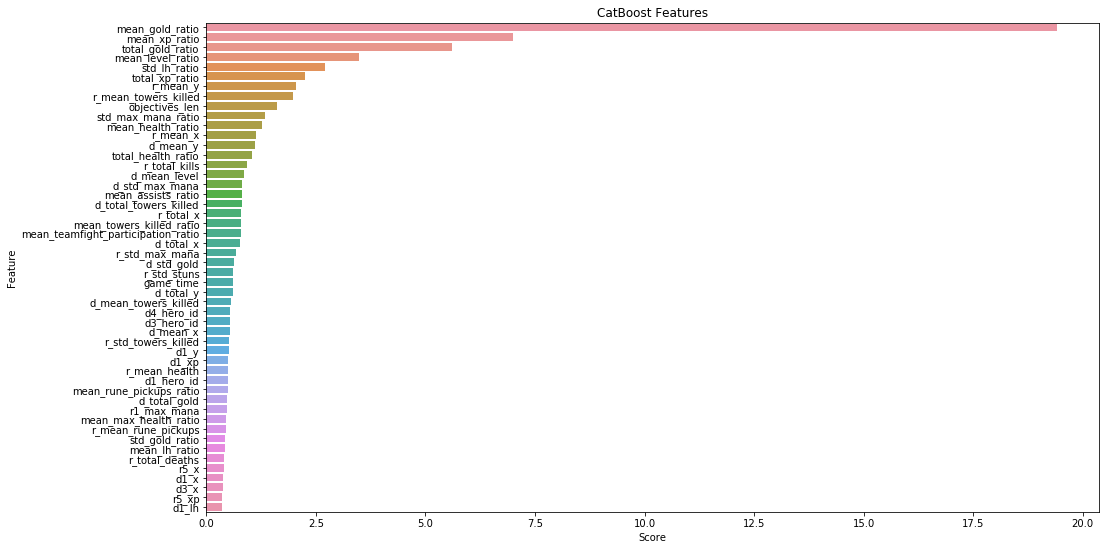

In [57]:
feature_importance_sns(cat_model_5, X5, y, figSize = (16,9))

#### Sub model 5

In [ ]:
sub = pd.read_csv('../input/Dota_2/sample_submission.csv')
sub['radiant_win_prob'] = prediction_cat_5
sub.to_csv('submission_catBoost_model_5.csv', index=False)
sub.head()

#### pred results

### Model 5.1 - Good CatBoost Parameters

#### New parameters

In [38]:
params_cat_good = {
    'iterations' : 20000,
    'learning_rate' : 0.05,
    'loss_function':'Logloss',
    'eval_metric':'AUC', 
    'task_type': 'GPU',
    'early_stopping_rounds': 1000,
    'logging_level': 'Info', 
         }

#### drop bad parameters

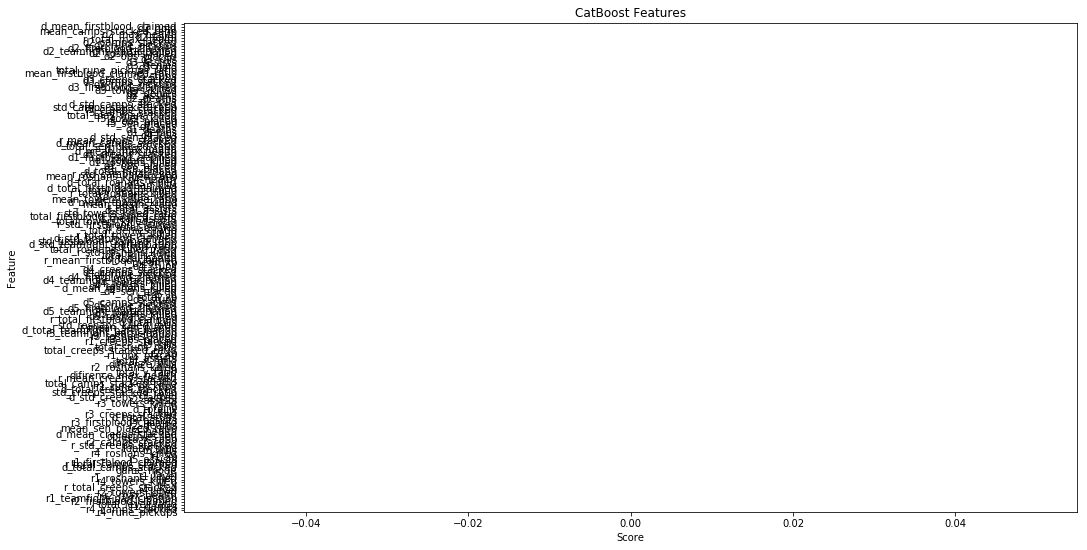

In [55]:
bad_5_1 = feature_importance_bad(cat_model_5, X5, y, col_ind, figSize = (16,9), n=175)

In [56]:
X5_1  = X5.drop(bad_5_1, axis = 1)
X_test5_1 = X_test5.drop(bad_5_1, axis = 1)

#### fit model

In [41]:
oof_cat_5_1, prediction_cat_5_1, scores_cat_5_1, cat_model_5_1 = train_model(X5,
                                                  X_test5,
                                                  y,
                                                  params=params_cat_good,
                                                  folds=folds,
                                                  model_type='cat',
                                                  rand_state=RANDOM_STATE)

0it [00:00, ?it/s]

Fold 0 started at Wed Nov 13 23:58:39 2019
0:	learn: 0.8040968	test: 0.8005394	best: 0.8005394 (0)	total: 318ms	remaining: 1h 45m 59s
500:	learn: 0.8684705	test: 0.8248006	best: 0.8249434 (475)	total: 2m 14s	remaining: 1h 27m 15s
1000:	learn: 0.8969999	test: 0.8235133	best: 0.8249434 (475)	total: 4m 25s	remaining: 1h 23m 59s
bestTest = 0.8249433637
bestIteration = 475
Shrink model to first 476 iterations.


1it [06:41, 401.30s/it]

Fold 1 started at Thu Nov 14 00:05:21 2019
0:	learn: 0.8078225	test: 0.7944507	best: 0.7944507 (0)	total: 283ms	remaining: 1h 34m 18s
500:	learn: 0.8714688	test: 0.8153768	best: 0.8156644 (439)	total: 2m 16s	remaining: 1h 28m 32s
1000:	learn: 0.8989374	test: 0.8152097	best: 0.8156644 (439)	total: 4m 40s	remaining: 1h 28m 53s
bestTest = 0.815664351
bestIteration = 439
Shrink model to first 440 iterations.


2it [13:44, 407.81s/it]

Fold 2 started at Thu Nov 14 00:12:24 2019
0:	learn: 0.8030981	test: 0.8095368	best: 0.8095368 (0)	total: 273ms	remaining: 1h 31m 9s
500:	learn: 0.8650603	test: 0.8284601	best: 0.8284672 (480)	total: 2m 14s	remaining: 1h 27m 30s
1000:	learn: 0.8919472	test: 0.8280883	best: 0.8287924 (568)	total: 4m 28s	remaining: 1h 24m 54s
1500:	learn: 0.9130823	test: 0.8275852	best: 0.8287924 (568)	total: 6m 42s	remaining: 1h 22m 35s
bestTest = 0.8287923932
bestIteration = 568
Shrink model to first 569 iterations.


3it [20:55, 414.83s/it]

Fold 3 started at Thu Nov 14 00:19:35 2019
0:	learn: 0.8029323	test: 0.8045245	best: 0.8045245 (0)	total: 280ms	remaining: 1h 33m 11s
500:	learn: 0.8678626	test: 0.8308982	best: 0.8310132 (279)	total: 2m 16s	remaining: 1h 28m 24s
1000:	learn: 0.8961268	test: 0.8292522	best: 0.8310132 (279)	total: 4m 28s	remaining: 1h 24m 55s
bestTest = 0.8310132027
bestIteration = 279
Shrink model to first 280 iterations.


4it [26:49, 396.63s/it]

Fold 4 started at Thu Nov 14 00:25:29 2019
0:	learn: 0.8036938	test: 0.7983694	best: 0.7983694 (0)	total: 278ms	remaining: 1h 32m 36s
500:	learn: 0.8691586	test: 0.8255195	best: 0.8263886 (190)	total: 2m 15s	remaining: 1h 28m 8s
1000:	learn: 0.9001870	test: 0.8239431	best: 0.8263886 (190)	total: 4m 30s	remaining: 1h 25m 35s
bestTest = 0.8263885975
bestIteration = 190
Shrink model to first 191 iterations.


5it [32:22, 377.45s/it]


CV mean score: 0.8253, std: 0.0053.


In [ ]:
sub = pd.read_csv('../input/Dota_2/sample_submission.csv')
sub['radiant_win_prob'] = prediction_cat_5_1
sub.to_csv('submission_catBoost_model_5_1.csv', index=False)
sub.head()

### Model 5.2 - Best CatBoost Parameters

## EDA

Идеи. Герои:
- связки героев
    - Висп Тини\ЦК
    - Сирена + Дизруптор
    ??
- тайминги + лейт герои
    - если игра длинная, то героии типо ТБ, АМа, ПЛа ебут
- Алхимик
    - Его команда всегда овнит по голде, но часто сосет? Проверить
- Контропики
    - Ам против Шторма

In [36]:
train_df.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   

                                  objectives_len  chat_len r1_hero_id  \
match_id_hash                                                           
a400b8f29dece5f4d266f49f1ae2e98a               1        11         11   
b9c57c450ce74a2af79c9ce96fac144d               3        10         15   
6db558535151ea18ca70a6892197db41               0         0        101   
46a0ddce8f7ed2a8d9bd5edcbb925682               1         4         14   
b1b35ff97723d9b7ade1c9c3cf48f770               1         3         42   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
a400b8f29dece5f4d266f49f1ae2e98a         0          0           0          0   
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
46a0ddce8f7ed2a8d9bd5edcbb925682         1          0           3          1   
b1b35ff97723d9b7ade1c9c3cf48f770         0          1           1          0   

                                        ...         difirence_kills  \
match_id_hash                           ...                           
a400b8f29dece5f4d266f49f1ae2e98a        ...               -1.000000   
b9c57c450ce74a2af79c9ce96fac144d        ...                0.684211   
6db558535151ea18ca70a6892197db41        ...                     NaN   
46a0ddce8f7ed2a8d9bd5edcbb925682        ...                0.714286   
b1b35ff97723d9b7ade1c9c3cf48f770        ...               -0.333333   

                                  difirence_gold  difirence_towers_killed  \
match_id_hash                                                               
a400b8f29dece5f4d266f49f1ae2e98a       -0.319298                      NaN   
b9c57c450ce74a2af79c9ce96fac144d        0.160557                      1.0   
6db558535151ea18ca70a6892197db41        0.294118                      NaN   
46a0ddce8f7ed2a8d9bd5edcbb925682        0.083046                      NaN   
b1b35ff97723d9b7ade1c9c3cf48f770       -0.063630                      NaN   

                                  difirence_max_health  difirence_max_mana  \
match_id_hash                                                                
a400b8f29dece5f4d266f49f1ae2e98a              0.000000           -0.132659   
b9c57c450ce74a2af79c9ce96fac144d              0.070248            0.041403   
6db558535151ea18ca70a6892197db41             -0.003155            0.025788   
46a0ddce8f7ed2a8d9bd5edcbb925682             -0.008403            0.081269   
b1b35ff97723d9b7ade1c9c3cf48f770              0.088785            0.093908   

                                  difirence_level  difirence_roshans_killed  \
match_id_hash                                                                 
a400b8f29dece5f4d266f49f1ae2e98a        -0.181818                       NaN   
b9c57c450ce74a2af79c9ce96fac144d         0.104478                       NaN   
6db558535151ea18ca70a6892197db41         0.000000                       NaN   
46a0ddce8f7ed2a8d9bd5edcbb925682         0.066667                       NaN   
b1b35ff97723d9b7ade1c9c3cf48f770        -0.019608                       NaN   

                                  radiant_tower_kills  dire_tower_kills  \
match_id_hash                                                             
a400b8f29dece5f4d266f49f1ae2e98a                  0.0               0.0   
b9c57c450ce74a2af79c9ce96fac144d                  2.0               0.0   
6db558535151ea18ca70a6892197db4

Попробуем глянуть на хиро какого нить

In [37]:
!grep -oEm1 '"hero_id":32,"hero_name":"[^"]+?"' $PATH_TO_DATA/train_matches.jsonl

'grep' is not recognized as an internal or external command,
operable program or batch file.


# New model

# Parameter tuning

## bayes tuning

https://www.kaggle.com/shivampanwar/catboost-and-hyperparameter-tuning-using-bayes

In [3]:
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    print.pprint(best_params)
    print()
    return best_params

In [5]:
#Skf and ROC-AUC
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Defining your search space
search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

In [6]:
cat_for_bayes = CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                         od_type = 'Iter',
                         verbose= False,
                         task_type= 'CPU',
                        )

In [7]:
# Setting up BayesSearchCV
opt = BayesSearchCV(cat_for_bayes,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [12]:
best_params = report_perf(opt, X5, y,'CatBoost', 
                          callbacks=[VerboseCallback(100), 
                                     DeadlineStopper(60*10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 3796.0068
Function value obtained: -0.8253
Current minimum: -0.8253
Iteration No: 2 started. Searching for the next optimal point.
CatBoost took 3796.02 seconds,  candidates checked: 1, best CV score: 0.825 ± 0.002
Best parameters:


NameError: name 'pprint' is not defined

### Save parameters

In [13]:
best_params

NameError: name 'best_params' is not defined

In [ ]:
joblib.dump(best_params, 'best_params_bayes_m5.pkl', compress = 1)

### Tuned model